In [46]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Dropout

In [2]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [3]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
1,Absol ex - 135/197,['Holofoil Market Price: '],8/2 to 8/4,$4.74
2,Absol ex - 135/197,['Holofoil Market Price: '],8/5 to 8/7,$4.74
3,Absol ex - 135/197,['Holofoil Market Price: '],8/8 to 8/10,$2.04
4,Absol ex - 135/197,['Holofoil Market Price: '],8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/19 to 10/21,$0.06
12926,Zigzagoon,[' Market Price: '],10/22 to 10/24,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/22 to 10/24,$0.05
12928,Zigzagoon,[' Market Price: '],10/25 to 10/27,$0.03


In [4]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [5]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [6]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 7.57% of the dataset has $0.00 market price

0.0757153905645785

In [7]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12926,Zigzagoon,Normal,10/22 to 10/24,$0.03
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05
12928,Zigzagoon,Normal,10/25 to 10/27,$0.03


In [8]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,$0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,$0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,$0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,$0.05


In [9]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned['Market Price'] = of_cleaned['Market Price'].astype(float)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
12923,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
12925,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
12927,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [10]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
11946,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06
11947,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06
11948,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06
11949,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05


In [11]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

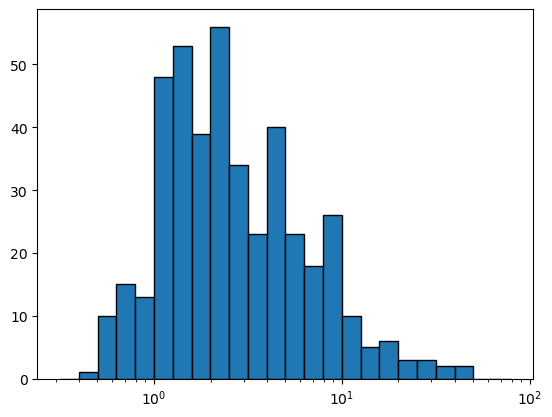

In [12]:
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [13]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 56% of the initial prices are more than double the latest price in the dataset

0.5627906976744186

In [14]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        # whether product matches the product from the previous line
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        # whether foil matches the foil from the previous line
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [15]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [16]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/19 to 10/21,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/22 to 10/24,0.05,0.06,0.06


In [17]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
11086,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
11087,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06
11088,Zigzagoon,Reverse Holofoil,10/13 to 10/15,0.06,0.06,0.06
11089,Zigzagoon,Reverse Holofoil,10/16 to 10/18,0.06,0.06,0.05


In [18]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11
5502,Zigzagoon,Reverse Holofoil,9/22 to 9/24,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.05,0.06,0.07,0.08,0.09,0.10


# Data Split

In [19]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '9/16 to 9/18',
       '9/19 to 9/21', '9/22 to 9/24', '9/25 to 9/27'], dtype=object)

In [20]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 135/197,Holofoil,9/16 to 9/18,0.96,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,1.16,1.03,1.04,1.00,0.94
12,Absol ex - 135/197,Holofoil,9/19 to 9/21,0.96,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.96,1.16,1.03,1.04,1.00
13,Absol ex - 135/197,Holofoil,9/22 to 9/24,1.08,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,0.96,0.96,1.16,1.03,1.04
14,Absol ex - 135/197,Holofoil,9/25 to 9/27,1.02,1.16,1.16,1.45,1.52,1.32,1.07,0.94,0.88,0.91,1.03,1.08,0.96,0.96,1.16,1.03
15,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07
5499,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.09,0.10,0.11,0.10,0.08
5500,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.08,0.09,0.10,0.11,0.10
5501,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.07,0.08,0.09,0.10,0.11


In [21]:
train

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
5,Absol ex - 135/197,Holofoil,8/29 to 8/31,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,1.16,0.93,0.92,0.81,0.81,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5493,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
5494,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
5495,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
5496,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [22]:
of_cleaned.iloc[5884]

Product             Lillipup
Foil                  Normal
Date Range      8/23 to 8/25
Market Price            0.06
Name: 5884, dtype: object

In [23]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [24]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [25]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [26]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,0.167060
1,Previous Market Price_2,-0.074821
2,Previous Market Price_3,0.029078
3,Previous Market Price_4,-0.034503
4,Previous Market Price_5,-0.122030
5,Market Price,1.002076
6,Foil_Holofoil,-0.190213
7,Foil_Normal,0.061893
8,Foil_Reverse Holofoil,0.128320


In [27]:
y_pred = classifier.predict(X_test)

In [28]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [29]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9978
r2:  0.9978
MAE:  0.3416
MSE:  3.3686
RMSE:  1.8354


# LSTM

In [30]:
X_train = train[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_train = row_list
X_test = test[['Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
# row_list = []
# for index, row in X_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# X_test = row_list
# y_train = train[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_train.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_train = row_list
# y_test = test[['Next Market Price_1', 'Next Market Price_2', 'Next Market Price_3',
#               'Next Market Price_4', 'Next Market Price_5', 'Next Market Price_6', 
#                  'Next Market Price_7', 'Next Market Price_8',
#               'Next Market Price_9', 'Next Market Price_10']]
# row_list = []
# for index, row in y_test.iterrows():
#     # append the row values as a list to the row_list
#     row_list.append([float(row.values[i]) for i in range(len(row.values))])
# y_test = row_list

In [31]:
X_train['Market Price']

1       0.81
2       0.81
3       0.92
4       0.93
5       1.01
        ... 
5493    0.07
5494    0.08
5495    0.10
5496    0.11
5497    0.10
Name: Market Price, Length: 1720, dtype: float64

In [95]:
# need a many to many lstm
# https://github.com/keras-team/keras/issues/6063

model = Sequential()  
model.add(LSTM(1, input_dim=1, return_sequences=False))
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))
# model.add(Activation('linear'))   
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1)                 12        
                                                                 
 dense_29 (Dense)            (None, 1)                 2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [96]:
history = model.fit(X_train, y_train,epochs=20000, validation_data=(X_test, y_test))

Epoch 1/20000
54/54 [==============================] - 3s 10ms/step - loss: 1799.6606 - mean_squared_error: 1799.6606 - val_loss: 1561.0857 - val_mean_squared_error: 1561.0857
Epoch 2/20000
54/54 [==============================] - 0s 3ms/step - loss: 1799.3552 - mean_squared_error: 1799.3552 - val_loss: 1560.7717 - val_mean_squared_error: 1560.7717
Epoch 3/20000
54/54 [==============================] - 0s 3ms/step - loss: 1799.0535 - mean_squared_error: 1799.0535 - val_loss: 1560.4587 - val_mean_squared_error: 1560.4587
Epoch 4/20000
54/54 [==============================] - 0s 3ms/step - loss: 1798.7394 - mean_squared_error: 1798.7394 - val_loss: 1560.1362 - val_mean_squared_error: 1560.1362
Epoch 5/20000
54/54 [==============================] - 0s 3ms/step - loss: 1798.4070 - mean_squared_error: 1798.4070 - val_loss: 1559.7903 - val_mean_squared_error: 1559.7903
Epoch 6/20000
54/54 [==============================] - 0s 3ms/step - loss: 1798.0515 - mean_squared_error: 1798.0515 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1757.7943 - mean_squared_error: 1757.7943 - val_loss: 1517.7958 - val_mean_squared_error: 1517.7958
Epoch 48/20000
54/54 [==============================] - 0s 3ms/step - loss: 1757.3242 - mean_squared_error: 1757.3242 - val_loss: 1517.3661 - val_mean_squared_error: 1517.3661
Epoch 49/20000
54/54 [==============================] - 0s 3ms/step - loss: 1756.8989 - mean_squared_error: 1756.8989 - val_loss: 1516.8843 - val_mean_squared_error: 1516.8843
Epoch 50/20000
54/54 [==============================] - 0s 3ms/step - loss: 1756.4414 - mean_squared_error: 1756.4414 - val_loss: 1516.4390 - val_mean_squared_error: 1516.4390
Epoch 51/20000
54/54 [==============================] - 0s 3ms/step - loss: 1756.0009 - mean_squared_error: 1756.0009 - val_loss: 1515.9962 - val_mean_squared_error: 1515.9962
Epoch 52/20000
54/54 [==============================] - 0s 3ms/step - loss: 1755.5582 - mean_squared_error: 1755.5582 - val_loss: 1515.

54/54 [==============================] - 0s 3ms/step - loss: 1737.6389 - mean_squared_error: 1737.6389 - val_loss: 1496.9384 - val_mean_squared_error: 1496.9384
Epoch 94/20000
54/54 [==============================] - 0s 3ms/step - loss: 1737.1708 - mean_squared_error: 1737.1708 - val_loss: 1496.5342 - val_mean_squared_error: 1496.5342
Epoch 95/20000
54/54 [==============================] - 0s 3ms/step - loss: 1736.7625 - mean_squared_error: 1736.7625 - val_loss: 1496.0792 - val_mean_squared_error: 1496.0792
Epoch 96/20000
54/54 [==============================] - 0s 3ms/step - loss: 1736.3298 - mean_squared_error: 1736.3298 - val_loss: 1495.6584 - val_mean_squared_error: 1495.6584
Epoch 97/20000
54/54 [==============================] - 0s 3ms/step - loss: 1735.8986 - mean_squared_error: 1735.8986 - val_loss: 1495.2625 - val_mean_squared_error: 1495.2625
Epoch 98/20000
54/54 [==============================] - 0s 3ms/step - loss: 1735.4869 - mean_squared_error: 1735.4869 - val_loss: 1494.

54/54 [==============================] - 0s 3ms/step - loss: 1718.6588 - mean_squared_error: 1718.6588 - val_loss: 1477.3862 - val_mean_squared_error: 1477.3862
Epoch 140/20000
54/54 [==============================] - 0s 3ms/step - loss: 1718.2583 - mean_squared_error: 1718.2583 - val_loss: 1476.9772 - val_mean_squared_error: 1476.9772
Epoch 141/20000
54/54 [==============================] - 0s 3ms/step - loss: 1717.8643 - mean_squared_error: 1717.8643 - val_loss: 1476.5602 - val_mean_squared_error: 1476.5602
Epoch 142/20000
54/54 [==============================] - 0s 3ms/step - loss: 1717.4629 - mean_squared_error: 1717.4629 - val_loss: 1476.1191 - val_mean_squared_error: 1476.1191
Epoch 143/20000
54/54 [==============================] - 0s 3ms/step - loss: 1717.0486 - mean_squared_error: 1717.0486 - val_loss: 1475.7365 - val_mean_squared_error: 1475.7365
Epoch 144/20000
54/54 [==============================] - 0s 3ms/step - loss: 1716.6508 - mean_squared_error: 1716.6508 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1700.4125 - mean_squared_error: 1700.4125 - val_loss: 1458.4988 - val_mean_squared_error: 1458.4988
Epoch 186/20000
54/54 [==============================] - 0s 3ms/step - loss: 1700.0236 - mean_squared_error: 1700.0236 - val_loss: 1458.0981 - val_mean_squared_error: 1458.0981
Epoch 187/20000
54/54 [==============================] - 0s 3ms/step - loss: 1699.6425 - mean_squared_error: 1699.6425 - val_loss: 1457.6979 - val_mean_squared_error: 1457.6979
Epoch 188/20000
54/54 [==============================] - 0s 3ms/step - loss: 1699.2484 - mean_squared_error: 1699.2484 - val_loss: 1457.2806 - val_mean_squared_error: 1457.2806
Epoch 189/20000
54/54 [==============================] - 0s 3ms/step - loss: 1698.8612 - mean_squared_error: 1698.8612 - val_loss: 1456.8682 - val_mean_squared_error: 1456.8682
Epoch 190/20000
54/54 [==============================] - 0s 3ms/step - loss: 1698.4644 - mean_squared_error: 1698.4644 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1682.5735 - mean_squared_error: 1682.5735 - val_loss: 1440.0909 - val_mean_squared_error: 1440.0909
Epoch 232/20000
54/54 [==============================] - 0s 3ms/step - loss: 1682.1953 - mean_squared_error: 1682.1953 - val_loss: 1439.6783 - val_mean_squared_error: 1439.6783
Epoch 233/20000
54/54 [==============================] - 0s 3ms/step - loss: 1681.8064 - mean_squared_error: 1681.8064 - val_loss: 1439.2949 - val_mean_squared_error: 1439.2949
Epoch 234/20000
54/54 [==============================] - 0s 3ms/step - loss: 1681.4387 - mean_squared_error: 1681.4387 - val_loss: 1438.8691 - val_mean_squared_error: 1438.8691
Epoch 235/20000
54/54 [==============================] - 0s 3ms/step - loss: 1681.0562 - mean_squared_error: 1681.0562 - val_loss: 1438.4615 - val_mean_squared_error: 1438.4615
Epoch 236/20000
54/54 [==============================] - 0s 3ms/step - loss: 1680.6605 - mean_squared_error: 1680.6605 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1665.5336 - mean_squared_error: 1665.5336 - val_loss: 1422.4655 - val_mean_squared_error: 1422.4655
Epoch 278/20000
54/54 [==============================] - 0s 3ms/step - loss: 1665.1843 - mean_squared_error: 1665.1843 - val_loss: 1422.0499 - val_mean_squared_error: 1422.0499
Epoch 279/20000
54/54 [==============================] - 0s 3ms/step - loss: 1664.8055 - mean_squared_error: 1664.8055 - val_loss: 1421.7062 - val_mean_squared_error: 1421.7062
Epoch 280/20000
54/54 [==============================] - 0s 3ms/step - loss: 1664.4526 - mean_squared_error: 1664.4526 - val_loss: 1421.3859 - val_mean_squared_error: 1421.3859
Epoch 281/20000
54/54 [==============================] - 0s 3ms/step - loss: 1664.0981 - mean_squared_error: 1664.0981 - val_loss: 1420.9316 - val_mean_squared_error: 1420.9316
Epoch 282/20000
54/54 [==============================] - 0s 3ms/step - loss: 1663.7189 - mean_squared_error: 1663.7189 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1648.9929 - mean_squared_error: 1648.9929 - val_loss: 1405.3409 - val_mean_squared_error: 1405.3409
Epoch 324/20000
54/54 [==============================] - 0s 3ms/step - loss: 1648.6455 - mean_squared_error: 1648.6455 - val_loss: 1404.9866 - val_mean_squared_error: 1404.9866
Epoch 325/20000
54/54 [==============================] - 0s 3ms/step - loss: 1648.2780 - mean_squared_error: 1648.2780 - val_loss: 1404.6533 - val_mean_squared_error: 1404.6533
Epoch 326/20000
54/54 [==============================] - 0s 3ms/step - loss: 1647.9482 - mean_squared_error: 1647.9482 - val_loss: 1404.2296 - val_mean_squared_error: 1404.2296
Epoch 327/20000
54/54 [==============================] - 0s 3ms/step - loss: 1647.5786 - mean_squared_error: 1647.5786 - val_loss: 1403.9249 - val_mean_squared_error: 1403.9249
Epoch 328/20000
54/54 [==============================] - 0s 4ms/step - loss: 1647.2402 - mean_squared_error: 1647.2402 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1632.9399 - mean_squared_error: 1632.9399 - val_loss: 1388.7451 - val_mean_squared_error: 1388.7451
Epoch 370/20000
54/54 [==============================] - 0s 3ms/step - loss: 1632.6023 - mean_squared_error: 1632.6023 - val_loss: 1388.3353 - val_mean_squared_error: 1388.3353
Epoch 371/20000
54/54 [==============================] - 0s 3ms/step - loss: 1632.2441 - mean_squared_error: 1632.2441 - val_loss: 1388.0009 - val_mean_squared_error: 1388.0009
Epoch 372/20000
54/54 [==============================] - 0s 3ms/step - loss: 1631.8981 - mean_squared_error: 1631.8981 - val_loss: 1387.6244 - val_mean_squared_error: 1387.6244
Epoch 373/20000
54/54 [==============================] - 0s 3ms/step - loss: 1631.5427 - mean_squared_error: 1631.5427 - val_loss: 1387.2847 - val_mean_squared_error: 1387.2847
Epoch 374/20000
54/54 [==============================] - 0s 3ms/step - loss: 1631.1981 - mean_squared_error: 1631.1981 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1617.1516 - mean_squared_error: 1617.1516 - val_loss: 1372.3201 - val_mean_squared_error: 1372.3201
Epoch 416/20000
54/54 [==============================] - 0s 4ms/step - loss: 1616.8000 - mean_squared_error: 1616.8000 - val_loss: 1371.9752 - val_mean_squared_error: 1371.9752
Epoch 417/20000
54/54 [==============================] - 0s 4ms/step - loss: 1616.4460 - mean_squared_error: 1616.4460 - val_loss: 1371.6494 - val_mean_squared_error: 1371.6494
Epoch 418/20000
54/54 [==============================] - 0s 3ms/step - loss: 1616.1106 - mean_squared_error: 1616.1106 - val_loss: 1371.3040 - val_mean_squared_error: 1371.3040
Epoch 419/20000
54/54 [==============================] - 0s 4ms/step - loss: 1615.7798 - mean_squared_error: 1615.7798 - val_loss: 1370.9008 - val_mean_squared_error: 1370.9008
Epoch 420/20000
54/54 [==============================] - 0s 4ms/step - loss: 1615.4266 - mean_squared_error: 1615.4266 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1601.7891 - mean_squared_error: 1601.7891 - val_loss: 1356.4187 - val_mean_squared_error: 1356.4187
Epoch 462/20000
54/54 [==============================] - 0s 3ms/step - loss: 1601.4437 - mean_squared_error: 1601.4437 - val_loss: 1356.1047 - val_mean_squared_error: 1356.1047
Epoch 463/20000
54/54 [==============================] - 0s 3ms/step - loss: 1601.1375 - mean_squared_error: 1601.1375 - val_loss: 1355.6954 - val_mean_squared_error: 1355.6954
Epoch 464/20000
54/54 [==============================] - 0s 3ms/step - loss: 1600.8103 - mean_squared_error: 1600.8103 - val_loss: 1355.4075 - val_mean_squared_error: 1355.4075
Epoch 465/20000
54/54 [==============================] - 0s 3ms/step - loss: 1600.4513 - mean_squared_error: 1600.4513 - val_loss: 1355.0945 - val_mean_squared_error: 1355.0945
Epoch 466/20000
54/54 [==============================] - 0s 3ms/step - loss: 1600.1000 - mean_squared_error: 1600.1000 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1586.7675 - mean_squared_error: 1586.7675 - val_loss: 1340.9305 - val_mean_squared_error: 1340.9305
Epoch 508/20000
54/54 [==============================] - 0s 4ms/step - loss: 1586.4541 - mean_squared_error: 1586.4541 - val_loss: 1340.5703 - val_mean_squared_error: 1340.5703
Epoch 509/20000
54/54 [==============================] - 0s 3ms/step - loss: 1586.1313 - mean_squared_error: 1586.1313 - val_loss: 1340.2305 - val_mean_squared_error: 1340.2305
Epoch 510/20000
54/54 [==============================] - 0s 3ms/step - loss: 1585.8103 - mean_squared_error: 1585.8103 - val_loss: 1339.9650 - val_mean_squared_error: 1339.9650
Epoch 511/20000
54/54 [==============================] - 0s 4ms/step - loss: 1585.5055 - mean_squared_error: 1585.5055 - val_loss: 1339.5483 - val_mean_squared_error: 1339.5483
Epoch 512/20000
54/54 [==============================] - 0s 3ms/step - loss: 1585.1687 - mean_squared_error: 1585.1687 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1572.1714 - mean_squared_error: 1572.1714 - val_loss: 1325.8726 - val_mean_squared_error: 1325.8726
Epoch 554/20000
54/54 [==============================] - 0s 3ms/step - loss: 1571.8771 - mean_squared_error: 1571.8771 - val_loss: 1325.5504 - val_mean_squared_error: 1325.5504
Epoch 555/20000
54/54 [==============================] - 0s 3ms/step - loss: 1571.5543 - mean_squared_error: 1571.5543 - val_loss: 1325.1857 - val_mean_squared_error: 1325.1857
Epoch 556/20000
54/54 [==============================] - 0s 3ms/step - loss: 1571.2288 - mean_squared_error: 1571.2288 - val_loss: 1324.8508 - val_mean_squared_error: 1324.8508
Epoch 557/20000
54/54 [==============================] - 0s 3ms/step - loss: 1570.9263 - mean_squared_error: 1570.9263 - val_loss: 1324.5527 - val_mean_squared_error: 1324.5527
Epoch 558/20000
54/54 [==============================] - 0s 3ms/step - loss: 1570.6017 - mean_squared_error: 1570.6017 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1557.6349 - mean_squared_error: 1557.6349 - val_loss: 1310.8842 - val_mean_squared_error: 1310.8842
Epoch 600/20000
54/54 [==============================] - 0s 3ms/step - loss: 1557.3080 - mean_squared_error: 1557.3080 - val_loss: 1310.6124 - val_mean_squared_error: 1310.6124
Epoch 601/20000
54/54 [==============================] - 0s 3ms/step - loss: 1557.0106 - mean_squared_error: 1557.0106 - val_loss: 1310.2217 - val_mean_squared_error: 1310.2217
Epoch 602/20000
54/54 [==============================] - 0s 4ms/step - loss: 1556.6967 - mean_squared_error: 1556.6967 - val_loss: 1309.9465 - val_mean_squared_error: 1309.9465
Epoch 603/20000
54/54 [==============================] - 0s 3ms/step - loss: 1556.3823 - mean_squared_error: 1556.3823 - val_loss: 1309.6436 - val_mean_squared_error: 1309.6436
Epoch 604/20000
54/54 [==============================] - 0s 3ms/step - loss: 1556.0803 - mean_squared_error: 1556.0803 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1543.5981 - mean_squared_error: 1543.5981 - val_loss: 1296.4447 - val_mean_squared_error: 1296.4447
Epoch 646/20000
54/54 [==============================] - 0s 3ms/step - loss: 1543.2920 - mean_squared_error: 1543.2920 - val_loss: 1296.1824 - val_mean_squared_error: 1296.1824
Epoch 647/20000
54/54 [==============================] - 0s 3ms/step - loss: 1543.0206 - mean_squared_error: 1543.0206 - val_loss: 1295.8358 - val_mean_squared_error: 1295.8358
Epoch 648/20000
54/54 [==============================] - 0s 3ms/step - loss: 1542.6874 - mean_squared_error: 1542.6874 - val_loss: 1295.5555 - val_mean_squared_error: 1295.5555
Epoch 649/20000
54/54 [==============================] - 0s 3ms/step - loss: 1542.4062 - mean_squared_error: 1542.4062 - val_loss: 1295.2527 - val_mean_squared_error: 1295.2527
Epoch 650/20000
54/54 [==============================] - 0s 3ms/step - loss: 1542.0963 - mean_squared_error: 1542.0963 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1529.8625 - mean_squared_error: 1529.8625 - val_loss: 1282.3433 - val_mean_squared_error: 1282.3433
Epoch 692/20000
54/54 [==============================] - 0s 3ms/step - loss: 1529.5686 - mean_squared_error: 1529.5686 - val_loss: 1282.0254 - val_mean_squared_error: 1282.0254
Epoch 693/20000
54/54 [==============================] - 0s 3ms/step - loss: 1529.2385 - mean_squared_error: 1529.2385 - val_loss: 1281.7751 - val_mean_squared_error: 1281.7751
Epoch 694/20000
54/54 [==============================] - 0s 3ms/step - loss: 1528.9521 - mean_squared_error: 1528.9521 - val_loss: 1281.4379 - val_mean_squared_error: 1281.4379
Epoch 695/20000
54/54 [==============================] - 0s 3ms/step - loss: 1528.6653 - mean_squared_error: 1528.6653 - val_loss: 1281.1155 - val_mean_squared_error: 1281.1155
Epoch 696/20000
54/54 [==============================] - 0s 3ms/step - loss: 1528.3499 - mean_squared_error: 1528.3499 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1516.2817 - mean_squared_error: 1516.2817 - val_loss: 1268.4463 - val_mean_squared_error: 1268.4463
Epoch 738/20000
54/54 [==============================] - 0s 3ms/step - loss: 1515.9951 - mean_squared_error: 1515.9951 - val_loss: 1268.1111 - val_mean_squared_error: 1268.1111
Epoch 739/20000
54/54 [==============================] - 0s 3ms/step - loss: 1515.6686 - mean_squared_error: 1515.6686 - val_loss: 1267.8531 - val_mean_squared_error: 1267.8531
Epoch 740/20000
54/54 [==============================] - 0s 3ms/step - loss: 1515.3964 - mean_squared_error: 1515.3964 - val_loss: 1267.5305 - val_mean_squared_error: 1267.5305
Epoch 741/20000
54/54 [==============================] - 0s 3ms/step - loss: 1515.0859 - mean_squared_error: 1515.0859 - val_loss: 1267.2631 - val_mean_squared_error: 1267.2631
Epoch 742/20000
54/54 [==============================] - 0s 3ms/step - loss: 1514.8041 - mean_squared_error: 1514.8041 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1502.9203 - mean_squared_error: 1502.9203 - val_loss: 1254.8496 - val_mean_squared_error: 1254.8496
Epoch 784/20000
54/54 [==============================] - 0s 3ms/step - loss: 1502.6271 - mean_squared_error: 1502.6271 - val_loss: 1254.5842 - val_mean_squared_error: 1254.5842
Epoch 785/20000
54/54 [==============================] - 0s 3ms/step - loss: 1502.3329 - mean_squared_error: 1502.3329 - val_loss: 1254.2635 - val_mean_squared_error: 1254.2635
Epoch 786/20000
54/54 [==============================] - 0s 3ms/step - loss: 1502.0381 - mean_squared_error: 1502.0381 - val_loss: 1253.9626 - val_mean_squared_error: 1253.9626
Epoch 787/20000
54/54 [==============================] - 0s 3ms/step - loss: 1501.7897 - mean_squared_error: 1501.7897 - val_loss: 1253.7571 - val_mean_squared_error: 1253.7571
Epoch 788/20000
54/54 [==============================] - 0s 3ms/step - loss: 1501.4537 - mean_squared_error: 1501.4537 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1489.7571 - mean_squared_error: 1489.7571 - val_loss: 1241.5619 - val_mean_squared_error: 1241.5619
Epoch 830/20000
54/54 [==============================] - 0s 3ms/step - loss: 1489.4657 - mean_squared_error: 1489.4657 - val_loss: 1241.2572 - val_mean_squared_error: 1241.2572
Epoch 831/20000
54/54 [==============================] - 0s 3ms/step - loss: 1489.1838 - mean_squared_error: 1489.1838 - val_loss: 1240.9637 - val_mean_squared_error: 1240.9637
Epoch 832/20000
54/54 [==============================] - 0s 3ms/step - loss: 1488.9363 - mean_squared_error: 1488.9363 - val_loss: 1240.7396 - val_mean_squared_error: 1240.7396
Epoch 833/20000
54/54 [==============================] - 0s 3ms/step - loss: 1488.6514 - mean_squared_error: 1488.6514 - val_loss: 1240.3132 - val_mean_squared_error: 1240.3132
Epoch 834/20000
54/54 [==============================] - 0s 3ms/step - loss: 1488.3536 - mean_squared_error: 1488.3536 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 1476.8187 - mean_squared_error: 1476.8187 - val_loss: 1228.4426 - val_mean_squared_error: 1228.4426
Epoch 876/20000
54/54 [==============================] - 0s 3ms/step - loss: 1476.5740 - mean_squared_error: 1476.5740 - val_loss: 1228.1235 - val_mean_squared_error: 1228.1235
Epoch 877/20000
54/54 [==============================] - 0s 3ms/step - loss: 1476.2386 - mean_squared_error: 1476.2386 - val_loss: 1227.8157 - val_mean_squared_error: 1227.8157
Epoch 878/20000
54/54 [==============================] - 0s 3ms/step - loss: 1475.9960 - mean_squared_error: 1475.9960 - val_loss: 1227.5760 - val_mean_squared_error: 1227.5760
Epoch 879/20000
54/54 [==============================] - 0s 3ms/step - loss: 1475.6891 - mean_squared_error: 1475.6891 - val_loss: 1227.1980 - val_mean_squared_error: 1227.1980
Epoch 880/20000
54/54 [==============================] - 0s 3ms/step - loss: 1475.4296 - mean_squared_error: 1475.4296 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1463.9347 - mean_squared_error: 1463.9347 - val_loss: 1215.3778 - val_mean_squared_error: 1215.3778
Epoch 922/20000
54/54 [==============================] - 0s 3ms/step - loss: 1463.6941 - mean_squared_error: 1463.6941 - val_loss: 1215.1129 - val_mean_squared_error: 1215.1129
Epoch 923/20000
54/54 [==============================] - 0s 3ms/step - loss: 1463.3928 - mean_squared_error: 1463.3928 - val_loss: 1214.8232 - val_mean_squared_error: 1214.8232
Epoch 924/20000
54/54 [==============================] - 0s 3ms/step - loss: 1463.1387 - mean_squared_error: 1463.1387 - val_loss: 1214.5986 - val_mean_squared_error: 1214.5986
Epoch 925/20000
54/54 [==============================] - 0s 4ms/step - loss: 1462.8751 - mean_squared_error: 1462.8751 - val_loss: 1214.2856 - val_mean_squared_error: 1214.2856
Epoch 926/20000
54/54 [==============================] - 0s 4ms/step - loss: 1462.6127 - mean_squared_error: 1462.6127 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1451.3887 - mean_squared_error: 1451.3887 - val_loss: 1202.6935 - val_mean_squared_error: 1202.6935
Epoch 968/20000
54/54 [==============================] - 0s 4ms/step - loss: 1451.1219 - mean_squared_error: 1451.1219 - val_loss: 1202.5314 - val_mean_squared_error: 1202.5314
Epoch 969/20000
54/54 [==============================] - 0s 4ms/step - loss: 1450.8827 - mean_squared_error: 1450.8827 - val_loss: 1202.2631 - val_mean_squared_error: 1202.2631
Epoch 970/20000
54/54 [==============================] - 0s 3ms/step - loss: 1450.5671 - mean_squared_error: 1450.5671 - val_loss: 1201.9521 - val_mean_squared_error: 1201.9521
Epoch 971/20000
54/54 [==============================] - 0s 4ms/step - loss: 1450.3080 - mean_squared_error: 1450.3080 - val_loss: 1201.5847 - val_mean_squared_error: 1201.5847
Epoch 972/20000
54/54 [==============================] - 0s 4ms/step - loss: 1450.0146 - mean_squared_error: 1450.0146 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 1438.9413 - mean_squared_error: 1438.9413 - val_loss: 1190.1959 - val_mean_squared_error: 1190.1959
Epoch 1014/20000
54/54 [==============================] - 0s 4ms/step - loss: 1438.6455 - mean_squared_error: 1438.6455 - val_loss: 1189.8304 - val_mean_squared_error: 1189.8304
Epoch 1015/20000
54/54 [==============================] - 0s 3ms/step - loss: 1438.4153 - mean_squared_error: 1438.4153 - val_loss: 1189.8298 - val_mean_squared_error: 1189.8298
Epoch 1016/20000
54/54 [==============================] - 0s 4ms/step - loss: 1438.1687 - mean_squared_error: 1438.1687 - val_loss: 1189.6139 - val_mean_squared_error: 1189.6139
Epoch 1017/20000
54/54 [==============================] - 0s 4ms/step - loss: 1437.8643 - mean_squared_error: 1437.8643 - val_loss: 1189.0221 - val_mean_squared_error: 1189.0221
Epoch 1018/20000
54/54 [==============================] - 0s 4ms/step - loss: 1437.5792 - mean_squared_error: 1437.5792 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1426.7731 - mean_squared_error: 1426.7731 - val_loss: 1177.8280 - val_mean_squared_error: 1177.8280
Epoch 1060/20000
54/54 [==============================] - 0s 3ms/step - loss: 1426.5032 - mean_squared_error: 1426.5032 - val_loss: 1177.7159 - val_mean_squared_error: 1177.7159
Epoch 1061/20000
54/54 [==============================] - 0s 3ms/step - loss: 1426.2756 - mean_squared_error: 1426.2756 - val_loss: 1177.3859 - val_mean_squared_error: 1177.3859
Epoch 1062/20000
54/54 [==============================] - 0s 3ms/step - loss: 1425.9771 - mean_squared_error: 1425.9771 - val_loss: 1177.0565 - val_mean_squared_error: 1177.0565
Epoch 1063/20000
54/54 [==============================] - 0s 3ms/step - loss: 1425.7015 - mean_squared_error: 1425.7015 - val_loss: 1177.0066 - val_mean_squared_error: 1177.0066
Epoch 1064/20000
54/54 [==============================] - 0s 3ms/step - loss: 1425.4496 - mean_squared_error: 1425.4496 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1414.6732 - mean_squared_error: 1414.6732 - val_loss: 1165.7964 - val_mean_squared_error: 1165.7964
Epoch 1106/20000
54/54 [==============================] - 0s 3ms/step - loss: 1414.4316 - mean_squared_error: 1414.4316 - val_loss: 1165.6033 - val_mean_squared_error: 1165.6033
Epoch 1107/20000
54/54 [==============================] - 0s 3ms/step - loss: 1414.1654 - mean_squared_error: 1414.1654 - val_loss: 1165.2629 - val_mean_squared_error: 1165.2629
Epoch 1108/20000
54/54 [==============================] - 0s 3ms/step - loss: 1413.9132 - mean_squared_error: 1413.9132 - val_loss: 1165.1031 - val_mean_squared_error: 1165.1031
Epoch 1109/20000
54/54 [==============================] - 0s 3ms/step - loss: 1413.6237 - mean_squared_error: 1413.6237 - val_loss: 1164.6632 - val_mean_squared_error: 1164.6632
Epoch 1110/20000
54/54 [==============================] - 0s 3ms/step - loss: 1413.3828 - mean_squared_error: 1413.3828 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1402.8732 - mean_squared_error: 1402.8732 - val_loss: 1154.0670 - val_mean_squared_error: 1154.0670
Epoch 1152/20000
54/54 [==============================] - 0s 3ms/step - loss: 1402.6096 - mean_squared_error: 1402.6096 - val_loss: 1153.6626 - val_mean_squared_error: 1153.6626
Epoch 1153/20000
54/54 [==============================] - 0s 3ms/step - loss: 1402.3405 - mean_squared_error: 1402.3405 - val_loss: 1153.3448 - val_mean_squared_error: 1153.3448
Epoch 1154/20000
54/54 [==============================] - 0s 3ms/step - loss: 1402.1080 - mean_squared_error: 1402.1080 - val_loss: 1153.0557 - val_mean_squared_error: 1153.0557
Epoch 1155/20000
54/54 [==============================] - 0s 3ms/step - loss: 1401.8561 - mean_squared_error: 1401.8561 - val_loss: 1152.8380 - val_mean_squared_error: 1152.8380
Epoch 1156/20000
54/54 [==============================] - 0s 3ms/step - loss: 1401.5947 - mean_squared_error: 1401.5947 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1391.1471 - mean_squared_error: 1391.1471 - val_loss: 1142.1198 - val_mean_squared_error: 1142.1198
Epoch 1198/20000
54/54 [==============================] - 0s 3ms/step - loss: 1390.9906 - mean_squared_error: 1390.9906 - val_loss: 1141.9117 - val_mean_squared_error: 1141.9117
Epoch 1199/20000
54/54 [==============================] - 0s 3ms/step - loss: 1390.7061 - mean_squared_error: 1390.7061 - val_loss: 1141.5669 - val_mean_squared_error: 1141.5669
Epoch 1200/20000
54/54 [==============================] - 0s 3ms/step - loss: 1390.4717 - mean_squared_error: 1390.4717 - val_loss: 1141.5344 - val_mean_squared_error: 1141.5344
Epoch 1201/20000
54/54 [==============================] - 0s 3ms/step - loss: 1390.1786 - mean_squared_error: 1390.1786 - val_loss: 1141.4255 - val_mean_squared_error: 1141.4255
Epoch 1202/20000
54/54 [==============================] - 0s 3ms/step - loss: 1389.9423 - mean_squared_error: 1389.9423 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1379.7681 - mean_squared_error: 1379.7681 - val_loss: 1130.8251 - val_mean_squared_error: 1130.8251
Epoch 1244/20000
54/54 [==============================] - 0s 3ms/step - loss: 1379.5303 - mean_squared_error: 1379.5303 - val_loss: 1130.6350 - val_mean_squared_error: 1130.6350
Epoch 1245/20000
54/54 [==============================] - 0s 3ms/step - loss: 1379.2827 - mean_squared_error: 1379.2827 - val_loss: 1130.1958 - val_mean_squared_error: 1130.1958
Epoch 1246/20000
54/54 [==============================] - 0s 3ms/step - loss: 1379.0383 - mean_squared_error: 1379.0383 - val_loss: 1129.9938 - val_mean_squared_error: 1129.9938
Epoch 1247/20000
54/54 [==============================] - 0s 3ms/step - loss: 1378.7952 - mean_squared_error: 1378.7952 - val_loss: 1129.9155 - val_mean_squared_error: 1129.9155
Epoch 1248/20000
54/54 [==============================] - 0s 3ms/step - loss: 1378.5551 - mean_squared_error: 1378.5551 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1368.6062 - mean_squared_error: 1368.6062 - val_loss: 1119.6310 - val_mean_squared_error: 1119.6310
Epoch 1290/20000
54/54 [==============================] - 0s 3ms/step - loss: 1368.4019 - mean_squared_error: 1368.4019 - val_loss: 1119.4705 - val_mean_squared_error: 1119.4705
Epoch 1291/20000
54/54 [==============================] - 0s 3ms/step - loss: 1368.1198 - mean_squared_error: 1368.1198 - val_loss: 1119.0234 - val_mean_squared_error: 1119.0234
Epoch 1292/20000
54/54 [==============================] - 0s 3ms/step - loss: 1367.8887 - mean_squared_error: 1367.8887 - val_loss: 1118.9136 - val_mean_squared_error: 1118.9136
Epoch 1293/20000
54/54 [==============================] - 0s 3ms/step - loss: 1367.6914 - mean_squared_error: 1367.6914 - val_loss: 1118.6537 - val_mean_squared_error: 1118.6537
Epoch 1294/20000
54/54 [==============================] - 0s 3ms/step - loss: 1367.4037 - mean_squared_error: 1367.4037 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1357.6838 - mean_squared_error: 1357.6838 - val_loss: 1108.5641 - val_mean_squared_error: 1108.5641
Epoch 1336/20000
54/54 [==============================] - 0s 3ms/step - loss: 1357.4479 - mean_squared_error: 1357.4479 - val_loss: 1108.3265 - val_mean_squared_error: 1108.3265
Epoch 1337/20000
54/54 [==============================] - 0s 3ms/step - loss: 1357.1881 - mean_squared_error: 1357.1881 - val_loss: 1108.4817 - val_mean_squared_error: 1108.4817
Epoch 1338/20000
54/54 [==============================] - 0s 3ms/step - loss: 1356.9948 - mean_squared_error: 1356.9948 - val_loss: 1107.8455 - val_mean_squared_error: 1107.8455
Epoch 1339/20000
54/54 [==============================] - 0s 3ms/step - loss: 1356.7410 - mean_squared_error: 1356.7410 - val_loss: 1107.7350 - val_mean_squared_error: 1107.7350
Epoch 1340/20000
54/54 [==============================] - 0s 3ms/step - loss: 1356.4902 - mean_squared_error: 1356.4902 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1346.8562 - mean_squared_error: 1346.8562 - val_loss: 1098.1984 - val_mean_squared_error: 1098.1984
Epoch 1382/20000
54/54 [==============================] - 0s 3ms/step - loss: 1346.6213 - mean_squared_error: 1346.6213 - val_loss: 1097.9126 - val_mean_squared_error: 1097.9126
Epoch 1383/20000
54/54 [==============================] - 0s 3ms/step - loss: 1346.4148 - mean_squared_error: 1346.4148 - val_loss: 1097.9292 - val_mean_squared_error: 1097.9292
Epoch 1384/20000
54/54 [==============================] - 0s 3ms/step - loss: 1346.1720 - mean_squared_error: 1346.1720 - val_loss: 1097.4271 - val_mean_squared_error: 1097.4271
Epoch 1385/20000
54/54 [==============================] - 0s 3ms/step - loss: 1345.9419 - mean_squared_error: 1345.9419 - val_loss: 1097.2371 - val_mean_squared_error: 1097.2371
Epoch 1386/20000
54/54 [==============================] - 0s 3ms/step - loss: 1345.7424 - mean_squared_error: 1345.7424 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1336.5221 - mean_squared_error: 1336.5221 - val_loss: 1087.5171 - val_mean_squared_error: 1087.5171
Epoch 1428/20000
54/54 [==============================] - 0s 3ms/step - loss: 1336.2744 - mean_squared_error: 1336.2744 - val_loss: 1087.1500 - val_mean_squared_error: 1087.1500
Epoch 1429/20000
54/54 [==============================] - 0s 4ms/step - loss: 1336.0947 - mean_squared_error: 1336.0947 - val_loss: 1087.1262 - val_mean_squared_error: 1087.1262
Epoch 1430/20000
54/54 [==============================] - 0s 3ms/step - loss: 1335.8252 - mean_squared_error: 1335.8252 - val_loss: 1087.0568 - val_mean_squared_error: 1087.0568
Epoch 1431/20000
54/54 [==============================] - 0s 4ms/step - loss: 1335.6150 - mean_squared_error: 1335.6150 - val_loss: 1086.6127 - val_mean_squared_error: 1086.6127
Epoch 1432/20000
54/54 [==============================] - 0s 3ms/step - loss: 1335.3940 - mean_squared_error: 1335.3940 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1326.1431 - mean_squared_error: 1326.1431 - val_loss: 1077.0817 - val_mean_squared_error: 1077.0817
Epoch 1474/20000
54/54 [==============================] - 0s 3ms/step - loss: 1325.8884 - mean_squared_error: 1325.8884 - val_loss: 1077.2081 - val_mean_squared_error: 1077.2081
Epoch 1475/20000
54/54 [==============================] - 0s 3ms/step - loss: 1325.6859 - mean_squared_error: 1325.6859 - val_loss: 1077.0437 - val_mean_squared_error: 1077.0437
Epoch 1476/20000
54/54 [==============================] - 0s 3ms/step - loss: 1325.4598 - mean_squared_error: 1325.4598 - val_loss: 1076.5001 - val_mean_squared_error: 1076.5001
Epoch 1477/20000
54/54 [==============================] - 0s 3ms/step - loss: 1325.2767 - mean_squared_error: 1325.2767 - val_loss: 1076.1816 - val_mean_squared_error: 1076.1816
Epoch 1478/20000
54/54 [==============================] - 0s 3ms/step - loss: 1325.0062 - mean_squared_error: 1325.0062 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1315.7926 - mean_squared_error: 1315.7926 - val_loss: 1067.4945 - val_mean_squared_error: 1067.4945
Epoch 1520/20000
54/54 [==============================] - 0s 3ms/step - loss: 1315.5984 - mean_squared_error: 1315.5984 - val_loss: 1066.6263 - val_mean_squared_error: 1066.6263
Epoch 1521/20000
54/54 [==============================] - 0s 3ms/step - loss: 1315.3640 - mean_squared_error: 1315.3640 - val_loss: 1066.2358 - val_mean_squared_error: 1066.2358
Epoch 1522/20000
54/54 [==============================] - 0s 4ms/step - loss: 1315.1262 - mean_squared_error: 1315.1262 - val_loss: 1066.1301 - val_mean_squared_error: 1066.1301
Epoch 1523/20000
54/54 [==============================] - 0s 3ms/step - loss: 1314.9088 - mean_squared_error: 1314.9088 - val_loss: 1066.0364 - val_mean_squared_error: 1066.0364
Epoch 1524/20000
54/54 [==============================] - 0s 4ms/step - loss: 1314.6923 - mean_squared_error: 1314.6923 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1305.7791 - mean_squared_error: 1305.7791 - val_loss: 1056.4811 - val_mean_squared_error: 1056.4811
Epoch 1566/20000
54/54 [==============================] - 0s 3ms/step - loss: 1305.5776 - mean_squared_error: 1305.5776 - val_loss: 1056.7705 - val_mean_squared_error: 1056.7705
Epoch 1567/20000
54/54 [==============================] - 0s 3ms/step - loss: 1305.3224 - mean_squared_error: 1305.3224 - val_loss: 1056.5665 - val_mean_squared_error: 1056.5665
Epoch 1568/20000
54/54 [==============================] - 0s 3ms/step - loss: 1305.1084 - mean_squared_error: 1305.1084 - val_loss: 1056.3541 - val_mean_squared_error: 1056.3541
Epoch 1569/20000
54/54 [==============================] - 0s 3ms/step - loss: 1304.8738 - mean_squared_error: 1304.8738 - val_loss: 1056.0730 - val_mean_squared_error: 1056.0730
Epoch 1570/20000
54/54 [==============================] - 0s 3ms/step - loss: 1304.6265 - mean_squared_error: 1304.6265 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1295.7985 - mean_squared_error: 1295.7985 - val_loss: 1046.5839 - val_mean_squared_error: 1046.5839
Epoch 1612/20000
54/54 [==============================] - 0s 3ms/step - loss: 1295.5509 - mean_squared_error: 1295.5509 - val_loss: 1045.6791 - val_mean_squared_error: 1045.6791
Epoch 1613/20000
54/54 [==============================] - 0s 4ms/step - loss: 1295.3633 - mean_squared_error: 1295.3633 - val_loss: 1046.0527 - val_mean_squared_error: 1046.0527
Epoch 1614/20000
54/54 [==============================] - 0s 4ms/step - loss: 1295.1592 - mean_squared_error: 1295.1592 - val_loss: 1045.7172 - val_mean_squared_error: 1045.7172
Epoch 1615/20000
54/54 [==============================] - 0s 4ms/step - loss: 1294.9370 - mean_squared_error: 1294.9370 - val_loss: 1045.4877 - val_mean_squared_error: 1045.4877
Epoch 1616/20000
54/54 [==============================] - 0s 4ms/step - loss: 1294.8595 - mean_squared_error: 1294.8595 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1285.8474 - mean_squared_error: 1285.8474 - val_loss: 1036.2200 - val_mean_squared_error: 1036.2200
Epoch 1658/20000
54/54 [==============================] - 0s 3ms/step - loss: 1285.5696 - mean_squared_error: 1285.5696 - val_loss: 1035.2812 - val_mean_squared_error: 1035.2812
Epoch 1659/20000
54/54 [==============================] - 0s 3ms/step - loss: 1285.4202 - mean_squared_error: 1285.4202 - val_loss: 1036.1995 - val_mean_squared_error: 1036.1995
Epoch 1660/20000
54/54 [==============================] - 0s 3ms/step - loss: 1285.2451 - mean_squared_error: 1285.2451 - val_loss: 1036.0573 - val_mean_squared_error: 1036.0573
Epoch 1661/20000
54/54 [==============================] - 0s 3ms/step - loss: 1284.9225 - mean_squared_error: 1284.9225 - val_loss: 1034.4309 - val_mean_squared_error: 1034.4309
Epoch 1662/20000
54/54 [==============================] - 0s 3ms/step - loss: 1284.6984 - mean_squared_error: 1284.6984 - val_l

54/54 [==============================] - 0s 4ms/step - loss: 1276.1038 - mean_squared_error: 1276.1038 - val_loss: 1026.6912 - val_mean_squared_error: 1026.6912
Epoch 1704/20000
54/54 [==============================] - 0s 4ms/step - loss: 1275.9200 - mean_squared_error: 1275.9200 - val_loss: 1026.0225 - val_mean_squared_error: 1026.0225
Epoch 1705/20000
54/54 [==============================] - 0s 3ms/step - loss: 1275.6313 - mean_squared_error: 1275.6313 - val_loss: 1025.2942 - val_mean_squared_error: 1025.2942
Epoch 1706/20000
54/54 [==============================] - 0s 3ms/step - loss: 1275.3627 - mean_squared_error: 1275.3627 - val_loss: 1026.0074 - val_mean_squared_error: 1026.0074
Epoch 1707/20000
54/54 [==============================] - 0s 3ms/step - loss: 1275.2449 - mean_squared_error: 1275.2449 - val_loss: 1024.1510 - val_mean_squared_error: 1024.1510
Epoch 1708/20000
54/54 [==============================] - 0s 4ms/step - loss: 1274.9720 - mean_squared_error: 1274.9720 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1266.1302 - mean_squared_error: 1266.1302 - val_loss: 1015.1609 - val_mean_squared_error: 1015.1609
Epoch 1750/20000
54/54 [==============================] - 0s 3ms/step - loss: 1265.9658 - mean_squared_error: 1265.9658 - val_loss: 1015.4015 - val_mean_squared_error: 1015.4015
Epoch 1751/20000
54/54 [==============================] - 0s 3ms/step - loss: 1265.6929 - mean_squared_error: 1265.6929 - val_loss: 1014.5605 - val_mean_squared_error: 1014.5605
Epoch 1752/20000
54/54 [==============================] - 0s 3ms/step - loss: 1265.8611 - mean_squared_error: 1265.8611 - val_loss: 1015.1428 - val_mean_squared_error: 1015.1428
Epoch 1753/20000
54/54 [==============================] - 0s 3ms/step - loss: 1265.3588 - mean_squared_error: 1265.3588 - val_loss: 1014.4137 - val_mean_squared_error: 1014.4137
Epoch 1754/20000
54/54 [==============================] - 0s 3ms/step - loss: 1265.3164 - mean_squared_error: 1265.3164 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1256.2258 - mean_squared_error: 1256.2258 - val_loss: 1003.6010 - val_mean_squared_error: 1003.6010
Epoch 1796/20000
54/54 [==============================] - 0s 3ms/step - loss: 1256.0234 - mean_squared_error: 1256.0234 - val_loss: 1003.3476 - val_mean_squared_error: 1003.3476
Epoch 1797/20000
54/54 [==============================] - 0s 3ms/step - loss: 1255.7616 - mean_squared_error: 1255.7616 - val_loss: 1003.5251 - val_mean_squared_error: 1003.5251
Epoch 1798/20000
54/54 [==============================] - 0s 3ms/step - loss: 1255.6400 - mean_squared_error: 1255.6400 - val_loss: 1003.1944 - val_mean_squared_error: 1003.1944
Epoch 1799/20000
54/54 [==============================] - 0s 4ms/step - loss: 1255.3412 - mean_squared_error: 1255.3412 - val_loss: 1003.0388 - val_mean_squared_error: 1003.0388
Epoch 1800/20000
54/54 [==============================] - 0s 4ms/step - loss: 1255.2185 - mean_squared_error: 1255.2185 - val_l

54/54 [==============================] - 0s 3ms/step - loss: 1246.6852 - mean_squared_error: 1246.6852 - val_loss: 994.0433 - val_mean_squared_error: 994.0433
Epoch 1842/20000
54/54 [==============================] - 0s 3ms/step - loss: 1246.4680 - mean_squared_error: 1246.4679 - val_loss: 993.9352 - val_mean_squared_error: 993.9352
Epoch 1843/20000
54/54 [==============================] - 0s 3ms/step - loss: 1246.2922 - mean_squared_error: 1246.2922 - val_loss: 993.6231 - val_mean_squared_error: 993.6231
Epoch 1844/20000
54/54 [==============================] - 0s 3ms/step - loss: 1246.0182 - mean_squared_error: 1246.0182 - val_loss: 993.4498 - val_mean_squared_error: 993.4498
Epoch 1845/20000
54/54 [==============================] - 0s 3ms/step - loss: 1245.8217 - mean_squared_error: 1245.8217 - val_loss: 993.3380 - val_mean_squared_error: 993.3380
Epoch 1846/20000
54/54 [==============================] - 0s 3ms/step - loss: 1245.6405 - mean_squared_error: 1245.6405 - val_loss: 993.3

54/54 [==============================] - 0s 4ms/step - loss: 1237.2334 - mean_squared_error: 1237.2334 - val_loss: 984.8530 - val_mean_squared_error: 984.8530
Epoch 1888/20000
54/54 [==============================] - 0s 4ms/step - loss: 1237.1061 - mean_squared_error: 1237.1061 - val_loss: 984.4139 - val_mean_squared_error: 984.4139
Epoch 1889/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.8276 - mean_squared_error: 1236.8276 - val_loss: 983.9512 - val_mean_squared_error: 983.9512
Epoch 1890/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.6256 - mean_squared_error: 1236.6256 - val_loss: 984.4889 - val_mean_squared_error: 984.4889
Epoch 1891/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.2826 - mean_squared_error: 1236.2826 - val_loss: 983.6840 - val_mean_squared_error: 983.6840
Epoch 1892/20000
54/54 [==============================] - 0s 3ms/step - loss: 1236.4795 - mean_squared_error: 1236.4795 - val_loss: 983.3

54/54 [==============================] - 0s 3ms/step - loss: 1227.7509 - mean_squared_error: 1227.7509 - val_loss: 975.5310 - val_mean_squared_error: 975.5310
Epoch 1934/20000
54/54 [==============================] - 0s 3ms/step - loss: 1227.4591 - mean_squared_error: 1227.4591 - val_loss: 974.6630 - val_mean_squared_error: 974.6630
Epoch 1935/20000
54/54 [==============================] - 0s 3ms/step - loss: 1227.2896 - mean_squared_error: 1227.2896 - val_loss: 975.0128 - val_mean_squared_error: 975.0128
Epoch 1936/20000
54/54 [==============================] - 0s 3ms/step - loss: 1227.0040 - mean_squared_error: 1227.0040 - val_loss: 974.3762 - val_mean_squared_error: 974.3762
Epoch 1937/20000
54/54 [==============================] - 0s 3ms/step - loss: 1226.8270 - mean_squared_error: 1226.8270 - val_loss: 974.3799 - val_mean_squared_error: 974.3799
Epoch 1938/20000
54/54 [==============================] - 0s 4ms/step - loss: 1226.7864 - mean_squared_error: 1226.7864 - val_loss: 974.5

54/54 [==============================] - 0s 3ms/step - loss: 1218.0338 - mean_squared_error: 1218.0338 - val_loss: 965.3785 - val_mean_squared_error: 965.3785
Epoch 1980/20000
54/54 [==============================] - 0s 3ms/step - loss: 1218.0284 - mean_squared_error: 1218.0284 - val_loss: 965.2465 - val_mean_squared_error: 965.2465
Epoch 1981/20000
54/54 [==============================] - 0s 3ms/step - loss: 1217.4866 - mean_squared_error: 1217.4866 - val_loss: 964.8643 - val_mean_squared_error: 964.8643
Epoch 1982/20000
54/54 [==============================] - 0s 3ms/step - loss: 1217.3718 - mean_squared_error: 1217.3718 - val_loss: 964.7875 - val_mean_squared_error: 964.7875
Epoch 1983/20000
54/54 [==============================] - 0s 3ms/step - loss: 1217.0914 - mean_squared_error: 1217.0914 - val_loss: 964.3740 - val_mean_squared_error: 964.3740
Epoch 1984/20000
54/54 [==============================] - 0s 3ms/step - loss: 1216.9144 - mean_squared_error: 1216.9144 - val_loss: 964.2

54/54 [==============================] - 0s 3ms/step - loss: 1208.4679 - mean_squared_error: 1208.4679 - val_loss: 955.7556 - val_mean_squared_error: 955.7556
Epoch 2026/20000
54/54 [==============================] - 0s 3ms/step - loss: 1208.1851 - mean_squared_error: 1208.1851 - val_loss: 955.6319 - val_mean_squared_error: 955.6319
Epoch 2027/20000
54/54 [==============================] - 0s 3ms/step - loss: 1208.1578 - mean_squared_error: 1208.1578 - val_loss: 956.3232 - val_mean_squared_error: 956.3232
Epoch 2028/20000
54/54 [==============================] - 0s 3ms/step - loss: 1208.1027 - mean_squared_error: 1208.1027 - val_loss: 955.3715 - val_mean_squared_error: 955.3715
Epoch 2029/20000
54/54 [==============================] - 0s 3ms/step - loss: 1207.6670 - mean_squared_error: 1207.6670 - val_loss: 954.9805 - val_mean_squared_error: 954.9805
Epoch 2030/20000
54/54 [==============================] - 0s 3ms/step - loss: 1207.4437 - mean_squared_error: 1207.4437 - val_loss: 954.8

54/54 [==============================] - 0s 3ms/step - loss: 1198.8420 - mean_squared_error: 1198.8420 - val_loss: 946.2985 - val_mean_squared_error: 946.2985
Epoch 2072/20000
54/54 [==============================] - 0s 3ms/step - loss: 1198.6034 - mean_squared_error: 1198.6034 - val_loss: 946.1473 - val_mean_squared_error: 946.1473
Epoch 2073/20000
54/54 [==============================] - 0s 3ms/step - loss: 1198.4226 - mean_squared_error: 1198.4226 - val_loss: 946.2391 - val_mean_squared_error: 946.2391
Epoch 2074/20000
54/54 [==============================] - 0s 3ms/step - loss: 1198.2458 - mean_squared_error: 1198.2458 - val_loss: 945.9449 - val_mean_squared_error: 945.9449
Epoch 2075/20000
54/54 [==============================] - 0s 3ms/step - loss: 1198.0187 - mean_squared_error: 1198.0187 - val_loss: 945.6945 - val_mean_squared_error: 945.6945
Epoch 2076/20000
54/54 [==============================] - 0s 3ms/step - loss: 1197.7522 - mean_squared_error: 1197.7522 - val_loss: 945.3

54/54 [==============================] - 0s 3ms/step - loss: 1189.4623 - mean_squared_error: 1189.4623 - val_loss: 937.1611 - val_mean_squared_error: 937.1611
Epoch 2118/20000
54/54 [==============================] - 0s 3ms/step - loss: 1189.3085 - mean_squared_error: 1189.3085 - val_loss: 937.0601 - val_mean_squared_error: 937.0601
Epoch 2119/20000
54/54 [==============================] - 0s 3ms/step - loss: 1189.0990 - mean_squared_error: 1189.0990 - val_loss: 936.7253 - val_mean_squared_error: 936.7253
Epoch 2120/20000
54/54 [==============================] - 0s 3ms/step - loss: 1189.0745 - mean_squared_error: 1189.0745 - val_loss: 936.5278 - val_mean_squared_error: 936.5278
Epoch 2121/20000
54/54 [==============================] - 0s 3ms/step - loss: 1188.9625 - mean_squared_error: 1188.9625 - val_loss: 936.3225 - val_mean_squared_error: 936.3225
Epoch 2122/20000
54/54 [==============================] - 0s 3ms/step - loss: 1188.4677 - mean_squared_error: 1188.4677 - val_loss: 936.0

54/54 [==============================] - 0s 3ms/step - loss: 1180.1439 - mean_squared_error: 1180.1439 - val_loss: 928.0227 - val_mean_squared_error: 928.0227
Epoch 2164/20000
54/54 [==============================] - 0s 3ms/step - loss: 1179.9744 - mean_squared_error: 1179.9744 - val_loss: 927.8080 - val_mean_squared_error: 927.8080
Epoch 2165/20000
54/54 [==============================] - 0s 3ms/step - loss: 1179.9430 - mean_squared_error: 1179.9430 - val_loss: 928.0314 - val_mean_squared_error: 928.0314
Epoch 2166/20000
54/54 [==============================] - 0s 3ms/step - loss: 1180.3328 - mean_squared_error: 1180.3328 - val_loss: 927.9396 - val_mean_squared_error: 927.9396
Epoch 2167/20000
54/54 [==============================] - 0s 3ms/step - loss: 1179.5695 - mean_squared_error: 1179.5695 - val_loss: 927.2822 - val_mean_squared_error: 927.2822
Epoch 2168/20000
54/54 [==============================] - 0s 3ms/step - loss: 1179.2250 - mean_squared_error: 1179.2250 - val_loss: 927.3

54/54 [==============================] - 0s 3ms/step - loss: 1170.9200 - mean_squared_error: 1170.9200 - val_loss: 918.8227 - val_mean_squared_error: 918.8227
Epoch 2210/20000
54/54 [==============================] - 0s 3ms/step - loss: 1170.8912 - mean_squared_error: 1170.8912 - val_loss: 918.7019 - val_mean_squared_error: 918.7019
Epoch 2211/20000
54/54 [==============================] - 0s 3ms/step - loss: 1170.7847 - mean_squared_error: 1170.7847 - val_loss: 918.6595 - val_mean_squared_error: 918.6595
Epoch 2212/20000
54/54 [==============================] - 0s 3ms/step - loss: 1171.0636 - mean_squared_error: 1171.0636 - val_loss: 918.9227 - val_mean_squared_error: 918.9227
Epoch 2213/20000
54/54 [==============================] - 0s 3ms/step - loss: 1170.1526 - mean_squared_error: 1170.1526 - val_loss: 918.7398 - val_mean_squared_error: 918.7398
Epoch 2214/20000
54/54 [==============================] - 0s 3ms/step - loss: 1170.2388 - mean_squared_error: 1170.2388 - val_loss: 917.8

54/54 [==============================] - 0s 4ms/step - loss: 1161.7521 - mean_squared_error: 1161.7521 - val_loss: 910.4758 - val_mean_squared_error: 910.4758
Epoch 2256/20000
54/54 [==============================] - 0s 3ms/step - loss: 1161.4761 - mean_squared_error: 1161.4761 - val_loss: 909.7251 - val_mean_squared_error: 909.7251
Epoch 2257/20000
54/54 [==============================] - 0s 3ms/step - loss: 1161.3748 - mean_squared_error: 1161.3748 - val_loss: 909.8649 - val_mean_squared_error: 909.8649
Epoch 2258/20000
54/54 [==============================] - 0s 3ms/step - loss: 1161.1909 - mean_squared_error: 1161.1909 - val_loss: 909.3475 - val_mean_squared_error: 909.3475
Epoch 2259/20000
54/54 [==============================] - 0s 3ms/step - loss: 1161.2053 - mean_squared_error: 1161.2053 - val_loss: 909.5186 - val_mean_squared_error: 909.5186
Epoch 2260/20000
54/54 [==============================] - 0s 3ms/step - loss: 1160.7413 - mean_squared_error: 1160.7413 - val_loss: 909.1

54/54 [==============================] - 0s 3ms/step - loss: 1152.5543 - mean_squared_error: 1152.5543 - val_loss: 901.0187 - val_mean_squared_error: 901.0187
Epoch 2302/20000
54/54 [==============================] - 0s 3ms/step - loss: 1152.9047 - mean_squared_error: 1152.9047 - val_loss: 902.0059 - val_mean_squared_error: 902.0059
Epoch 2303/20000
54/54 [==============================] - 0s 3ms/step - loss: 1152.2404 - mean_squared_error: 1152.2404 - val_loss: 900.7798 - val_mean_squared_error: 900.7798
Epoch 2304/20000
54/54 [==============================] - 0s 3ms/step - loss: 1151.9414 - mean_squared_error: 1151.9414 - val_loss: 900.4922 - val_mean_squared_error: 900.4922
Epoch 2305/20000
54/54 [==============================] - 0s 3ms/step - loss: 1151.7906 - mean_squared_error: 1151.7906 - val_loss: 900.5336 - val_mean_squared_error: 900.5336
Epoch 2306/20000
54/54 [==============================] - 0s 4ms/step - loss: 1151.6078 - mean_squared_error: 1151.6078 - val_loss: 900.0

54/54 [==============================] - 0s 4ms/step - loss: 1143.7010 - mean_squared_error: 1143.7010 - val_loss: 892.1206 - val_mean_squared_error: 892.1206
Epoch 2348/20000
54/54 [==============================] - 0s 3ms/step - loss: 1143.1591 - mean_squared_error: 1143.1591 - val_loss: 892.2731 - val_mean_squared_error: 892.2731
Epoch 2349/20000
54/54 [==============================] - 0s 3ms/step - loss: 1143.0750 - mean_squared_error: 1143.0750 - val_loss: 891.7809 - val_mean_squared_error: 891.7809
Epoch 2350/20000
54/54 [==============================] - 0s 3ms/step - loss: 1142.7504 - mean_squared_error: 1142.7504 - val_loss: 891.5584 - val_mean_squared_error: 891.5584
Epoch 2351/20000
54/54 [==============================] - 0s 3ms/step - loss: 1142.8076 - mean_squared_error: 1142.8076 - val_loss: 891.5349 - val_mean_squared_error: 891.5349
Epoch 2352/20000
54/54 [==============================] - 0s 3ms/step - loss: 1142.4478 - mean_squared_error: 1142.4478 - val_loss: 891.2

Epoch 2394/20000
54/54 [==============================] - 0s 4ms/step - loss: 1134.1208 - mean_squared_error: 1134.1208 - val_loss: 883.0741 - val_mean_squared_error: 883.0741
Epoch 2395/20000
54/54 [==============================] - 0s 4ms/step - loss: 1133.9596 - mean_squared_error: 1133.9596 - val_loss: 883.1080 - val_mean_squared_error: 883.1080
Epoch 2396/20000
54/54 [==============================] - 0s 4ms/step - loss: 1133.8143 - mean_squared_error: 1133.8143 - val_loss: 882.9633 - val_mean_squared_error: 882.9633
Epoch 2397/20000
54/54 [==============================] - 0s 4ms/step - loss: 1133.5106 - mean_squared_error: 1133.5106 - val_loss: 882.5322 - val_mean_squared_error: 882.5322
Epoch 2398/20000
54/54 [==============================] - 0s 4ms/step - loss: 1133.3918 - mean_squared_error: 1133.3918 - val_loss: 882.5179 - val_mean_squared_error: 882.5179
Epoch 2399/20000
54/54 [==============================] - 0s 4ms/step - loss: 1133.1116 - mean_squared_error: 1133.1116 

54/54 [==============================] - 0s 4ms/step - loss: 1124.9108 - mean_squared_error: 1124.9108 - val_loss: 874.2162 - val_mean_squared_error: 874.2162
Epoch 2441/20000
54/54 [==============================] - 0s 4ms/step - loss: 1124.8485 - mean_squared_error: 1124.8485 - val_loss: 874.0259 - val_mean_squared_error: 874.0259
Epoch 2442/20000
54/54 [==============================] - 0s 4ms/step - loss: 1124.6750 - mean_squared_error: 1124.6750 - val_loss: 874.1165 - val_mean_squared_error: 874.1165
Epoch 2443/20000
54/54 [==============================] - 0s 4ms/step - loss: 1124.4434 - mean_squared_error: 1124.4434 - val_loss: 874.0220 - val_mean_squared_error: 874.0220
Epoch 2444/20000
54/54 [==============================] - 0s 4ms/step - loss: 1124.3691 - mean_squared_error: 1124.3691 - val_loss: 873.4587 - val_mean_squared_error: 873.4587
Epoch 2445/20000
54/54 [==============================] - 0s 4ms/step - loss: 1123.9432 - mean_squared_error: 1123.9432 - val_loss: 873.2

54/54 [==============================] - 0s 4ms/step - loss: 1115.8378 - mean_squared_error: 1115.8378 - val_loss: 865.2537 - val_mean_squared_error: 865.2537
Epoch 2487/20000
54/54 [==============================] - 0s 4ms/step - loss: 1115.5723 - mean_squared_error: 1115.5723 - val_loss: 865.0800 - val_mean_squared_error: 865.0800
Epoch 2488/20000
54/54 [==============================] - 0s 4ms/step - loss: 1115.2933 - mean_squared_error: 1115.2933 - val_loss: 864.9708 - val_mean_squared_error: 864.9708
Epoch 2489/20000
54/54 [==============================] - 0s 4ms/step - loss: 1115.1519 - mean_squared_error: 1115.1519 - val_loss: 864.8923 - val_mean_squared_error: 864.8923
Epoch 2490/20000
54/54 [==============================] - 0s 4ms/step - loss: 1114.8625 - mean_squared_error: 1114.8625 - val_loss: 864.5220 - val_mean_squared_error: 864.5220
Epoch 2491/20000
54/54 [==============================] - 0s 4ms/step - loss: 1114.8073 - mean_squared_error: 1114.8073 - val_loss: 864.4

54/54 [==============================] - 0s 4ms/step - loss: 1106.4998 - mean_squared_error: 1106.4998 - val_loss: 856.5473 - val_mean_squared_error: 856.5473
Epoch 2533/20000
54/54 [==============================] - 0s 4ms/step - loss: 1106.2852 - mean_squared_error: 1106.2852 - val_loss: 856.3431 - val_mean_squared_error: 856.3431
Epoch 2534/20000
54/54 [==============================] - 0s 4ms/step - loss: 1106.0769 - mean_squared_error: 1106.0769 - val_loss: 856.1162 - val_mean_squared_error: 856.1162
Epoch 2535/20000
54/54 [==============================] - 0s 4ms/step - loss: 1105.8717 - mean_squared_error: 1105.8717 - val_loss: 855.9396 - val_mean_squared_error: 855.9396
Epoch 2536/20000
54/54 [==============================] - 0s 4ms/step - loss: 1105.6558 - mean_squared_error: 1105.6558 - val_loss: 855.7703 - val_mean_squared_error: 855.7703
Epoch 2537/20000
54/54 [==============================] - 0s 4ms/step - loss: 1105.5630 - mean_squared_error: 1105.5630 - val_loss: 855.6

54/54 [==============================] - 0s 3ms/step - loss: 1097.3876 - mean_squared_error: 1097.3876 - val_loss: 847.7037 - val_mean_squared_error: 847.7037
Epoch 2579/20000
54/54 [==============================] - 0s 3ms/step - loss: 1097.2034 - mean_squared_error: 1097.2034 - val_loss: 847.5544 - val_mean_squared_error: 847.5544
Epoch 2580/20000
54/54 [==============================] - 0s 3ms/step - loss: 1096.9592 - mean_squared_error: 1096.9592 - val_loss: 847.2681 - val_mean_squared_error: 847.2681
Epoch 2581/20000
54/54 [==============================] - 0s 3ms/step - loss: 1096.7970 - mean_squared_error: 1096.7970 - val_loss: 847.2258 - val_mean_squared_error: 847.2258
Epoch 2582/20000
54/54 [==============================] - 0s 3ms/step - loss: 1096.4674 - mean_squared_error: 1096.4674 - val_loss: 846.9218 - val_mean_squared_error: 846.9218
Epoch 2583/20000
54/54 [==============================] - 0s 3ms/step - loss: 1096.3619 - mean_squared_error: 1096.3619 - val_loss: 846.8

54/54 [==============================] - 0s 3ms/step - loss: 1088.1002 - mean_squared_error: 1088.1002 - val_loss: 838.9753 - val_mean_squared_error: 838.9753
Epoch 2625/20000
54/54 [==============================] - 0s 3ms/step - loss: 1088.0011 - mean_squared_error: 1088.0011 - val_loss: 838.7093 - val_mean_squared_error: 838.7093
Epoch 2626/20000
54/54 [==============================] - 0s 3ms/step - loss: 1087.7588 - mean_squared_error: 1087.7588 - val_loss: 838.5240 - val_mean_squared_error: 838.5240
Epoch 2627/20000
54/54 [==============================] - 0s 3ms/step - loss: 1087.6571 - mean_squared_error: 1087.6571 - val_loss: 838.3487 - val_mean_squared_error: 838.3487
Epoch 2628/20000
54/54 [==============================] - 0s 4ms/step - loss: 1087.6206 - mean_squared_error: 1087.6206 - val_loss: 838.6221 - val_mean_squared_error: 838.6221
Epoch 2629/20000
54/54 [==============================] - 0s 4ms/step - loss: 1087.2338 - mean_squared_error: 1087.2338 - val_loss: 838.1

54/54 [==============================] - 0s 3ms/step - loss: 1078.9441 - mean_squared_error: 1078.9441 - val_loss: 830.0699 - val_mean_squared_error: 830.0699
Epoch 2671/20000
54/54 [==============================] - 0s 3ms/step - loss: 1078.9774 - mean_squared_error: 1078.9774 - val_loss: 830.2997 - val_mean_squared_error: 830.2997
Epoch 2672/20000
54/54 [==============================] - 0s 3ms/step - loss: 1078.7157 - mean_squared_error: 1078.7157 - val_loss: 829.9380 - val_mean_squared_error: 829.9380
Epoch 2673/20000
54/54 [==============================] - 0s 3ms/step - loss: 1079.0001 - mean_squared_error: 1079.0001 - val_loss: 830.4414 - val_mean_squared_error: 830.4414
Epoch 2674/20000
54/54 [==============================] - 0s 3ms/step - loss: 1078.2412 - mean_squared_error: 1078.2412 - val_loss: 829.6809 - val_mean_squared_error: 829.6809
Epoch 2675/20000
54/54 [==============================] - 0s 3ms/step - loss: 1078.1111 - mean_squared_error: 1078.1111 - val_loss: 829.2

54/54 [==============================] - 0s 3ms/step - loss: 1070.0094 - mean_squared_error: 1070.0094 - val_loss: 821.7322 - val_mean_squared_error: 821.7322
Epoch 2717/20000
54/54 [==============================] - 0s 3ms/step - loss: 1069.9014 - mean_squared_error: 1069.9014 - val_loss: 821.4983 - val_mean_squared_error: 821.4983
Epoch 2718/20000
54/54 [==============================] - 0s 4ms/step - loss: 1069.6815 - mean_squared_error: 1069.6815 - val_loss: 821.1702 - val_mean_squared_error: 821.1702
Epoch 2719/20000
54/54 [==============================] - 0s 4ms/step - loss: 1069.4521 - mean_squared_error: 1069.4521 - val_loss: 820.9700 - val_mean_squared_error: 820.9700
Epoch 2720/20000
54/54 [==============================] - 0s 3ms/step - loss: 1069.2688 - mean_squared_error: 1069.2688 - val_loss: 821.0313 - val_mean_squared_error: 821.0313
Epoch 2721/20000
54/54 [==============================] - 0s 3ms/step - loss: 1070.0664 - mean_squared_error: 1070.0664 - val_loss: 820.6

Epoch 2763/20000
54/54 [==============================] - 0s 3ms/step - loss: 1061.0192 - mean_squared_error: 1061.0192 - val_loss: 812.8034 - val_mean_squared_error: 812.8034
Epoch 2764/20000
54/54 [==============================] - 0s 3ms/step - loss: 1060.7578 - mean_squared_error: 1060.7578 - val_loss: 812.6342 - val_mean_squared_error: 812.6342
Epoch 2765/20000
54/54 [==============================] - 0s 3ms/step - loss: 1061.0168 - mean_squared_error: 1061.0168 - val_loss: 812.4148 - val_mean_squared_error: 812.4148
Epoch 2766/20000
54/54 [==============================] - 0s 3ms/step - loss: 1060.3016 - mean_squared_error: 1060.3016 - val_loss: 812.3781 - val_mean_squared_error: 812.3781
Epoch 2767/20000
54/54 [==============================] - 0s 3ms/step - loss: 1060.1564 - mean_squared_error: 1060.1564 - val_loss: 812.0690 - val_mean_squared_error: 812.0690
Epoch 2768/20000
54/54 [==============================] - 0s 3ms/step - loss: 1059.7832 - mean_squared_error: 1059.7832 

54/54 [==============================] - 0s 3ms/step - loss: 1051.7333 - mean_squared_error: 1051.7333 - val_loss: 805.1215 - val_mean_squared_error: 805.1215
Epoch 2810/20000
54/54 [==============================] - 0s 3ms/step - loss: 1052.0768 - mean_squared_error: 1052.0768 - val_loss: 804.3885 - val_mean_squared_error: 804.3885
Epoch 2811/20000
54/54 [==============================] - 0s 3ms/step - loss: 1051.4545 - mean_squared_error: 1051.4545 - val_loss: 803.8430 - val_mean_squared_error: 803.8430
Epoch 2812/20000
54/54 [==============================] - 0s 3ms/step - loss: 1051.2509 - mean_squared_error: 1051.2509 - val_loss: 803.6650 - val_mean_squared_error: 803.6650
Epoch 2813/20000
54/54 [==============================] - 0s 3ms/step - loss: 1051.4740 - mean_squared_error: 1051.4740 - val_loss: 803.4714 - val_mean_squared_error: 803.4714
Epoch 2814/20000
54/54 [==============================] - 0s 3ms/step - loss: 1050.8621 - mean_squared_error: 1050.8621 - val_loss: 803.3

54/54 [==============================] - 0s 3ms/step - loss: 1042.9828 - mean_squared_error: 1042.9828 - val_loss: 795.7854 - val_mean_squared_error: 795.7854
Epoch 2856/20000
54/54 [==============================] - 0s 3ms/step - loss: 1042.7891 - mean_squared_error: 1042.7891 - val_loss: 795.7980 - val_mean_squared_error: 795.7980
Epoch 2857/20000
54/54 [==============================] - 0s 3ms/step - loss: 1042.5754 - mean_squared_error: 1042.5754 - val_loss: 795.5963 - val_mean_squared_error: 795.5963
Epoch 2858/20000
54/54 [==============================] - 0s 3ms/step - loss: 1042.3472 - mean_squared_error: 1042.3472 - val_loss: 795.2064 - val_mean_squared_error: 795.2064
Epoch 2859/20000
54/54 [==============================] - 0s 3ms/step - loss: 1042.4510 - mean_squared_error: 1042.4510 - val_loss: 795.4413 - val_mean_squared_error: 795.4413
Epoch 2860/20000
54/54 [==============================] - 0s 3ms/step - loss: 1041.9983 - mean_squared_error: 1041.9983 - val_loss: 795.4

54/54 [==============================] - 0s 3ms/step - loss: 1034.3461 - mean_squared_error: 1034.3461 - val_loss: 787.5638 - val_mean_squared_error: 787.5638
Epoch 2902/20000
54/54 [==============================] - 0s 3ms/step - loss: 1033.9139 - mean_squared_error: 1033.9139 - val_loss: 787.3194 - val_mean_squared_error: 787.3194
Epoch 2903/20000
54/54 [==============================] - 0s 3ms/step - loss: 1033.7516 - mean_squared_error: 1033.7516 - val_loss: 787.2158 - val_mean_squared_error: 787.2158
Epoch 2904/20000
54/54 [==============================] - 0s 3ms/step - loss: 1033.4164 - mean_squared_error: 1033.4164 - val_loss: 786.8098 - val_mean_squared_error: 786.8098
Epoch 2905/20000
54/54 [==============================] - 0s 3ms/step - loss: 1033.3427 - mean_squared_error: 1033.3427 - val_loss: 787.0244 - val_mean_squared_error: 787.0244
Epoch 2906/20000
54/54 [==============================] - 0s 3ms/step - loss: 1033.2787 - mean_squared_error: 1033.2787 - val_loss: 786.8

54/54 [==============================] - 0s 3ms/step - loss: 1025.3914 - mean_squared_error: 1025.3914 - val_loss: 779.2407 - val_mean_squared_error: 779.2407
Epoch 2948/20000
54/54 [==============================] - 0s 3ms/step - loss: 1025.6661 - mean_squared_error: 1025.6661 - val_loss: 778.9785 - val_mean_squared_error: 778.9785
Epoch 2949/20000
54/54 [==============================] - 0s 3ms/step - loss: 1025.1422 - mean_squared_error: 1025.1422 - val_loss: 779.0057 - val_mean_squared_error: 779.0057
Epoch 2950/20000
54/54 [==============================] - 0s 3ms/step - loss: 1024.8322 - mean_squared_error: 1024.8322 - val_loss: 779.0546 - val_mean_squared_error: 779.0546
Epoch 2951/20000
54/54 [==============================] - 0s 3ms/step - loss: 1024.6946 - mean_squared_error: 1024.6946 - val_loss: 778.6683 - val_mean_squared_error: 778.6683
Epoch 2952/20000
54/54 [==============================] - 0s 3ms/step - loss: 1024.3851 - mean_squared_error: 1024.3851 - val_loss: 778.1

54/54 [==============================] - 0s 3ms/step - loss: 1016.6572 - mean_squared_error: 1016.6572 - val_loss: 770.9155 - val_mean_squared_error: 770.9155
Epoch 2994/20000
54/54 [==============================] - 0s 3ms/step - loss: 1016.8865 - mean_squared_error: 1016.8865 - val_loss: 770.7830 - val_mean_squared_error: 770.7830
Epoch 2995/20000
54/54 [==============================] - 0s 3ms/step - loss: 1016.1647 - mean_squared_error: 1016.1647 - val_loss: 771.3605 - val_mean_squared_error: 771.3605
Epoch 2996/20000
54/54 [==============================] - 0s 3ms/step - loss: 1016.0228 - mean_squared_error: 1016.0228 - val_loss: 770.4439 - val_mean_squared_error: 770.4439
Epoch 2997/20000
54/54 [==============================] - 0s 3ms/step - loss: 1015.9124 - mean_squared_error: 1015.9124 - val_loss: 770.1615 - val_mean_squared_error: 770.1615
Epoch 2998/20000
54/54 [==============================] - 0s 3ms/step - loss: 1015.6832 - mean_squared_error: 1015.6832 - val_loss: 770.1

54/54 [==============================] - 0s 3ms/step - loss: 1008.4059 - mean_squared_error: 1008.4059 - val_loss: 762.8918 - val_mean_squared_error: 762.8918
Epoch 3040/20000
54/54 [==============================] - 0s 3ms/step - loss: 1008.1384 - mean_squared_error: 1008.1384 - val_loss: 763.0852 - val_mean_squared_error: 763.0852
Epoch 3041/20000
54/54 [==============================] - 0s 3ms/step - loss: 1007.6617 - mean_squared_error: 1007.6617 - val_loss: 762.7229 - val_mean_squared_error: 762.7229
Epoch 3042/20000
54/54 [==============================] - 0s 3ms/step - loss: 1007.6925 - mean_squared_error: 1007.6925 - val_loss: 762.9585 - val_mean_squared_error: 762.9585
Epoch 3043/20000
54/54 [==============================] - 0s 3ms/step - loss: 1007.4421 - mean_squared_error: 1007.4421 - val_loss: 762.2590 - val_mean_squared_error: 762.2590
Epoch 3044/20000
54/54 [==============================] - 0s 3ms/step - loss: 1007.1524 - mean_squared_error: 1007.1524 - val_loss: 761.9

Epoch 3086/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.1382 - mean_squared_error: 999.1382 - val_loss: 754.5132 - val_mean_squared_error: 754.5132
Epoch 3087/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.1351 - mean_squared_error: 999.1351 - val_loss: 754.5226 - val_mean_squared_error: 754.5226
Epoch 3088/20000
54/54 [==============================] - 0s 3ms/step - loss: 999.4260 - mean_squared_error: 999.4260 - val_loss: 760.4537 - val_mean_squared_error: 760.4537
Epoch 3089/20000
54/54 [==============================] - 0s 3ms/step - loss: 998.9337 - mean_squared_error: 998.9337 - val_loss: 754.3722 - val_mean_squared_error: 754.3722
Epoch 3090/20000
54/54 [==============================] - 0s 3ms/step - loss: 998.4666 - mean_squared_error: 998.4666 - val_loss: 753.9576 - val_mean_squared_error: 753.9576
Epoch 3091/20000
54/54 [==============================] - 0s 3ms/step - loss: 998.3470 - mean_squared_error: 998.3470 - val_loss: 

54/54 [==============================] - 0s 3ms/step - loss: 990.5056 - mean_squared_error: 990.5056 - val_loss: 747.1427 - val_mean_squared_error: 747.1427
Epoch 3134/20000
54/54 [==============================] - 0s 3ms/step - loss: 990.0431 - mean_squared_error: 990.0431 - val_loss: 748.0380 - val_mean_squared_error: 748.0380
Epoch 3135/20000
54/54 [==============================] - 0s 3ms/step - loss: 990.0065 - mean_squared_error: 990.0065 - val_loss: 747.7916 - val_mean_squared_error: 747.7916
Epoch 3136/20000
54/54 [==============================] - 0s 4ms/step - loss: 989.9615 - mean_squared_error: 989.9615 - val_loss: 747.2302 - val_mean_squared_error: 747.2302
Epoch 3137/20000
54/54 [==============================] - 0s 3ms/step - loss: 989.4675 - mean_squared_error: 989.4675 - val_loss: 746.6563 - val_mean_squared_error: 746.6563
Epoch 3138/20000
54/54 [==============================] - 0s 3ms/step - loss: 991.6292 - mean_squared_error: 991.6292 - val_loss: 745.2571 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 981.5850 - mean_squared_error: 981.5850 - val_loss: 740.2276 - val_mean_squared_error: 740.2276
Epoch 3181/20000
54/54 [==============================] - 0s 3ms/step - loss: 981.2412 - mean_squared_error: 981.2412 - val_loss: 741.2016 - val_mean_squared_error: 741.2016
Epoch 3182/20000
54/54 [==============================] - 0s 3ms/step - loss: 981.1439 - mean_squared_error: 981.1439 - val_loss: 739.6441 - val_mean_squared_error: 739.6441
Epoch 3183/20000
54/54 [==============================] - 0s 3ms/step - loss: 980.8743 - mean_squared_error: 980.8743 - val_loss: 738.3290 - val_mean_squared_error: 738.3290
Epoch 3184/20000
54/54 [==============================] - 0s 3ms/step - loss: 983.2425 - mean_squared_error: 983.2425 - val_loss: 740.5209 - val_mean_squared_error: 740.5209
Epoch 3185/20000
54/54 [==============================] - 0s 3ms/step - loss: 980.5397 - mean_squared_error: 980.5397 - val_loss: 739.8080 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 972.7472 - mean_squared_error: 972.7472 - val_loss: 729.6531 - val_mean_squared_error: 729.6531
Epoch 3228/20000
54/54 [==============================] - 0s 3ms/step - loss: 972.5194 - mean_squared_error: 972.5194 - val_loss: 729.5236 - val_mean_squared_error: 729.5236
Epoch 3229/20000
54/54 [==============================] - 0s 3ms/step - loss: 972.2576 - mean_squared_error: 972.2576 - val_loss: 729.6306 - val_mean_squared_error: 729.6306
Epoch 3230/20000
54/54 [==============================] - 0s 4ms/step - loss: 972.1738 - mean_squared_error: 972.1738 - val_loss: 729.1130 - val_mean_squared_error: 729.1130
Epoch 3231/20000
54/54 [==============================] - 0s 4ms/step - loss: 972.0075 - mean_squared_error: 972.0075 - val_loss: 728.9689 - val_mean_squared_error: 728.9689
Epoch 3232/20000
54/54 [==============================] - 0s 4ms/step - loss: 971.7014 - mean_squared_error: 971.7014 - val_loss: 728.8878 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 963.8553 - mean_squared_error: 963.8553 - val_loss: 721.8524 - val_mean_squared_error: 721.8524
Epoch 3275/20000
54/54 [==============================] - 0s 3ms/step - loss: 963.8206 - mean_squared_error: 963.8206 - val_loss: 721.3753 - val_mean_squared_error: 721.3753
Epoch 3276/20000
54/54 [==============================] - 0s 3ms/step - loss: 963.7337 - mean_squared_error: 963.7337 - val_loss: 721.3220 - val_mean_squared_error: 721.3220
Epoch 3277/20000
54/54 [==============================] - 0s 3ms/step - loss: 963.3434 - mean_squared_error: 963.3434 - val_loss: 721.1843 - val_mean_squared_error: 721.1843
Epoch 3278/20000
54/54 [==============================] - 0s 3ms/step - loss: 963.2120 - mean_squared_error: 963.2120 - val_loss: 720.9578 - val_mean_squared_error: 720.9578
Epoch 3279/20000
54/54 [==============================] - 0s 3ms/step - loss: 963.0193 - mean_squared_error: 963.0193 - val_loss: 721.4213 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 955.1700 - mean_squared_error: 955.1700 - val_loss: 715.2509 - val_mean_squared_error: 715.2509
Epoch 3322/20000
54/54 [==============================] - 0s 3ms/step - loss: 955.1948 - mean_squared_error: 955.1948 - val_loss: 715.9717 - val_mean_squared_error: 715.9717
Epoch 3323/20000
54/54 [==============================] - 0s 3ms/step - loss: 955.0961 - mean_squared_error: 955.0961 - val_loss: 713.9041 - val_mean_squared_error: 713.9041
Epoch 3324/20000
54/54 [==============================] - 0s 3ms/step - loss: 954.7668 - mean_squared_error: 954.7668 - val_loss: 716.5668 - val_mean_squared_error: 716.5668
Epoch 3325/20000
54/54 [==============================] - 0s 3ms/step - loss: 955.2130 - mean_squared_error: 955.2130 - val_loss: 713.9356 - val_mean_squared_error: 713.9356
Epoch 3326/20000
54/54 [==============================] - 0s 3ms/step - loss: 954.2915 - mean_squared_error: 954.2915 - val_loss: 714.4733 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 946.5344 - mean_squared_error: 946.5344 - val_loss: 707.1648 - val_mean_squared_error: 707.1648
Epoch 3369/20000
54/54 [==============================] - 0s 3ms/step - loss: 946.3572 - mean_squared_error: 946.3572 - val_loss: 707.1609 - val_mean_squared_error: 707.1609
Epoch 3370/20000
54/54 [==============================] - 0s 3ms/step - loss: 946.1971 - mean_squared_error: 946.1971 - val_loss: 708.0262 - val_mean_squared_error: 708.0262
Epoch 3371/20000
54/54 [==============================] - 0s 3ms/step - loss: 946.1873 - mean_squared_error: 946.1873 - val_loss: 707.3530 - val_mean_squared_error: 707.3530
Epoch 3372/20000
54/54 [==============================] - 0s 3ms/step - loss: 945.8170 - mean_squared_error: 945.8170 - val_loss: 707.1685 - val_mean_squared_error: 707.1685
Epoch 3373/20000
54/54 [==============================] - 0s 3ms/step - loss: 945.8243 - mean_squared_error: 945.8243 - val_loss: 706.9520 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 937.9168 - mean_squared_error: 937.9168 - val_loss: 698.9053 - val_mean_squared_error: 698.9053
Epoch 3416/20000
54/54 [==============================] - 0s 4ms/step - loss: 937.7221 - mean_squared_error: 937.7221 - val_loss: 698.5529 - val_mean_squared_error: 698.5529
Epoch 3417/20000
54/54 [==============================] - 0s 4ms/step - loss: 938.6816 - mean_squared_error: 938.6816 - val_loss: 697.7894 - val_mean_squared_error: 697.7894
Epoch 3418/20000
54/54 [==============================] - 0s 3ms/step - loss: 940.9600 - mean_squared_error: 940.9600 - val_loss: 696.9348 - val_mean_squared_error: 696.9348
Epoch 3419/20000
54/54 [==============================] - 0s 3ms/step - loss: 937.4254 - mean_squared_error: 937.4254 - val_loss: 696.7439 - val_mean_squared_error: 696.7439
Epoch 3420/20000
54/54 [==============================] - 0s 3ms/step - loss: 937.1287 - mean_squared_error: 937.1287 - val_loss: 696.5130 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 929.7249 - mean_squared_error: 929.7249 - val_loss: 692.2316 - val_mean_squared_error: 692.2316
Epoch 3463/20000
54/54 [==============================] - 0s 3ms/step - loss: 929.8446 - mean_squared_error: 929.8446 - val_loss: 705.1812 - val_mean_squared_error: 705.1812
Epoch 3464/20000
54/54 [==============================] - 0s 3ms/step - loss: 949.1570 - mean_squared_error: 949.1570 - val_loss: 718.1514 - val_mean_squared_error: 718.1514
Epoch 3465/20000
54/54 [==============================] - 0s 3ms/step - loss: 934.9192 - mean_squared_error: 934.9192 - val_loss: 695.8967 - val_mean_squared_error: 695.8967
Epoch 3466/20000
54/54 [==============================] - 0s 3ms/step - loss: 930.6826 - mean_squared_error: 930.6826 - val_loss: 697.9151 - val_mean_squared_error: 697.9151
Epoch 3467/20000
54/54 [==============================] - 0s 3ms/step - loss: 936.5552 - mean_squared_error: 936.5552 - val_loss: 710.4872 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 921.9752 - mean_squared_error: 921.9752 - val_loss: 690.9217 - val_mean_squared_error: 690.9217
Epoch 3510/20000
54/54 [==============================] - 0s 3ms/step - loss: 921.7913 - mean_squared_error: 921.7913 - val_loss: 689.9224 - val_mean_squared_error: 689.9224
Epoch 3511/20000
54/54 [==============================] - 0s 3ms/step - loss: 922.8682 - mean_squared_error: 922.8682 - val_loss: 726.2387 - val_mean_squared_error: 726.2387
Epoch 3512/20000
54/54 [==============================] - 0s 3ms/step - loss: 929.1255 - mean_squared_error: 929.1255 - val_loss: 698.7544 - val_mean_squared_error: 698.7544
Epoch 3513/20000
54/54 [==============================] - 0s 3ms/step - loss: 922.3303 - mean_squared_error: 922.3303 - val_loss: 693.6149 - val_mean_squared_error: 693.6149
Epoch 3514/20000
54/54 [==============================] - 0s 3ms/step - loss: 921.3939 - mean_squared_error: 921.3939 - val_loss: 691.5670 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 934.4309 - mean_squared_error: 934.4309 - val_loss: 695.3370 - val_mean_squared_error: 695.3370
Epoch 3557/20000
54/54 [==============================] - 0s 3ms/step - loss: 924.4293 - mean_squared_error: 924.4293 - val_loss: 692.3312 - val_mean_squared_error: 692.3312
Epoch 3558/20000
54/54 [==============================] - 0s 3ms/step - loss: 917.1603 - mean_squared_error: 917.1603 - val_loss: 688.9337 - val_mean_squared_error: 688.9337
Epoch 3559/20000
54/54 [==============================] - 0s 3ms/step - loss: 914.2593 - mean_squared_error: 914.2593 - val_loss: 686.3257 - val_mean_squared_error: 686.3257
Epoch 3560/20000
54/54 [==============================] - 0s 3ms/step - loss: 913.5585 - mean_squared_error: 913.5585 - val_loss: 684.6569 - val_mean_squared_error: 684.6569
Epoch 3561/20000
54/54 [==============================] - 0s 3ms/step - loss: 913.2057 - mean_squared_error: 913.2057 - val_loss: 683.7009 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 905.4483 - mean_squared_error: 905.4483 - val_loss: 676.2451 - val_mean_squared_error: 676.2451
Epoch 3604/20000
54/54 [==============================] - 0s 3ms/step - loss: 905.2542 - mean_squared_error: 905.2542 - val_loss: 676.3363 - val_mean_squared_error: 676.3363
Epoch 3605/20000
54/54 [==============================] - 0s 3ms/step - loss: 905.0765 - mean_squared_error: 905.0765 - val_loss: 677.0116 - val_mean_squared_error: 677.0116
Epoch 3606/20000
54/54 [==============================] - 0s 3ms/step - loss: 905.0150 - mean_squared_error: 905.0150 - val_loss: 676.1768 - val_mean_squared_error: 676.1768
Epoch 3607/20000
54/54 [==============================] - 0s 3ms/step - loss: 904.7018 - mean_squared_error: 904.7018 - val_loss: 675.2004 - val_mean_squared_error: 675.2004
Epoch 3608/20000
54/54 [==============================] - 0s 3ms/step - loss: 904.5115 - mean_squared_error: 904.5115 - val_loss: 675.1788 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 897.2678 - mean_squared_error: 897.2678 - val_loss: 667.4650 - val_mean_squared_error: 667.4650
Epoch 3651/20000
54/54 [==============================] - 0s 3ms/step - loss: 897.0819 - mean_squared_error: 897.0819 - val_loss: 667.5222 - val_mean_squared_error: 667.5222
Epoch 3652/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.9601 - mean_squared_error: 896.9601 - val_loss: 668.3389 - val_mean_squared_error: 668.3389
Epoch 3653/20000
54/54 [==============================] - 0s 3ms/step - loss: 898.9363 - mean_squared_error: 898.9363 - val_loss: 673.6784 - val_mean_squared_error: 673.6784
Epoch 3654/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.7812 - mean_squared_error: 896.7812 - val_loss: 668.6602 - val_mean_squared_error: 668.6602
Epoch 3655/20000
54/54 [==============================] - 0s 3ms/step - loss: 896.4044 - mean_squared_error: 896.4044 - val_loss: 667.8056 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 889.1605 - mean_squared_error: 889.1605 - val_loss: 661.0078 - val_mean_squared_error: 661.0078
Epoch 3698/20000
54/54 [==============================] - 0s 3ms/step - loss: 888.9511 - mean_squared_error: 888.9511 - val_loss: 660.4181 - val_mean_squared_error: 660.4181
Epoch 3699/20000
54/54 [==============================] - 0s 3ms/step - loss: 888.7493 - mean_squared_error: 888.7493 - val_loss: 660.2314 - val_mean_squared_error: 660.2314
Epoch 3700/20000
54/54 [==============================] - 0s 3ms/step - loss: 888.5620 - mean_squared_error: 888.5620 - val_loss: 659.9423 - val_mean_squared_error: 659.9423
Epoch 3701/20000
54/54 [==============================] - 0s 3ms/step - loss: 888.3989 - mean_squared_error: 888.3989 - val_loss: 659.5845 - val_mean_squared_error: 659.5845
Epoch 3702/20000
54/54 [==============================] - 0s 3ms/step - loss: 888.2244 - mean_squared_error: 888.2244 - val_loss: 661.2629 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 881.0607 - mean_squared_error: 881.0607 - val_loss: 653.2618 - val_mean_squared_error: 653.2618
Epoch 3745/20000
54/54 [==============================] - 0s 3ms/step - loss: 881.3737 - mean_squared_error: 881.3737 - val_loss: 659.7891 - val_mean_squared_error: 659.7891
Epoch 3746/20000
54/54 [==============================] - 0s 3ms/step - loss: 882.7028 - mean_squared_error: 882.7028 - val_loss: 657.9883 - val_mean_squared_error: 657.9883
Epoch 3747/20000
54/54 [==============================] - 0s 3ms/step - loss: 880.7912 - mean_squared_error: 880.7912 - val_loss: 655.2204 - val_mean_squared_error: 655.2204
Epoch 3748/20000
54/54 [==============================] - 0s 3ms/step - loss: 880.4672 - mean_squared_error: 880.4672 - val_loss: 653.9624 - val_mean_squared_error: 653.9624
Epoch 3749/20000
54/54 [==============================] - 0s 3ms/step - loss: 880.2278 - mean_squared_error: 880.2278 - val_loss: 653.3552 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 872.9623 - mean_squared_error: 872.9623 - val_loss: 647.2712 - val_mean_squared_error: 647.2712
Epoch 3792/20000
54/54 [==============================] - 0s 3ms/step - loss: 872.9329 - mean_squared_error: 872.9329 - val_loss: 651.5020 - val_mean_squared_error: 651.5020
Epoch 3793/20000
54/54 [==============================] - 0s 3ms/step - loss: 872.7424 - mean_squared_error: 872.7424 - val_loss: 648.2927 - val_mean_squared_error: 648.2927
Epoch 3794/20000
54/54 [==============================] - 0s 3ms/step - loss: 872.4550 - mean_squared_error: 872.4550 - val_loss: 646.7484 - val_mean_squared_error: 646.7484
Epoch 3795/20000
54/54 [==============================] - 0s 3ms/step - loss: 876.3002 - mean_squared_error: 876.3002 - val_loss: 663.9847 - val_mean_squared_error: 663.9847
Epoch 3796/20000
54/54 [==============================] - 0s 3ms/step - loss: 881.4530 - mean_squared_error: 881.4530 - val_loss: 651.5359 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 865.1511 - mean_squared_error: 865.1511 - val_loss: 640.2399 - val_mean_squared_error: 640.2399
Epoch 3839/20000
54/54 [==============================] - 0s 3ms/step - loss: 864.9123 - mean_squared_error: 864.9123 - val_loss: 639.1813 - val_mean_squared_error: 639.1813
Epoch 3840/20000
54/54 [==============================] - 0s 3ms/step - loss: 864.7142 - mean_squared_error: 864.7142 - val_loss: 638.9724 - val_mean_squared_error: 638.9724
Epoch 3841/20000
54/54 [==============================] - 0s 3ms/step - loss: 864.5418 - mean_squared_error: 864.5418 - val_loss: 638.4806 - val_mean_squared_error: 638.4806
Epoch 3842/20000
54/54 [==============================] - 0s 3ms/step - loss: 864.3967 - mean_squared_error: 864.3967 - val_loss: 638.6124 - val_mean_squared_error: 638.6124
Epoch 3843/20000
54/54 [==============================] - 0s 3ms/step - loss: 864.2414 - mean_squared_error: 864.2414 - val_loss: 639.0247 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 857.3030 - mean_squared_error: 857.3030 - val_loss: 632.7853 - val_mean_squared_error: 632.7853
Epoch 3886/20000
54/54 [==============================] - 0s 3ms/step - loss: 857.1144 - mean_squared_error: 857.1144 - val_loss: 631.9856 - val_mean_squared_error: 631.9856
Epoch 3887/20000
54/54 [==============================] - 0s 3ms/step - loss: 856.9586 - mean_squared_error: 856.9586 - val_loss: 633.3964 - val_mean_squared_error: 633.3964
Epoch 3888/20000
54/54 [==============================] - 0s 3ms/step - loss: 856.8643 - mean_squared_error: 856.8643 - val_loss: 633.2530 - val_mean_squared_error: 633.2530
Epoch 3889/20000
54/54 [==============================] - 0s 3ms/step - loss: 856.6190 - mean_squared_error: 856.6190 - val_loss: 631.7024 - val_mean_squared_error: 631.7024
Epoch 3890/20000
54/54 [==============================] - 0s 3ms/step - loss: 856.6954 - mean_squared_error: 856.6954 - val_loss: 637.6591 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 849.4520 - mean_squared_error: 849.4520 - val_loss: 626.2236 - val_mean_squared_error: 626.2236
Epoch 3933/20000
54/54 [==============================] - 0s 4ms/step - loss: 849.2627 - mean_squared_error: 849.2627 - val_loss: 625.4656 - val_mean_squared_error: 625.4656
Epoch 3934/20000
54/54 [==============================] - 0s 3ms/step - loss: 882.8737 - mean_squared_error: 882.8737 - val_loss: 644.6161 - val_mean_squared_error: 644.6161
Epoch 3935/20000
54/54 [==============================] - 0s 3ms/step - loss: 868.6525 - mean_squared_error: 868.6525 - val_loss: 638.8749 - val_mean_squared_error: 638.8749
Epoch 3936/20000
54/54 [==============================] - 0s 4ms/step - loss: 860.7289 - mean_squared_error: 860.7289 - val_loss: 635.8508 - val_mean_squared_error: 635.8508
Epoch 3937/20000
54/54 [==============================] - 0s 3ms/step - loss: 855.0021 - mean_squared_error: 855.0021 - val_loss: 635.5723 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 841.8965 - mean_squared_error: 841.8965 - val_loss: 618.6352 - val_mean_squared_error: 618.6352
Epoch 3980/20000
54/54 [==============================] - 0s 3ms/step - loss: 841.7130 - mean_squared_error: 841.7130 - val_loss: 618.4636 - val_mean_squared_error: 618.4636
Epoch 3981/20000
54/54 [==============================] - 0s 3ms/step - loss: 841.5312 - mean_squared_error: 841.5312 - val_loss: 618.1626 - val_mean_squared_error: 618.1626
Epoch 3982/20000
54/54 [==============================] - 0s 3ms/step - loss: 841.4238 - mean_squared_error: 841.4238 - val_loss: 621.3514 - val_mean_squared_error: 621.3514
Epoch 3983/20000
54/54 [==============================] - 0s 3ms/step - loss: 841.3463 - mean_squared_error: 841.3463 - val_loss: 619.4604 - val_mean_squared_error: 619.4604
Epoch 3984/20000
54/54 [==============================] - 0s 3ms/step - loss: 841.0558 - mean_squared_error: 841.0558 - val_loss: 617.9174 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 834.1703 - mean_squared_error: 834.1703 - val_loss: 611.9058 - val_mean_squared_error: 611.9058
Epoch 4027/20000
54/54 [==============================] - 0s 3ms/step - loss: 834.1498 - mean_squared_error: 834.1498 - val_loss: 613.0184 - val_mean_squared_error: 613.0184
Epoch 4028/20000
54/54 [==============================] - 0s 3ms/step - loss: 833.8578 - mean_squared_error: 833.8578 - val_loss: 613.1327 - val_mean_squared_error: 613.1327
Epoch 4029/20000
54/54 [==============================] - 0s 3ms/step - loss: 833.6996 - mean_squared_error: 833.6996 - val_loss: 612.1523 - val_mean_squared_error: 612.1523
Epoch 4030/20000
54/54 [==============================] - 0s 3ms/step - loss: 834.1528 - mean_squared_error: 834.1528 - val_loss: 630.8422 - val_mean_squared_error: 630.8422
Epoch 4031/20000
54/54 [==============================] - 0s 4ms/step - loss: 851.9963 - mean_squared_error: 851.9963 - val_loss: 630.3132 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 827.0792 - mean_squared_error: 827.0792 - val_loss: 610.3245 - val_mean_squared_error: 610.3245
Epoch 4074/20000
54/54 [==============================] - 0s 3ms/step - loss: 826.8506 - mean_squared_error: 826.8506 - val_loss: 609.2180 - val_mean_squared_error: 609.2180
Epoch 4075/20000
54/54 [==============================] - 0s 3ms/step - loss: 826.6382 - mean_squared_error: 826.6382 - val_loss: 608.6756 - val_mean_squared_error: 608.6756
Epoch 4076/20000
54/54 [==============================] - 0s 3ms/step - loss: 826.4386 - mean_squared_error: 826.4386 - val_loss: 607.7204 - val_mean_squared_error: 607.7204
Epoch 4077/20000
54/54 [==============================] - 0s 3ms/step - loss: 826.2443 - mean_squared_error: 826.2443 - val_loss: 607.2533 - val_mean_squared_error: 607.2533
Epoch 4078/20000
54/54 [==============================] - 0s 3ms/step - loss: 826.0424 - mean_squared_error: 826.0424 - val_loss: 606.8373 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 819.2930 - mean_squared_error: 819.2930 - val_loss: 605.4780 - val_mean_squared_error: 605.4780
Epoch 4121/20000
54/54 [==============================] - 0s 4ms/step - loss: 819.7318 - mean_squared_error: 819.7318 - val_loss: 604.8673 - val_mean_squared_error: 604.8673
Epoch 4122/20000
54/54 [==============================] - 0s 3ms/step - loss: 819.0613 - mean_squared_error: 819.0613 - val_loss: 602.1841 - val_mean_squared_error: 602.1841
Epoch 4123/20000
54/54 [==============================] - 0s 3ms/step - loss: 818.6985 - mean_squared_error: 818.6985 - val_loss: 600.8301 - val_mean_squared_error: 600.8301
Epoch 4124/20000
54/54 [==============================] - 0s 3ms/step - loss: 818.4874 - mean_squared_error: 818.4874 - val_loss: 599.5611 - val_mean_squared_error: 599.5611
Epoch 4125/20000
54/54 [==============================] - 0s 3ms/step - loss: 818.2938 - mean_squared_error: 818.2938 - val_loss: 598.9239 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 811.8152 - mean_squared_error: 811.8152 - val_loss: 593.0228 - val_mean_squared_error: 593.0228
Epoch 4168/20000
54/54 [==============================] - 0s 3ms/step - loss: 811.5963 - mean_squared_error: 811.5963 - val_loss: 592.3363 - val_mean_squared_error: 592.3363
Epoch 4169/20000
54/54 [==============================] - 0s 3ms/step - loss: 811.4249 - mean_squared_error: 811.4249 - val_loss: 591.7543 - val_mean_squared_error: 591.7543
Epoch 4170/20000
54/54 [==============================] - 0s 3ms/step - loss: 811.2496 - mean_squared_error: 811.2496 - val_loss: 591.4254 - val_mean_squared_error: 591.4254
Epoch 4171/20000
54/54 [==============================] - 0s 3ms/step - loss: 811.0944 - mean_squared_error: 811.0944 - val_loss: 591.2972 - val_mean_squared_error: 591.2972
Epoch 4172/20000
54/54 [==============================] - 0s 3ms/step - loss: 810.9667 - mean_squared_error: 810.9667 - val_loss: 592.2369 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 804.5961 - mean_squared_error: 804.5961 - val_loss: 588.8702 - val_mean_squared_error: 588.8702
Epoch 4215/20000
54/54 [==============================] - 0s 3ms/step - loss: 804.3651 - mean_squared_error: 804.3651 - val_loss: 587.8935 - val_mean_squared_error: 587.8935
Epoch 4216/20000
54/54 [==============================] - 0s 3ms/step - loss: 804.1768 - mean_squared_error: 804.1768 - val_loss: 587.0150 - val_mean_squared_error: 587.0150
Epoch 4217/20000
54/54 [==============================] - 0s 3ms/step - loss: 803.9464 - mean_squared_error: 803.9464 - val_loss: 586.3169 - val_mean_squared_error: 586.3169
Epoch 4218/20000
54/54 [==============================] - 0s 3ms/step - loss: 803.7471 - mean_squared_error: 803.7471 - val_loss: 585.7670 - val_mean_squared_error: 585.7670
Epoch 4219/20000
54/54 [==============================] - 0s 3ms/step - loss: 803.5782 - mean_squared_error: 803.5782 - val_loss: 585.0306 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 796.9634 - mean_squared_error: 796.9634 - val_loss: 581.4622 - val_mean_squared_error: 581.4622
Epoch 4262/20000
54/54 [==============================] - 0s 3ms/step - loss: 796.7234 - mean_squared_error: 796.7234 - val_loss: 580.6561 - val_mean_squared_error: 580.6561
Epoch 4263/20000
54/54 [==============================] - 0s 3ms/step - loss: 796.5465 - mean_squared_error: 796.5465 - val_loss: 579.8757 - val_mean_squared_error: 579.8757
Epoch 4264/20000
54/54 [==============================] - 0s 3ms/step - loss: 796.3696 - mean_squared_error: 796.3696 - val_loss: 579.6624 - val_mean_squared_error: 579.6624
Epoch 4265/20000
54/54 [==============================] - 0s 3ms/step - loss: 796.2441 - mean_squared_error: 796.2441 - val_loss: 582.9074 - val_mean_squared_error: 582.9074
Epoch 4266/20000
54/54 [==============================] - 0s 3ms/step - loss: 796.1351 - mean_squared_error: 796.1351 - val_loss: 580.8132 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 790.3120 - mean_squared_error: 790.3120 - val_loss: 577.9601 - val_mean_squared_error: 577.9601
Epoch 4309/20000
54/54 [==============================] - 0s 3ms/step - loss: 790.1235 - mean_squared_error: 790.1235 - val_loss: 577.3589 - val_mean_squared_error: 577.3589
Epoch 4310/20000
54/54 [==============================] - 0s 3ms/step - loss: 789.9353 - mean_squared_error: 789.9353 - val_loss: 576.8143 - val_mean_squared_error: 576.8143
Epoch 4311/20000
54/54 [==============================] - 0s 3ms/step - loss: 789.7364 - mean_squared_error: 789.7364 - val_loss: 576.4262 - val_mean_squared_error: 576.4262
Epoch 4312/20000
54/54 [==============================] - 0s 3ms/step - loss: 789.5464 - mean_squared_error: 789.5464 - val_loss: 576.1133 - val_mean_squared_error: 576.1133
Epoch 4313/20000
54/54 [==============================] - 0s 3ms/step - loss: 789.3677 - mean_squared_error: 789.3677 - val_loss: 575.4803 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 782.8768 - mean_squared_error: 782.8768 - val_loss: 571.4716 - val_mean_squared_error: 571.4716
Epoch 4356/20000
54/54 [==============================] - 0s 3ms/step - loss: 782.6757 - mean_squared_error: 782.6757 - val_loss: 570.8148 - val_mean_squared_error: 570.8148
Epoch 4357/20000
54/54 [==============================] - 0s 3ms/step - loss: 782.4839 - mean_squared_error: 782.4839 - val_loss: 570.4607 - val_mean_squared_error: 570.4607
Epoch 4358/20000
54/54 [==============================] - 0s 3ms/step - loss: 782.2947 - mean_squared_error: 782.2947 - val_loss: 569.7837 - val_mean_squared_error: 569.7837
Epoch 4359/20000
54/54 [==============================] - 0s 3ms/step - loss: 782.1070 - mean_squared_error: 782.1070 - val_loss: 569.2385 - val_mean_squared_error: 569.2385
Epoch 4360/20000
54/54 [==============================] - 0s 3ms/step - loss: 781.9232 - mean_squared_error: 781.9232 - val_loss: 568.8085 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 775.6268 - mean_squared_error: 775.6268 - val_loss: 566.6719 - val_mean_squared_error: 566.6719
Epoch 4403/20000
54/54 [==============================] - 0s 3ms/step - loss: 775.3244 - mean_squared_error: 775.3244 - val_loss: 563.3678 - val_mean_squared_error: 563.3678
Epoch 4404/20000
54/54 [==============================] - 0s 3ms/step - loss: 775.1068 - mean_squared_error: 775.1068 - val_loss: 562.3206 - val_mean_squared_error: 562.3206
Epoch 4405/20000
54/54 [==============================] - 0s 3ms/step - loss: 774.9249 - mean_squared_error: 774.9249 - val_loss: 561.5646 - val_mean_squared_error: 561.5646
Epoch 4406/20000
54/54 [==============================] - 0s 3ms/step - loss: 775.4100 - mean_squared_error: 775.4100 - val_loss: 581.7725 - val_mean_squared_error: 581.7725
Epoch 4407/20000
54/54 [==============================] - 0s 3ms/step - loss: 777.3439 - mean_squared_error: 777.3439 - val_loss: 570.6150 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 774.3309 - mean_squared_error: 774.3309 - val_loss: 567.3816 - val_mean_squared_error: 567.3816
Epoch 4450/20000
54/54 [==============================] - 0s 3ms/step - loss: 772.7452 - mean_squared_error: 772.7452 - val_loss: 563.8536 - val_mean_squared_error: 563.8536
Epoch 4451/20000
54/54 [==============================] - 0s 4ms/step - loss: 771.3900 - mean_squared_error: 771.3900 - val_loss: 562.2267 - val_mean_squared_error: 562.2267
Epoch 4452/20000
54/54 [==============================] - 0s 4ms/step - loss: 770.5430 - mean_squared_error: 770.5430 - val_loss: 563.3080 - val_mean_squared_error: 563.3080
Epoch 4453/20000
54/54 [==============================] - 0s 3ms/step - loss: 769.9677 - mean_squared_error: 769.9677 - val_loss: 565.5508 - val_mean_squared_error: 565.5508
Epoch 4454/20000
54/54 [==============================] - 0s 3ms/step - loss: 769.5103 - mean_squared_error: 769.5103 - val_loss: 566.1262 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 761.6693 - mean_squared_error: 761.6693 - val_loss: 549.8052 - val_mean_squared_error: 549.8052
Epoch 4497/20000
54/54 [==============================] - 0s 3ms/step - loss: 761.4988 - mean_squared_error: 761.4988 - val_loss: 549.0408 - val_mean_squared_error: 549.0408
Epoch 4498/20000
54/54 [==============================] - 0s 4ms/step - loss: 761.3395 - mean_squared_error: 761.3395 - val_loss: 548.9816 - val_mean_squared_error: 548.9816
Epoch 4499/20000
54/54 [==============================] - 0s 4ms/step - loss: 761.1802 - mean_squared_error: 761.1802 - val_loss: 548.4528 - val_mean_squared_error: 548.4528
Epoch 4500/20000
54/54 [==============================] - 0s 3ms/step - loss: 761.0490 - mean_squared_error: 761.0490 - val_loss: 549.1456 - val_mean_squared_error: 549.1456
Epoch 4501/20000
54/54 [==============================] - 0s 3ms/step - loss: 761.1498 - mean_squared_error: 761.1498 - val_loss: 567.2734 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 754.7805 - mean_squared_error: 754.7805 - val_loss: 543.3187 - val_mean_squared_error: 543.3187
Epoch 4544/20000
54/54 [==============================] - 0s 4ms/step - loss: 754.6203 - mean_squared_error: 754.6203 - val_loss: 543.2505 - val_mean_squared_error: 543.2505
Epoch 4545/20000
54/54 [==============================] - 0s 4ms/step - loss: 754.4695 - mean_squared_error: 754.4695 - val_loss: 543.2237 - val_mean_squared_error: 543.2237
Epoch 4546/20000
54/54 [==============================] - 0s 4ms/step - loss: 754.4527 - mean_squared_error: 754.4527 - val_loss: 549.4512 - val_mean_squared_error: 549.4512
Epoch 4547/20000
54/54 [==============================] - 0s 4ms/step - loss: 754.5281 - mean_squared_error: 754.5281 - val_loss: 549.4996 - val_mean_squared_error: 549.4996
Epoch 4548/20000
54/54 [==============================] - 0s 4ms/step - loss: 754.1539 - mean_squared_error: 754.1539 - val_loss: 547.3830 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 747.9901 - mean_squared_error: 747.9901 - val_loss: 539.2354 - val_mean_squared_error: 539.2354
Epoch 4591/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.7889 - mean_squared_error: 747.7889 - val_loss: 538.3101 - val_mean_squared_error: 538.3101
Epoch 4592/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.6211 - mean_squared_error: 747.6211 - val_loss: 537.7414 - val_mean_squared_error: 537.7414
Epoch 4593/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.4539 - mean_squared_error: 747.4539 - val_loss: 541.8305 - val_mean_squared_error: 541.8305
Epoch 4594/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.7604 - mean_squared_error: 747.7604 - val_loss: 541.8211 - val_mean_squared_error: 541.8211
Epoch 4595/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.3149 - mean_squared_error: 747.3149 - val_loss: 540.0533 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 767.1250 - mean_squared_error: 767.1250 - val_loss: 780.1976 - val_mean_squared_error: 780.1976
Epoch 4638/20000
54/54 [==============================] - 0s 3ms/step - loss: 804.6035 - mean_squared_error: 804.6035 - val_loss: 559.6237 - val_mean_squared_error: 559.6237
Epoch 4639/20000
54/54 [==============================] - 0s 3ms/step - loss: 764.4249 - mean_squared_error: 764.4249 - val_loss: 555.3812 - val_mean_squared_error: 555.3812
Epoch 4640/20000
54/54 [==============================] - 0s 3ms/step - loss: 759.8817 - mean_squared_error: 759.8817 - val_loss: 552.3821 - val_mean_squared_error: 552.3821
Epoch 4641/20000
54/54 [==============================] - 0s 4ms/step - loss: 755.4569 - mean_squared_error: 755.4569 - val_loss: 550.4001 - val_mean_squared_error: 550.4001
Epoch 4642/20000
54/54 [==============================] - 0s 4ms/step - loss: 751.7352 - mean_squared_error: 751.7352 - val_loss: 550.2155 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 734.6197 - mean_squared_error: 734.6197 - val_loss: 526.9164 - val_mean_squared_error: 526.9164
Epoch 4685/20000
54/54 [==============================] - 0s 4ms/step - loss: 734.4528 - mean_squared_error: 734.4528 - val_loss: 526.6035 - val_mean_squared_error: 526.6035
Epoch 4686/20000
54/54 [==============================] - 0s 4ms/step - loss: 734.2912 - mean_squared_error: 734.2912 - val_loss: 526.1392 - val_mean_squared_error: 526.1392
Epoch 4687/20000
54/54 [==============================] - 0s 4ms/step - loss: 734.1307 - mean_squared_error: 734.1307 - val_loss: 525.6469 - val_mean_squared_error: 525.6469
Epoch 4688/20000
54/54 [==============================] - 0s 4ms/step - loss: 733.9774 - mean_squared_error: 733.9774 - val_loss: 525.2226 - val_mean_squared_error: 525.2226
Epoch 4689/20000
54/54 [==============================] - 0s 4ms/step - loss: 733.8133 - mean_squared_error: 733.8133 - val_loss: 525.1458 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 727.7085 - mean_squared_error: 727.7085 - val_loss: 522.6190 - val_mean_squared_error: 522.6190
Epoch 4732/20000
54/54 [==============================] - 0s 3ms/step - loss: 727.5543 - mean_squared_error: 727.5543 - val_loss: 522.4625 - val_mean_squared_error: 522.4625
Epoch 4733/20000
54/54 [==============================] - 0s 3ms/step - loss: 727.4005 - mean_squared_error: 727.4005 - val_loss: 521.7554 - val_mean_squared_error: 521.7554
Epoch 4734/20000
54/54 [==============================] - 0s 4ms/step - loss: 733.3530 - mean_squared_error: 733.3530 - val_loss: 537.7206 - val_mean_squared_error: 537.7206
Epoch 4735/20000
54/54 [==============================] - 0s 3ms/step - loss: 748.1871 - mean_squared_error: 748.1871 - val_loss: 547.2354 - val_mean_squared_error: 547.2354
Epoch 4736/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.3129 - mean_squared_error: 747.3129 - val_loss: 541.1553 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 721.1665 - mean_squared_error: 721.1665 - val_loss: 516.9583 - val_mean_squared_error: 516.9583
Epoch 4779/20000
54/54 [==============================] - 0s 3ms/step - loss: 721.0750 - mean_squared_error: 721.0750 - val_loss: 521.9188 - val_mean_squared_error: 521.9188
Epoch 4780/20000
54/54 [==============================] - 0s 3ms/step - loss: 721.1517 - mean_squared_error: 721.1517 - val_loss: 521.6494 - val_mean_squared_error: 521.6494
Epoch 4781/20000
54/54 [==============================] - 0s 4ms/step - loss: 720.8593 - mean_squared_error: 720.8593 - val_loss: 519.8388 - val_mean_squared_error: 519.8388
Epoch 4782/20000
54/54 [==============================] - 0s 4ms/step - loss: 720.6528 - mean_squared_error: 720.6528 - val_loss: 518.8110 - val_mean_squared_error: 518.8110
Epoch 4783/20000
54/54 [==============================] - 0s 4ms/step - loss: 720.4954 - mean_squared_error: 720.4954 - val_loss: 517.7380 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 714.8344 - mean_squared_error: 714.8344 - val_loss: 509.9954 - val_mean_squared_error: 509.9954
Epoch 4826/20000
54/54 [==============================] - 0s 3ms/step - loss: 714.6627 - mean_squared_error: 714.6627 - val_loss: 509.6617 - val_mean_squared_error: 509.6617
Epoch 4827/20000
54/54 [==============================] - 0s 4ms/step - loss: 714.5118 - mean_squared_error: 714.5118 - val_loss: 509.7691 - val_mean_squared_error: 509.7691
Epoch 4828/20000
54/54 [==============================] - 0s 4ms/step - loss: 714.3500 - mean_squared_error: 714.3500 - val_loss: 509.2307 - val_mean_squared_error: 509.2307
Epoch 4829/20000
54/54 [==============================] - 0s 4ms/step - loss: 714.1835 - mean_squared_error: 714.1835 - val_loss: 508.6339 - val_mean_squared_error: 508.6339
Epoch 4830/20000
54/54 [==============================] - 0s 4ms/step - loss: 714.2160 - mean_squared_error: 714.2160 - val_loss: 520.4933 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 709.5061 - mean_squared_error: 709.5061 - val_loss: 517.0940 - val_mean_squared_error: 517.0940
Epoch 4873/20000
54/54 [==============================] - 0s 3ms/step - loss: 709.2184 - mean_squared_error: 709.2184 - val_loss: 516.2210 - val_mean_squared_error: 516.2210
Epoch 4874/20000
54/54 [==============================] - 0s 3ms/step - loss: 708.9600 - mean_squared_error: 708.9600 - val_loss: 514.8183 - val_mean_squared_error: 514.8183
Epoch 4875/20000
54/54 [==============================] - 0s 3ms/step - loss: 708.7068 - mean_squared_error: 708.7068 - val_loss: 513.8918 - val_mean_squared_error: 513.8918
Epoch 4876/20000
54/54 [==============================] - 0s 3ms/step - loss: 708.4738 - mean_squared_error: 708.4738 - val_loss: 513.3085 - val_mean_squared_error: 513.3085
Epoch 4877/20000
54/54 [==============================] - 0s 3ms/step - loss: 708.2932 - mean_squared_error: 708.2932 - val_loss: 512.0515 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 703.7759 - mean_squared_error: 703.7759 - val_loss: 512.9305 - val_mean_squared_error: 512.9305
Epoch 4920/20000
54/54 [==============================] - 0s 3ms/step - loss: 703.3594 - mean_squared_error: 703.3594 - val_loss: 512.7802 - val_mean_squared_error: 512.7802
Epoch 4921/20000
54/54 [==============================] - 0s 3ms/step - loss: 703.0061 - mean_squared_error: 703.0061 - val_loss: 512.1550 - val_mean_squared_error: 512.1550
Epoch 4922/20000
54/54 [==============================] - 0s 3ms/step - loss: 702.6792 - mean_squared_error: 702.6792 - val_loss: 511.1961 - val_mean_squared_error: 511.1961
Epoch 4923/20000
54/54 [==============================] - 0s 3ms/step - loss: 702.3907 - mean_squared_error: 702.3907 - val_loss: 510.1702 - val_mean_squared_error: 510.1702
Epoch 4924/20000
54/54 [==============================] - 0s 3ms/step - loss: 702.0969 - mean_squared_error: 702.0969 - val_loss: 509.3994 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 695.5016 - mean_squared_error: 695.5016 - val_loss: 493.7476 - val_mean_squared_error: 493.7476
Epoch 4967/20000
54/54 [==============================] - 0s 3ms/step - loss: 695.3568 - mean_squared_error: 695.3568 - val_loss: 493.5185 - val_mean_squared_error: 493.5185
Epoch 4968/20000
54/54 [==============================] - 0s 3ms/step - loss: 695.2267 - mean_squared_error: 695.2267 - val_loss: 493.2108 - val_mean_squared_error: 493.2108
Epoch 4969/20000
54/54 [==============================] - 0s 3ms/step - loss: 695.0789 - mean_squared_error: 695.0789 - val_loss: 493.4807 - val_mean_squared_error: 493.4807
Epoch 4970/20000
54/54 [==============================] - 0s 4ms/step - loss: 694.9470 - mean_squared_error: 694.9470 - val_loss: 494.0882 - val_mean_squared_error: 494.0882
Epoch 4971/20000
54/54 [==============================] - 0s 4ms/step - loss: 694.8301 - mean_squared_error: 694.8301 - val_loss: 493.8639 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 689.2983 - mean_squared_error: 689.2983 - val_loss: 489.1761 - val_mean_squared_error: 489.1761
Epoch 5014/20000
54/54 [==============================] - 0s 4ms/step - loss: 689.1483 - mean_squared_error: 689.1483 - val_loss: 488.3655 - val_mean_squared_error: 488.3655
Epoch 5015/20000
54/54 [==============================] - 0s 3ms/step - loss: 688.9938 - mean_squared_error: 688.9938 - val_loss: 488.1603 - val_mean_squared_error: 488.1603
Epoch 5016/20000
54/54 [==============================] - 0s 4ms/step - loss: 688.8510 - mean_squared_error: 688.8510 - val_loss: 488.3594 - val_mean_squared_error: 488.3594
Epoch 5017/20000
54/54 [==============================] - 0s 4ms/step - loss: 688.6995 - mean_squared_error: 688.6995 - val_loss: 487.6346 - val_mean_squared_error: 487.6346
Epoch 5018/20000
54/54 [==============================] - 0s 4ms/step - loss: 688.5648 - mean_squared_error: 688.5648 - val_loss: 487.4935 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 683.7969 - mean_squared_error: 683.7969 - val_loss: 492.5313 - val_mean_squared_error: 492.5313
Epoch 5061/20000
54/54 [==============================] - 0s 4ms/step - loss: 683.6264 - mean_squared_error: 683.6264 - val_loss: 491.9124 - val_mean_squared_error: 491.9124
Epoch 5062/20000
54/54 [==============================] - 0s 4ms/step - loss: 683.4353 - mean_squared_error: 683.4353 - val_loss: 491.3605 - val_mean_squared_error: 491.3605
Epoch 5063/20000
54/54 [==============================] - 0s 4ms/step - loss: 683.2568 - mean_squared_error: 683.2568 - val_loss: 490.6383 - val_mean_squared_error: 490.6383
Epoch 5064/20000
54/54 [==============================] - 0s 4ms/step - loss: 683.0823 - mean_squared_error: 683.0823 - val_loss: 490.1849 - val_mean_squared_error: 490.1849
Epoch 5065/20000
54/54 [==============================] - 0s 4ms/step - loss: 682.9289 - mean_squared_error: 682.9289 - val_loss: 489.3909 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 677.6284 - mean_squared_error: 677.6284 - val_loss: 486.8409 - val_mean_squared_error: 486.8409
Epoch 5108/20000
54/54 [==============================] - 0s 3ms/step - loss: 677.3290 - mean_squared_error: 677.3290 - val_loss: 485.7722 - val_mean_squared_error: 485.7722
Epoch 5109/20000
54/54 [==============================] - 0s 3ms/step - loss: 677.0865 - mean_squared_error: 677.0865 - val_loss: 484.1977 - val_mean_squared_error: 484.1977
Epoch 5110/20000
54/54 [==============================] - 0s 3ms/step - loss: 676.8785 - mean_squared_error: 676.8785 - val_loss: 483.3846 - val_mean_squared_error: 483.3846
Epoch 5111/20000
54/54 [==============================] - 0s 3ms/step - loss: 676.6632 - mean_squared_error: 676.6632 - val_loss: 482.9847 - val_mean_squared_error: 482.9847
Epoch 5112/20000
54/54 [==============================] - 0s 3ms/step - loss: 676.5065 - mean_squared_error: 676.5065 - val_loss: 482.2442 - val_me

Epoch 5154/20000
54/54 [==============================] - 0s 3ms/step - loss: 1158.7025 - mean_squared_error: 1158.7025 - val_loss: 917.4733 - val_mean_squared_error: 917.4733
Epoch 5155/20000
54/54 [==============================] - 0s 3ms/step - loss: 1158.1625 - mean_squared_error: 1158.1625 - val_loss: 923.9227 - val_mean_squared_error: 923.9227
Epoch 5156/20000
54/54 [==============================] - 0s 4ms/step - loss: 1161.8452 - mean_squared_error: 1161.8452 - val_loss: 928.4122 - val_mean_squared_error: 928.4122
Epoch 5157/20000
54/54 [==============================] - 0s 4ms/step - loss: 1159.5493 - mean_squared_error: 1159.5493 - val_loss: 915.7407 - val_mean_squared_error: 915.7407
Epoch 5158/20000
54/54 [==============================] - 0s 4ms/step - loss: 1156.5488 - mean_squared_error: 1156.5488 - val_loss: 916.0867 - val_mean_squared_error: 916.0867
Epoch 5159/20000
54/54 [==============================] - 0s 4ms/step - loss: 1156.1510 - mean_squared_error: 1156.1510 

Epoch 5201/20000
54/54 [==============================] - 0s 3ms/step - loss: 760.8034 - mean_squared_error: 760.8034 - val_loss: 542.6180 - val_mean_squared_error: 542.6180
Epoch 5202/20000
54/54 [==============================] - 0s 3ms/step - loss: 760.7310 - mean_squared_error: 760.7310 - val_loss: 539.8439 - val_mean_squared_error: 539.8439
Epoch 5203/20000
54/54 [==============================] - 0s 3ms/step - loss: 760.4418 - mean_squared_error: 760.4418 - val_loss: 537.3423 - val_mean_squared_error: 537.3423
Epoch 5204/20000
54/54 [==============================] - 0s 3ms/step - loss: 761.9592 - mean_squared_error: 761.9592 - val_loss: 540.3591 - val_mean_squared_error: 540.3591
Epoch 5205/20000
54/54 [==============================] - 0s 3ms/step - loss: 760.6382 - mean_squared_error: 760.6382 - val_loss: 538.6653 - val_mean_squared_error: 538.6653
Epoch 5206/20000
54/54 [==============================] - 0s 3ms/step - loss: 760.5945 - mean_squared_error: 760.5945 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 755.2993 - mean_squared_error: 755.2993 - val_loss: 546.2128 - val_mean_squared_error: 546.2128
Epoch 5249/20000
54/54 [==============================] - 0s 3ms/step - loss: 755.1269 - mean_squared_error: 755.1269 - val_loss: 530.6459 - val_mean_squared_error: 530.6459
Epoch 5250/20000
54/54 [==============================] - 0s 3ms/step - loss: 753.8284 - mean_squared_error: 753.8284 - val_loss: 539.4658 - val_mean_squared_error: 539.4658
Epoch 5251/20000
54/54 [==============================] - 0s 3ms/step - loss: 760.3406 - mean_squared_error: 760.3406 - val_loss: 533.3533 - val_mean_squared_error: 533.3533
Epoch 5252/20000
54/54 [==============================] - 0s 3ms/step - loss: 753.4858 - mean_squared_error: 753.4858 - val_loss: 530.5068 - val_mean_squared_error: 530.5068
Epoch 5253/20000
54/54 [==============================] - 0s 3ms/step - loss: 753.1718 - mean_squared_error: 753.1718 - val_loss: 528.1493 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 746.8143 - mean_squared_error: 746.8143 - val_loss: 521.0480 - val_mean_squared_error: 521.0480
Epoch 5296/20000
54/54 [==============================] - 0s 3ms/step - loss: 747.5401 - mean_squared_error: 747.5401 - val_loss: 520.8087 - val_mean_squared_error: 520.8087
Epoch 5297/20000
54/54 [==============================] - 0s 3ms/step - loss: 746.8173 - mean_squared_error: 746.8173 - val_loss: 520.9918 - val_mean_squared_error: 520.9918
Epoch 5298/20000
54/54 [==============================] - 0s 3ms/step - loss: 746.5560 - mean_squared_error: 746.5560 - val_loss: 520.5486 - val_mean_squared_error: 520.5486
Epoch 5299/20000
54/54 [==============================] - 0s 3ms/step - loss: 746.1281 - mean_squared_error: 746.1281 - val_loss: 520.6368 - val_mean_squared_error: 520.6368
Epoch 5300/20000
54/54 [==============================] - 0s 4ms/step - loss: 746.0809 - mean_squared_error: 746.0809 - val_loss: 520.4908 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 740.5616 - mean_squared_error: 740.5616 - val_loss: 515.5309 - val_mean_squared_error: 515.5309
Epoch 5343/20000
54/54 [==============================] - 0s 3ms/step - loss: 740.5422 - mean_squared_error: 740.5422 - val_loss: 515.3359 - val_mean_squared_error: 515.3359
Epoch 5344/20000
54/54 [==============================] - 0s 3ms/step - loss: 740.2875 - mean_squared_error: 740.2875 - val_loss: 514.9098 - val_mean_squared_error: 514.9098
Epoch 5345/20000
54/54 [==============================] - 0s 3ms/step - loss: 739.9584 - mean_squared_error: 739.9584 - val_loss: 515.7249 - val_mean_squared_error: 515.7249
Epoch 5346/20000
54/54 [==============================] - 0s 3ms/step - loss: 740.3649 - mean_squared_error: 740.3649 - val_loss: 514.5587 - val_mean_squared_error: 514.5587
Epoch 5347/20000
54/54 [==============================] - 0s 3ms/step - loss: 740.1019 - mean_squared_error: 740.1019 - val_loss: 516.1953 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 733.5019 - mean_squared_error: 733.5019 - val_loss: 509.4886 - val_mean_squared_error: 509.4886
Epoch 5390/20000
54/54 [==============================] - 0s 3ms/step - loss: 733.3719 - mean_squared_error: 733.3719 - val_loss: 509.1649 - val_mean_squared_error: 509.1649
Epoch 5391/20000
54/54 [==============================] - 0s 3ms/step - loss: 733.3242 - mean_squared_error: 733.3242 - val_loss: 510.0020 - val_mean_squared_error: 510.0020
Epoch 5392/20000
54/54 [==============================] - 0s 3ms/step - loss: 734.5750 - mean_squared_error: 734.5750 - val_loss: 521.0505 - val_mean_squared_error: 521.0505
Epoch 5393/20000
54/54 [==============================] - 0s 3ms/step - loss: 733.3026 - mean_squared_error: 733.3026 - val_loss: 510.5014 - val_mean_squared_error: 510.5014
Epoch 5394/20000
54/54 [==============================] - 0s 3ms/step - loss: 733.2546 - mean_squared_error: 733.2546 - val_loss: 509.4542 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 727.1272 - mean_squared_error: 727.1272 - val_loss: 503.0799 - val_mean_squared_error: 503.0799
Epoch 5437/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.7508 - mean_squared_error: 726.7508 - val_loss: 502.9984 - val_mean_squared_error: 502.9984
Epoch 5438/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.6115 - mean_squared_error: 726.6115 - val_loss: 503.0570 - val_mean_squared_error: 503.0570
Epoch 5439/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.3719 - mean_squared_error: 726.3719 - val_loss: 502.4680 - val_mean_squared_error: 502.4680
Epoch 5440/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.6293 - mean_squared_error: 726.6293 - val_loss: 502.4962 - val_mean_squared_error: 502.4962
Epoch 5441/20000
54/54 [==============================] - 0s 3ms/step - loss: 726.4138 - mean_squared_error: 726.4138 - val_loss: 502.8839 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 720.3351 - mean_squared_error: 720.3351 - val_loss: 501.6642 - val_mean_squared_error: 501.6642
Epoch 5484/20000
54/54 [==============================] - 0s 3ms/step - loss: 720.7022 - mean_squared_error: 720.7022 - val_loss: 496.4047 - val_mean_squared_error: 496.4047
Epoch 5485/20000
54/54 [==============================] - 0s 3ms/step - loss: 721.9352 - mean_squared_error: 721.9352 - val_loss: 496.6146 - val_mean_squared_error: 496.6146
Epoch 5486/20000
54/54 [==============================] - 0s 3ms/step - loss: 719.5771 - mean_squared_error: 719.5771 - val_loss: 496.3132 - val_mean_squared_error: 496.3132
Epoch 5487/20000
54/54 [==============================] - 0s 3ms/step - loss: 720.1561 - mean_squared_error: 720.1561 - val_loss: 496.9931 - val_mean_squared_error: 496.9931
Epoch 5488/20000
54/54 [==============================] - 0s 3ms/step - loss: 721.8396 - mean_squared_error: 721.8396 - val_loss: 496.4853 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 713.3872 - mean_squared_error: 713.3872 - val_loss: 491.2900 - val_mean_squared_error: 491.2900
Epoch 5531/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.3331 - mean_squared_error: 713.3331 - val_loss: 490.7070 - val_mean_squared_error: 490.7070
Epoch 5532/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.3002 - mean_squared_error: 713.3002 - val_loss: 490.4091 - val_mean_squared_error: 490.4091
Epoch 5533/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.1296 - mean_squared_error: 713.1296 - val_loss: 490.2577 - val_mean_squared_error: 490.2577
Epoch 5534/20000
54/54 [==============================] - 0s 3ms/step - loss: 713.2869 - mean_squared_error: 713.2869 - val_loss: 490.1117 - val_mean_squared_error: 490.1117
Epoch 5535/20000
54/54 [==============================] - 0s 3ms/step - loss: 712.8703 - mean_squared_error: 712.8703 - val_loss: 491.0140 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 706.5925 - mean_squared_error: 706.5925 - val_loss: 484.9810 - val_mean_squared_error: 484.9810
Epoch 5578/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.8912 - mean_squared_error: 706.8912 - val_loss: 485.1039 - val_mean_squared_error: 485.1039
Epoch 5579/20000
54/54 [==============================] - 0s 3ms/step - loss: 707.3833 - mean_squared_error: 707.3833 - val_loss: 484.6655 - val_mean_squared_error: 484.6655
Epoch 5580/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.3119 - mean_squared_error: 706.3119 - val_loss: 484.5936 - val_mean_squared_error: 484.5936
Epoch 5581/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.0054 - mean_squared_error: 706.0054 - val_loss: 484.3992 - val_mean_squared_error: 484.3992
Epoch 5582/20000
54/54 [==============================] - 0s 3ms/step - loss: 706.2741 - mean_squared_error: 706.2741 - val_loss: 484.3676 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 700.1592 - mean_squared_error: 700.1592 - val_loss: 479.2825 - val_mean_squared_error: 479.2825
Epoch 5625/20000
54/54 [==============================] - 0s 3ms/step - loss: 699.9347 - mean_squared_error: 699.9347 - val_loss: 479.1983 - val_mean_squared_error: 479.1983
Epoch 5626/20000
54/54 [==============================] - 0s 3ms/step - loss: 699.8813 - mean_squared_error: 699.8813 - val_loss: 479.5190 - val_mean_squared_error: 479.5190
Epoch 5627/20000
54/54 [==============================] - 0s 3ms/step - loss: 699.5718 - mean_squared_error: 699.5718 - val_loss: 478.8329 - val_mean_squared_error: 478.8329
Epoch 5628/20000
54/54 [==============================] - 0s 3ms/step - loss: 699.6320 - mean_squared_error: 699.6320 - val_loss: 478.7985 - val_mean_squared_error: 478.7985
Epoch 5629/20000
54/54 [==============================] - 0s 3ms/step - loss: 699.6852 - mean_squared_error: 699.6852 - val_loss: 479.5008 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 693.9301 - mean_squared_error: 693.9301 - val_loss: 473.7644 - val_mean_squared_error: 473.7644
Epoch 5672/20000
54/54 [==============================] - 0s 3ms/step - loss: 693.4994 - mean_squared_error: 693.4994 - val_loss: 473.6163 - val_mean_squared_error: 473.6163
Epoch 5673/20000
54/54 [==============================] - 0s 4ms/step - loss: 693.8907 - mean_squared_error: 693.8907 - val_loss: 473.6702 - val_mean_squared_error: 473.6702
Epoch 5674/20000
54/54 [==============================] - 0s 4ms/step - loss: 693.8339 - mean_squared_error: 693.8339 - val_loss: 473.4743 - val_mean_squared_error: 473.4743
Epoch 5675/20000
54/54 [==============================] - 0s 4ms/step - loss: 693.3277 - mean_squared_error: 693.3277 - val_loss: 473.2310 - val_mean_squared_error: 473.2310
Epoch 5676/20000
54/54 [==============================] - 0s 4ms/step - loss: 692.9041 - mean_squared_error: 692.9041 - val_loss: 473.7208 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 687.2377 - mean_squared_error: 687.2377 - val_loss: 468.3281 - val_mean_squared_error: 468.3281
Epoch 5719/20000
54/54 [==============================] - 0s 3ms/step - loss: 688.4374 - mean_squared_error: 688.4374 - val_loss: 468.5601 - val_mean_squared_error: 468.5601
Epoch 5720/20000
54/54 [==============================] - 0s 3ms/step - loss: 687.0374 - mean_squared_error: 687.0374 - val_loss: 467.9250 - val_mean_squared_error: 467.9250
Epoch 5721/20000
54/54 [==============================] - 0s 3ms/step - loss: 686.9471 - mean_squared_error: 686.9471 - val_loss: 467.8860 - val_mean_squared_error: 467.8860
Epoch 5722/20000
54/54 [==============================] - 0s 3ms/step - loss: 686.9177 - mean_squared_error: 686.9177 - val_loss: 470.1552 - val_mean_squared_error: 470.1552
Epoch 5723/20000
54/54 [==============================] - 0s 3ms/step - loss: 686.5071 - mean_squared_error: 686.5071 - val_loss: 467.6684 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 681.6150 - mean_squared_error: 681.6150 - val_loss: 462.6631 - val_mean_squared_error: 462.6631
Epoch 5766/20000
54/54 [==============================] - 0s 4ms/step - loss: 680.3212 - mean_squared_error: 680.3212 - val_loss: 462.4985 - val_mean_squared_error: 462.4985
Epoch 5767/20000
54/54 [==============================] - 0s 4ms/step - loss: 680.7929 - mean_squared_error: 680.7929 - val_loss: 463.0236 - val_mean_squared_error: 463.0236
Epoch 5768/20000
54/54 [==============================] - 0s 4ms/step - loss: 680.2870 - mean_squared_error: 680.2870 - val_loss: 462.5511 - val_mean_squared_error: 462.5511
Epoch 5769/20000
54/54 [==============================] - 0s 4ms/step - loss: 680.0004 - mean_squared_error: 680.0004 - val_loss: 462.2569 - val_mean_squared_error: 462.2569
Epoch 5770/20000
54/54 [==============================] - 0s 4ms/step - loss: 680.0687 - mean_squared_error: 680.0687 - val_loss: 462.3436 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 674.2722 - mean_squared_error: 674.2722 - val_loss: 457.2261 - val_mean_squared_error: 457.2261
Epoch 5813/20000
54/54 [==============================] - 0s 3ms/step - loss: 674.3474 - mean_squared_error: 674.3474 - val_loss: 457.1611 - val_mean_squared_error: 457.1611
Epoch 5814/20000
54/54 [==============================] - 0s 3ms/step - loss: 673.9774 - mean_squared_error: 673.9774 - val_loss: 457.2125 - val_mean_squared_error: 457.2125
Epoch 5815/20000
54/54 [==============================] - 0s 3ms/step - loss: 673.6392 - mean_squared_error: 673.6392 - val_loss: 456.8906 - val_mean_squared_error: 456.8906
Epoch 5816/20000
54/54 [==============================] - 0s 3ms/step - loss: 673.8373 - mean_squared_error: 673.8373 - val_loss: 457.6431 - val_mean_squared_error: 457.6431
Epoch 5817/20000
54/54 [==============================] - 0s 3ms/step - loss: 674.1365 - mean_squared_error: 674.1365 - val_loss: 456.6481 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 668.1989 - mean_squared_error: 668.1989 - val_loss: 452.1867 - val_mean_squared_error: 452.1867
Epoch 5860/20000
54/54 [==============================] - 0s 4ms/step - loss: 667.6090 - mean_squared_error: 667.6090 - val_loss: 452.1014 - val_mean_squared_error: 452.1014
Epoch 5861/20000
54/54 [==============================] - 0s 4ms/step - loss: 667.6768 - mean_squared_error: 667.6768 - val_loss: 453.1915 - val_mean_squared_error: 453.1915
Epoch 5862/20000
54/54 [==============================] - 0s 4ms/step - loss: 667.6100 - mean_squared_error: 667.6100 - val_loss: 451.7232 - val_mean_squared_error: 451.7232
Epoch 5863/20000
54/54 [==============================] - 0s 4ms/step - loss: 667.5289 - mean_squared_error: 667.5289 - val_loss: 451.3589 - val_mean_squared_error: 451.3589
Epoch 5864/20000
54/54 [==============================] - 0s 3ms/step - loss: 667.5591 - mean_squared_error: 667.5591 - val_loss: 451.2201 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 661.4768 - mean_squared_error: 661.4768 - val_loss: 448.4720 - val_mean_squared_error: 448.4720
Epoch 5907/20000
54/54 [==============================] - 0s 3ms/step - loss: 661.4191 - mean_squared_error: 661.4191 - val_loss: 446.3077 - val_mean_squared_error: 446.3077
Epoch 5908/20000
54/54 [==============================] - 0s 3ms/step - loss: 662.7542 - mean_squared_error: 662.7542 - val_loss: 447.2633 - val_mean_squared_error: 447.2633
Epoch 5909/20000
54/54 [==============================] - 0s 3ms/step - loss: 661.6438 - mean_squared_error: 661.6438 - val_loss: 446.1269 - val_mean_squared_error: 446.1269
Epoch 5910/20000
54/54 [==============================] - 0s 3ms/step - loss: 661.4633 - mean_squared_error: 661.4633 - val_loss: 446.0068 - val_mean_squared_error: 446.0068
Epoch 5911/20000
54/54 [==============================] - 0s 4ms/step - loss: 660.8839 - mean_squared_error: 660.8839 - val_loss: 445.7587 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 656.6432 - mean_squared_error: 656.6432 - val_loss: 444.6270 - val_mean_squared_error: 444.6270
Epoch 5954/20000
54/54 [==============================] - 0s 4ms/step - loss: 655.2023 - mean_squared_error: 655.2023 - val_loss: 440.9798 - val_mean_squared_error: 440.9798
Epoch 5955/20000
54/54 [==============================] - 0s 4ms/step - loss: 655.5490 - mean_squared_error: 655.5490 - val_loss: 441.8159 - val_mean_squared_error: 441.8159
Epoch 5956/20000
54/54 [==============================] - 0s 4ms/step - loss: 656.7864 - mean_squared_error: 656.7864 - val_loss: 453.5941 - val_mean_squared_error: 453.5941
Epoch 5957/20000
54/54 [==============================] - 0s 4ms/step - loss: 661.7831 - mean_squared_error: 661.7831 - val_loss: 441.1635 - val_mean_squared_error: 441.1635
Epoch 5958/20000
54/54 [==============================] - 0s 3ms/step - loss: 655.1373 - mean_squared_error: 655.1373 - val_loss: 440.5684 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 649.2259 - mean_squared_error: 649.2259 - val_loss: 435.5977 - val_mean_squared_error: 435.5977
Epoch 6001/20000
54/54 [==============================] - 0s 3ms/step - loss: 648.6459 - mean_squared_error: 648.6459 - val_loss: 435.9124 - val_mean_squared_error: 435.9124
Epoch 6002/20000
54/54 [==============================] - 0s 3ms/step - loss: 648.4136 - mean_squared_error: 648.4136 - val_loss: 435.5234 - val_mean_squared_error: 435.5234
Epoch 6003/20000
54/54 [==============================] - 0s 3ms/step - loss: 648.2816 - mean_squared_error: 648.2816 - val_loss: 435.2256 - val_mean_squared_error: 435.2256
Epoch 6004/20000
54/54 [==============================] - 0s 3ms/step - loss: 648.2736 - mean_squared_error: 648.2736 - val_loss: 435.6991 - val_mean_squared_error: 435.6991
Epoch 6005/20000
54/54 [==============================] - 0s 3ms/step - loss: 649.2473 - mean_squared_error: 649.2473 - val_loss: 435.7150 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 643.6853 - mean_squared_error: 643.6853 - val_loss: 430.3996 - val_mean_squared_error: 430.3996
Epoch 6048/20000
54/54 [==============================] - 0s 3ms/step - loss: 642.3323 - mean_squared_error: 642.3323 - val_loss: 430.2220 - val_mean_squared_error: 430.2220
Epoch 6049/20000
54/54 [==============================] - 0s 3ms/step - loss: 642.2568 - mean_squared_error: 642.2568 - val_loss: 430.0677 - val_mean_squared_error: 430.0677
Epoch 6050/20000
54/54 [==============================] - 0s 3ms/step - loss: 642.3441 - mean_squared_error: 642.3441 - val_loss: 430.3961 - val_mean_squared_error: 430.3961
Epoch 6051/20000
54/54 [==============================] - 0s 4ms/step - loss: 642.0132 - mean_squared_error: 642.0132 - val_loss: 430.5663 - val_mean_squared_error: 430.5663
Epoch 6052/20000
54/54 [==============================] - 0s 3ms/step - loss: 643.4485 - mean_squared_error: 643.4485 - val_loss: 429.7271 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 636.4865 - mean_squared_error: 636.4865 - val_loss: 425.6369 - val_mean_squared_error: 425.6369
Epoch 6095/20000
54/54 [==============================] - 0s 3ms/step - loss: 636.1959 - mean_squared_error: 636.1959 - val_loss: 424.9330 - val_mean_squared_error: 424.9330
Epoch 6096/20000
54/54 [==============================] - 0s 4ms/step - loss: 636.2996 - mean_squared_error: 636.2996 - val_loss: 424.7651 - val_mean_squared_error: 424.7651
Epoch 6097/20000
54/54 [==============================] - 0s 3ms/step - loss: 636.0675 - mean_squared_error: 636.0675 - val_loss: 425.4828 - val_mean_squared_error: 425.4828
Epoch 6098/20000
54/54 [==============================] - 0s 3ms/step - loss: 635.9801 - mean_squared_error: 635.9801 - val_loss: 424.6850 - val_mean_squared_error: 424.6850
Epoch 6099/20000
54/54 [==============================] - 0s 3ms/step - loss: 635.6244 - mean_squared_error: 635.6244 - val_loss: 424.7203 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 630.5156 - mean_squared_error: 630.5156 - val_loss: 419.9886 - val_mean_squared_error: 419.9886
Epoch 6142/20000
54/54 [==============================] - 0s 4ms/step - loss: 629.9893 - mean_squared_error: 629.9893 - val_loss: 420.7897 - val_mean_squared_error: 420.7897
Epoch 6143/20000
54/54 [==============================] - 0s 3ms/step - loss: 629.9953 - mean_squared_error: 629.9953 - val_loss: 420.2627 - val_mean_squared_error: 420.2627
Epoch 6144/20000
54/54 [==============================] - 0s 3ms/step - loss: 630.2326 - mean_squared_error: 630.2326 - val_loss: 419.7159 - val_mean_squared_error: 419.7159
Epoch 6145/20000
54/54 [==============================] - 0s 4ms/step - loss: 630.2482 - mean_squared_error: 630.2482 - val_loss: 419.9529 - val_mean_squared_error: 419.9529
Epoch 6146/20000
54/54 [==============================] - 0s 4ms/step - loss: 629.6870 - mean_squared_error: 629.6870 - val_loss: 419.4691 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 624.1287 - mean_squared_error: 624.1287 - val_loss: 414.9463 - val_mean_squared_error: 414.9463
Epoch 6189/20000
54/54 [==============================] - 0s 3ms/step - loss: 623.9707 - mean_squared_error: 623.9707 - val_loss: 415.2798 - val_mean_squared_error: 415.2798
Epoch 6190/20000
54/54 [==============================] - 0s 3ms/step - loss: 623.9463 - mean_squared_error: 623.9463 - val_loss: 414.4766 - val_mean_squared_error: 414.4766
Epoch 6191/20000
54/54 [==============================] - 0s 3ms/step - loss: 623.6391 - mean_squared_error: 623.6391 - val_loss: 414.2472 - val_mean_squared_error: 414.2472
Epoch 6192/20000
54/54 [==============================] - 0s 3ms/step - loss: 623.6281 - mean_squared_error: 623.6281 - val_loss: 414.2390 - val_mean_squared_error: 414.2390
Epoch 6193/20000
54/54 [==============================] - 0s 3ms/step - loss: 623.3246 - mean_squared_error: 623.3246 - val_loss: 414.5683 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 618.1609 - mean_squared_error: 618.1609 - val_loss: 410.1580 - val_mean_squared_error: 410.1580
Epoch 6236/20000
54/54 [==============================] - 0s 3ms/step - loss: 618.3191 - mean_squared_error: 618.3191 - val_loss: 409.6116 - val_mean_squared_error: 409.6116
Epoch 6237/20000
54/54 [==============================] - 0s 3ms/step - loss: 617.9155 - mean_squared_error: 617.9155 - val_loss: 410.4821 - val_mean_squared_error: 410.4821
Epoch 6238/20000
54/54 [==============================] - 0s 3ms/step - loss: 617.4811 - mean_squared_error: 617.4811 - val_loss: 409.1637 - val_mean_squared_error: 409.1637
Epoch 6239/20000
54/54 [==============================] - 0s 3ms/step - loss: 617.4087 - mean_squared_error: 617.4087 - val_loss: 408.9453 - val_mean_squared_error: 408.9453
Epoch 6240/20000
54/54 [==============================] - 0s 3ms/step - loss: 617.2636 - mean_squared_error: 617.2636 - val_loss: 408.9590 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 613.0219 - mean_squared_error: 613.0219 - val_loss: 405.3178 - val_mean_squared_error: 405.3178
Epoch 6283/20000
54/54 [==============================] - 0s 4ms/step - loss: 612.0132 - mean_squared_error: 612.0132 - val_loss: 404.5353 - val_mean_squared_error: 404.5353
Epoch 6284/20000
54/54 [==============================] - 0s 3ms/step - loss: 611.5862 - mean_squared_error: 611.5862 - val_loss: 405.1123 - val_mean_squared_error: 405.1123
Epoch 6285/20000
54/54 [==============================] - 0s 3ms/step - loss: 611.8183 - mean_squared_error: 611.8183 - val_loss: 404.6780 - val_mean_squared_error: 404.6780
Epoch 6286/20000
54/54 [==============================] - 0s 4ms/step - loss: 611.3691 - mean_squared_error: 611.3691 - val_loss: 405.1871 - val_mean_squared_error: 405.1871
Epoch 6287/20000
54/54 [==============================] - 0s 3ms/step - loss: 611.1669 - mean_squared_error: 611.1669 - val_loss: 404.4427 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 530.7194 - mean_squared_error: 530.7194 - val_loss: 376.7426 - val_mean_squared_error: 376.7426
Epoch 6330/20000
54/54 [==============================] - 0s 3ms/step - loss: 530.2416 - mean_squared_error: 530.2416 - val_loss: 374.6885 - val_mean_squared_error: 374.6885
Epoch 6331/20000
54/54 [==============================] - 0s 3ms/step - loss: 530.1262 - mean_squared_error: 530.1262 - val_loss: 375.9833 - val_mean_squared_error: 375.9833
Epoch 6332/20000
54/54 [==============================] - 0s 3ms/step - loss: 541.7900 - mean_squared_error: 541.7900 - val_loss: 442.3906 - val_mean_squared_error: 442.3906
Epoch 6333/20000
54/54 [==============================] - 0s 3ms/step - loss: 601.0378 - mean_squared_error: 601.0378 - val_loss: 428.5854 - val_mean_squared_error: 428.5854
Epoch 6334/20000
54/54 [==============================] - 0s 3ms/step - loss: 582.7352 - mean_squared_error: 582.7352 - val_loss: 413.9997 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 529.4650 - mean_squared_error: 529.4650 - val_loss: 386.9115 - val_mean_squared_error: 386.9115
Epoch 6377/20000
54/54 [==============================] - 0s 3ms/step - loss: 528.2321 - mean_squared_error: 528.2321 - val_loss: 383.6784 - val_mean_squared_error: 383.6784
Epoch 6378/20000
54/54 [==============================] - 0s 3ms/step - loss: 527.4286 - mean_squared_error: 527.4286 - val_loss: 381.3203 - val_mean_squared_error: 381.3203
Epoch 6379/20000
54/54 [==============================] - 0s 4ms/step - loss: 526.8703 - mean_squared_error: 526.8703 - val_loss: 379.0710 - val_mean_squared_error: 379.0710
Epoch 6380/20000
54/54 [==============================] - 0s 4ms/step - loss: 526.5308 - mean_squared_error: 526.5308 - val_loss: 377.1307 - val_mean_squared_error: 377.1307
Epoch 6381/20000
54/54 [==============================] - 0s 4ms/step - loss: 526.3178 - mean_squared_error: 526.3178 - val_loss: 375.3904 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 595.4385 - mean_squared_error: 595.4385 - val_loss: 415.9138 - val_mean_squared_error: 415.9138
Epoch 6424/20000
54/54 [==============================] - 0s 4ms/step - loss: 571.9089 - mean_squared_error: 571.9089 - val_loss: 405.6510 - val_mean_squared_error: 405.6510
Epoch 6425/20000
54/54 [==============================] - 0s 3ms/step - loss: 550.6761 - mean_squared_error: 550.6761 - val_loss: 418.7662 - val_mean_squared_error: 418.7662
Epoch 6426/20000
54/54 [==============================] - 0s 3ms/step - loss: 538.0045 - mean_squared_error: 538.0045 - val_loss: 416.5465 - val_mean_squared_error: 416.5465
Epoch 6427/20000
54/54 [==============================] - 0s 3ms/step - loss: 529.1680 - mean_squared_error: 529.1680 - val_loss: 391.4100 - val_mean_squared_error: 391.4100
Epoch 6428/20000
54/54 [==============================] - 0s 3ms/step - loss: 525.3718 - mean_squared_error: 525.3718 - val_loss: 380.3026 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 518.8455 - mean_squared_error: 518.8455 - val_loss: 371.4148 - val_mean_squared_error: 371.4148
Epoch 6471/20000
54/54 [==============================] - 0s 4ms/step - loss: 518.2169 - mean_squared_error: 518.2169 - val_loss: 367.3230 - val_mean_squared_error: 367.3230
Epoch 6472/20000
54/54 [==============================] - 0s 4ms/step - loss: 517.6530 - mean_squared_error: 517.6530 - val_loss: 366.4879 - val_mean_squared_error: 366.4879
Epoch 6473/20000
54/54 [==============================] - 0s 4ms/step - loss: 517.3282 - mean_squared_error: 517.3282 - val_loss: 366.2900 - val_mean_squared_error: 366.2900
Epoch 6474/20000
54/54 [==============================] - 0s 4ms/step - loss: 517.0937 - mean_squared_error: 517.0937 - val_loss: 364.0555 - val_mean_squared_error: 364.0555
Epoch 6475/20000
54/54 [==============================] - 0s 4ms/step - loss: 516.9173 - mean_squared_error: 516.9173 - val_loss: 363.2167 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 512.9136 - mean_squared_error: 512.9136 - val_loss: 362.1723 - val_mean_squared_error: 362.1723
Epoch 6518/20000
54/54 [==============================] - 0s 3ms/step - loss: 512.7039 - mean_squared_error: 512.7039 - val_loss: 361.9058 - val_mean_squared_error: 361.9058
Epoch 6519/20000
54/54 [==============================] - 0s 3ms/step - loss: 513.5353 - mean_squared_error: 513.5353 - val_loss: 356.4328 - val_mean_squared_error: 356.4328
Epoch 6520/20000
54/54 [==============================] - 0s 4ms/step - loss: 513.9299 - mean_squared_error: 513.9299 - val_loss: 359.3761 - val_mean_squared_error: 359.3761
Epoch 6521/20000
54/54 [==============================] - 0s 3ms/step - loss: 513.0344 - mean_squared_error: 513.0344 - val_loss: 360.9991 - val_mean_squared_error: 360.9991
Epoch 6522/20000
54/54 [==============================] - 0s 3ms/step - loss: 512.5879 - mean_squared_error: 512.5879 - val_loss: 361.5924 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 508.7276 - mean_squared_error: 508.7276 - val_loss: 358.3390 - val_mean_squared_error: 358.3390
Epoch 6565/20000
54/54 [==============================] - 0s 4ms/step - loss: 508.6007 - mean_squared_error: 508.6007 - val_loss: 358.4189 - val_mean_squared_error: 358.4189
Epoch 6566/20000
54/54 [==============================] - 0s 4ms/step - loss: 508.4998 - mean_squared_error: 508.4998 - val_loss: 358.4207 - val_mean_squared_error: 358.4207
Epoch 6567/20000
54/54 [==============================] - 0s 4ms/step - loss: 508.3724 - mean_squared_error: 508.3724 - val_loss: 358.3658 - val_mean_squared_error: 358.3658
Epoch 6568/20000
54/54 [==============================] - 0s 4ms/step - loss: 508.3732 - mean_squared_error: 508.3732 - val_loss: 358.3418 - val_mean_squared_error: 358.3418
Epoch 6569/20000
54/54 [==============================] - 0s 4ms/step - loss: 508.1760 - mean_squared_error: 508.1760 - val_loss: 358.7808 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 507.1427 - mean_squared_error: 507.1427 - val_loss: 363.6773 - val_mean_squared_error: 363.6773
Epoch 6612/20000
54/54 [==============================] - 0s 3ms/step - loss: 506.6532 - mean_squared_error: 506.6532 - val_loss: 361.8432 - val_mean_squared_error: 361.8432
Epoch 6613/20000
54/54 [==============================] - 0s 3ms/step - loss: 506.1896 - mean_squared_error: 506.1896 - val_loss: 359.7130 - val_mean_squared_error: 359.7130
Epoch 6614/20000
54/54 [==============================] - 0s 3ms/step - loss: 505.7260 - mean_squared_error: 505.7260 - val_loss: 358.9690 - val_mean_squared_error: 358.9690
Epoch 6615/20000
54/54 [==============================] - 0s 3ms/step - loss: 505.3803 - mean_squared_error: 505.3803 - val_loss: 357.5326 - val_mean_squared_error: 357.5326
Epoch 6616/20000
54/54 [==============================] - 0s 3ms/step - loss: 505.0617 - mean_squared_error: 505.0617 - val_loss: 356.7175 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 501.4756 - mean_squared_error: 501.4756 - val_loss: 358.5507 - val_mean_squared_error: 358.5507
Epoch 6659/20000
54/54 [==============================] - 0s 4ms/step - loss: 500.9981 - mean_squared_error: 500.9981 - val_loss: 355.6608 - val_mean_squared_error: 355.6608
Epoch 6660/20000
54/54 [==============================] - 0s 4ms/step - loss: 500.6439 - mean_squared_error: 500.6439 - val_loss: 354.4100 - val_mean_squared_error: 354.4100
Epoch 6661/20000
54/54 [==============================] - 0s 4ms/step - loss: 500.3904 - mean_squared_error: 500.3904 - val_loss: 353.5792 - val_mean_squared_error: 353.5792
Epoch 6662/20000
54/54 [==============================] - 0s 4ms/step - loss: 500.2282 - mean_squared_error: 500.2282 - val_loss: 353.2169 - val_mean_squared_error: 353.2169
Epoch 6663/20000
54/54 [==============================] - 0s 4ms/step - loss: 500.1049 - mean_squared_error: 500.1049 - val_loss: 352.6650 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 497.9779 - mean_squared_error: 497.9779 - val_loss: 351.7262 - val_mean_squared_error: 351.7262
Epoch 6706/20000
54/54 [==============================] - 0s 4ms/step - loss: 497.6977 - mean_squared_error: 497.6977 - val_loss: 351.6955 - val_mean_squared_error: 351.6955
Epoch 6707/20000
54/54 [==============================] - 0s 4ms/step - loss: 497.4444 - mean_squared_error: 497.4444 - val_loss: 352.0733 - val_mean_squared_error: 352.0733
Epoch 6708/20000
54/54 [==============================] - 0s 3ms/step - loss: 497.1972 - mean_squared_error: 497.1972 - val_loss: 351.1033 - val_mean_squared_error: 351.1033
Epoch 6709/20000
54/54 [==============================] - 0s 3ms/step - loss: 496.9442 - mean_squared_error: 496.9442 - val_loss: 351.3001 - val_mean_squared_error: 351.3001
Epoch 6710/20000
54/54 [==============================] - 0s 4ms/step - loss: 496.6935 - mean_squared_error: 496.6935 - val_loss: 350.7291 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 516.1577 - mean_squared_error: 516.1577 - val_loss: 401.0164 - val_mean_squared_error: 401.0164
Epoch 6753/20000
54/54 [==============================] - 0s 4ms/step - loss: 511.1073 - mean_squared_error: 511.1073 - val_loss: 393.4573 - val_mean_squared_error: 393.4573
Epoch 6754/20000
54/54 [==============================] - 0s 4ms/step - loss: 503.8465 - mean_squared_error: 503.8465 - val_loss: 390.2275 - val_mean_squared_error: 390.2275
Epoch 6755/20000
54/54 [==============================] - 0s 4ms/step - loss: 498.3218 - mean_squared_error: 498.3218 - val_loss: 374.8110 - val_mean_squared_error: 374.8110
Epoch 6756/20000
54/54 [==============================] - 0s 4ms/step - loss: 495.9484 - mean_squared_error: 495.9484 - val_loss: 367.2071 - val_mean_squared_error: 367.2071
Epoch 6757/20000
54/54 [==============================] - 0s 4ms/step - loss: 494.7142 - mean_squared_error: 494.7142 - val_loss: 362.9211 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 488.3463 - mean_squared_error: 488.3463 - val_loss: 348.4661 - val_mean_squared_error: 348.4661
Epoch 6800/20000
54/54 [==============================] - 0s 3ms/step - loss: 489.1307 - mean_squared_error: 489.1307 - val_loss: 379.9869 - val_mean_squared_error: 379.9869
Epoch 6801/20000
54/54 [==============================] - 0s 3ms/step - loss: 495.2380 - mean_squared_error: 495.2380 - val_loss: 372.5552 - val_mean_squared_error: 372.5552
Epoch 6802/20000
54/54 [==============================] - 0s 3ms/step - loss: 489.7531 - mean_squared_error: 489.7531 - val_loss: 352.7076 - val_mean_squared_error: 352.7076
Epoch 6803/20000
54/54 [==============================] - 0s 3ms/step - loss: 488.4394 - mean_squared_error: 488.4394 - val_loss: 349.8920 - val_mean_squared_error: 349.8920
Epoch 6804/20000
54/54 [==============================] - 0s 3ms/step - loss: 488.1331 - mean_squared_error: 488.1331 - val_loss: 347.5764 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 484.5853 - mean_squared_error: 484.5853 - val_loss: 343.8191 - val_mean_squared_error: 343.8191
Epoch 6847/20000
54/54 [==============================] - 0s 3ms/step - loss: 484.4566 - mean_squared_error: 484.4566 - val_loss: 343.4439 - val_mean_squared_error: 343.4439
Epoch 6848/20000
54/54 [==============================] - 0s 3ms/step - loss: 484.5142 - mean_squared_error: 484.5142 - val_loss: 356.8201 - val_mean_squared_error: 356.8201
Epoch 6849/20000
54/54 [==============================] - 0s 3ms/step - loss: 486.2820 - mean_squared_error: 486.2820 - val_loss: 357.0785 - val_mean_squared_error: 357.0785
Epoch 6850/20000
54/54 [==============================] - 0s 3ms/step - loss: 485.5564 - mean_squared_error: 485.5564 - val_loss: 351.6569 - val_mean_squared_error: 351.6569
Epoch 6851/20000
54/54 [==============================] - 0s 3ms/step - loss: 484.8399 - mean_squared_error: 484.8399 - val_loss: 348.7534 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 480.4716 - mean_squared_error: 480.4716 - val_loss: 342.8353 - val_mean_squared_error: 342.8353
Epoch 6894/20000
54/54 [==============================] - 0s 3ms/step - loss: 480.4040 - mean_squared_error: 480.4040 - val_loss: 343.2571 - val_mean_squared_error: 343.2571
Epoch 6895/20000
54/54 [==============================] - 0s 3ms/step - loss: 530.7974 - mean_squared_error: 530.7974 - val_loss: 402.3581 - val_mean_squared_error: 402.3581
Epoch 6896/20000
54/54 [==============================] - 0s 3ms/step - loss: 548.6976 - mean_squared_error: 548.6976 - val_loss: 395.9091 - val_mean_squared_error: 395.9091
Epoch 6897/20000
54/54 [==============================] - 0s 3ms/step - loss: 534.9124 - mean_squared_error: 534.9124 - val_loss: 386.2722 - val_mean_squared_error: 386.2722
Epoch 6898/20000
54/54 [==============================] - 0s 3ms/step - loss: 515.7386 - mean_squared_error: 515.7386 - val_loss: 381.2906 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 476.9627 - mean_squared_error: 476.9627 - val_loss: 339.5718 - val_mean_squared_error: 339.5718
Epoch 6941/20000
54/54 [==============================] - 0s 3ms/step - loss: 476.8723 - mean_squared_error: 476.8723 - val_loss: 339.3156 - val_mean_squared_error: 339.3156
Epoch 6942/20000
54/54 [==============================] - 0s 3ms/step - loss: 476.7584 - mean_squared_error: 476.7584 - val_loss: 339.1008 - val_mean_squared_error: 339.1008
Epoch 6943/20000
54/54 [==============================] - 0s 3ms/step - loss: 476.6453 - mean_squared_error: 476.6453 - val_loss: 338.7247 - val_mean_squared_error: 338.7247
Epoch 6944/20000
54/54 [==============================] - 0s 3ms/step - loss: 476.5194 - mean_squared_error: 476.5194 - val_loss: 338.4150 - val_mean_squared_error: 338.4150
Epoch 6945/20000
54/54 [==============================] - 0s 3ms/step - loss: 476.5038 - mean_squared_error: 476.5038 - val_loss: 337.6703 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 472.8386 - mean_squared_error: 472.8386 - val_loss: 337.3810 - val_mean_squared_error: 337.3810
Epoch 6988/20000
54/54 [==============================] - 0s 3ms/step - loss: 472.6990 - mean_squared_error: 472.6990 - val_loss: 337.8053 - val_mean_squared_error: 337.8053
Epoch 6989/20000
54/54 [==============================] - 0s 3ms/step - loss: 473.9452 - mean_squared_error: 473.9452 - val_loss: 333.5042 - val_mean_squared_error: 333.5042
Epoch 6990/20000
54/54 [==============================] - 0s 3ms/step - loss: 473.6015 - mean_squared_error: 473.6015 - val_loss: 335.5970 - val_mean_squared_error: 335.5970
Epoch 6991/20000
54/54 [==============================] - 0s 4ms/step - loss: 472.9274 - mean_squared_error: 472.9274 - val_loss: 336.0089 - val_mean_squared_error: 336.0089
Epoch 6992/20000
54/54 [==============================] - 0s 4ms/step - loss: 472.4864 - mean_squared_error: 472.4864 - val_loss: 336.3154 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 484.8368 - mean_squared_error: 484.8368 - val_loss: 373.3153 - val_mean_squared_error: 373.3153
Epoch 7035/20000
54/54 [==============================] - 0s 3ms/step - loss: 476.5989 - mean_squared_error: 476.5989 - val_loss: 364.7300 - val_mean_squared_error: 364.7300
Epoch 7036/20000
54/54 [==============================] - 0s 3ms/step - loss: 472.9030 - mean_squared_error: 472.9030 - val_loss: 355.9499 - val_mean_squared_error: 355.9499
Epoch 7037/20000
54/54 [==============================] - 0s 4ms/step - loss: 471.4023 - mean_squared_error: 471.4023 - val_loss: 348.2791 - val_mean_squared_error: 348.2791
Epoch 7038/20000
54/54 [==============================] - 0s 3ms/step - loss: 470.5176 - mean_squared_error: 470.5176 - val_loss: 344.0156 - val_mean_squared_error: 344.0156
Epoch 7039/20000
54/54 [==============================] - 0s 3ms/step - loss: 469.9222 - mean_squared_error: 469.9222 - val_loss: 342.7587 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 473.8126 - mean_squared_error: 473.8126 - val_loss: 354.2980 - val_mean_squared_error: 354.2980
Epoch 7082/20000
54/54 [==============================] - 0s 3ms/step - loss: 467.3068 - mean_squared_error: 467.3068 - val_loss: 338.6220 - val_mean_squared_error: 338.6220
Epoch 7083/20000
54/54 [==============================] - 0s 4ms/step - loss: 466.0473 - mean_squared_error: 466.0473 - val_loss: 335.3733 - val_mean_squared_error: 335.3733
Epoch 7084/20000
54/54 [==============================] - 0s 4ms/step - loss: 465.4855 - mean_squared_error: 465.4855 - val_loss: 334.5713 - val_mean_squared_error: 334.5713
Epoch 7085/20000
54/54 [==============================] - 0s 4ms/step - loss: 465.1769 - mean_squared_error: 465.1769 - val_loss: 331.5160 - val_mean_squared_error: 331.5160
Epoch 7086/20000
54/54 [==============================] - 0s 4ms/step - loss: 465.0370 - mean_squared_error: 465.0370 - val_loss: 331.4559 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 461.6500 - mean_squared_error: 461.6500 - val_loss: 329.9204 - val_mean_squared_error: 329.9204
Epoch 7129/20000
54/54 [==============================] - 0s 3ms/step - loss: 461.5263 - mean_squared_error: 461.5263 - val_loss: 329.9330 - val_mean_squared_error: 329.9330
Epoch 7130/20000
54/54 [==============================] - 0s 3ms/step - loss: 461.4121 - mean_squared_error: 461.4121 - val_loss: 334.2552 - val_mean_squared_error: 334.2552
Epoch 7131/20000
54/54 [==============================] - 0s 3ms/step - loss: 461.6816 - mean_squared_error: 461.6816 - val_loss: 332.9117 - val_mean_squared_error: 332.9117
Epoch 7132/20000
54/54 [==============================] - 0s 3ms/step - loss: 461.3997 - mean_squared_error: 461.3997 - val_loss: 330.5562 - val_mean_squared_error: 330.5562
Epoch 7133/20000
54/54 [==============================] - 0s 3ms/step - loss: 461.3361 - mean_squared_error: 461.3361 - val_loss: 329.0889 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 460.8339 - mean_squared_error: 460.8339 - val_loss: 345.0642 - val_mean_squared_error: 345.0642
Epoch 7176/20000
54/54 [==============================] - 0s 4ms/step - loss: 459.9045 - mean_squared_error: 459.9045 - val_loss: 340.0035 - val_mean_squared_error: 340.0035
Epoch 7177/20000
54/54 [==============================] - 0s 4ms/step - loss: 459.2376 - mean_squared_error: 459.2376 - val_loss: 337.3101 - val_mean_squared_error: 337.3101
Epoch 7178/20000
54/54 [==============================] - 0s 4ms/step - loss: 458.7982 - mean_squared_error: 458.7982 - val_loss: 335.7422 - val_mean_squared_error: 335.7422
Epoch 7179/20000
54/54 [==============================] - 0s 4ms/step - loss: 458.4593 - mean_squared_error: 458.4593 - val_loss: 333.4362 - val_mean_squared_error: 333.4362
Epoch 7180/20000
54/54 [==============================] - 0s 4ms/step - loss: 458.1301 - mean_squared_error: 458.1301 - val_loss: 331.9044 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 459.5129 - mean_squared_error: 459.5129 - val_loss: 356.5550 - val_mean_squared_error: 356.5550
Epoch 7223/20000
54/54 [==============================] - 0s 3ms/step - loss: 457.0931 - mean_squared_error: 457.0931 - val_loss: 341.8689 - val_mean_squared_error: 341.8689
Epoch 7224/20000
54/54 [==============================] - 0s 3ms/step - loss: 455.9521 - mean_squared_error: 455.9521 - val_loss: 337.1049 - val_mean_squared_error: 337.1049
Epoch 7225/20000
54/54 [==============================] - 0s 3ms/step - loss: 455.1710 - mean_squared_error: 455.1710 - val_loss: 334.4000 - val_mean_squared_error: 334.4000
Epoch 7226/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.7793 - mean_squared_error: 454.7793 - val_loss: 331.7261 - val_mean_squared_error: 331.7261
Epoch 7227/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.3799 - mean_squared_error: 454.3799 - val_loss: 330.0305 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 451.2607 - mean_squared_error: 451.2607 - val_loss: 326.4781 - val_mean_squared_error: 326.4781
Epoch 7270/20000
54/54 [==============================] - 0s 4ms/step - loss: 451.0934 - mean_squared_error: 451.0934 - val_loss: 325.9565 - val_mean_squared_error: 325.9565
Epoch 7271/20000
54/54 [==============================] - 0s 4ms/step - loss: 450.8734 - mean_squared_error: 450.8734 - val_loss: 325.7279 - val_mean_squared_error: 325.7279
Epoch 7272/20000
54/54 [==============================] - 0s 4ms/step - loss: 450.7290 - mean_squared_error: 450.7290 - val_loss: 325.7115 - val_mean_squared_error: 325.7115
Epoch 7273/20000
54/54 [==============================] - 0s 4ms/step - loss: 450.5333 - mean_squared_error: 450.5333 - val_loss: 324.9136 - val_mean_squared_error: 324.9136
Epoch 7274/20000
54/54 [==============================] - 0s 4ms/step - loss: 450.3713 - mean_squared_error: 450.3713 - val_loss: 324.8802 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 446.9997 - mean_squared_error: 446.9997 - val_loss: 321.8452 - val_mean_squared_error: 321.8452
Epoch 7317/20000
54/54 [==============================] - 0s 3ms/step - loss: 447.0206 - mean_squared_error: 447.0206 - val_loss: 321.7593 - val_mean_squared_error: 321.7593
Epoch 7318/20000
54/54 [==============================] - 0s 3ms/step - loss: 446.9062 - mean_squared_error: 446.9062 - val_loss: 321.7764 - val_mean_squared_error: 321.7764
Epoch 7319/20000
54/54 [==============================] - 0s 3ms/step - loss: 446.8098 - mean_squared_error: 446.8098 - val_loss: 321.7429 - val_mean_squared_error: 321.7429
Epoch 7320/20000
54/54 [==============================] - 0s 3ms/step - loss: 446.7247 - mean_squared_error: 446.7247 - val_loss: 321.7317 - val_mean_squared_error: 321.7317
Epoch 7321/20000
54/54 [==============================] - 0s 4ms/step - loss: 447.4083 - mean_squared_error: 447.4083 - val_loss: 330.7650 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 444.3403 - mean_squared_error: 444.3403 - val_loss: 322.7428 - val_mean_squared_error: 322.7428
Epoch 7364/20000
54/54 [==============================] - 0s 3ms/step - loss: 444.0532 - mean_squared_error: 444.0532 - val_loss: 322.5639 - val_mean_squared_error: 322.5639
Epoch 7365/20000
54/54 [==============================] - 0s 3ms/step - loss: 443.8623 - mean_squared_error: 443.8623 - val_loss: 321.9270 - val_mean_squared_error: 321.9270
Epoch 7366/20000
54/54 [==============================] - 0s 3ms/step - loss: 443.7289 - mean_squared_error: 443.7289 - val_loss: 321.3897 - val_mean_squared_error: 321.3897
Epoch 7367/20000
54/54 [==============================] - 0s 3ms/step - loss: 443.6142 - mean_squared_error: 443.6142 - val_loss: 320.9175 - val_mean_squared_error: 320.9175
Epoch 7368/20000
54/54 [==============================] - 0s 3ms/step - loss: 443.5088 - mean_squared_error: 443.5088 - val_loss: 320.4618 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 440.2689 - mean_squared_error: 440.2689 - val_loss: 317.8091 - val_mean_squared_error: 317.8091
Epoch 7411/20000
54/54 [==============================] - 0s 3ms/step - loss: 440.8358 - mean_squared_error: 440.8358 - val_loss: 325.7299 - val_mean_squared_error: 325.7299
Epoch 7412/20000
54/54 [==============================] - 0s 3ms/step - loss: 442.9463 - mean_squared_error: 442.9463 - val_loss: 329.3722 - val_mean_squared_error: 329.3722
Epoch 7413/20000
54/54 [==============================] - 0s 3ms/step - loss: 441.5192 - mean_squared_error: 441.5192 - val_loss: 325.2061 - val_mean_squared_error: 325.2061
Epoch 7414/20000
54/54 [==============================] - 0s 3ms/step - loss: 440.7941 - mean_squared_error: 440.7941 - val_loss: 322.1585 - val_mean_squared_error: 322.1585
Epoch 7415/20000
54/54 [==============================] - 0s 3ms/step - loss: 440.2396 - mean_squared_error: 440.2396 - val_loss: 320.8690 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 472.9118 - mean_squared_error: 472.9118 - val_loss: 359.0517 - val_mean_squared_error: 359.0517
Epoch 7458/20000
54/54 [==============================] - 0s 3ms/step - loss: 464.4623 - mean_squared_error: 464.4623 - val_loss: 366.8638 - val_mean_squared_error: 366.8638
Epoch 7459/20000
54/54 [==============================] - 0s 3ms/step - loss: 460.3750 - mean_squared_error: 460.3750 - val_loss: 372.3219 - val_mean_squared_error: 372.3219
Epoch 7460/20000
54/54 [==============================] - 0s 3ms/step - loss: 459.3897 - mean_squared_error: 459.3897 - val_loss: 371.6938 - val_mean_squared_error: 371.6938
Epoch 7461/20000
54/54 [==============================] - 0s 3ms/step - loss: 457.6737 - mean_squared_error: 457.6737 - val_loss: 368.4984 - val_mean_squared_error: 368.4984
Epoch 7462/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.9386 - mean_squared_error: 454.9386 - val_loss: 361.1267 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 433.3667 - mean_squared_error: 433.3667 - val_loss: 315.1985 - val_mean_squared_error: 315.1985
Epoch 7505/20000
54/54 [==============================] - 0s 3ms/step - loss: 433.2910 - mean_squared_error: 433.2910 - val_loss: 315.1081 - val_mean_squared_error: 315.1081
Epoch 7506/20000
54/54 [==============================] - 0s 3ms/step - loss: 433.2135 - mean_squared_error: 433.2135 - val_loss: 315.0281 - val_mean_squared_error: 315.0281
Epoch 7507/20000
54/54 [==============================] - 0s 3ms/step - loss: 433.1392 - mean_squared_error: 433.1392 - val_loss: 314.9190 - val_mean_squared_error: 314.9190
Epoch 7508/20000
54/54 [==============================] - 0s 3ms/step - loss: 433.0953 - mean_squared_error: 433.0953 - val_loss: 314.8672 - val_mean_squared_error: 314.8672
Epoch 7509/20000
54/54 [==============================] - 0s 3ms/step - loss: 432.9824 - mean_squared_error: 432.9824 - val_loss: 314.7261 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 430.0742 - mean_squared_error: 430.0742 - val_loss: 309.8465 - val_mean_squared_error: 309.8465
Epoch 7552/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.9851 - mean_squared_error: 429.9851 - val_loss: 310.7533 - val_mean_squared_error: 310.7533
Epoch 7553/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.8153 - mean_squared_error: 429.8153 - val_loss: 310.1724 - val_mean_squared_error: 310.1724
Epoch 7554/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.6963 - mean_squared_error: 429.6963 - val_loss: 309.5923 - val_mean_squared_error: 309.5923
Epoch 7555/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.6046 - mean_squared_error: 429.6046 - val_loss: 309.4136 - val_mean_squared_error: 309.4136
Epoch 7556/20000
54/54 [==============================] - 0s 3ms/step - loss: 429.4992 - mean_squared_error: 429.4992 - val_loss: 309.6449 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 428.6943 - mean_squared_error: 428.6943 - val_loss: 326.5086 - val_mean_squared_error: 326.5086
Epoch 7599/20000
54/54 [==============================] - 0s 3ms/step - loss: 427.8938 - mean_squared_error: 427.8938 - val_loss: 323.9838 - val_mean_squared_error: 323.9838
Epoch 7600/20000
54/54 [==============================] - 0s 3ms/step - loss: 427.1608 - mean_squared_error: 427.1608 - val_loss: 316.3897 - val_mean_squared_error: 316.3897
Epoch 7601/20000
54/54 [==============================] - 0s 3ms/step - loss: 426.7773 - mean_squared_error: 426.7773 - val_loss: 314.5143 - val_mean_squared_error: 314.5143
Epoch 7602/20000
54/54 [==============================] - 0s 3ms/step - loss: 426.5436 - mean_squared_error: 426.5436 - val_loss: 313.3235 - val_mean_squared_error: 313.3235
Epoch 7603/20000
54/54 [==============================] - 0s 3ms/step - loss: 426.4038 - mean_squared_error: 426.4038 - val_loss: 312.7185 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 424.1763 - mean_squared_error: 424.1763 - val_loss: 316.1208 - val_mean_squared_error: 316.1208
Epoch 7646/20000
54/54 [==============================] - 0s 3ms/step - loss: 423.9962 - mean_squared_error: 423.9962 - val_loss: 312.2573 - val_mean_squared_error: 312.2573
Epoch 7647/20000
54/54 [==============================] - 0s 4ms/step - loss: 423.7882 - mean_squared_error: 423.7882 - val_loss: 311.9016 - val_mean_squared_error: 311.9016
Epoch 7648/20000
54/54 [==============================] - 0s 3ms/step - loss: 423.5978 - mean_squared_error: 423.5978 - val_loss: 312.6458 - val_mean_squared_error: 312.6458
Epoch 7649/20000
54/54 [==============================] - 0s 3ms/step - loss: 423.4734 - mean_squared_error: 423.4734 - val_loss: 311.6265 - val_mean_squared_error: 311.6265
Epoch 7650/20000
54/54 [==============================] - 0s 3ms/step - loss: 423.3395 - mean_squared_error: 423.3395 - val_loss: 310.9568 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 419.9467 - mean_squared_error: 419.9467 - val_loss: 306.2065 - val_mean_squared_error: 306.2065
Epoch 7693/20000
54/54 [==============================] - 0s 3ms/step - loss: 448.2451 - mean_squared_error: 448.2451 - val_loss: 379.3991 - val_mean_squared_error: 379.3991
Epoch 7694/20000
54/54 [==============================] - 0s 3ms/step - loss: 496.2972 - mean_squared_error: 496.2972 - val_loss: 377.9279 - val_mean_squared_error: 377.9279
Epoch 7695/20000
54/54 [==============================] - 0s 3ms/step - loss: 491.4117 - mean_squared_error: 491.4117 - val_loss: 375.7516 - val_mean_squared_error: 375.7516
Epoch 7696/20000
54/54 [==============================] - 0s 3ms/step - loss: 486.2657 - mean_squared_error: 486.2657 - val_loss: 373.6471 - val_mean_squared_error: 373.6471
Epoch 7697/20000
54/54 [==============================] - 0s 3ms/step - loss: 481.2417 - mean_squared_error: 481.2417 - val_loss: 371.5055 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 417.1233 - mean_squared_error: 417.1233 - val_loss: 293.4726 - val_mean_squared_error: 293.4726
Epoch 7740/20000
54/54 [==============================] - 0s 3ms/step - loss: 417.0467 - mean_squared_error: 417.0467 - val_loss: 292.7663 - val_mean_squared_error: 292.7663
Epoch 7741/20000
54/54 [==============================] - 0s 3ms/step - loss: 416.9548 - mean_squared_error: 416.9548 - val_loss: 292.4615 - val_mean_squared_error: 292.4615
Epoch 7742/20000
54/54 [==============================] - 0s 3ms/step - loss: 416.8264 - mean_squared_error: 416.8264 - val_loss: 295.0958 - val_mean_squared_error: 295.0958
Epoch 7743/20000
54/54 [==============================] - 0s 3ms/step - loss: 416.7667 - mean_squared_error: 416.7667 - val_loss: 291.6903 - val_mean_squared_error: 291.6903
Epoch 7744/20000
54/54 [==============================] - 0s 3ms/step - loss: 416.6447 - mean_squared_error: 416.6447 - val_loss: 294.2698 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 479.1957 - mean_squared_error: 479.1957 - val_loss: 360.4883 - val_mean_squared_error: 360.4883
Epoch 7787/20000
54/54 [==============================] - 0s 3ms/step - loss: 454.5528 - mean_squared_error: 454.5528 - val_loss: 350.6653 - val_mean_squared_error: 350.6653
Epoch 7788/20000
54/54 [==============================] - 0s 3ms/step - loss: 440.5287 - mean_squared_error: 440.5287 - val_loss: 358.5052 - val_mean_squared_error: 358.5052
Epoch 7789/20000
54/54 [==============================] - 0s 4ms/step - loss: 432.7621 - mean_squared_error: 432.7621 - val_loss: 344.5652 - val_mean_squared_error: 344.5652
Epoch 7790/20000
54/54 [==============================] - 0s 3ms/step - loss: 426.3434 - mean_squared_error: 426.3434 - val_loss: 353.8287 - val_mean_squared_error: 353.8287
Epoch 7791/20000
54/54 [==============================] - 0s 3ms/step - loss: 422.6013 - mean_squared_error: 422.6013 - val_loss: 349.5846 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 457.9966 - mean_squared_error: 457.9966 - val_loss: 351.0766 - val_mean_squared_error: 351.0766
Epoch 7834/20000
54/54 [==============================] - 0s 3ms/step - loss: 440.6293 - mean_squared_error: 440.6293 - val_loss: 358.0583 - val_mean_squared_error: 358.0583
Epoch 7835/20000
54/54 [==============================] - 0s 3ms/step - loss: 433.7673 - mean_squared_error: 433.7673 - val_loss: 353.8602 - val_mean_squared_error: 353.8602
Epoch 7836/20000
54/54 [==============================] - 0s 3ms/step - loss: 427.8568 - mean_squared_error: 427.8568 - val_loss: 340.0546 - val_mean_squared_error: 340.0546
Epoch 7837/20000
54/54 [==============================] - 0s 3ms/step - loss: 421.6480 - mean_squared_error: 421.6480 - val_loss: 348.6010 - val_mean_squared_error: 348.6010
Epoch 7838/20000
54/54 [==============================] - 0s 3ms/step - loss: 418.2083 - mean_squared_error: 418.2083 - val_loss: 343.3112 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 408.8573 - mean_squared_error: 408.8573 - val_loss: 290.5060 - val_mean_squared_error: 290.5060
Epoch 7881/20000
54/54 [==============================] - 0s 4ms/step - loss: 408.5057 - mean_squared_error: 408.5057 - val_loss: 289.1196 - val_mean_squared_error: 289.1196
Epoch 7882/20000
54/54 [==============================] - 0s 4ms/step - loss: 408.2526 - mean_squared_error: 408.2526 - val_loss: 289.2421 - val_mean_squared_error: 289.2421
Epoch 7883/20000
54/54 [==============================] - 0s 4ms/step - loss: 408.0589 - mean_squared_error: 408.0589 - val_loss: 285.8825 - val_mean_squared_error: 285.8825
Epoch 7884/20000
54/54 [==============================] - 0s 4ms/step - loss: 407.8188 - mean_squared_error: 407.8188 - val_loss: 285.8594 - val_mean_squared_error: 285.8594
Epoch 7885/20000
54/54 [==============================] - 0s 4ms/step - loss: 407.6640 - mean_squared_error: 407.6640 - val_loss: 283.9921 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 404.0620 - mean_squared_error: 404.0620 - val_loss: 284.7320 - val_mean_squared_error: 284.7320
Epoch 7928/20000
54/54 [==============================] - 0s 3ms/step - loss: 404.5316 - mean_squared_error: 404.5316 - val_loss: 289.4274 - val_mean_squared_error: 289.4274
Epoch 7929/20000
54/54 [==============================] - 0s 3ms/step - loss: 404.8312 - mean_squared_error: 404.8312 - val_loss: 283.5195 - val_mean_squared_error: 283.5195
Epoch 7930/20000
54/54 [==============================] - 0s 3ms/step - loss: 404.2714 - mean_squared_error: 404.2714 - val_loss: 280.2440 - val_mean_squared_error: 280.2440
Epoch 7931/20000
54/54 [==============================] - 0s 3ms/step - loss: 403.9333 - mean_squared_error: 403.9333 - val_loss: 278.7180 - val_mean_squared_error: 278.7180
Epoch 7932/20000
54/54 [==============================] - 0s 3ms/step - loss: 403.7329 - mean_squared_error: 403.7329 - val_loss: 278.8635 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 401.9146 - mean_squared_error: 401.9146 - val_loss: 282.7910 - val_mean_squared_error: 282.7910
Epoch 7975/20000
54/54 [==============================] - 0s 4ms/step - loss: 401.7200 - mean_squared_error: 401.7200 - val_loss: 281.6331 - val_mean_squared_error: 281.6331
Epoch 7976/20000
54/54 [==============================] - 0s 4ms/step - loss: 401.5674 - mean_squared_error: 401.5674 - val_loss: 280.8697 - val_mean_squared_error: 280.8697
Epoch 7977/20000
54/54 [==============================] - 0s 4ms/step - loss: 401.4162 - mean_squared_error: 401.4162 - val_loss: 280.0548 - val_mean_squared_error: 280.0548
Epoch 7978/20000
54/54 [==============================] - 0s 4ms/step - loss: 401.2992 - mean_squared_error: 401.2992 - val_loss: 279.2961 - val_mean_squared_error: 279.2961
Epoch 7979/20000
54/54 [==============================] - 0s 4ms/step - loss: 401.1576 - mean_squared_error: 401.1576 - val_loss: 278.9996 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 397.8694 - mean_squared_error: 397.8694 - val_loss: 276.0584 - val_mean_squared_error: 276.0584
Epoch 8022/20000
54/54 [==============================] - 0s 3ms/step - loss: 397.9449 - mean_squared_error: 397.9449 - val_loss: 278.2612 - val_mean_squared_error: 278.2612
Epoch 8023/20000
54/54 [==============================] - 0s 3ms/step - loss: 397.8422 - mean_squared_error: 397.8422 - val_loss: 277.2067 - val_mean_squared_error: 277.2067
Epoch 8024/20000
54/54 [==============================] - 0s 3ms/step - loss: 397.6309 - mean_squared_error: 397.6309 - val_loss: 276.0757 - val_mean_squared_error: 276.0757
Epoch 8025/20000
54/54 [==============================] - 0s 3ms/step - loss: 397.5178 - mean_squared_error: 397.5178 - val_loss: 275.9897 - val_mean_squared_error: 275.9897
Epoch 8026/20000
54/54 [==============================] - 0s 3ms/step - loss: 397.4377 - mean_squared_error: 397.4377 - val_loss: 275.6942 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 395.3795 - mean_squared_error: 395.3795 - val_loss: 286.5522 - val_mean_squared_error: 286.5522
Epoch 8069/20000
54/54 [==============================] - 0s 4ms/step - loss: 395.2574 - mean_squared_error: 395.2574 - val_loss: 284.1712 - val_mean_squared_error: 284.1712
Epoch 8070/20000
54/54 [==============================] - 0s 4ms/step - loss: 395.1224 - mean_squared_error: 395.1224 - val_loss: 281.9586 - val_mean_squared_error: 281.9586
Epoch 8071/20000
54/54 [==============================] - 0s 4ms/step - loss: 395.0188 - mean_squared_error: 395.0188 - val_loss: 280.6712 - val_mean_squared_error: 280.6712
Epoch 8072/20000
54/54 [==============================] - 0s 3ms/step - loss: 394.9128 - mean_squared_error: 394.9128 - val_loss: 280.5900 - val_mean_squared_error: 280.5900
Epoch 8073/20000
54/54 [==============================] - 0s 4ms/step - loss: 394.8434 - mean_squared_error: 394.8434 - val_loss: 280.7802 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 396.3157 - mean_squared_error: 396.3157 - val_loss: 321.6088 - val_mean_squared_error: 321.6088
Epoch 8116/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.8444 - mean_squared_error: 395.8444 - val_loss: 318.5799 - val_mean_squared_error: 318.5799
Epoch 8117/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.3895 - mean_squared_error: 395.3895 - val_loss: 316.4171 - val_mean_squared_error: 316.4171
Epoch 8118/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.0068 - mean_squared_error: 395.0068 - val_loss: 314.1280 - val_mean_squared_error: 314.1280
Epoch 8119/20000
54/54 [==============================] - 0s 3ms/step - loss: 394.6568 - mean_squared_error: 394.6568 - val_loss: 311.8282 - val_mean_squared_error: 311.8282
Epoch 8120/20000
54/54 [==============================] - 0s 3ms/step - loss: 394.3676 - mean_squared_error: 394.3676 - val_loss: 309.7397 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 388.9727 - mean_squared_error: 388.9727 - val_loss: 271.2739 - val_mean_squared_error: 271.2739
Epoch 8163/20000
54/54 [==============================] - 0s 4ms/step - loss: 388.8967 - mean_squared_error: 388.8967 - val_loss: 271.7531 - val_mean_squared_error: 271.7531
Epoch 8164/20000
54/54 [==============================] - 0s 4ms/step - loss: 388.8379 - mean_squared_error: 388.8379 - val_loss: 271.4895 - val_mean_squared_error: 271.4895
Epoch 8165/20000
54/54 [==============================] - 0s 4ms/step - loss: 388.7665 - mean_squared_error: 388.7665 - val_loss: 271.4000 - val_mean_squared_error: 271.4000
Epoch 8166/20000
54/54 [==============================] - 0s 3ms/step - loss: 388.6848 - mean_squared_error: 388.6848 - val_loss: 271.9719 - val_mean_squared_error: 271.9719
Epoch 8167/20000
54/54 [==============================] - 0s 3ms/step - loss: 388.6094 - mean_squared_error: 388.6094 - val_loss: 271.9650 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 402.4065 - mean_squared_error: 402.4065 - val_loss: 329.2308 - val_mean_squared_error: 329.2308
Epoch 8210/20000
54/54 [==============================] - 0s 3ms/step - loss: 399.6255 - mean_squared_error: 399.6255 - val_loss: 327.5340 - val_mean_squared_error: 327.5340
Epoch 8211/20000
54/54 [==============================] - 0s 3ms/step - loss: 397.4958 - mean_squared_error: 397.4958 - val_loss: 335.7362 - val_mean_squared_error: 335.7362
Epoch 8212/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.7060 - mean_squared_error: 395.7060 - val_loss: 337.9017 - val_mean_squared_error: 337.9017
Epoch 8213/20000
54/54 [==============================] - 0s 3ms/step - loss: 394.4643 - mean_squared_error: 394.4643 - val_loss: 336.9922 - val_mean_squared_error: 336.9922
Epoch 8214/20000
54/54 [==============================] - 0s 3ms/step - loss: 393.2691 - mean_squared_error: 393.2691 - val_loss: 334.9146 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 383.2179 - mean_squared_error: 383.2179 - val_loss: 267.5310 - val_mean_squared_error: 267.5310
Epoch 8257/20000
54/54 [==============================] - 0s 3ms/step - loss: 383.1283 - mean_squared_error: 383.1283 - val_loss: 268.4873 - val_mean_squared_error: 268.4873
Epoch 8258/20000
54/54 [==============================] - 0s 3ms/step - loss: 383.0631 - mean_squared_error: 383.0631 - val_loss: 268.5473 - val_mean_squared_error: 268.5473
Epoch 8259/20000
54/54 [==============================] - 0s 3ms/step - loss: 382.9813 - mean_squared_error: 382.9813 - val_loss: 268.0221 - val_mean_squared_error: 268.0221
Epoch 8260/20000
54/54 [==============================] - 0s 3ms/step - loss: 382.9068 - mean_squared_error: 382.9068 - val_loss: 268.8960 - val_mean_squared_error: 268.8960
Epoch 8261/20000
54/54 [==============================] - 0s 3ms/step - loss: 382.8248 - mean_squared_error: 382.8248 - val_loss: 269.0132 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 380.1490 - mean_squared_error: 380.1490 - val_loss: 269.0048 - val_mean_squared_error: 269.0048
Epoch 8304/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.0806 - mean_squared_error: 380.0806 - val_loss: 268.1789 - val_mean_squared_error: 268.1789
Epoch 8305/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.1627 - mean_squared_error: 380.1627 - val_loss: 268.9951 - val_mean_squared_error: 268.9951
Epoch 8306/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.0480 - mean_squared_error: 380.0480 - val_loss: 271.7773 - val_mean_squared_error: 271.7773
Epoch 8307/20000
54/54 [==============================] - 0s 3ms/step - loss: 384.9259 - mean_squared_error: 384.9259 - val_loss: 311.0399 - val_mean_squared_error: 311.0399
Epoch 8308/20000
54/54 [==============================] - 0s 3ms/step - loss: 382.6660 - mean_squared_error: 382.6660 - val_loss: 299.6570 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 377.8580 - mean_squared_error: 377.8580 - val_loss: 267.9828 - val_mean_squared_error: 267.9828
Epoch 8351/20000
54/54 [==============================] - 0s 3ms/step - loss: 377.7462 - mean_squared_error: 377.7462 - val_loss: 265.9821 - val_mean_squared_error: 265.9821
Epoch 8352/20000
54/54 [==============================] - 0s 3ms/step - loss: 377.6641 - mean_squared_error: 377.6641 - val_loss: 265.4480 - val_mean_squared_error: 265.4480
Epoch 8353/20000
54/54 [==============================] - 0s 3ms/step - loss: 377.5591 - mean_squared_error: 377.5591 - val_loss: 264.3579 - val_mean_squared_error: 264.3579
Epoch 8354/20000
54/54 [==============================] - 0s 3ms/step - loss: 377.4695 - mean_squared_error: 377.4695 - val_loss: 264.0177 - val_mean_squared_error: 264.0177
Epoch 8355/20000
54/54 [==============================] - 0s 3ms/step - loss: 377.5020 - mean_squared_error: 377.5020 - val_loss: 263.7933 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 375.7537 - mean_squared_error: 375.7537 - val_loss: 291.7169 - val_mean_squared_error: 291.7169
Epoch 8398/20000
54/54 [==============================] - 0s 3ms/step - loss: 375.3798 - mean_squared_error: 375.3798 - val_loss: 281.1844 - val_mean_squared_error: 281.1844
Epoch 8399/20000
54/54 [==============================] - 0s 3ms/step - loss: 375.0878 - mean_squared_error: 375.0878 - val_loss: 269.6938 - val_mean_squared_error: 269.6938
Epoch 8400/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.7880 - mean_squared_error: 374.7880 - val_loss: 265.8157 - val_mean_squared_error: 265.8157
Epoch 8401/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.5627 - mean_squared_error: 374.5627 - val_loss: 264.9063 - val_mean_squared_error: 264.9063
Epoch 8402/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.3558 - mean_squared_error: 374.3558 - val_loss: 263.8642 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 375.7855 - mean_squared_error: 375.7855 - val_loss: 310.3126 - val_mean_squared_error: 310.3126
Epoch 8445/20000
54/54 [==============================] - 0s 3ms/step - loss: 375.3598 - mean_squared_error: 375.3598 - val_loss: 306.8926 - val_mean_squared_error: 306.8926
Epoch 8446/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.9044 - mean_squared_error: 374.9044 - val_loss: 303.1938 - val_mean_squared_error: 303.1938
Epoch 8447/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.5273 - mean_squared_error: 374.5273 - val_loss: 299.0139 - val_mean_squared_error: 299.0139
Epoch 8448/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.1832 - mean_squared_error: 374.1832 - val_loss: 292.5646 - val_mean_squared_error: 292.5646
Epoch 8449/20000
54/54 [==============================] - 0s 3ms/step - loss: 373.9265 - mean_squared_error: 373.9265 - val_loss: 288.0380 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 368.8932 - mean_squared_error: 368.8932 - val_loss: 264.9056 - val_mean_squared_error: 264.9056
Epoch 8492/20000
54/54 [==============================] - 0s 3ms/step - loss: 368.8392 - mean_squared_error: 368.8392 - val_loss: 264.7229 - val_mean_squared_error: 264.7229
Epoch 8493/20000
54/54 [==============================] - 0s 4ms/step - loss: 368.8112 - mean_squared_error: 368.8112 - val_loss: 264.6816 - val_mean_squared_error: 264.6816
Epoch 8494/20000
54/54 [==============================] - 0s 4ms/step - loss: 368.7176 - mean_squared_error: 368.7176 - val_loss: 264.7214 - val_mean_squared_error: 264.7214
Epoch 8495/20000
54/54 [==============================] - 0s 4ms/step - loss: 368.6816 - mean_squared_error: 368.6816 - val_loss: 263.6244 - val_mean_squared_error: 263.6244
Epoch 8496/20000
54/54 [==============================] - 0s 4ms/step - loss: 368.5887 - mean_squared_error: 368.5887 - val_loss: 263.9420 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 386.3459 - mean_squared_error: 386.3459 - val_loss: 322.6720 - val_mean_squared_error: 322.6720
Epoch 8539/20000
54/54 [==============================] - 0s 3ms/step - loss: 379.3524 - mean_squared_error: 379.3524 - val_loss: 332.3131 - val_mean_squared_error: 332.3131
Epoch 8540/20000
54/54 [==============================] - 0s 3ms/step - loss: 375.2174 - mean_squared_error: 375.2174 - val_loss: 327.1300 - val_mean_squared_error: 327.1300
Epoch 8541/20000
54/54 [==============================] - 0s 4ms/step - loss: 372.7738 - mean_squared_error: 372.7738 - val_loss: 319.9653 - val_mean_squared_error: 319.9653
Epoch 8542/20000
54/54 [==============================] - 0s 3ms/step - loss: 371.2016 - mean_squared_error: 371.2016 - val_loss: 314.1980 - val_mean_squared_error: 314.1980
Epoch 8543/20000
54/54 [==============================] - 0s 3ms/step - loss: 370.0408 - mean_squared_error: 370.0408 - val_loss: 308.0352 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 373.1922 - mean_squared_error: 373.1922 - val_loss: 313.4386 - val_mean_squared_error: 313.4386
Epoch 8586/20000
54/54 [==============================] - 0s 4ms/step - loss: 368.1752 - mean_squared_error: 368.1752 - val_loss: 304.8186 - val_mean_squared_error: 304.8186
Epoch 8587/20000
54/54 [==============================] - 0s 4ms/step - loss: 366.3963 - mean_squared_error: 366.3963 - val_loss: 290.9163 - val_mean_squared_error: 290.9163
Epoch 8588/20000
54/54 [==============================] - 0s 4ms/step - loss: 365.2173 - mean_squared_error: 365.2173 - val_loss: 272.1957 - val_mean_squared_error: 272.1957
Epoch 8589/20000
54/54 [==============================] - 0s 4ms/step - loss: 364.5112 - mean_squared_error: 364.5112 - val_loss: 265.1354 - val_mean_squared_error: 265.1354
Epoch 8590/20000
54/54 [==============================] - 0s 4ms/step - loss: 364.0027 - mean_squared_error: 364.0027 - val_loss: 262.9502 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 364.4254 - mean_squared_error: 364.4254 - val_loss: 304.3629 - val_mean_squared_error: 304.3629
Epoch 8633/20000
54/54 [==============================] - 0s 3ms/step - loss: 364.0176 - mean_squared_error: 364.0176 - val_loss: 301.6592 - val_mean_squared_error: 301.6592
Epoch 8634/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.6843 - mean_squared_error: 363.6843 - val_loss: 299.1505 - val_mean_squared_error: 299.1505
Epoch 8635/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.3423 - mean_squared_error: 363.3423 - val_loss: 297.3665 - val_mean_squared_error: 297.3665
Epoch 8636/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.0859 - mean_squared_error: 363.0859 - val_loss: 295.7121 - val_mean_squared_error: 295.7121
Epoch 8637/20000
54/54 [==============================] - 0s 4ms/step - loss: 362.7945 - mean_squared_error: 362.7945 - val_loss: 293.6434 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 358.2562 - mean_squared_error: 358.2562 - val_loss: 270.8494 - val_mean_squared_error: 270.8494
Epoch 8680/20000
54/54 [==============================] - 0s 4ms/step - loss: 362.4134 - mean_squared_error: 362.4134 - val_loss: 264.6478 - val_mean_squared_error: 264.6478
Epoch 8681/20000
54/54 [==============================] - 0s 4ms/step - loss: 359.0608 - mean_squared_error: 359.0608 - val_loss: 260.4140 - val_mean_squared_error: 260.4140
Epoch 8682/20000
54/54 [==============================] - 0s 4ms/step - loss: 358.6337 - mean_squared_error: 358.6337 - val_loss: 259.0121 - val_mean_squared_error: 259.0121
Epoch 8683/20000
54/54 [==============================] - 0s 4ms/step - loss: 358.3751 - mean_squared_error: 358.3751 - val_loss: 258.0044 - val_mean_squared_error: 258.0044
Epoch 8684/20000
54/54 [==============================] - 0s 4ms/step - loss: 358.1293 - mean_squared_error: 358.1293 - val_loss: 258.2024 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 358.9607 - mean_squared_error: 358.9607 - val_loss: 292.9758 - val_mean_squared_error: 292.9758
Epoch 8727/20000
54/54 [==============================] - 0s 3ms/step - loss: 358.6391 - mean_squared_error: 358.6391 - val_loss: 289.0463 - val_mean_squared_error: 289.0463
Epoch 8728/20000
54/54 [==============================] - 0s 3ms/step - loss: 358.3407 - mean_squared_error: 358.3407 - val_loss: 285.4055 - val_mean_squared_error: 285.4055
Epoch 8729/20000
54/54 [==============================] - 0s 3ms/step - loss: 358.0710 - mean_squared_error: 358.0710 - val_loss: 280.3800 - val_mean_squared_error: 280.3800
Epoch 8730/20000
54/54 [==============================] - 0s 3ms/step - loss: 357.8226 - mean_squared_error: 357.8226 - val_loss: 275.2251 - val_mean_squared_error: 275.2251
Epoch 8731/20000
54/54 [==============================] - 0s 3ms/step - loss: 357.5765 - mean_squared_error: 357.5765 - val_loss: 271.2729 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 352.8596 - mean_squared_error: 352.8596 - val_loss: 256.4606 - val_mean_squared_error: 256.4606
Epoch 8774/20000
54/54 [==============================] - 0s 4ms/step - loss: 352.8022 - mean_squared_error: 352.8022 - val_loss: 256.2397 - val_mean_squared_error: 256.2397
Epoch 8775/20000
54/54 [==============================] - 0s 3ms/step - loss: 352.7290 - mean_squared_error: 352.7290 - val_loss: 256.6973 - val_mean_squared_error: 256.6973
Epoch 8776/20000
54/54 [==============================] - 0s 3ms/step - loss: 352.7000 - mean_squared_error: 352.7000 - val_loss: 256.5513 - val_mean_squared_error: 256.5513
Epoch 8777/20000
54/54 [==============================] - 0s 3ms/step - loss: 352.6309 - mean_squared_error: 352.6309 - val_loss: 256.7507 - val_mean_squared_error: 256.7507
Epoch 8778/20000
54/54 [==============================] - 0s 3ms/step - loss: 352.5786 - mean_squared_error: 352.5786 - val_loss: 256.1559 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 358.0365 - mean_squared_error: 358.0365 - val_loss: 310.6631 - val_mean_squared_error: 310.6631
Epoch 8821/20000
54/54 [==============================] - 0s 3ms/step - loss: 356.9418 - mean_squared_error: 356.9418 - val_loss: 306.8481 - val_mean_squared_error: 306.8481
Epoch 8822/20000
54/54 [==============================] - 0s 3ms/step - loss: 356.0221 - mean_squared_error: 356.0221 - val_loss: 304.2545 - val_mean_squared_error: 304.2545
Epoch 8823/20000
54/54 [==============================] - 0s 3ms/step - loss: 355.3238 - mean_squared_error: 355.3238 - val_loss: 301.6738 - val_mean_squared_error: 301.6738
Epoch 8824/20000
54/54 [==============================] - 0s 3ms/step - loss: 354.7470 - mean_squared_error: 354.7470 - val_loss: 297.8149 - val_mean_squared_error: 297.8149
Epoch 8825/20000
54/54 [==============================] - 0s 3ms/step - loss: 354.1860 - mean_squared_error: 354.1860 - val_loss: 295.4329 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 347.7314 - mean_squared_error: 347.7314 - val_loss: 254.3158 - val_mean_squared_error: 254.3158
Epoch 8868/20000
54/54 [==============================] - 0s 4ms/step - loss: 347.6798 - mean_squared_error: 347.6798 - val_loss: 254.2125 - val_mean_squared_error: 254.2125
Epoch 8869/20000
54/54 [==============================] - 0s 3ms/step - loss: 347.6148 - mean_squared_error: 347.6148 - val_loss: 254.3488 - val_mean_squared_error: 254.3488
Epoch 8870/20000
54/54 [==============================] - 0s 3ms/step - loss: 347.5661 - mean_squared_error: 347.5661 - val_loss: 254.1215 - val_mean_squared_error: 254.1215
Epoch 8871/20000
54/54 [==============================] - 0s 3ms/step - loss: 347.5276 - mean_squared_error: 347.5276 - val_loss: 254.1874 - val_mean_squared_error: 254.1874
Epoch 8872/20000
54/54 [==============================] - 0s 3ms/step - loss: 347.4670 - mean_squared_error: 347.4670 - val_loss: 254.1032 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 345.1443 - mean_squared_error: 345.1443 - val_loss: 252.7700 - val_mean_squared_error: 252.7700
Epoch 8915/20000
54/54 [==============================] - 0s 3ms/step - loss: 345.1298 - mean_squared_error: 345.1298 - val_loss: 253.6092 - val_mean_squared_error: 253.6092
Epoch 8916/20000
54/54 [==============================] - 0s 3ms/step - loss: 345.1976 - mean_squared_error: 345.1976 - val_loss: 252.6269 - val_mean_squared_error: 252.6269
Epoch 8917/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.9897 - mean_squared_error: 344.9897 - val_loss: 252.9850 - val_mean_squared_error: 252.9850
Epoch 8918/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.9293 - mean_squared_error: 344.9293 - val_loss: 252.3105 - val_mean_squared_error: 252.3105
Epoch 8919/20000
54/54 [==============================] - 0s 3ms/step - loss: 452.2033 - mean_squared_error: 452.2033 - val_loss: 545.7488 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 344.5670 - mean_squared_error: 344.5670 - val_loss: 257.6606 - val_mean_squared_error: 257.6606
Epoch 8962/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.3960 - mean_squared_error: 344.3960 - val_loss: 256.5843 - val_mean_squared_error: 256.5843
Epoch 8963/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.2049 - mean_squared_error: 344.2049 - val_loss: 256.2992 - val_mean_squared_error: 256.2992
Epoch 8964/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.0486 - mean_squared_error: 344.0486 - val_loss: 255.7234 - val_mean_squared_error: 255.7234
Epoch 8965/20000
54/54 [==============================] - 0s 3ms/step - loss: 343.8718 - mean_squared_error: 343.8718 - val_loss: 255.5342 - val_mean_squared_error: 255.5342
Epoch 8966/20000
54/54 [==============================] - 0s 3ms/step - loss: 343.7221 - mean_squared_error: 343.7221 - val_loss: 254.9202 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 340.1084 - mean_squared_error: 340.1084 - val_loss: 250.9120 - val_mean_squared_error: 250.9120
Epoch 9009/20000
54/54 [==============================] - 0s 3ms/step - loss: 340.1564 - mean_squared_error: 340.1564 - val_loss: 250.8656 - val_mean_squared_error: 250.8656
Epoch 9010/20000
54/54 [==============================] - 0s 3ms/step - loss: 340.0385 - mean_squared_error: 340.0385 - val_loss: 250.7849 - val_mean_squared_error: 250.7849
Epoch 9011/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.9689 - mean_squared_error: 339.9689 - val_loss: 250.8570 - val_mean_squared_error: 250.8570
Epoch 9012/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.9182 - mean_squared_error: 339.9182 - val_loss: 250.6577 - val_mean_squared_error: 250.6577
Epoch 9013/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.8495 - mean_squared_error: 339.8495 - val_loss: 250.9129 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 338.6573 - mean_squared_error: 338.6573 - val_loss: 251.4304 - val_mean_squared_error: 251.4304
Epoch 9056/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.6731 - mean_squared_error: 338.6731 - val_loss: 252.7408 - val_mean_squared_error: 252.7408
Epoch 9057/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.5991 - mean_squared_error: 338.5991 - val_loss: 252.7213 - val_mean_squared_error: 252.7213
Epoch 9058/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.6713 - mean_squared_error: 338.6713 - val_loss: 254.2247 - val_mean_squared_error: 254.2247
Epoch 9059/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.5368 - mean_squared_error: 338.5368 - val_loss: 254.0272 - val_mean_squared_error: 254.0272
Epoch 9060/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.3733 - mean_squared_error: 338.3733 - val_loss: 252.7241 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 390.4857 - mean_squared_error: 390.4857 - val_loss: 237.1340 - val_mean_squared_error: 237.1340
Epoch 9103/20000
54/54 [==============================] - 0s 3ms/step - loss: 390.9078 - mean_squared_error: 390.9078 - val_loss: 234.7027 - val_mean_squared_error: 234.7027
Epoch 9104/20000
54/54 [==============================] - 0s 4ms/step - loss: 390.5049 - mean_squared_error: 390.5049 - val_loss: 237.1884 - val_mean_squared_error: 237.1884
Epoch 9105/20000
54/54 [==============================] - 0s 4ms/step - loss: 390.4616 - mean_squared_error: 390.4616 - val_loss: 237.2534 - val_mean_squared_error: 237.2534
Epoch 9106/20000
54/54 [==============================] - 0s 3ms/step - loss: 390.6341 - mean_squared_error: 390.6341 - val_loss: 236.1425 - val_mean_squared_error: 236.1425
Epoch 9107/20000
54/54 [==============================] - 0s 4ms/step - loss: 391.1229 - mean_squared_error: 391.1229 - val_loss: 233.5063 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 388.8848 - mean_squared_error: 388.8848 - val_loss: 231.2903 - val_mean_squared_error: 231.2903
Epoch 9150/20000
54/54 [==============================] - 0s 3ms/step - loss: 443.6755 - mean_squared_error: 443.6755 - val_loss: 296.9910 - val_mean_squared_error: 296.9910
Epoch 9151/20000
54/54 [==============================] - 0s 3ms/step - loss: 458.0186 - mean_squared_error: 458.0186 - val_loss: 277.2231 - val_mean_squared_error: 277.2231
Epoch 9152/20000
54/54 [==============================] - 0s 4ms/step - loss: 436.9755 - mean_squared_error: 436.9755 - val_loss: 278.7162 - val_mean_squared_error: 278.7162
Epoch 9153/20000
54/54 [==============================] - 0s 3ms/step - loss: 402.7654 - mean_squared_error: 402.7654 - val_loss: 162.3115 - val_mean_squared_error: 162.3115
Epoch 9154/20000
54/54 [==============================] - 0s 3ms/step - loss: 280.6766 - mean_squared_error: 280.6766 - val_loss: 157.6277 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 266.8580 - mean_squared_error: 266.8580 - val_loss: 151.0934 - val_mean_squared_error: 151.0934
Epoch 9197/20000
54/54 [==============================] - 0s 3ms/step - loss: 267.3482 - mean_squared_error: 267.3482 - val_loss: 150.7298 - val_mean_squared_error: 150.7298
Epoch 9198/20000
54/54 [==============================] - 0s 3ms/step - loss: 266.6613 - mean_squared_error: 266.6613 - val_loss: 150.6046 - val_mean_squared_error: 150.6046
Epoch 9199/20000
54/54 [==============================] - 0s 3ms/step - loss: 268.0468 - mean_squared_error: 268.0468 - val_loss: 150.6890 - val_mean_squared_error: 150.6890
Epoch 9200/20000
54/54 [==============================] - 0s 4ms/step - loss: 266.9365 - mean_squared_error: 266.9365 - val_loss: 154.0058 - val_mean_squared_error: 154.0058
Epoch 9201/20000
54/54 [==============================] - 0s 4ms/step - loss: 266.6508 - mean_squared_error: 266.6508 - val_loss: 151.9624 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 260.0941 - mean_squared_error: 260.0941 - val_loss: 147.8147 - val_mean_squared_error: 147.8147
Epoch 9244/20000
54/54 [==============================] - 0s 3ms/step - loss: 262.4720 - mean_squared_error: 262.4720 - val_loss: 146.5237 - val_mean_squared_error: 146.5237
Epoch 9245/20000
54/54 [==============================] - 0s 3ms/step - loss: 259.9249 - mean_squared_error: 259.9249 - val_loss: 147.4778 - val_mean_squared_error: 147.4778
Epoch 9246/20000
54/54 [==============================] - 0s 3ms/step - loss: 262.5684 - mean_squared_error: 262.5684 - val_loss: 147.0430 - val_mean_squared_error: 147.0430
Epoch 9247/20000
54/54 [==============================] - 0s 3ms/step - loss: 264.5659 - mean_squared_error: 264.5659 - val_loss: 146.0558 - val_mean_squared_error: 146.0558
Epoch 9248/20000
54/54 [==============================] - 0s 3ms/step - loss: 260.8750 - mean_squared_error: 260.8750 - val_loss: 146.1606 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 255.0698 - mean_squared_error: 255.0698 - val_loss: 142.9621 - val_mean_squared_error: 142.9621
Epoch 9291/20000
54/54 [==============================] - 0s 4ms/step - loss: 255.8578 - mean_squared_error: 255.8578 - val_loss: 144.1496 - val_mean_squared_error: 144.1496
Epoch 9292/20000
54/54 [==============================] - 0s 4ms/step - loss: 256.3339 - mean_squared_error: 256.3339 - val_loss: 143.2006 - val_mean_squared_error: 143.2006
Epoch 9293/20000
54/54 [==============================] - 0s 4ms/step - loss: 254.9462 - mean_squared_error: 254.9462 - val_loss: 142.8604 - val_mean_squared_error: 142.8604
Epoch 9294/20000
54/54 [==============================] - 0s 4ms/step - loss: 254.2232 - mean_squared_error: 254.2232 - val_loss: 142.7744 - val_mean_squared_error: 142.7744
Epoch 9295/20000
54/54 [==============================] - 0s 4ms/step - loss: 254.9801 - mean_squared_error: 254.9801 - val_loss: 154.8536 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 250.1497 - mean_squared_error: 250.1497 - val_loss: 140.3194 - val_mean_squared_error: 140.3194
Epoch 9338/20000
54/54 [==============================] - 0s 3ms/step - loss: 249.5804 - mean_squared_error: 249.5804 - val_loss: 140.1904 - val_mean_squared_error: 140.1904
Epoch 9339/20000
54/54 [==============================] - 0s 3ms/step - loss: 250.5299 - mean_squared_error: 250.5299 - val_loss: 140.7597 - val_mean_squared_error: 140.7597
Epoch 9340/20000
54/54 [==============================] - 0s 3ms/step - loss: 251.4000 - mean_squared_error: 251.4000 - val_loss: 144.0564 - val_mean_squared_error: 144.0564
Epoch 9341/20000
54/54 [==============================] - 0s 3ms/step - loss: 251.9787 - mean_squared_error: 251.9787 - val_loss: 139.9587 - val_mean_squared_error: 139.9587
Epoch 9342/20000
54/54 [==============================] - 0s 3ms/step - loss: 249.4289 - mean_squared_error: 249.4289 - val_loss: 147.4581 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 245.9923 - mean_squared_error: 245.9923 - val_loss: 144.6716 - val_mean_squared_error: 144.6716
Epoch 9385/20000
54/54 [==============================] - 0s 4ms/step - loss: 245.7679 - mean_squared_error: 245.7679 - val_loss: 137.6612 - val_mean_squared_error: 137.6612
Epoch 9386/20000
54/54 [==============================] - 0s 4ms/step - loss: 246.6111 - mean_squared_error: 246.6111 - val_loss: 137.5956 - val_mean_squared_error: 137.5956
Epoch 9387/20000
54/54 [==============================] - 0s 4ms/step - loss: 246.4555 - mean_squared_error: 246.4555 - val_loss: 147.2806 - val_mean_squared_error: 147.2806
Epoch 9388/20000
54/54 [==============================] - 0s 3ms/step - loss: 248.5353 - mean_squared_error: 248.5353 - val_loss: 137.6058 - val_mean_squared_error: 137.6058
Epoch 9389/20000
54/54 [==============================] - 0s 3ms/step - loss: 245.4637 - mean_squared_error: 245.4637 - val_loss: 137.6546 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 240.5256 - mean_squared_error: 240.5256 - val_loss: 135.1444 - val_mean_squared_error: 135.1444
Epoch 9432/20000
54/54 [==============================] - 0s 3ms/step - loss: 240.4094 - mean_squared_error: 240.4094 - val_loss: 135.0478 - val_mean_squared_error: 135.0478
Epoch 9433/20000
54/54 [==============================] - 0s 3ms/step - loss: 240.4028 - mean_squared_error: 240.4028 - val_loss: 135.0539 - val_mean_squared_error: 135.0539
Epoch 9434/20000
54/54 [==============================] - 0s 3ms/step - loss: 240.7757 - mean_squared_error: 240.7757 - val_loss: 136.2303 - val_mean_squared_error: 136.2303
Epoch 9435/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.1878 - mean_squared_error: 241.1878 - val_loss: 135.4442 - val_mean_squared_error: 135.4442
Epoch 9436/20000
54/54 [==============================] - 0s 3ms/step - loss: 240.0256 - mean_squared_error: 240.0256 - val_loss: 134.9263 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 236.1110 - mean_squared_error: 236.1110 - val_loss: 132.9022 - val_mean_squared_error: 132.9022
Epoch 9479/20000
54/54 [==============================] - 0s 3ms/step - loss: 236.1107 - mean_squared_error: 236.1107 - val_loss: 133.1216 - val_mean_squared_error: 133.1216
Epoch 9480/20000
54/54 [==============================] - 0s 4ms/step - loss: 237.3084 - mean_squared_error: 237.3084 - val_loss: 132.6805 - val_mean_squared_error: 132.6805
Epoch 9481/20000
54/54 [==============================] - 0s 3ms/step - loss: 236.3431 - mean_squared_error: 236.3431 - val_loss: 132.8139 - val_mean_squared_error: 132.8139
Epoch 9482/20000
54/54 [==============================] - 0s 3ms/step - loss: 235.8260 - mean_squared_error: 235.8260 - val_loss: 134.1180 - val_mean_squared_error: 134.1180
Epoch 9483/20000
54/54 [==============================] - 0s 3ms/step - loss: 235.8795 - mean_squared_error: 235.8795 - val_loss: 132.4820 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 231.9187 - mean_squared_error: 231.9187 - val_loss: 130.4563 - val_mean_squared_error: 130.4563
Epoch 9526/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.7491 - mean_squared_error: 231.7491 - val_loss: 130.2724 - val_mean_squared_error: 130.2724
Epoch 9527/20000
54/54 [==============================] - 0s 3ms/step - loss: 232.2162 - mean_squared_error: 232.2162 - val_loss: 133.9129 - val_mean_squared_error: 133.9129
Epoch 9528/20000
54/54 [==============================] - 0s 3ms/step - loss: 233.1097 - mean_squared_error: 233.1097 - val_loss: 130.8842 - val_mean_squared_error: 130.8842
Epoch 9529/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.5922 - mean_squared_error: 231.5922 - val_loss: 131.6555 - val_mean_squared_error: 131.6555
Epoch 9530/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.6698 - mean_squared_error: 231.6698 - val_loss: 130.2156 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 228.5969 - mean_squared_error: 228.5969 - val_loss: 128.1715 - val_mean_squared_error: 128.1715
Epoch 9573/20000
54/54 [==============================] - 0s 3ms/step - loss: 227.6425 - mean_squared_error: 227.6425 - val_loss: 131.0759 - val_mean_squared_error: 131.0759
Epoch 9574/20000
54/54 [==============================] - 0s 3ms/step - loss: 231.8982 - mean_squared_error: 231.8982 - val_loss: 129.3104 - val_mean_squared_error: 129.3104
Epoch 9575/20000
54/54 [==============================] - 0s 3ms/step - loss: 229.0631 - mean_squared_error: 229.0631 - val_loss: 131.8951 - val_mean_squared_error: 131.8951
Epoch 9576/20000
54/54 [==============================] - 0s 3ms/step - loss: 230.8526 - mean_squared_error: 230.8526 - val_loss: 128.9890 - val_mean_squared_error: 128.9890
Epoch 9577/20000
54/54 [==============================] - 0s 3ms/step - loss: 226.7912 - mean_squared_error: 226.7912 - val_loss: 128.3474 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 227.6247 - mean_squared_error: 227.6247 - val_loss: 127.6260 - val_mean_squared_error: 127.6260
Epoch 9620/20000
54/54 [==============================] - 0s 3ms/step - loss: 224.3766 - mean_squared_error: 224.3766 - val_loss: 128.1054 - val_mean_squared_error: 128.1054
Epoch 9621/20000
54/54 [==============================] - 0s 3ms/step - loss: 225.5814 - mean_squared_error: 225.5814 - val_loss: 127.7294 - val_mean_squared_error: 127.7294
Epoch 9622/20000
54/54 [==============================] - 0s 3ms/step - loss: 226.1294 - mean_squared_error: 226.1294 - val_loss: 130.0910 - val_mean_squared_error: 130.0910
Epoch 9623/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.2421 - mean_squared_error: 223.2421 - val_loss: 131.4960 - val_mean_squared_error: 131.4960
Epoch 9624/20000
54/54 [==============================] - 0s 3ms/step - loss: 225.4481 - mean_squared_error: 225.4481 - val_loss: 126.2533 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 220.6543 - mean_squared_error: 220.6543 - val_loss: 125.1911 - val_mean_squared_error: 125.1911
Epoch 9667/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.6144 - mean_squared_error: 228.6144 - val_loss: 124.8287 - val_mean_squared_error: 124.8287
Epoch 9668/20000
54/54 [==============================] - 0s 4ms/step - loss: 218.5489 - mean_squared_error: 218.5489 - val_loss: 123.8769 - val_mean_squared_error: 123.8769
Epoch 9669/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.6260 - mean_squared_error: 218.6260 - val_loss: 123.5773 - val_mean_squared_error: 123.5773
Epoch 9670/20000
54/54 [==============================] - 0s 4ms/step - loss: 218.6201 - mean_squared_error: 218.6201 - val_loss: 124.2787 - val_mean_squared_error: 124.2787
Epoch 9671/20000
54/54 [==============================] - 0s 3ms/step - loss: 217.8249 - mean_squared_error: 217.8249 - val_loss: 132.4325 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 215.7319 - mean_squared_error: 215.7319 - val_loss: 122.8028 - val_mean_squared_error: 122.8028
Epoch 9714/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.3838 - mean_squared_error: 215.3838 - val_loss: 122.5780 - val_mean_squared_error: 122.5780
Epoch 9715/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.0727 - mean_squared_error: 215.0727 - val_loss: 122.5775 - val_mean_squared_error: 122.5775
Epoch 9716/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.8134 - mean_squared_error: 214.8134 - val_loss: 122.2184 - val_mean_squared_error: 122.2184
Epoch 9717/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.6278 - mean_squared_error: 214.6278 - val_loss: 122.1072 - val_mean_squared_error: 122.1072
Epoch 9718/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.4228 - mean_squared_error: 214.4228 - val_loss: 121.9351 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 211.3170 - mean_squared_error: 211.3170 - val_loss: 120.1550 - val_mean_squared_error: 120.1550
Epoch 9761/20000
54/54 [==============================] - 0s 3ms/step - loss: 211.5007 - mean_squared_error: 211.5007 - val_loss: 118.7624 - val_mean_squared_error: 118.7624
Epoch 9762/20000
54/54 [==============================] - 0s 3ms/step - loss: 211.5788 - mean_squared_error: 211.5788 - val_loss: 121.0885 - val_mean_squared_error: 121.0885
Epoch 9763/20000
54/54 [==============================] - 0s 3ms/step - loss: 210.3895 - mean_squared_error: 210.3895 - val_loss: 119.7379 - val_mean_squared_error: 119.7379
Epoch 9764/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.9416 - mean_squared_error: 209.9416 - val_loss: 119.7777 - val_mean_squared_error: 119.7777
Epoch 9765/20000
54/54 [==============================] - 0s 3ms/step - loss: 210.1794 - mean_squared_error: 210.1794 - val_loss: 120.3676 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 207.3153 - mean_squared_error: 207.3153 - val_loss: 118.1364 - val_mean_squared_error: 118.1364
Epoch 9808/20000
54/54 [==============================] - 0s 3ms/step - loss: 206.7561 - mean_squared_error: 206.7561 - val_loss: 118.1048 - val_mean_squared_error: 118.1048
Epoch 9809/20000
54/54 [==============================] - 0s 4ms/step - loss: 207.2323 - mean_squared_error: 207.2323 - val_loss: 118.4401 - val_mean_squared_error: 118.4401
Epoch 9810/20000
54/54 [==============================] - 0s 4ms/step - loss: 206.9789 - mean_squared_error: 206.9789 - val_loss: 118.0972 - val_mean_squared_error: 118.0972
Epoch 9811/20000
54/54 [==============================] - 0s 4ms/step - loss: 206.3832 - mean_squared_error: 206.3832 - val_loss: 117.7892 - val_mean_squared_error: 117.7892
Epoch 9812/20000
54/54 [==============================] - 0s 4ms/step - loss: 206.0316 - mean_squared_error: 206.0316 - val_loss: 117.6546 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 203.1576 - mean_squared_error: 203.1576 - val_loss: 117.3808 - val_mean_squared_error: 117.3808
Epoch 9855/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.5903 - mean_squared_error: 203.5903 - val_loss: 116.1511 - val_mean_squared_error: 116.1511
Epoch 9856/20000
54/54 [==============================] - 0s 3ms/step - loss: 202.7670 - mean_squared_error: 202.7670 - val_loss: 117.3960 - val_mean_squared_error: 117.3960
Epoch 9857/20000
54/54 [==============================] - 0s 4ms/step - loss: 204.1415 - mean_squared_error: 204.1415 - val_loss: 128.7044 - val_mean_squared_error: 128.7044
Epoch 9858/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.0144 - mean_squared_error: 204.0144 - val_loss: 116.0390 - val_mean_squared_error: 116.0390
Epoch 9859/20000
54/54 [==============================] - 0s 3ms/step - loss: 202.4859 - mean_squared_error: 202.4859 - val_loss: 116.0232 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 198.8028 - mean_squared_error: 198.8028 - val_loss: 113.3315 - val_mean_squared_error: 113.3315
Epoch 9902/20000
54/54 [==============================] - 0s 4ms/step - loss: 198.5965 - mean_squared_error: 198.5965 - val_loss: 112.5759 - val_mean_squared_error: 112.5759
Epoch 9903/20000
54/54 [==============================] - 0s 4ms/step - loss: 198.6673 - mean_squared_error: 198.6673 - val_loss: 111.6671 - val_mean_squared_error: 111.6671
Epoch 9904/20000
54/54 [==============================] - 0s 4ms/step - loss: 200.6767 - mean_squared_error: 200.6767 - val_loss: 114.4486 - val_mean_squared_error: 114.4486
Epoch 9905/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.7193 - mean_squared_error: 199.7193 - val_loss: 114.4692 - val_mean_squared_error: 114.4692
Epoch 9906/20000
54/54 [==============================] - 0s 4ms/step - loss: 198.7148 - mean_squared_error: 198.7148 - val_loss: 114.4654 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 195.8949 - mean_squared_error: 195.8949 - val_loss: 112.6438 - val_mean_squared_error: 112.6438
Epoch 9949/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.5155 - mean_squared_error: 195.5155 - val_loss: 112.5767 - val_mean_squared_error: 112.5767
Epoch 9950/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.1332 - mean_squared_error: 195.1332 - val_loss: 113.2438 - val_mean_squared_error: 113.2438
Epoch 9951/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.0695 - mean_squared_error: 195.0695 - val_loss: 114.1749 - val_mean_squared_error: 114.1749
Epoch 9952/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.3160 - mean_squared_error: 195.3160 - val_loss: 112.5967 - val_mean_squared_error: 112.5967
Epoch 9953/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.1548 - mean_squared_error: 195.1548 - val_loss: 112.7100 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 191.6819 - mean_squared_error: 191.6819 - val_loss: 111.2172 - val_mean_squared_error: 111.2172
Epoch 9996/20000
54/54 [==============================] - 0s 4ms/step - loss: 191.6919 - mean_squared_error: 191.6919 - val_loss: 111.1769 - val_mean_squared_error: 111.1769
Epoch 9997/20000
54/54 [==============================] - 0s 4ms/step - loss: 191.3856 - mean_squared_error: 191.3856 - val_loss: 111.0153 - val_mean_squared_error: 111.0153
Epoch 9998/20000
54/54 [==============================] - 0s 4ms/step - loss: 191.5187 - mean_squared_error: 191.5187 - val_loss: 111.0876 - val_mean_squared_error: 111.0876
Epoch 9999/20000
54/54 [==============================] - 0s 4ms/step - loss: 190.9494 - mean_squared_error: 190.9494 - val_loss: 110.7624 - val_mean_squared_error: 110.7624
Epoch 10000/20000
54/54 [==============================] - 0s 4ms/step - loss: 191.1386 - mean_squared_error: 191.1386 - val_loss: 110.3602 - val_m

Epoch 10042/20000
54/54 [==============================] - 0s 3ms/step - loss: 187.8164 - mean_squared_error: 187.8164 - val_loss: 112.1216 - val_mean_squared_error: 112.1216
Epoch 10043/20000
54/54 [==============================] - 0s 3ms/step - loss: 191.0846 - mean_squared_error: 191.0846 - val_loss: 110.5134 - val_mean_squared_error: 110.5134
Epoch 10044/20000
54/54 [==============================] - 0s 3ms/step - loss: 188.2072 - mean_squared_error: 188.2072 - val_loss: 108.7121 - val_mean_squared_error: 108.7121
Epoch 10045/20000
54/54 [==============================] - 0s 3ms/step - loss: 187.9426 - mean_squared_error: 187.9426 - val_loss: 108.9708 - val_mean_squared_error: 108.9708
Epoch 10046/20000
54/54 [==============================] - 0s 3ms/step - loss: 187.6036 - mean_squared_error: 187.6036 - val_loss: 108.7077 - val_mean_squared_error: 108.7077
Epoch 10047/20000
54/54 [==============================] - 0s 3ms/step - loss: 186.5228 - mean_squared_error: 186.5228 - val_

Epoch 10089/20000
54/54 [==============================] - 0s 4ms/step - loss: 184.0721 - mean_squared_error: 184.0721 - val_loss: 107.6246 - val_mean_squared_error: 107.6246
Epoch 10090/20000
54/54 [==============================] - 0s 4ms/step - loss: 184.2962 - mean_squared_error: 184.2962 - val_loss: 110.5381 - val_mean_squared_error: 110.5381
Epoch 10091/20000
54/54 [==============================] - 0s 3ms/step - loss: 184.4877 - mean_squared_error: 184.4877 - val_loss: 106.0041 - val_mean_squared_error: 106.0041
Epoch 10092/20000
54/54 [==============================] - 0s 4ms/step - loss: 184.2320 - mean_squared_error: 184.2320 - val_loss: 105.1254 - val_mean_squared_error: 105.1254
Epoch 10093/20000
54/54 [==============================] - 0s 4ms/step - loss: 183.4295 - mean_squared_error: 183.4295 - val_loss: 103.4024 - val_mean_squared_error: 103.4024
Epoch 10094/20000
54/54 [==============================] - 0s 3ms/step - loss: 184.6513 - mean_squared_error: 184.6513 - val_

Epoch 10136/20000
54/54 [==============================] - 0s 3ms/step - loss: 179.9117 - mean_squared_error: 179.9117 - val_loss: 106.0011 - val_mean_squared_error: 106.0011
Epoch 10137/20000
54/54 [==============================] - 0s 3ms/step - loss: 179.7071 - mean_squared_error: 179.7071 - val_loss: 101.4311 - val_mean_squared_error: 101.4311
Epoch 10138/20000
54/54 [==============================] - 0s 3ms/step - loss: 179.6955 - mean_squared_error: 179.6955 - val_loss: 102.5665 - val_mean_squared_error: 102.5665
Epoch 10139/20000
54/54 [==============================] - 0s 3ms/step - loss: 179.9152 - mean_squared_error: 179.9152 - val_loss: 101.6270 - val_mean_squared_error: 101.6270
Epoch 10140/20000
54/54 [==============================] - 0s 3ms/step - loss: 179.5969 - mean_squared_error: 179.5969 - val_loss: 106.8375 - val_mean_squared_error: 106.8375
Epoch 10141/20000
54/54 [==============================] - 0s 3ms/step - loss: 181.0805 - mean_squared_error: 181.0805 - val_

Epoch 10183/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.7823 - mean_squared_error: 176.7823 - val_loss: 101.4468 - val_mean_squared_error: 101.4468
Epoch 10184/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.2768 - mean_squared_error: 176.2768 - val_loss: 99.7358 - val_mean_squared_error: 99.7358
Epoch 10185/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.1733 - mean_squared_error: 176.1733 - val_loss: 100.3338 - val_mean_squared_error: 100.3338
Epoch 10186/20000
54/54 [==============================] - 0s 4ms/step - loss: 176.1714 - mean_squared_error: 176.1714 - val_loss: 102.7597 - val_mean_squared_error: 102.7597
Epoch 10187/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.3167 - mean_squared_error: 176.3167 - val_loss: 103.3164 - val_mean_squared_error: 103.3164
Epoch 10188/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.3827 - mean_squared_error: 176.3827 - val_lo

Epoch 10230/20000
54/54 [==============================] - 0s 3ms/step - loss: 323.4341 - mean_squared_error: 323.4341 - val_loss: 401.2757 - val_mean_squared_error: 401.2757
Epoch 10231/20000
54/54 [==============================] - 0s 3ms/step - loss: 324.2210 - mean_squared_error: 324.2210 - val_loss: 244.8586 - val_mean_squared_error: 244.8586
Epoch 10232/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.7276 - mean_squared_error: 207.7276 - val_loss: 105.7671 - val_mean_squared_error: 105.7671
Epoch 10233/20000
54/54 [==============================] - 0s 3ms/step - loss: 175.0342 - mean_squared_error: 175.0342 - val_loss: 104.5573 - val_mean_squared_error: 104.5573
Epoch 10234/20000
54/54 [==============================] - 0s 3ms/step - loss: 174.5999 - mean_squared_error: 174.5999 - val_loss: 103.6938 - val_mean_squared_error: 103.6938
Epoch 10235/20000
54/54 [==============================] - 0s 3ms/step - loss: 174.4359 - mean_squared_error: 174.4359 - val_

54/54 [==============================] - 0s 4ms/step - loss: 169.6561 - mean_squared_error: 169.6561 - val_loss: 95.6835 - val_mean_squared_error: 95.6835
Epoch 10278/20000
54/54 [==============================] - 0s 3ms/step - loss: 171.4695 - mean_squared_error: 171.4695 - val_loss: 102.0656 - val_mean_squared_error: 102.0656
Epoch 10279/20000
54/54 [==============================] - 0s 3ms/step - loss: 169.8814 - mean_squared_error: 169.8814 - val_loss: 100.5540 - val_mean_squared_error: 100.5540
Epoch 10280/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.2002 - mean_squared_error: 170.2002 - val_loss: 98.0890 - val_mean_squared_error: 98.0890
Epoch 10281/20000
54/54 [==============================] - 0s 3ms/step - loss: 169.4878 - mean_squared_error: 169.4878 - val_loss: 99.1076 - val_mean_squared_error: 99.1076
Epoch 10282/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.0974 - mean_squared_error: 170.0974 - val_loss: 98.5659 - val_mean

54/54 [==============================] - 0s 3ms/step - loss: 166.0107 - mean_squared_error: 166.0107 - val_loss: 94.0385 - val_mean_squared_error: 94.0385
Epoch 10325/20000
54/54 [==============================] - 0s 3ms/step - loss: 166.0509 - mean_squared_error: 166.0509 - val_loss: 100.1214 - val_mean_squared_error: 100.1214
Epoch 10326/20000
54/54 [==============================] - 0s 3ms/step - loss: 165.1722 - mean_squared_error: 165.1722 - val_loss: 93.9051 - val_mean_squared_error: 93.9051
Epoch 10327/20000
54/54 [==============================] - 0s 3ms/step - loss: 165.2735 - mean_squared_error: 165.2735 - val_loss: 94.9725 - val_mean_squared_error: 94.9725
Epoch 10328/20000
54/54 [==============================] - 0s 3ms/step - loss: 165.5720 - mean_squared_error: 165.5720 - val_loss: 99.8173 - val_mean_squared_error: 99.8173
Epoch 10329/20000
54/54 [==============================] - 0s 3ms/step - loss: 165.4424 - mean_squared_error: 165.4424 - val_loss: 96.9917 - val_mean_s

54/54 [==============================] - 0s 3ms/step - loss: 163.1705 - mean_squared_error: 163.1705 - val_loss: 93.4638 - val_mean_squared_error: 93.4638
Epoch 10372/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.1250 - mean_squared_error: 164.1250 - val_loss: 97.5739 - val_mean_squared_error: 97.5739
Epoch 10373/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.3230 - mean_squared_error: 162.3230 - val_loss: 98.3781 - val_mean_squared_error: 98.3781
Epoch 10374/20000
54/54 [==============================] - 0s 3ms/step - loss: 166.1288 - mean_squared_error: 166.1288 - val_loss: 98.2722 - val_mean_squared_error: 98.2722
Epoch 10375/20000
54/54 [==============================] - 0s 3ms/step - loss: 163.4554 - mean_squared_error: 163.4554 - val_loss: 100.2824 - val_mean_squared_error: 100.2824
Epoch 10376/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.7523 - mean_squared_error: 162.7523 - val_loss: 98.4868 - val_mean_s

54/54 [==============================] - 0s 3ms/step - loss: 159.4732 - mean_squared_error: 159.4732 - val_loss: 98.1588 - val_mean_squared_error: 98.1588
Epoch 10419/20000
54/54 [==============================] - 0s 3ms/step - loss: 159.5141 - mean_squared_error: 159.5141 - val_loss: 96.8980 - val_mean_squared_error: 96.8980
Epoch 10420/20000
54/54 [==============================] - 0s 3ms/step - loss: 159.3327 - mean_squared_error: 159.3327 - val_loss: 92.1073 - val_mean_squared_error: 92.1073
Epoch 10421/20000
54/54 [==============================] - 0s 3ms/step - loss: 159.0276 - mean_squared_error: 159.0276 - val_loss: 92.8916 - val_mean_squared_error: 92.8916
Epoch 10422/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.5630 - mean_squared_error: 158.5630 - val_loss: 92.1756 - val_mean_squared_error: 92.1756
Epoch 10423/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.4047 - mean_squared_error: 158.4047 - val_loss: 92.0633 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 156.4274 - mean_squared_error: 156.4274 - val_loss: 97.5543 - val_mean_squared_error: 97.5543
Epoch 10466/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.2552 - mean_squared_error: 156.2552 - val_loss: 97.6094 - val_mean_squared_error: 97.6094
Epoch 10467/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.4247 - mean_squared_error: 156.4247 - val_loss: 97.2900 - val_mean_squared_error: 97.2900
Epoch 10468/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.1101 - mean_squared_error: 156.1101 - val_loss: 97.3348 - val_mean_squared_error: 97.3348
Epoch 10469/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.8642 - mean_squared_error: 156.8642 - val_loss: 96.9735 - val_mean_squared_error: 96.9735
Epoch 10470/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.8746 - mean_squared_error: 155.8746 - val_loss: 96.1811 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 152.1931 - mean_squared_error: 152.1931 - val_loss: 88.5676 - val_mean_squared_error: 88.5676
Epoch 10513/20000
54/54 [==============================] - 0s 4ms/step - loss: 156.3948 - mean_squared_error: 156.3948 - val_loss: 90.6746 - val_mean_squared_error: 90.6746
Epoch 10514/20000
54/54 [==============================] - 0s 4ms/step - loss: 152.7159 - mean_squared_error: 152.7159 - val_loss: 92.3676 - val_mean_squared_error: 92.3676
Epoch 10515/20000
54/54 [==============================] - 0s 4ms/step - loss: 156.2835 - mean_squared_error: 156.2835 - val_loss: 171.2218 - val_mean_squared_error: 171.2218
Epoch 10516/20000
54/54 [==============================] - 0s 4ms/step - loss: 305.0764 - mean_squared_error: 305.0764 - val_loss: 372.6485 - val_mean_squared_error: 372.6485
Epoch 10517/20000
54/54 [==============================] - 0s 4ms/step - loss: 303.8741 - mean_squared_error: 303.8741 - val_loss: 101.8248 - val_mea

54/54 [==============================] - 0s 3ms/step - loss: 150.1770 - mean_squared_error: 150.1770 - val_loss: 94.8434 - val_mean_squared_error: 94.8434
Epoch 10560/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.8500 - mean_squared_error: 149.8500 - val_loss: 94.9707 - val_mean_squared_error: 94.9707
Epoch 10561/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.7740 - mean_squared_error: 149.7740 - val_loss: 94.7678 - val_mean_squared_error: 94.7678
Epoch 10562/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.7390 - mean_squared_error: 149.7390 - val_loss: 94.7206 - val_mean_squared_error: 94.7206
Epoch 10563/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.3758 - mean_squared_error: 149.3758 - val_loss: 94.9128 - val_mean_squared_error: 94.9128
Epoch 10564/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.7818 - mean_squared_error: 149.7818 - val_loss: 94.7059 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 146.2601 - mean_squared_error: 146.2601 - val_loss: 88.9775 - val_mean_squared_error: 88.9775
Epoch 10607/20000
54/54 [==============================] - 0s 3ms/step - loss: 146.2707 - mean_squared_error: 146.2707 - val_loss: 88.6144 - val_mean_squared_error: 88.6144
Epoch 10608/20000
54/54 [==============================] - 0s 3ms/step - loss: 145.7902 - mean_squared_error: 145.7902 - val_loss: 94.2626 - val_mean_squared_error: 94.2626
Epoch 10609/20000
54/54 [==============================] - 0s 3ms/step - loss: 146.9451 - mean_squared_error: 146.9451 - val_loss: 85.7224 - val_mean_squared_error: 85.7224
Epoch 10610/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.9784 - mean_squared_error: 147.9784 - val_loss: 86.3024 - val_mean_squared_error: 86.3024
Epoch 10611/20000
54/54 [==============================] - 0s 3ms/step - loss: 146.3898 - mean_squared_error: 146.3898 - val_loss: 92.4827 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 143.3746 - mean_squared_error: 143.3746 - val_loss: 88.8288 - val_mean_squared_error: 88.8288
Epoch 10654/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.2642 - mean_squared_error: 143.2642 - val_loss: 88.7655 - val_mean_squared_error: 88.7655
Epoch 10655/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.3775 - mean_squared_error: 143.3775 - val_loss: 86.4275 - val_mean_squared_error: 86.4275
Epoch 10656/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.1850 - mean_squared_error: 143.1850 - val_loss: 87.2767 - val_mean_squared_error: 87.2767
Epoch 10657/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.1554 - mean_squared_error: 143.1554 - val_loss: 85.7720 - val_mean_squared_error: 85.7720
Epoch 10658/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.1826 - mean_squared_error: 143.1826 - val_loss: 87.2831 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 140.3448 - mean_squared_error: 140.3448 - val_loss: 88.6760 - val_mean_squared_error: 88.6760
Epoch 10701/20000
54/54 [==============================] - 0s 3ms/step - loss: 139.9380 - mean_squared_error: 139.9380 - val_loss: 87.9676 - val_mean_squared_error: 87.9676
Epoch 10702/20000
54/54 [==============================] - 0s 3ms/step - loss: 139.7292 - mean_squared_error: 139.7292 - val_loss: 89.4094 - val_mean_squared_error: 89.4094
Epoch 10703/20000
54/54 [==============================] - 0s 3ms/step - loss: 140.0594 - mean_squared_error: 140.0594 - val_loss: 83.0088 - val_mean_squared_error: 83.0088
Epoch 10704/20000
54/54 [==============================] - 0s 3ms/step - loss: 139.8751 - mean_squared_error: 139.8751 - val_loss: 83.6554 - val_mean_squared_error: 83.6554
Epoch 10705/20000
54/54 [==============================] - 0s 3ms/step - loss: 140.0342 - mean_squared_error: 140.0342 - val_loss: 82.0431 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 137.3019 - mean_squared_error: 137.3019 - val_loss: 89.7231 - val_mean_squared_error: 89.7231
Epoch 10748/20000
54/54 [==============================] - 0s 3ms/step - loss: 137.0548 - mean_squared_error: 137.0548 - val_loss: 88.8068 - val_mean_squared_error: 88.8068
Epoch 10749/20000
54/54 [==============================] - 0s 3ms/step - loss: 137.0843 - mean_squared_error: 137.0843 - val_loss: 83.1603 - val_mean_squared_error: 83.1603
Epoch 10750/20000
54/54 [==============================] - 0s 3ms/step - loss: 137.3790 - mean_squared_error: 137.3790 - val_loss: 81.8474 - val_mean_squared_error: 81.8474
Epoch 10751/20000
54/54 [==============================] - 0s 3ms/step - loss: 136.8722 - mean_squared_error: 136.8722 - val_loss: 82.9623 - val_mean_squared_error: 82.9623
Epoch 10752/20000
54/54 [==============================] - 0s 3ms/step - loss: 136.7029 - mean_squared_error: 136.7029 - val_loss: 82.3964 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 135.1940 - mean_squared_error: 135.1940 - val_loss: 90.3628 - val_mean_squared_error: 90.3628
Epoch 10795/20000
54/54 [==============================] - 0s 3ms/step - loss: 134.5414 - mean_squared_error: 134.5414 - val_loss: 90.3782 - val_mean_squared_error: 90.3782
Epoch 10796/20000
54/54 [==============================] - 0s 3ms/step - loss: 134.5327 - mean_squared_error: 134.5327 - val_loss: 89.3829 - val_mean_squared_error: 89.3829
Epoch 10797/20000
54/54 [==============================] - 0s 3ms/step - loss: 134.7908 - mean_squared_error: 134.7908 - val_loss: 89.8228 - val_mean_squared_error: 89.8228
Epoch 10798/20000
54/54 [==============================] - 0s 3ms/step - loss: 134.0974 - mean_squared_error: 134.0974 - val_loss: 90.5904 - val_mean_squared_error: 90.5904
Epoch 10799/20000
54/54 [==============================] - 0s 3ms/step - loss: 134.8241 - mean_squared_error: 134.8241 - val_loss: 88.2857 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 130.8045 - mean_squared_error: 130.8045 - val_loss: 80.8933 - val_mean_squared_error: 80.8933
Epoch 10842/20000
54/54 [==============================] - 0s 3ms/step - loss: 131.7493 - mean_squared_error: 131.7493 - val_loss: 88.9154 - val_mean_squared_error: 88.9154
Epoch 10843/20000
54/54 [==============================] - 0s 4ms/step - loss: 131.9680 - mean_squared_error: 131.9680 - val_loss: 83.7969 - val_mean_squared_error: 83.7969
Epoch 10844/20000
54/54 [==============================] - 0s 3ms/step - loss: 130.8303 - mean_squared_error: 130.8303 - val_loss: 87.0866 - val_mean_squared_error: 87.0866
Epoch 10845/20000
54/54 [==============================] - 0s 3ms/step - loss: 130.9193 - mean_squared_error: 130.9193 - val_loss: 82.3193 - val_mean_squared_error: 82.3193
Epoch 10846/20000
54/54 [==============================] - 0s 3ms/step - loss: 132.2733 - mean_squared_error: 132.2733 - val_loss: 80.3527 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 128.4508 - mean_squared_error: 128.4508 - val_loss: 87.6796 - val_mean_squared_error: 87.6796
Epoch 10889/20000
54/54 [==============================] - 0s 3ms/step - loss: 127.8589 - mean_squared_error: 127.8589 - val_loss: 80.0380 - val_mean_squared_error: 80.0380
Epoch 10890/20000
54/54 [==============================] - 0s 3ms/step - loss: 127.5356 - mean_squared_error: 127.5356 - val_loss: 77.5506 - val_mean_squared_error: 77.5506
Epoch 10891/20000
54/54 [==============================] - 0s 3ms/step - loss: 127.5157 - mean_squared_error: 127.5157 - val_loss: 84.0692 - val_mean_squared_error: 84.0692
Epoch 10892/20000
54/54 [==============================] - 0s 3ms/step - loss: 133.1192 - mean_squared_error: 133.1192 - val_loss: 88.7931 - val_mean_squared_error: 88.7931
Epoch 10893/20000
54/54 [==============================] - 0s 3ms/step - loss: 129.0600 - mean_squared_error: 129.0600 - val_loss: 86.5373 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 161.7144 - mean_squared_error: 161.7144 - val_loss: 95.1194 - val_mean_squared_error: 95.1194
Epoch 10936/20000
54/54 [==============================] - 0s 4ms/step - loss: 131.9829 - mean_squared_error: 131.9829 - val_loss: 92.0292 - val_mean_squared_error: 92.0292
Epoch 10937/20000
54/54 [==============================] - 0s 4ms/step - loss: 127.8302 - mean_squared_error: 127.8302 - val_loss: 89.9848 - val_mean_squared_error: 89.9848
Epoch 10938/20000
54/54 [==============================] - 0s 3ms/step - loss: 126.5628 - mean_squared_error: 126.5628 - val_loss: 88.8617 - val_mean_squared_error: 88.8617
Epoch 10939/20000
54/54 [==============================] - 0s 3ms/step - loss: 125.8150 - mean_squared_error: 125.8150 - val_loss: 88.3662 - val_mean_squared_error: 88.3662
Epoch 10940/20000
54/54 [==============================] - 0s 4ms/step - loss: 125.3811 - mean_squared_error: 125.3811 - val_loss: 87.7718 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 122.2761 - mean_squared_error: 122.2761 - val_loss: 76.6734 - val_mean_squared_error: 76.6734
Epoch 10983/20000
54/54 [==============================] - 0s 3ms/step - loss: 121.8213 - mean_squared_error: 121.8213 - val_loss: 81.6024 - val_mean_squared_error: 81.6024
Epoch 10984/20000
54/54 [==============================] - 0s 3ms/step - loss: 121.7854 - mean_squared_error: 121.7854 - val_loss: 77.5971 - val_mean_squared_error: 77.5971
Epoch 10985/20000
54/54 [==============================] - 0s 3ms/step - loss: 122.0849 - mean_squared_error: 122.0849 - val_loss: 80.0149 - val_mean_squared_error: 80.0149
Epoch 10986/20000
54/54 [==============================] - 0s 3ms/step - loss: 121.9488 - mean_squared_error: 121.9488 - val_loss: 76.6158 - val_mean_squared_error: 76.6158
Epoch 10987/20000
54/54 [==============================] - 0s 3ms/step - loss: 121.5923 - mean_squared_error: 121.5923 - val_loss: 83.6690 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 119.2848 - mean_squared_error: 119.2848 - val_loss: 82.9445 - val_mean_squared_error: 82.9445
Epoch 11030/20000
54/54 [==============================] - 0s 3ms/step - loss: 120.5540 - mean_squared_error: 120.5540 - val_loss: 73.1083 - val_mean_squared_error: 73.1083
Epoch 11031/20000
54/54 [==============================] - 0s 3ms/step - loss: 122.2265 - mean_squared_error: 122.2265 - val_loss: 82.9547 - val_mean_squared_error: 82.9547
Epoch 11032/20000
54/54 [==============================] - 0s 3ms/step - loss: 119.5798 - mean_squared_error: 119.5798 - val_loss: 84.7682 - val_mean_squared_error: 84.7682
Epoch 11033/20000
54/54 [==============================] - 0s 3ms/step - loss: 118.8646 - mean_squared_error: 118.8646 - val_loss: 80.7569 - val_mean_squared_error: 80.7569
Epoch 11034/20000
54/54 [==============================] - 0s 3ms/step - loss: 119.9342 - mean_squared_error: 119.9342 - val_loss: 78.6275 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 116.9489 - mean_squared_error: 116.9489 - val_loss: 74.4009 - val_mean_squared_error: 74.4009
Epoch 11077/20000
54/54 [==============================] - 0s 3ms/step - loss: 116.5443 - mean_squared_error: 116.5443 - val_loss: 77.3216 - val_mean_squared_error: 77.3216
Epoch 11078/20000
54/54 [==============================] - 0s 3ms/step - loss: 115.8006 - mean_squared_error: 115.8006 - val_loss: 72.6264 - val_mean_squared_error: 72.6264
Epoch 11079/20000
54/54 [==============================] - 0s 3ms/step - loss: 117.1751 - mean_squared_error: 117.1751 - val_loss: 96.7031 - val_mean_squared_error: 96.7031
Epoch 11080/20000
54/54 [==============================] - 0s 3ms/step - loss: 117.3081 - mean_squared_error: 117.3081 - val_loss: 100.0289 - val_mean_squared_error: 100.0289
Epoch 11081/20000
54/54 [==============================] - 0s 3ms/step - loss: 181.5748 - mean_squared_error: 181.5748 - val_loss: 323.2951 - val_mean_

54/54 [==============================] - 0s 3ms/step - loss: 115.5184 - mean_squared_error: 115.5184 - val_loss: 83.5856 - val_mean_squared_error: 83.5856
Epoch 11124/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.1588 - mean_squared_error: 114.1588 - val_loss: 85.8410 - val_mean_squared_error: 85.8410
Epoch 11125/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.2938 - mean_squared_error: 114.2938 - val_loss: 84.8498 - val_mean_squared_error: 84.8498
Epoch 11126/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.2536 - mean_squared_error: 114.2536 - val_loss: 85.6040 - val_mean_squared_error: 85.6040
Epoch 11127/20000
54/54 [==============================] - 0s 3ms/step - loss: 113.8606 - mean_squared_error: 113.8606 - val_loss: 87.1970 - val_mean_squared_error: 87.1970
Epoch 11128/20000
54/54 [==============================] - 0s 3ms/step - loss: 114.7685 - mean_squared_error: 114.7685 - val_loss: 86.1139 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 111.1368 - mean_squared_error: 111.1368 - val_loss: 84.1239 - val_mean_squared_error: 84.1239
Epoch 11171/20000
54/54 [==============================] - 0s 3ms/step - loss: 111.2065 - mean_squared_error: 111.2065 - val_loss: 77.6724 - val_mean_squared_error: 77.6724
Epoch 11172/20000
54/54 [==============================] - 0s 3ms/step - loss: 110.7011 - mean_squared_error: 110.7011 - val_loss: 72.2280 - val_mean_squared_error: 72.2280
Epoch 11173/20000
54/54 [==============================] - 0s 3ms/step - loss: 110.3621 - mean_squared_error: 110.3621 - val_loss: 75.6883 - val_mean_squared_error: 75.6883
Epoch 11174/20000
54/54 [==============================] - 0s 3ms/step - loss: 112.7073 - mean_squared_error: 112.7073 - val_loss: 81.2843 - val_mean_squared_error: 81.2843
Epoch 11175/20000
54/54 [==============================] - 0s 3ms/step - loss: 110.6489 - mean_squared_error: 110.6489 - val_loss: 75.4934 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 180.1308 - mean_squared_error: 180.1308 - val_loss: 411.5576 - val_mean_squared_error: 411.5576
Epoch 11218/20000
54/54 [==============================] - 0s 3ms/step - loss: 295.6521 - mean_squared_error: 295.6521 - val_loss: 321.3177 - val_mean_squared_error: 321.3177
Epoch 11219/20000
54/54 [==============================] - 0s 3ms/step - loss: 232.8085 - mean_squared_error: 232.8085 - val_loss: 92.0498 - val_mean_squared_error: 92.0498
Epoch 11220/20000
54/54 [==============================] - 0s 3ms/step - loss: 112.6846 - mean_squared_error: 112.6846 - val_loss: 88.6183 - val_mean_squared_error: 88.6183
Epoch 11221/20000
54/54 [==============================] - 0s 3ms/step - loss: 111.3600 - mean_squared_error: 111.3600 - val_loss: 87.9205 - val_mean_squared_error: 87.9205
Epoch 11222/20000
54/54 [==============================] - 0s 3ms/step - loss: 110.9042 - mean_squared_error: 110.9042 - val_loss: 87.4963 - val_mean

54/54 [==============================] - 0s 3ms/step - loss: 105.0422 - mean_squared_error: 105.0422 - val_loss: 84.1512 - val_mean_squared_error: 84.1512
Epoch 11265/20000
54/54 [==============================] - 0s 3ms/step - loss: 109.6797 - mean_squared_error: 109.6797 - val_loss: 84.0761 - val_mean_squared_error: 84.0761
Epoch 11266/20000
54/54 [==============================] - 0s 4ms/step - loss: 106.5261 - mean_squared_error: 106.5261 - val_loss: 81.8049 - val_mean_squared_error: 81.8049
Epoch 11267/20000
54/54 [==============================] - 0s 4ms/step - loss: 105.5373 - mean_squared_error: 105.5373 - val_loss: 86.4908 - val_mean_squared_error: 86.4908
Epoch 11268/20000
54/54 [==============================] - 0s 4ms/step - loss: 114.6697 - mean_squared_error: 114.6697 - val_loss: 67.8841 - val_mean_squared_error: 67.8841
Epoch 11269/20000
54/54 [==============================] - 0s 3ms/step - loss: 107.2247 - mean_squared_error: 107.2247 - val_loss: 84.7206 - val_mean_squ

54/54 [==============================] - 0s 3ms/step - loss: 103.7317 - mean_squared_error: 103.7317 - val_loss: 83.4837 - val_mean_squared_error: 83.4837
Epoch 11312/20000
54/54 [==============================] - 0s 3ms/step - loss: 103.3085 - mean_squared_error: 103.3085 - val_loss: 83.4661 - val_mean_squared_error: 83.4661
Epoch 11313/20000
54/54 [==============================] - 0s 3ms/step - loss: 103.4247 - mean_squared_error: 103.4247 - val_loss: 83.3243 - val_mean_squared_error: 83.3243
Epoch 11314/20000
54/54 [==============================] - 0s 3ms/step - loss: 103.5234 - mean_squared_error: 103.5234 - val_loss: 84.4227 - val_mean_squared_error: 84.4227
Epoch 11315/20000
54/54 [==============================] - 0s 3ms/step - loss: 103.1573 - mean_squared_error: 103.1573 - val_loss: 84.4997 - val_mean_squared_error: 84.4997
Epoch 11316/20000
54/54 [==============================] - 0s 3ms/step - loss: 103.7985 - mean_squared_error: 103.7985 - val_loss: 83.9963 - val_mean_squ

54/54 [==============================] - 0s 4ms/step - loss: 101.6500 - mean_squared_error: 101.6500 - val_loss: 80.6131 - val_mean_squared_error: 80.6131
Epoch 11359/20000
54/54 [==============================] - 0s 4ms/step - loss: 102.1984 - mean_squared_error: 102.1984 - val_loss: 80.8305 - val_mean_squared_error: 80.8305
Epoch 11360/20000
54/54 [==============================] - 0s 4ms/step - loss: 101.2742 - mean_squared_error: 101.2742 - val_loss: 79.5895 - val_mean_squared_error: 79.5895
Epoch 11361/20000
54/54 [==============================] - 0s 4ms/step - loss: 101.3023 - mean_squared_error: 101.3023 - val_loss: 80.4614 - val_mean_squared_error: 80.4614
Epoch 11362/20000
54/54 [==============================] - 0s 3ms/step - loss: 100.9984 - mean_squared_error: 100.9984 - val_loss: 62.0348 - val_mean_squared_error: 62.0348
Epoch 11363/20000
54/54 [==============================] - 0s 4ms/step - loss: 101.3886 - mean_squared_error: 101.3886 - val_loss: 80.7027 - val_mean_squ

Epoch 11406/20000
54/54 [==============================] - 0s 4ms/step - loss: 98.2178 - mean_squared_error: 98.2178 - val_loss: 79.9295 - val_mean_squared_error: 79.9295
Epoch 11407/20000
54/54 [==============================] - 0s 3ms/step - loss: 98.6869 - mean_squared_error: 98.6869 - val_loss: 56.4769 - val_mean_squared_error: 56.4769
Epoch 11408/20000
54/54 [==============================] - 0s 3ms/step - loss: 232.8519 - mean_squared_error: 232.8519 - val_loss: 99.6980 - val_mean_squared_error: 99.6980
Epoch 11409/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.4706 - mean_squared_error: 305.4706 - val_loss: 243.7019 - val_mean_squared_error: 243.7019
Epoch 11410/20000
54/54 [==============================] - 0s 3ms/step - loss: 203.9559 - mean_squared_error: 203.9559 - val_loss: 80.2383 - val_mean_squared_error: 80.2383
Epoch 11411/20000
54/54 [==============================] - 0s 3ms/step - loss: 99.4092 - mean_squared_error: 99.4092 - val_loss: 79.7695 

Epoch 11454/20000
54/54 [==============================] - 0s 3ms/step - loss: 100.7306 - mean_squared_error: 100.7306 - val_loss: 67.9953 - val_mean_squared_error: 67.9953
Epoch 11455/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.9431 - mean_squared_error: 94.9431 - val_loss: 67.5686 - val_mean_squared_error: 67.5686
Epoch 11456/20000
54/54 [==============================] - 0s 3ms/step - loss: 95.1746 - mean_squared_error: 95.1746 - val_loss: 65.2568 - val_mean_squared_error: 65.2568
Epoch 11457/20000
54/54 [==============================] - 0s 3ms/step - loss: 95.1755 - mean_squared_error: 95.1755 - val_loss: 63.8727 - val_mean_squared_error: 63.8727
Epoch 11458/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.9551 - mean_squared_error: 94.9551 - val_loss: 70.5422 - val_mean_squared_error: 70.5422
Epoch 11459/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.7669 - mean_squared_error: 94.7669 - val_loss: 64.1519 - val_

Epoch 11502/20000
54/54 [==============================] - 0s 3ms/step - loss: 93.0273 - mean_squared_error: 93.0273 - val_loss: 77.4590 - val_mean_squared_error: 77.4590
Epoch 11503/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.6866 - mean_squared_error: 92.6866 - val_loss: 76.5103 - val_mean_squared_error: 76.5103
Epoch 11504/20000
54/54 [==============================] - 0s 3ms/step - loss: 94.9256 - mean_squared_error: 94.9256 - val_loss: 68.8951 - val_mean_squared_error: 68.8951
Epoch 11505/20000
54/54 [==============================] - 0s 3ms/step - loss: 92.3251 - mean_squared_error: 92.3251 - val_loss: 66.9455 - val_mean_squared_error: 66.9455
Epoch 11506/20000
54/54 [==============================] - 0s 3ms/step - loss: 91.5680 - mean_squared_error: 91.5680 - val_loss: 67.7312 - val_mean_squared_error: 67.7312
Epoch 11507/20000
54/54 [==============================] - 0s 3ms/step - loss: 91.9270 - mean_squared_error: 91.9270 - val_loss: 59.5429 - val_me

Epoch 11550/20000
54/54 [==============================] - 0s 3ms/step - loss: 90.3624 - mean_squared_error: 90.3624 - val_loss: 68.3346 - val_mean_squared_error: 68.3346
Epoch 11551/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.8147 - mean_squared_error: 89.8147 - val_loss: 83.7241 - val_mean_squared_error: 83.7241
Epoch 11552/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.3782 - mean_squared_error: 89.3782 - val_loss: 63.7302 - val_mean_squared_error: 63.7302
Epoch 11553/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.3473 - mean_squared_error: 89.3473 - val_loss: 65.5960 - val_mean_squared_error: 65.5960
Epoch 11554/20000
54/54 [==============================] - 0s 3ms/step - loss: 90.2692 - mean_squared_error: 90.2692 - val_loss: 75.8525 - val_mean_squared_error: 75.8525
Epoch 11555/20000
54/54 [==============================] - 0s 3ms/step - loss: 89.3303 - mean_squared_error: 89.3303 - val_loss: 74.3983 - val_me

Epoch 11598/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.9373 - mean_squared_error: 87.9373 - val_loss: 67.7527 - val_mean_squared_error: 67.7527
Epoch 11599/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.0958 - mean_squared_error: 87.0958 - val_loss: 76.7797 - val_mean_squared_error: 76.7797
Epoch 11600/20000
54/54 [==============================] - 0s 3ms/step - loss: 86.8836 - mean_squared_error: 86.8836 - val_loss: 66.3660 - val_mean_squared_error: 66.3660
Epoch 11601/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.4223 - mean_squared_error: 87.4223 - val_loss: 67.8064 - val_mean_squared_error: 67.8064
Epoch 11602/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.5695 - mean_squared_error: 87.5695 - val_loss: 68.6073 - val_mean_squared_error: 68.6073
Epoch 11603/20000
54/54 [==============================] - 0s 3ms/step - loss: 87.1914 - mean_squared_error: 87.1914 - val_loss: 82.7281 - val_me

Epoch 11646/20000
54/54 [==============================] - 0s 3ms/step - loss: 84.9795 - mean_squared_error: 84.9795 - val_loss: 84.3765 - val_mean_squared_error: 84.3765
Epoch 11647/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.8485 - mean_squared_error: 85.8485 - val_loss: 75.1686 - val_mean_squared_error: 75.1686
Epoch 11648/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.3013 - mean_squared_error: 85.3013 - val_loss: 65.1426 - val_mean_squared_error: 65.1426
Epoch 11649/20000
54/54 [==============================] - 0s 3ms/step - loss: 84.7039 - mean_squared_error: 84.7039 - val_loss: 85.8729 - val_mean_squared_error: 85.8729
Epoch 11650/20000
54/54 [==============================] - 0s 3ms/step - loss: 116.3275 - mean_squared_error: 116.3275 - val_loss: 80.0516 - val_mean_squared_error: 80.0516
Epoch 11651/20000
54/54 [==============================] - 0s 3ms/step - loss: 84.5927 - mean_squared_error: 84.5927 - val_loss: 79.3588 - val_

Epoch 11694/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.4645 - mean_squared_error: 85.4645 - val_loss: 85.4836 - val_mean_squared_error: 85.4836
Epoch 11695/20000
54/54 [==============================] - 0s 4ms/step - loss: 84.1561 - mean_squared_error: 84.1561 - val_loss: 84.4162 - val_mean_squared_error: 84.4162
Epoch 11696/20000
54/54 [==============================] - 0s 4ms/step - loss: 83.5450 - mean_squared_error: 83.5450 - val_loss: 82.9831 - val_mean_squared_error: 82.9831
Epoch 11697/20000
54/54 [==============================] - 0s 3ms/step - loss: 82.9157 - mean_squared_error: 82.9157 - val_loss: 80.7973 - val_mean_squared_error: 80.7973
Epoch 11698/20000
54/54 [==============================] - 0s 3ms/step - loss: 82.7399 - mean_squared_error: 82.7399 - val_loss: 76.9557 - val_mean_squared_error: 76.9557
Epoch 11699/20000
54/54 [==============================] - 0s 4ms/step - loss: 82.4768 - mean_squared_error: 82.4768 - val_loss: 69.4050 - val_me

Epoch 11742/20000
54/54 [==============================] - 0s 3ms/step - loss: 79.9258 - mean_squared_error: 79.9258 - val_loss: 62.2875 - val_mean_squared_error: 62.2875
Epoch 11743/20000
54/54 [==============================] - 0s 3ms/step - loss: 85.5692 - mean_squared_error: 85.5692 - val_loss: 84.9556 - val_mean_squared_error: 84.9556
Epoch 11744/20000
54/54 [==============================] - 0s 3ms/step - loss: 80.8060 - mean_squared_error: 80.8060 - val_loss: 84.6366 - val_mean_squared_error: 84.6366
Epoch 11745/20000
54/54 [==============================] - 0s 3ms/step - loss: 80.5984 - mean_squared_error: 80.5984 - val_loss: 83.1502 - val_mean_squared_error: 83.1502
Epoch 11746/20000
54/54 [==============================] - 0s 3ms/step - loss: 80.5961 - mean_squared_error: 80.5961 - val_loss: 83.3625 - val_mean_squared_error: 83.3625
Epoch 11747/20000
54/54 [==============================] - 0s 3ms/step - loss: 80.2723 - mean_squared_error: 80.2723 - val_loss: 84.4101 - val_me

Epoch 11790/20000
54/54 [==============================] - 0s 4ms/step - loss: 76.9988 - mean_squared_error: 76.9988 - val_loss: 65.5134 - val_mean_squared_error: 65.5134
Epoch 11791/20000
54/54 [==============================] - 0s 3ms/step - loss: 81.0820 - mean_squared_error: 81.0820 - val_loss: 80.2009 - val_mean_squared_error: 80.2009
Epoch 11792/20000
54/54 [==============================] - 0s 4ms/step - loss: 78.5690 - mean_squared_error: 78.5690 - val_loss: 84.6273 - val_mean_squared_error: 84.6273
Epoch 11793/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.5118 - mean_squared_error: 78.5118 - val_loss: 81.8107 - val_mean_squared_error: 81.8107
Epoch 11794/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.3740 - mean_squared_error: 78.3740 - val_loss: 82.3005 - val_mean_squared_error: 82.3005
Epoch 11795/20000
54/54 [==============================] - 0s 3ms/step - loss: 78.0545 - mean_squared_error: 78.0545 - val_loss: 81.1877 - val_me

Epoch 11838/20000
54/54 [==============================] - 0s 3ms/step - loss: 76.2219 - mean_squared_error: 76.2219 - val_loss: 84.5182 - val_mean_squared_error: 84.5182
Epoch 11839/20000
54/54 [==============================] - 0s 3ms/step - loss: 75.9816 - mean_squared_error: 75.9816 - val_loss: 84.3781 - val_mean_squared_error: 84.3781
Epoch 11840/20000
54/54 [==============================] - 0s 3ms/step - loss: 75.9695 - mean_squared_error: 75.9695 - val_loss: 84.4137 - val_mean_squared_error: 84.4137
Epoch 11841/20000
54/54 [==============================] - 0s 3ms/step - loss: 76.3868 - mean_squared_error: 76.3868 - val_loss: 81.8989 - val_mean_squared_error: 81.8989
Epoch 11842/20000
54/54 [==============================] - 0s 3ms/step - loss: 75.9572 - mean_squared_error: 75.9572 - val_loss: 84.2878 - val_mean_squared_error: 84.2878
Epoch 11843/20000
54/54 [==============================] - 0s 3ms/step - loss: 75.7353 - mean_squared_error: 75.7353 - val_loss: 84.2314 - val_me

Epoch 11886/20000
54/54 [==============================] - 0s 3ms/step - loss: 74.3837 - mean_squared_error: 74.3837 - val_loss: 59.8441 - val_mean_squared_error: 59.8441
Epoch 11887/20000
54/54 [==============================] - 0s 3ms/step - loss: 72.2430 - mean_squared_error: 72.2430 - val_loss: 64.6951 - val_mean_squared_error: 64.6951
Epoch 11888/20000
54/54 [==============================] - 0s 3ms/step - loss: 72.6666 - mean_squared_error: 72.6666 - val_loss: 60.6070 - val_mean_squared_error: 60.6070
Epoch 11889/20000
54/54 [==============================] - 0s 3ms/step - loss: 74.5453 - mean_squared_error: 74.5453 - val_loss: 73.5200 - val_mean_squared_error: 73.5200
Epoch 11890/20000
54/54 [==============================] - 0s 3ms/step - loss: 73.3706 - mean_squared_error: 73.3706 - val_loss: 69.3765 - val_mean_squared_error: 69.3765
Epoch 11891/20000
54/54 [==============================] - 0s 3ms/step - loss: 73.8830 - mean_squared_error: 73.8830 - val_loss: 63.8506 - val_me

Epoch 11934/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.5089 - mean_squared_error: 70.5089 - val_loss: 66.6494 - val_mean_squared_error: 66.6494
Epoch 11935/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.1756 - mean_squared_error: 70.1756 - val_loss: 60.7138 - val_mean_squared_error: 60.7138
Epoch 11936/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.0501 - mean_squared_error: 70.0501 - val_loss: 61.4895 - val_mean_squared_error: 61.4895
Epoch 11937/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.2107 - mean_squared_error: 70.2107 - val_loss: 73.8934 - val_mean_squared_error: 73.8934
Epoch 11938/20000
54/54 [==============================] - 0s 3ms/step - loss: 70.0593 - mean_squared_error: 70.0593 - val_loss: 66.0970 - val_mean_squared_error: 66.0970
Epoch 11939/20000
54/54 [==============================] - 0s 3ms/step - loss: 69.9562 - mean_squared_error: 69.9562 - val_loss: 62.1327 - val_me

Epoch 11982/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.8318 - mean_squared_error: 68.8318 - val_loss: 79.6238 - val_mean_squared_error: 79.6238
Epoch 11983/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.7034 - mean_squared_error: 68.7034 - val_loss: 82.0308 - val_mean_squared_error: 82.0308
Epoch 11984/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.9160 - mean_squared_error: 68.9160 - val_loss: 82.2584 - val_mean_squared_error: 82.2584
Epoch 11985/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.9078 - mean_squared_error: 68.9078 - val_loss: 68.6077 - val_mean_squared_error: 68.6077
Epoch 11986/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.7609 - mean_squared_error: 68.7609 - val_loss: 82.5256 - val_mean_squared_error: 82.5256
Epoch 11987/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.5825 - mean_squared_error: 68.5825 - val_loss: 83.9385 - val_me

Epoch 12030/20000
54/54 [==============================] - 0s 4ms/step - loss: 66.2263 - mean_squared_error: 66.2263 - val_loss: 47.9288 - val_mean_squared_error: 47.9288
Epoch 12031/20000
54/54 [==============================] - 0s 4ms/step - loss: 66.0646 - mean_squared_error: 66.0646 - val_loss: 63.7117 - val_mean_squared_error: 63.7117
Epoch 12032/20000
54/54 [==============================] - 0s 4ms/step - loss: 66.7168 - mean_squared_error: 66.7168 - val_loss: 84.1553 - val_mean_squared_error: 84.1553
Epoch 12033/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.7484 - mean_squared_error: 68.7484 - val_loss: 84.2470 - val_mean_squared_error: 84.2470
Epoch 12034/20000
54/54 [==============================] - 0s 4ms/step - loss: 67.9842 - mean_squared_error: 67.9842 - val_loss: 66.4203 - val_mean_squared_error: 66.4203
Epoch 12035/20000
54/54 [==============================] - 0s 4ms/step - loss: 67.6502 - mean_squared_error: 67.6502 - val_loss: 62.3717 - val_me

Epoch 12078/20000
54/54 [==============================] - 0s 3ms/step - loss: 65.1079 - mean_squared_error: 65.1079 - val_loss: 63.8784 - val_mean_squared_error: 63.8784
Epoch 12079/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.9781 - mean_squared_error: 64.9781 - val_loss: 62.0654 - val_mean_squared_error: 62.0654
Epoch 12080/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.4145 - mean_squared_error: 64.4145 - val_loss: 64.7931 - val_mean_squared_error: 64.7931
Epoch 12081/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.7521 - mean_squared_error: 64.7521 - val_loss: 69.2430 - val_mean_squared_error: 69.2430
Epoch 12082/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.5233 - mean_squared_error: 64.5233 - val_loss: 73.7697 - val_mean_squared_error: 73.7697
Epoch 12083/20000
54/54 [==============================] - 0s 3ms/step - loss: 64.6262 - mean_squared_error: 64.6262 - val_loss: 77.8540 - val_me

54/54 [==============================] - 0s 4ms/step - loss: 510.1172 - mean_squared_error: 510.1172 - val_loss: 584.2376 - val_mean_squared_error: 584.2376
Epoch 12126/20000
54/54 [==============================] - 0s 4ms/step - loss: 473.0476 - mean_squared_error: 473.0476 - val_loss: 565.9322 - val_mean_squared_error: 565.9322
Epoch 12127/20000
54/54 [==============================] - 0s 4ms/step - loss: 441.3997 - mean_squared_error: 441.3997 - val_loss: 546.1954 - val_mean_squared_error: 546.1954
Epoch 12128/20000
54/54 [==============================] - 0s 4ms/step - loss: 408.5158 - mean_squared_error: 408.5158 - val_loss: 527.3948 - val_mean_squared_error: 527.3948
Epoch 12129/20000
54/54 [==============================] - 0s 4ms/step - loss: 377.5380 - mean_squared_error: 377.5380 - val_loss: 532.0906 - val_mean_squared_error: 532.0906
Epoch 12130/20000
54/54 [==============================] - 0s 4ms/step - loss: 355.1765 - mean_squared_error: 355.1765 - val_loss: 534.2719 - v

Epoch 12172/20000
54/54 [==============================] - 0s 3ms/step - loss: 444.6048 - mean_squared_error: 444.6048 - val_loss: 539.0105 - val_mean_squared_error: 539.0105
Epoch 12173/20000
54/54 [==============================] - 0s 3ms/step - loss: 436.3795 - mean_squared_error: 436.3795 - val_loss: 533.6054 - val_mean_squared_error: 533.6054
Epoch 12174/20000
54/54 [==============================] - 0s 3ms/step - loss: 426.8472 - mean_squared_error: 426.8472 - val_loss: 528.4103 - val_mean_squared_error: 528.4103
Epoch 12175/20000
54/54 [==============================] - 0s 3ms/step - loss: 417.7646 - mean_squared_error: 417.7646 - val_loss: 516.7606 - val_mean_squared_error: 516.7606
Epoch 12176/20000
54/54 [==============================] - 0s 3ms/step - loss: 405.8106 - mean_squared_error: 405.8106 - val_loss: 507.7574 - val_mean_squared_error: 507.7574
Epoch 12177/20000
54/54 [==============================] - 0s 3ms/step - loss: 393.1529 - mean_squared_error: 393.1529 - val_

Epoch 12219/20000
54/54 [==============================] - 0s 4ms/step - loss: 256.2881 - mean_squared_error: 256.2881 - val_loss: 338.3094 - val_mean_squared_error: 338.3094
Epoch 12220/20000
54/54 [==============================] - 0s 4ms/step - loss: 255.9909 - mean_squared_error: 255.9909 - val_loss: 336.4057 - val_mean_squared_error: 336.4057
Epoch 12221/20000
54/54 [==============================] - 0s 4ms/step - loss: 255.7370 - mean_squared_error: 255.7370 - val_loss: 335.6321 - val_mean_squared_error: 335.6321
Epoch 12222/20000
54/54 [==============================] - 0s 4ms/step - loss: 255.6052 - mean_squared_error: 255.6052 - val_loss: 333.6136 - val_mean_squared_error: 333.6136
Epoch 12223/20000
54/54 [==============================] - 0s 4ms/step - loss: 255.3141 - mean_squared_error: 255.3141 - val_loss: 334.6849 - val_mean_squared_error: 334.6849
Epoch 12224/20000
54/54 [==============================] - 0s 4ms/step - loss: 255.1232 - mean_squared_error: 255.1232 - val_

Epoch 12266/20000
54/54 [==============================] - 0s 3ms/step - loss: 797.2441 - mean_squared_error: 797.2441 - val_loss: 539.4184 - val_mean_squared_error: 539.4184
Epoch 12267/20000
54/54 [==============================] - 0s 3ms/step - loss: 450.6526 - mean_squared_error: 450.6526 - val_loss: 528.8691 - val_mean_squared_error: 528.8691
Epoch 12268/20000
54/54 [==============================] - 0s 3ms/step - loss: 431.5793 - mean_squared_error: 431.5793 - val_loss: 499.9226 - val_mean_squared_error: 499.9226
Epoch 12269/20000
54/54 [==============================] - 0s 3ms/step - loss: 399.3615 - mean_squared_error: 399.3615 - val_loss: 487.1804 - val_mean_squared_error: 487.1804
Epoch 12270/20000
54/54 [==============================] - 0s 3ms/step - loss: 367.3537 - mean_squared_error: 367.3537 - val_loss: 480.7197 - val_mean_squared_error: 480.7197
Epoch 12271/20000
54/54 [==============================] - 0s 3ms/step - loss: 328.5395 - mean_squared_error: 328.5395 - val_

Epoch 12313/20000
54/54 [==============================] - 0s 3ms/step - loss: 254.1423 - mean_squared_error: 254.1423 - val_loss: 346.7942 - val_mean_squared_error: 346.7942
Epoch 12314/20000
54/54 [==============================] - 0s 3ms/step - loss: 253.1816 - mean_squared_error: 253.1816 - val_loss: 344.2047 - val_mean_squared_error: 344.2047
Epoch 12315/20000
54/54 [==============================] - 0s 3ms/step - loss: 252.5883 - mean_squared_error: 252.5883 - val_loss: 342.6602 - val_mean_squared_error: 342.6602
Epoch 12316/20000
54/54 [==============================] - 0s 3ms/step - loss: 252.0525 - mean_squared_error: 252.0525 - val_loss: 340.6750 - val_mean_squared_error: 340.6750
Epoch 12317/20000
54/54 [==============================] - 0s 3ms/step - loss: 251.6936 - mean_squared_error: 251.6936 - val_loss: 338.9581 - val_mean_squared_error: 338.9581
Epoch 12318/20000
54/54 [==============================] - 0s 4ms/step - loss: 251.6680 - mean_squared_error: 251.6680 - val_

Epoch 12360/20000
54/54 [==============================] - 0s 3ms/step - loss: 248.6404 - mean_squared_error: 248.6404 - val_loss: 322.0214 - val_mean_squared_error: 322.0214
Epoch 12361/20000
54/54 [==============================] - 0s 4ms/step - loss: 248.4895 - mean_squared_error: 248.4895 - val_loss: 322.0118 - val_mean_squared_error: 322.0118
Epoch 12362/20000
54/54 [==============================] - 0s 3ms/step - loss: 248.2108 - mean_squared_error: 248.2108 - val_loss: 318.9134 - val_mean_squared_error: 318.9134
Epoch 12363/20000
54/54 [==============================] - 0s 3ms/step - loss: 248.0065 - mean_squared_error: 248.0065 - val_loss: 318.1024 - val_mean_squared_error: 318.1024
Epoch 12364/20000
54/54 [==============================] - 0s 3ms/step - loss: 247.8488 - mean_squared_error: 247.8488 - val_loss: 318.3954 - val_mean_squared_error: 318.3954
Epoch 12365/20000
54/54 [==============================] - 0s 4ms/step - loss: 247.7223 - mean_squared_error: 247.7223 - val_

Epoch 12407/20000
54/54 [==============================] - 0s 4ms/step - loss: 247.2357 - mean_squared_error: 247.2357 - val_loss: 435.5638 - val_mean_squared_error: 435.5638
Epoch 12408/20000
54/54 [==============================] - 0s 4ms/step - loss: 265.6216 - mean_squared_error: 265.6216 - val_loss: 354.9070 - val_mean_squared_error: 354.9070
Epoch 12409/20000
54/54 [==============================] - 0s 4ms/step - loss: 248.9963 - mean_squared_error: 248.9963 - val_loss: 334.2505 - val_mean_squared_error: 334.2505
Epoch 12410/20000
54/54 [==============================] - 0s 4ms/step - loss: 247.4964 - mean_squared_error: 247.4964 - val_loss: 329.5084 - val_mean_squared_error: 329.5084
Epoch 12411/20000
54/54 [==============================] - 0s 4ms/step - loss: 246.8668 - mean_squared_error: 246.8668 - val_loss: 327.8279 - val_mean_squared_error: 327.8279
Epoch 12412/20000
54/54 [==============================] - 0s 3ms/step - loss: 246.5782 - mean_squared_error: 246.5782 - val_

Epoch 12454/20000
54/54 [==============================] - 0s 3ms/step - loss: 243.8927 - mean_squared_error: 243.8927 - val_loss: 325.2010 - val_mean_squared_error: 325.2010
Epoch 12455/20000
54/54 [==============================] - 0s 3ms/step - loss: 243.9158 - mean_squared_error: 243.9158 - val_loss: 326.0233 - val_mean_squared_error: 326.0233
Epoch 12456/20000
54/54 [==============================] - 0s 3ms/step - loss: 243.5962 - mean_squared_error: 243.5962 - val_loss: 325.2374 - val_mean_squared_error: 325.2374
Epoch 12457/20000
54/54 [==============================] - 0s 3ms/step - loss: 243.4295 - mean_squared_error: 243.4295 - val_loss: 325.2340 - val_mean_squared_error: 325.2340
Epoch 12458/20000
54/54 [==============================] - 0s 3ms/step - loss: 243.4290 - mean_squared_error: 243.4290 - val_loss: 324.6996 - val_mean_squared_error: 324.6996
Epoch 12459/20000
54/54 [==============================] - 0s 3ms/step - loss: 243.3398 - mean_squared_error: 243.3398 - val_

Epoch 12501/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.6146 - mean_squared_error: 241.6146 - val_loss: 334.0222 - val_mean_squared_error: 334.0222
Epoch 12502/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.4977 - mean_squared_error: 241.4977 - val_loss: 332.7164 - val_mean_squared_error: 332.7164
Epoch 12503/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.3963 - mean_squared_error: 241.3963 - val_loss: 332.1752 - val_mean_squared_error: 332.1752
Epoch 12504/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.3584 - mean_squared_error: 241.3584 - val_loss: 331.2941 - val_mean_squared_error: 331.2941
Epoch 12505/20000
54/54 [==============================] - 0s 4ms/step - loss: 241.1650 - mean_squared_error: 241.1650 - val_loss: 330.7804 - val_mean_squared_error: 330.7804
Epoch 12506/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.2258 - mean_squared_error: 241.2258 - val_

Epoch 12548/20000
54/54 [==============================] - 0s 3ms/step - loss: 274.5653 - mean_squared_error: 274.5653 - val_loss: 478.4811 - val_mean_squared_error: 478.4811
Epoch 12549/20000
54/54 [==============================] - 0s 3ms/step - loss: 274.3892 - mean_squared_error: 274.3892 - val_loss: 470.4333 - val_mean_squared_error: 470.4333
Epoch 12550/20000
54/54 [==============================] - 0s 3ms/step - loss: 275.3607 - mean_squared_error: 275.3607 - val_loss: 471.9251 - val_mean_squared_error: 471.9251
Epoch 12551/20000
54/54 [==============================] - 0s 3ms/step - loss: 273.9683 - mean_squared_error: 273.9683 - val_loss: 468.3023 - val_mean_squared_error: 468.3023
Epoch 12552/20000
54/54 [==============================] - 0s 4ms/step - loss: 273.9889 - mean_squared_error: 273.9889 - val_loss: 473.3667 - val_mean_squared_error: 473.3667
Epoch 12553/20000
54/54 [==============================] - 0s 4ms/step - loss: 274.2801 - mean_squared_error: 274.2801 - val_

Epoch 12595/20000
54/54 [==============================] - 0s 3ms/step - loss: 239.1320 - mean_squared_error: 239.1320 - val_loss: 355.9777 - val_mean_squared_error: 355.9777
Epoch 12596/20000
54/54 [==============================] - 0s 3ms/step - loss: 239.0575 - mean_squared_error: 239.0575 - val_loss: 357.4286 - val_mean_squared_error: 357.4286
Epoch 12597/20000
54/54 [==============================] - 0s 4ms/step - loss: 238.9381 - mean_squared_error: 238.9381 - val_loss: 353.9420 - val_mean_squared_error: 353.9420
Epoch 12598/20000
54/54 [==============================] - 0s 3ms/step - loss: 238.7134 - mean_squared_error: 238.7134 - val_loss: 353.8625 - val_mean_squared_error: 353.8625
Epoch 12599/20000
54/54 [==============================] - 0s 3ms/step - loss: 238.5704 - mean_squared_error: 238.5704 - val_loss: 353.6803 - val_mean_squared_error: 353.6803
Epoch 12600/20000
54/54 [==============================] - 0s 3ms/step - loss: 238.4413 - mean_squared_error: 238.4413 - val_

Epoch 12642/20000
54/54 [==============================] - 0s 4ms/step - loss: 235.0995 - mean_squared_error: 235.0995 - val_loss: 331.7826 - val_mean_squared_error: 331.7826
Epoch 12643/20000
54/54 [==============================] - 0s 4ms/step - loss: 235.0302 - mean_squared_error: 235.0302 - val_loss: 331.9722 - val_mean_squared_error: 331.9722
Epoch 12644/20000
54/54 [==============================] - 0s 3ms/step - loss: 234.9089 - mean_squared_error: 234.9089 - val_loss: 333.3067 - val_mean_squared_error: 333.3067
Epoch 12645/20000
54/54 [==============================] - 0s 4ms/step - loss: 234.9742 - mean_squared_error: 234.9742 - val_loss: 332.8361 - val_mean_squared_error: 332.8361
Epoch 12646/20000
54/54 [==============================] - 0s 4ms/step - loss: 234.9192 - mean_squared_error: 234.9192 - val_loss: 331.3431 - val_mean_squared_error: 331.3431
Epoch 12647/20000
54/54 [==============================] - 0s 4ms/step - loss: 234.8947 - mean_squared_error: 234.8947 - val_

Epoch 12689/20000
54/54 [==============================] - 0s 3ms/step - loss: 263.4300 - mean_squared_error: 263.4300 - val_loss: 449.5050 - val_mean_squared_error: 449.5050
Epoch 12690/20000
54/54 [==============================] - 0s 3ms/step - loss: 263.2293 - mean_squared_error: 263.2293 - val_loss: 473.8031 - val_mean_squared_error: 473.8031
Epoch 12691/20000
54/54 [==============================] - 0s 3ms/step - loss: 263.1982 - mean_squared_error: 263.1982 - val_loss: 487.7266 - val_mean_squared_error: 487.7266
Epoch 12692/20000
54/54 [==============================] - 0s 3ms/step - loss: 262.7079 - mean_squared_error: 262.7079 - val_loss: 448.9957 - val_mean_squared_error: 448.9957
Epoch 12693/20000
54/54 [==============================] - 0s 3ms/step - loss: 262.9693 - mean_squared_error: 262.9693 - val_loss: 452.2477 - val_mean_squared_error: 452.2477
Epoch 12694/20000
54/54 [==============================] - 0s 3ms/step - loss: 262.7729 - mean_squared_error: 262.7729 - val_

Epoch 12736/20000
54/54 [==============================] - 0s 4ms/step - loss: 232.4180 - mean_squared_error: 232.4180 - val_loss: 346.3129 - val_mean_squared_error: 346.3129
Epoch 12737/20000
54/54 [==============================] - 0s 4ms/step - loss: 232.3104 - mean_squared_error: 232.3104 - val_loss: 345.6071 - val_mean_squared_error: 345.6071
Epoch 12738/20000
54/54 [==============================] - 0s 3ms/step - loss: 232.2724 - mean_squared_error: 232.2724 - val_loss: 346.0098 - val_mean_squared_error: 346.0098
Epoch 12739/20000
54/54 [==============================] - 0s 4ms/step - loss: 232.1727 - mean_squared_error: 232.1727 - val_loss: 345.2347 - val_mean_squared_error: 345.2347
Epoch 12740/20000
54/54 [==============================] - 0s 4ms/step - loss: 232.0891 - mean_squared_error: 232.0891 - val_loss: 345.4937 - val_mean_squared_error: 345.4937
Epoch 12741/20000
54/54 [==============================] - 0s 4ms/step - loss: 231.9645 - mean_squared_error: 231.9645 - val_

Epoch 12783/20000
54/54 [==============================] - 0s 3ms/step - loss: 229.1661 - mean_squared_error: 229.1661 - val_loss: 300.1161 - val_mean_squared_error: 300.1161
Epoch 12784/20000
54/54 [==============================] - 0s 3ms/step - loss: 229.0452 - mean_squared_error: 229.0452 - val_loss: 299.4501 - val_mean_squared_error: 299.4501
Epoch 12785/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.9837 - mean_squared_error: 228.9837 - val_loss: 299.2024 - val_mean_squared_error: 299.2024
Epoch 12786/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.8871 - mean_squared_error: 228.8871 - val_loss: 299.8024 - val_mean_squared_error: 299.8024
Epoch 12787/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.8215 - mean_squared_error: 228.8215 - val_loss: 299.9106 - val_mean_squared_error: 299.9106
Epoch 12788/20000
54/54 [==============================] - 0s 3ms/step - loss: 228.7065 - mean_squared_error: 228.7065 - val_

Epoch 12830/20000
54/54 [==============================] - 0s 4ms/step - loss: 226.5276 - mean_squared_error: 226.5276 - val_loss: 298.6068 - val_mean_squared_error: 298.6068
Epoch 12831/20000
54/54 [==============================] - 0s 4ms/step - loss: 226.3909 - mean_squared_error: 226.3909 - val_loss: 299.1185 - val_mean_squared_error: 299.1185
Epoch 12832/20000
54/54 [==============================] - 0s 4ms/step - loss: 226.3196 - mean_squared_error: 226.3196 - val_loss: 299.3875 - val_mean_squared_error: 299.3875
Epoch 12833/20000
54/54 [==============================] - 0s 3ms/step - loss: 226.2491 - mean_squared_error: 226.2491 - val_loss: 299.4061 - val_mean_squared_error: 299.4061
Epoch 12834/20000
54/54 [==============================] - 0s 4ms/step - loss: 226.3241 - mean_squared_error: 226.3241 - val_loss: 299.9443 - val_mean_squared_error: 299.9443
Epoch 12835/20000
54/54 [==============================] - 0s 4ms/step - loss: 226.1038 - mean_squared_error: 226.1038 - val_

Epoch 12877/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.3970 - mean_squared_error: 223.3970 - val_loss: 308.8624 - val_mean_squared_error: 308.8624
Epoch 12878/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.3418 - mean_squared_error: 223.3418 - val_loss: 309.4227 - val_mean_squared_error: 309.4227
Epoch 12879/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.2332 - mean_squared_error: 223.2332 - val_loss: 308.3341 - val_mean_squared_error: 308.3341
Epoch 12880/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.1974 - mean_squared_error: 223.1974 - val_loss: 308.6742 - val_mean_squared_error: 308.6742
Epoch 12881/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.1139 - mean_squared_error: 223.1139 - val_loss: 307.6959 - val_mean_squared_error: 307.6959
Epoch 12882/20000
54/54 [==============================] - 0s 3ms/step - loss: 223.0484 - mean_squared_error: 223.0484 - val_

Epoch 12924/20000
54/54 [==============================] - 0s 3ms/step - loss: 222.4746 - mean_squared_error: 222.4746 - val_loss: 290.8203 - val_mean_squared_error: 290.8203
Epoch 12925/20000
54/54 [==============================] - 0s 3ms/step - loss: 221.7534 - mean_squared_error: 221.7534 - val_loss: 291.5091 - val_mean_squared_error: 291.5091
Epoch 12926/20000
54/54 [==============================] - 0s 3ms/step - loss: 221.6944 - mean_squared_error: 221.6944 - val_loss: 289.6870 - val_mean_squared_error: 289.6870
Epoch 12927/20000
54/54 [==============================] - 0s 3ms/step - loss: 221.3859 - mean_squared_error: 221.3859 - val_loss: 289.9856 - val_mean_squared_error: 289.9856
Epoch 12928/20000
54/54 [==============================] - 0s 4ms/step - loss: 221.2479 - mean_squared_error: 221.2479 - val_loss: 290.2863 - val_mean_squared_error: 290.2863
Epoch 12929/20000
54/54 [==============================] - 0s 4ms/step - loss: 221.1154 - mean_squared_error: 221.1154 - val_

Epoch 12971/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.2234 - mean_squared_error: 218.2234 - val_loss: 283.2228 - val_mean_squared_error: 283.2228
Epoch 12972/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.2120 - mean_squared_error: 218.2120 - val_loss: 282.0794 - val_mean_squared_error: 282.0794
Epoch 12973/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.1421 - mean_squared_error: 218.1421 - val_loss: 283.1471 - val_mean_squared_error: 283.1471
Epoch 12974/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.0244 - mean_squared_error: 218.0244 - val_loss: 282.8353 - val_mean_squared_error: 282.8353
Epoch 12975/20000
54/54 [==============================] - 0s 3ms/step - loss: 217.9613 - mean_squared_error: 217.9613 - val_loss: 282.6436 - val_mean_squared_error: 282.6436
Epoch 12976/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.0556 - mean_squared_error: 218.0556 - val_

Epoch 13018/20000
54/54 [==============================] - 0s 4ms/step - loss: 215.7054 - mean_squared_error: 215.7054 - val_loss: 278.4727 - val_mean_squared_error: 278.4727
Epoch 13019/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.7951 - mean_squared_error: 215.7951 - val_loss: 262.9924 - val_mean_squared_error: 262.9924
Epoch 13020/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.8506 - mean_squared_error: 215.8506 - val_loss: 270.9123 - val_mean_squared_error: 270.9123
Epoch 13021/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.6436 - mean_squared_error: 215.6436 - val_loss: 265.8505 - val_mean_squared_error: 265.8505
Epoch 13022/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.5322 - mean_squared_error: 215.5322 - val_loss: 263.8927 - val_mean_squared_error: 263.8927
Epoch 13023/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.8367 - mean_squared_error: 215.8367 - val_

54/54 [==============================] - 0s 3ms/step - loss: 63.3097 - mean_squared_error: 63.3097 - val_loss: 93.0452 - val_mean_squared_error: 93.0452
Epoch 13066/20000
54/54 [==============================] - 0s 4ms/step - loss: 64.3571 - mean_squared_error: 64.3571 - val_loss: 97.3453 - val_mean_squared_error: 97.3453
Epoch 13067/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.5440 - mean_squared_error: 63.5440 - val_loss: 94.8185 - val_mean_squared_error: 94.8185
Epoch 13068/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.4710 - mean_squared_error: 63.4710 - val_loss: 93.8186 - val_mean_squared_error: 93.8186
Epoch 13069/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.2704 - mean_squared_error: 63.2704 - val_loss: 93.5016 - val_mean_squared_error: 93.5016
Epoch 13070/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.2664 - mean_squared_error: 63.2664 - val_loss: 93.9313 - val_mean_squared_error: 

54/54 [==============================] - 0s 3ms/step - loss: 62.8808 - mean_squared_error: 62.8808 - val_loss: 93.7916 - val_mean_squared_error: 93.7916
Epoch 13114/20000
54/54 [==============================] - 0s 3ms/step - loss: 63.3278 - mean_squared_error: 63.3278 - val_loss: 95.3070 - val_mean_squared_error: 95.3070
Epoch 13115/20000
54/54 [==============================] - 0s 3ms/step - loss: 67.9109 - mean_squared_error: 67.9109 - val_loss: 101.1744 - val_mean_squared_error: 101.1744
Epoch 13116/20000
54/54 [==============================] - 0s 3ms/step - loss: 68.6947 - mean_squared_error: 68.6947 - val_loss: 95.0835 - val_mean_squared_error: 95.0835
Epoch 13117/20000
54/54 [==============================] - 0s 3ms/step - loss: 61.0873 - mean_squared_error: 61.0873 - val_loss: 93.8063 - val_mean_squared_error: 93.8063
Epoch 13118/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.8792 - mean_squared_error: 60.8792 - val_loss: 93.9845 - val_mean_squared_error

Epoch 13161/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.6821 - mean_squared_error: 59.6821 - val_loss: 94.2808 - val_mean_squared_error: 94.2808
Epoch 13162/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.3106 - mean_squared_error: 59.3106 - val_loss: 93.8033 - val_mean_squared_error: 93.8033
Epoch 13163/20000
54/54 [==============================] - 0s 4ms/step - loss: 58.4282 - mean_squared_error: 58.4282 - val_loss: 94.1540 - val_mean_squared_error: 94.1540
Epoch 13164/20000
54/54 [==============================] - 0s 3ms/step - loss: 58.5639 - mean_squared_error: 58.5639 - val_loss: 94.0064 - val_mean_squared_error: 94.0064
Epoch 13165/20000
54/54 [==============================] - 0s 4ms/step - loss: 58.9207 - mean_squared_error: 58.9207 - val_loss: 95.7796 - val_mean_squared_error: 95.7796
Epoch 13166/20000
54/54 [==============================] - 0s 3ms/step - loss: 59.3094 - mean_squared_error: 59.3094 - val_loss: 93.7829 - val_me

Epoch 13209/20000
54/54 [==============================] - 0s 3ms/step - loss: 57.5709 - mean_squared_error: 57.5709 - val_loss: 101.4561 - val_mean_squared_error: 101.4561
Epoch 13210/20000
54/54 [==============================] - 0s 3ms/step - loss: 71.4404 - mean_squared_error: 71.4404 - val_loss: 97.6865 - val_mean_squared_error: 97.6865
Epoch 13211/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.3775 - mean_squared_error: 60.3775 - val_loss: 99.2418 - val_mean_squared_error: 99.2418
Epoch 13212/20000
54/54 [==============================] - 0s 3ms/step - loss: 57.1927 - mean_squared_error: 57.1927 - val_loss: 94.8471 - val_mean_squared_error: 94.8471
Epoch 13213/20000
54/54 [==============================] - 0s 3ms/step - loss: 56.9929 - mean_squared_error: 56.9929 - val_loss: 97.9843 - val_mean_squared_error: 97.9843
Epoch 13214/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.2517 - mean_squared_error: 60.2517 - val_loss: 94.0816 - val_

Epoch 13257/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.0178 - mean_squared_error: 55.0178 - val_loss: 94.6040 - val_mean_squared_error: 94.6040
Epoch 13258/20000
54/54 [==============================] - 0s 3ms/step - loss: 54.6517 - mean_squared_error: 54.6517 - val_loss: 94.4018 - val_mean_squared_error: 94.4018
Epoch 13259/20000
54/54 [==============================] - 0s 4ms/step - loss: 54.2560 - mean_squared_error: 54.2560 - val_loss: 94.3284 - val_mean_squared_error: 94.3284
Epoch 13260/20000
54/54 [==============================] - 0s 4ms/step - loss: 53.9633 - mean_squared_error: 53.9633 - val_loss: 94.2970 - val_mean_squared_error: 94.2970
Epoch 13261/20000
54/54 [==============================] - 0s 4ms/step - loss: 54.2039 - mean_squared_error: 54.2039 - val_loss: 94.3569 - val_mean_squared_error: 94.3569
Epoch 13262/20000
54/54 [==============================] - 0s 4ms/step - loss: 53.7850 - mean_squared_error: 53.7850 - val_loss: 94.5373 - val_me

Epoch 13305/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.2658 - mean_squared_error: 52.2658 - val_loss: 96.7422 - val_mean_squared_error: 96.7422
Epoch 13306/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.9582 - mean_squared_error: 51.9582 - val_loss: 94.7681 - val_mean_squared_error: 94.7681
Epoch 13307/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.2772 - mean_squared_error: 52.2772 - val_loss: 95.4537 - val_mean_squared_error: 95.4537
Epoch 13308/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.3443 - mean_squared_error: 52.3443 - val_loss: 94.9790 - val_mean_squared_error: 94.9790
Epoch 13309/20000
54/54 [==============================] - 0s 4ms/step - loss: 52.5903 - mean_squared_error: 52.5903 - val_loss: 94.7921 - val_mean_squared_error: 94.7921
Epoch 13310/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.7657 - mean_squared_error: 51.7657 - val_loss: 97.2650 - val_me

Epoch 13353/20000
54/54 [==============================] - 0s 4ms/step - loss: 218.2622 - mean_squared_error: 218.2622 - val_loss: 342.1198 - val_mean_squared_error: 342.1198
Epoch 13354/20000
54/54 [==============================] - 0s 4ms/step - loss: 325.8557 - mean_squared_error: 325.8557 - val_loss: 538.1598 - val_mean_squared_error: 538.1598
Epoch 13355/20000
54/54 [==============================] - 0s 4ms/step - loss: 478.9314 - mean_squared_error: 478.9314 - val_loss: 549.3338 - val_mean_squared_error: 549.3338
Epoch 13356/20000
54/54 [==============================] - 0s 3ms/step - loss: 452.4066 - mean_squared_error: 452.4066 - val_loss: 530.3459 - val_mean_squared_error: 530.3459
Epoch 13357/20000
54/54 [==============================] - 0s 4ms/step - loss: 422.3112 - mean_squared_error: 422.3112 - val_loss: 521.2438 - val_mean_squared_error: 521.2438
Epoch 13358/20000
54/54 [==============================] - 0s 3ms/step - loss: 382.8609 - mean_squared_error: 382.8609 - val_

Epoch 13400/20000
54/54 [==============================] - 0s 3ms/step - loss: 215.0674 - mean_squared_error: 215.0674 - val_loss: 321.7110 - val_mean_squared_error: 321.7110
Epoch 13401/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.8364 - mean_squared_error: 214.8364 - val_loss: 320.8416 - val_mean_squared_error: 320.8416
Epoch 13402/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.6448 - mean_squared_error: 214.6448 - val_loss: 319.9555 - val_mean_squared_error: 319.9555
Epoch 13403/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.4702 - mean_squared_error: 214.4702 - val_loss: 319.0940 - val_mean_squared_error: 319.0940
Epoch 13404/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.3162 - mean_squared_error: 214.3162 - val_loss: 318.3450 - val_mean_squared_error: 318.3450
Epoch 13405/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.1724 - mean_squared_error: 214.1724 - val_

Epoch 13447/20000
54/54 [==============================] - 0s 4ms/step - loss: 212.7673 - mean_squared_error: 212.7673 - val_loss: 287.5411 - val_mean_squared_error: 287.5411
Epoch 13448/20000
54/54 [==============================] - 0s 4ms/step - loss: 212.6570 - mean_squared_error: 212.6570 - val_loss: 288.6663 - val_mean_squared_error: 288.6663
Epoch 13449/20000
54/54 [==============================] - 0s 3ms/step - loss: 212.5784 - mean_squared_error: 212.5784 - val_loss: 288.8361 - val_mean_squared_error: 288.8361
Epoch 13450/20000
54/54 [==============================] - 0s 4ms/step - loss: 212.4888 - mean_squared_error: 212.4888 - val_loss: 288.9157 - val_mean_squared_error: 288.9157
Epoch 13451/20000
54/54 [==============================] - 0s 4ms/step - loss: 212.3904 - mean_squared_error: 212.3904 - val_loss: 289.5797 - val_mean_squared_error: 289.5797
Epoch 13452/20000
54/54 [==============================] - 0s 4ms/step - loss: 212.3063 - mean_squared_error: 212.3063 - val_

Epoch 13494/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.9115 - mean_squared_error: 209.9115 - val_loss: 288.2136 - val_mean_squared_error: 288.2136
Epoch 13495/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.9177 - mean_squared_error: 209.9177 - val_loss: 287.9444 - val_mean_squared_error: 287.9444
Epoch 13496/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.8090 - mean_squared_error: 209.8090 - val_loss: 287.7702 - val_mean_squared_error: 287.7702
Epoch 13497/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.7815 - mean_squared_error: 209.7815 - val_loss: 287.1468 - val_mean_squared_error: 287.1468
Epoch 13498/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.7110 - mean_squared_error: 209.7110 - val_loss: 288.0229 - val_mean_squared_error: 288.0229
Epoch 13499/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.6685 - mean_squared_error: 209.6685 - val_

Epoch 13541/20000
54/54 [==============================] - 0s 4ms/step - loss: 207.8919 - mean_squared_error: 207.8919 - val_loss: 283.3728 - val_mean_squared_error: 283.3728
Epoch 13542/20000
54/54 [==============================] - 0s 4ms/step - loss: 207.9151 - mean_squared_error: 207.9151 - val_loss: 283.9463 - val_mean_squared_error: 283.9463
Epoch 13543/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.7669 - mean_squared_error: 207.7669 - val_loss: 280.8429 - val_mean_squared_error: 280.8429
Epoch 13544/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.7420 - mean_squared_error: 207.7420 - val_loss: 284.2904 - val_mean_squared_error: 284.2904
Epoch 13545/20000
54/54 [==============================] - 0s 3ms/step - loss: 207.6913 - mean_squared_error: 207.6913 - val_loss: 283.1907 - val_mean_squared_error: 283.1907
Epoch 13546/20000
54/54 [==============================] - 0s 3ms/step - loss: 211.8728 - mean_squared_error: 211.8728 - val_

Epoch 13588/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.6087 - mean_squared_error: 380.6087 - val_loss: 493.1321 - val_mean_squared_error: 493.1321
Epoch 13589/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.3687 - mean_squared_error: 380.3687 - val_loss: 492.8946 - val_mean_squared_error: 492.8946
Epoch 13590/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.1631 - mean_squared_error: 380.1631 - val_loss: 492.7664 - val_mean_squared_error: 492.7664
Epoch 13591/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.0850 - mean_squared_error: 380.0850 - val_loss: 492.9578 - val_mean_squared_error: 492.9578
Epoch 13592/20000
54/54 [==============================] - 0s 4ms/step - loss: 380.1065 - mean_squared_error: 380.1065 - val_loss: 492.9958 - val_mean_squared_error: 492.9958
Epoch 13593/20000
54/54 [==============================] - 0s 3ms/step - loss: 380.1236 - mean_squared_error: 380.1236 - val_

Epoch 13635/20000
54/54 [==============================] - 0s 3ms/step - loss: 373.8986 - mean_squared_error: 373.8986 - val_loss: 488.5956 - val_mean_squared_error: 488.5956
Epoch 13636/20000
54/54 [==============================] - 0s 3ms/step - loss: 377.5330 - mean_squared_error: 377.5330 - val_loss: 493.2112 - val_mean_squared_error: 493.2112
Epoch 13637/20000
54/54 [==============================] - 0s 3ms/step - loss: 378.7807 - mean_squared_error: 378.7807 - val_loss: 496.6259 - val_mean_squared_error: 496.6259
Epoch 13638/20000
54/54 [==============================] - 0s 3ms/step - loss: 379.6004 - mean_squared_error: 379.6004 - val_loss: 490.6336 - val_mean_squared_error: 490.6336
Epoch 13639/20000
54/54 [==============================] - 0s 3ms/step - loss: 375.1632 - mean_squared_error: 375.1632 - val_loss: 491.8083 - val_mean_squared_error: 491.8083
Epoch 13640/20000
54/54 [==============================] - 0s 3ms/step - loss: 374.4872 - mean_squared_error: 374.4872 - val_

Epoch 13682/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.3603 - mean_squared_error: 204.3603 - val_loss: 297.6894 - val_mean_squared_error: 297.6894
Epoch 13683/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.3687 - mean_squared_error: 204.3687 - val_loss: 302.5452 - val_mean_squared_error: 302.5452
Epoch 13684/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.1940 - mean_squared_error: 204.1940 - val_loss: 289.1066 - val_mean_squared_error: 289.1066
Epoch 13685/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.2316 - mean_squared_error: 204.2316 - val_loss: 296.7709 - val_mean_squared_error: 296.7709
Epoch 13686/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.1546 - mean_squared_error: 204.1546 - val_loss: 296.1100 - val_mean_squared_error: 296.1100
Epoch 13687/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.0930 - mean_squared_error: 204.0930 - val_

Epoch 13729/20000
54/54 [==============================] - 0s 3ms/step - loss: 370.4484 - mean_squared_error: 370.4484 - val_loss: 481.5101 - val_mean_squared_error: 481.5101
Epoch 13730/20000
54/54 [==============================] - 0s 4ms/step - loss: 369.7825 - mean_squared_error: 369.7825 - val_loss: 481.8796 - val_mean_squared_error: 481.8796
Epoch 13731/20000
54/54 [==============================] - 0s 3ms/step - loss: 369.5877 - mean_squared_error: 369.5877 - val_loss: 481.7788 - val_mean_squared_error: 481.7788
Epoch 13732/20000
54/54 [==============================] - 0s 3ms/step - loss: 369.7325 - mean_squared_error: 369.7325 - val_loss: 481.7827 - val_mean_squared_error: 481.7827
Epoch 13733/20000
54/54 [==============================] - 0s 3ms/step - loss: 369.5244 - mean_squared_error: 369.5244 - val_loss: 481.4687 - val_mean_squared_error: 481.4687
Epoch 13734/20000
54/54 [==============================] - 0s 3ms/step - loss: 370.0843 - mean_squared_error: 370.0843 - val_

Epoch 13776/20000
54/54 [==============================] - 0s 3ms/step - loss: 366.3997 - mean_squared_error: 366.3997 - val_loss: 471.2049 - val_mean_squared_error: 471.2049
Epoch 13777/20000
54/54 [==============================] - 0s 3ms/step - loss: 359.8690 - mean_squared_error: 359.8690 - val_loss: 470.7213 - val_mean_squared_error: 470.7213
Epoch 13778/20000
54/54 [==============================] - 0s 4ms/step - loss: 361.5922 - mean_squared_error: 361.5922 - val_loss: 472.5332 - val_mean_squared_error: 472.5332
Epoch 13779/20000
54/54 [==============================] - 0s 3ms/step - loss: 360.1356 - mean_squared_error: 360.1356 - val_loss: 476.6910 - val_mean_squared_error: 476.6910
Epoch 13780/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.4686 - mean_squared_error: 363.4686 - val_loss: 472.2289 - val_mean_squared_error: 472.2289
Epoch 13781/20000
54/54 [==============================] - 0s 3ms/step - loss: 361.3155 - mean_squared_error: 361.3155 - val_

Epoch 13823/20000
54/54 [==============================] - 0s 3ms/step - loss: 369.4701 - mean_squared_error: 369.4701 - val_loss: 496.1176 - val_mean_squared_error: 496.1176
Epoch 13824/20000
54/54 [==============================] - 0s 3ms/step - loss: 455.8290 - mean_squared_error: 455.8290 - val_loss: 480.9941 - val_mean_squared_error: 480.9941
Epoch 13825/20000
54/54 [==============================] - 0s 3ms/step - loss: 418.8322 - mean_squared_error: 418.8322 - val_loss: 466.6833 - val_mean_squared_error: 466.6833
Epoch 13826/20000
54/54 [==============================] - 0s 3ms/step - loss: 367.6201 - mean_squared_error: 367.6201 - val_loss: 468.7752 - val_mean_squared_error: 468.7752
Epoch 13827/20000
54/54 [==============================] - 0s 4ms/step - loss: 364.4129 - mean_squared_error: 364.4129 - val_loss: 481.7163 - val_mean_squared_error: 481.7163
Epoch 13828/20000
54/54 [==============================] - 0s 3ms/step - loss: 355.2229 - mean_squared_error: 355.2229 - val_

Epoch 13870/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.3297 - mean_squared_error: 199.3297 - val_loss: 291.8692 - val_mean_squared_error: 291.8692
Epoch 13871/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.3239 - mean_squared_error: 199.3239 - val_loss: 290.3508 - val_mean_squared_error: 290.3508
Epoch 13872/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.2187 - mean_squared_error: 199.2187 - val_loss: 292.8594 - val_mean_squared_error: 292.8594
Epoch 13873/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.2139 - mean_squared_error: 199.2139 - val_loss: 290.8049 - val_mean_squared_error: 290.8049
Epoch 13874/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.1565 - mean_squared_error: 199.1565 - val_loss: 291.2074 - val_mean_squared_error: 291.2074
Epoch 13875/20000
54/54 [==============================] - 0s 3ms/step - loss: 199.1017 - mean_squared_error: 199.1017 - val_

Epoch 13917/20000
54/54 [==============================] - 0s 3ms/step - loss: 365.2798 - mean_squared_error: 365.2798 - val_loss: 452.8349 - val_mean_squared_error: 452.8349
Epoch 13918/20000
54/54 [==============================] - 0s 3ms/step - loss: 364.6277 - mean_squared_error: 364.6277 - val_loss: 448.2488 - val_mean_squared_error: 448.2488
Epoch 13919/20000
54/54 [==============================] - 0s 3ms/step - loss: 364.1226 - mean_squared_error: 364.1226 - val_loss: 446.0531 - val_mean_squared_error: 446.0531
Epoch 13920/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.6357 - mean_squared_error: 363.6357 - val_loss: 446.1508 - val_mean_squared_error: 446.1508
Epoch 13921/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.4815 - mean_squared_error: 363.4815 - val_loss: 447.1282 - val_mean_squared_error: 447.1282
Epoch 13922/20000
54/54 [==============================] - 0s 3ms/step - loss: 363.0786 - mean_squared_error: 363.0786 - val_

Epoch 13964/20000
54/54 [==============================] - 0s 3ms/step - loss: 353.6967 - mean_squared_error: 353.6967 - val_loss: 461.5764 - val_mean_squared_error: 461.5764
Epoch 13965/20000
54/54 [==============================] - 0s 3ms/step - loss: 350.4146 - mean_squared_error: 350.4146 - val_loss: 454.7863 - val_mean_squared_error: 454.7863
Epoch 13966/20000
54/54 [==============================] - 0s 4ms/step - loss: 351.6715 - mean_squared_error: 351.6715 - val_loss: 455.1067 - val_mean_squared_error: 455.1067
Epoch 13967/20000
54/54 [==============================] - 0s 4ms/step - loss: 352.1282 - mean_squared_error: 352.1282 - val_loss: 456.9434 - val_mean_squared_error: 456.9434
Epoch 13968/20000
54/54 [==============================] - 0s 4ms/step - loss: 355.3244 - mean_squared_error: 355.3244 - val_loss: 457.9990 - val_mean_squared_error: 457.9990
Epoch 13969/20000
54/54 [==============================] - 0s 3ms/step - loss: 352.6241 - mean_squared_error: 352.6241 - val_

Epoch 14011/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.2757 - mean_squared_error: 195.2757 - val_loss: 269.8745 - val_mean_squared_error: 269.8745
Epoch 14012/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.2175 - mean_squared_error: 195.2175 - val_loss: 269.9129 - val_mean_squared_error: 269.9129
Epoch 14013/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.1873 - mean_squared_error: 195.1873 - val_loss: 270.8471 - val_mean_squared_error: 270.8471
Epoch 14014/20000
54/54 [==============================] - 0s 3ms/step - loss: 416.3326 - mean_squared_error: 416.3326 - val_loss: 519.2601 - val_mean_squared_error: 519.2601
Epoch 14015/20000
54/54 [==============================] - 0s 3ms/step - loss: 455.9381 - mean_squared_error: 455.9381 - val_loss: 460.4077 - val_mean_squared_error: 460.4077
Epoch 14016/20000
54/54 [==============================] - 0s 3ms/step - loss: 412.0567 - mean_squared_error: 412.0567 - val_

Epoch 14058/20000
54/54 [==============================] - 0s 3ms/step - loss: 348.2693 - mean_squared_error: 348.2693 - val_loss: 452.5556 - val_mean_squared_error: 452.5556
Epoch 14059/20000
54/54 [==============================] - 0s 4ms/step - loss: 347.8782 - mean_squared_error: 347.8782 - val_loss: 451.8593 - val_mean_squared_error: 451.8593
Epoch 14060/20000
54/54 [==============================] - 0s 4ms/step - loss: 347.9438 - mean_squared_error: 347.9438 - val_loss: 452.1240 - val_mean_squared_error: 452.1240
Epoch 14061/20000
54/54 [==============================] - 0s 4ms/step - loss: 347.8160 - mean_squared_error: 347.8160 - val_loss: 451.3206 - val_mean_squared_error: 451.3206
Epoch 14062/20000
54/54 [==============================] - 0s 4ms/step - loss: 348.7603 - mean_squared_error: 348.7603 - val_loss: 452.0939 - val_mean_squared_error: 452.0939
Epoch 14063/20000
54/54 [==============================] - 0s 4ms/step - loss: 347.8577 - mean_squared_error: 347.8577 - val_

Epoch 14105/20000
54/54 [==============================] - 0s 3ms/step - loss: 343.6422 - mean_squared_error: 343.6422 - val_loss: 444.8194 - val_mean_squared_error: 444.8194
Epoch 14106/20000
54/54 [==============================] - 0s 3ms/step - loss: 345.8742 - mean_squared_error: 345.8742 - val_loss: 446.6482 - val_mean_squared_error: 446.6482
Epoch 14107/20000
54/54 [==============================] - 0s 3ms/step - loss: 345.1944 - mean_squared_error: 345.1944 - val_loss: 446.4025 - val_mean_squared_error: 446.4025
Epoch 14108/20000
54/54 [==============================] - 0s 3ms/step - loss: 342.6351 - mean_squared_error: 342.6351 - val_loss: 442.0721 - val_mean_squared_error: 442.0721
Epoch 14109/20000
54/54 [==============================] - 0s 3ms/step - loss: 345.2286 - mean_squared_error: 345.2286 - val_loss: 441.9881 - val_mean_squared_error: 441.9881
Epoch 14110/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.3602 - mean_squared_error: 344.3602 - val_

Epoch 14152/20000
54/54 [==============================] - 0s 4ms/step - loss: 345.9295 - mean_squared_error: 345.9295 - val_loss: 444.9663 - val_mean_squared_error: 444.9663
Epoch 14153/20000
54/54 [==============================] - 0s 4ms/step - loss: 345.3659 - mean_squared_error: 345.3659 - val_loss: 444.8269 - val_mean_squared_error: 444.8269
Epoch 14154/20000
54/54 [==============================] - 0s 4ms/step - loss: 345.2462 - mean_squared_error: 345.2462 - val_loss: 444.6902 - val_mean_squared_error: 444.6902
Epoch 14155/20000
54/54 [==============================] - 0s 4ms/step - loss: 344.8274 - mean_squared_error: 344.8274 - val_loss: 444.6559 - val_mean_squared_error: 444.6559
Epoch 14156/20000
54/54 [==============================] - 0s 4ms/step - loss: 344.7857 - mean_squared_error: 344.7857 - val_loss: 444.3644 - val_mean_squared_error: 444.3644
Epoch 14157/20000
54/54 [==============================] - 0s 4ms/step - loss: 344.4520 - mean_squared_error: 344.4520 - val_

Epoch 14199/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.1241 - mean_squared_error: 339.1241 - val_loss: 438.2223 - val_mean_squared_error: 438.2223
Epoch 14200/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.2159 - mean_squared_error: 339.2159 - val_loss: 437.5744 - val_mean_squared_error: 437.5744
Epoch 14201/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.3860 - mean_squared_error: 338.3860 - val_loss: 438.9873 - val_mean_squared_error: 438.9873
Epoch 14202/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.0924 - mean_squared_error: 339.0924 - val_loss: 438.9988 - val_mean_squared_error: 438.9988
Epoch 14203/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.7537 - mean_squared_error: 338.7537 - val_loss: 438.0910 - val_mean_squared_error: 438.0910
Epoch 14204/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.7871 - mean_squared_error: 338.7871 - val_

Epoch 14246/20000
54/54 [==============================] - 0s 4ms/step - loss: 338.2334 - mean_squared_error: 338.2334 - val_loss: 431.2955 - val_mean_squared_error: 431.2955
Epoch 14247/20000
54/54 [==============================] - 0s 4ms/step - loss: 345.1552 - mean_squared_error: 345.1552 - val_loss: 430.4061 - val_mean_squared_error: 430.4061
Epoch 14248/20000
54/54 [==============================] - 0s 4ms/step - loss: 338.5710 - mean_squared_error: 338.5710 - val_loss: 432.0066 - val_mean_squared_error: 432.0066
Epoch 14249/20000
54/54 [==============================] - 0s 4ms/step - loss: 336.0833 - mean_squared_error: 336.0833 - val_loss: 430.5827 - val_mean_squared_error: 430.5827
Epoch 14250/20000
54/54 [==============================] - 0s 3ms/step - loss: 340.8264 - mean_squared_error: 340.8264 - val_loss: 438.7640 - val_mean_squared_error: 438.7640
Epoch 14251/20000
54/54 [==============================] - 0s 3ms/step - loss: 329.6966 - mean_squared_error: 329.6966 - val_

Epoch 14293/20000
54/54 [==============================] - 0s 4ms/step - loss: 336.1151 - mean_squared_error: 336.1151 - val_loss: 432.3189 - val_mean_squared_error: 432.3189
Epoch 14294/20000
54/54 [==============================] - 0s 3ms/step - loss: 335.7833 - mean_squared_error: 335.7833 - val_loss: 432.3473 - val_mean_squared_error: 432.3473
Epoch 14295/20000
54/54 [==============================] - 0s 3ms/step - loss: 335.6280 - mean_squared_error: 335.6280 - val_loss: 431.6924 - val_mean_squared_error: 431.6924
Epoch 14296/20000
54/54 [==============================] - 0s 4ms/step - loss: 335.6684 - mean_squared_error: 335.6684 - val_loss: 431.7133 - val_mean_squared_error: 431.7133
Epoch 14297/20000
54/54 [==============================] - 0s 4ms/step - loss: 334.9385 - mean_squared_error: 334.9385 - val_loss: 432.1877 - val_mean_squared_error: 432.1877
Epoch 14298/20000
54/54 [==============================] - 0s 4ms/step - loss: 335.0026 - mean_squared_error: 335.0026 - val_

Epoch 14340/20000
54/54 [==============================] - 0s 3ms/step - loss: 331.1131 - mean_squared_error: 331.1131 - val_loss: 424.8864 - val_mean_squared_error: 424.8864
Epoch 14341/20000
54/54 [==============================] - 0s 4ms/step - loss: 331.1924 - mean_squared_error: 331.1924 - val_loss: 425.8440 - val_mean_squared_error: 425.8440
Epoch 14342/20000
54/54 [==============================] - 0s 4ms/step - loss: 337.2263 - mean_squared_error: 337.2263 - val_loss: 432.6128 - val_mean_squared_error: 432.6128
Epoch 14343/20000
54/54 [==============================] - 0s 4ms/step - loss: 336.6123 - mean_squared_error: 336.6123 - val_loss: 423.6899 - val_mean_squared_error: 423.6899
Epoch 14344/20000
54/54 [==============================] - 0s 3ms/step - loss: 333.6460 - mean_squared_error: 333.6460 - val_loss: 422.6202 - val_mean_squared_error: 422.6202
Epoch 14345/20000
54/54 [==============================] - 0s 3ms/step - loss: 332.8332 - mean_squared_error: 332.8332 - val_

Epoch 14387/20000
54/54 [==============================] - 0s 3ms/step - loss: 330.3271 - mean_squared_error: 330.3271 - val_loss: 422.8346 - val_mean_squared_error: 422.8346
Epoch 14388/20000
54/54 [==============================] - 0s 3ms/step - loss: 329.5814 - mean_squared_error: 329.5814 - val_loss: 422.4220 - val_mean_squared_error: 422.4220
Epoch 14389/20000
54/54 [==============================] - 0s 3ms/step - loss: 329.5459 - mean_squared_error: 329.5459 - val_loss: 423.0222 - val_mean_squared_error: 423.0222
Epoch 14390/20000
54/54 [==============================] - 0s 3ms/step - loss: 330.0601 - mean_squared_error: 330.0601 - val_loss: 421.7471 - val_mean_squared_error: 421.7471
Epoch 14391/20000
54/54 [==============================] - 0s 3ms/step - loss: 336.1925 - mean_squared_error: 336.1925 - val_loss: 429.4617 - val_mean_squared_error: 429.4617
Epoch 14392/20000
54/54 [==============================] - 0s 3ms/step - loss: 331.0537 - mean_squared_error: 331.0537 - val_

Epoch 14434/20000
54/54 [==============================] - 0s 4ms/step - loss: 268.1919 - mean_squared_error: 268.1919 - val_loss: 241.8195 - val_mean_squared_error: 241.8195
Epoch 14435/20000
54/54 [==============================] - 0s 4ms/step - loss: 189.6916 - mean_squared_error: 189.6916 - val_loss: 238.1819 - val_mean_squared_error: 238.1819
Epoch 14436/20000
54/54 [==============================] - 0s 3ms/step - loss: 184.2341 - mean_squared_error: 184.2341 - val_loss: 238.3709 - val_mean_squared_error: 238.3709
Epoch 14437/20000
54/54 [==============================] - 0s 3ms/step - loss: 183.9067 - mean_squared_error: 183.9067 - val_loss: 238.0481 - val_mean_squared_error: 238.0481
Epoch 14438/20000
54/54 [==============================] - 0s 4ms/step - loss: 332.9954 - mean_squared_error: 332.9954 - val_loss: 376.2776 - val_mean_squared_error: 376.2776
Epoch 14439/20000
54/54 [==============================] - 0s 4ms/step - loss: 201.3642 - mean_squared_error: 201.3642 - val_

Epoch 14481/20000
54/54 [==============================] - 0s 3ms/step - loss: 326.6050 - mean_squared_error: 326.6050 - val_loss: 418.1567 - val_mean_squared_error: 418.1567
Epoch 14482/20000
54/54 [==============================] - 0s 4ms/step - loss: 326.1343 - mean_squared_error: 326.1343 - val_loss: 417.7549 - val_mean_squared_error: 417.7549
Epoch 14483/20000
54/54 [==============================] - 0s 4ms/step - loss: 326.0040 - mean_squared_error: 326.0040 - val_loss: 417.4423 - val_mean_squared_error: 417.4423
Epoch 14484/20000
54/54 [==============================] - 0s 4ms/step - loss: 325.5270 - mean_squared_error: 325.5270 - val_loss: 417.7132 - val_mean_squared_error: 417.7132
Epoch 14485/20000
54/54 [==============================] - 0s 3ms/step - loss: 325.6709 - mean_squared_error: 325.6709 - val_loss: 417.6328 - val_mean_squared_error: 417.6328
Epoch 14486/20000
54/54 [==============================] - 0s 3ms/step - loss: 325.0392 - mean_squared_error: 325.0392 - val_

Epoch 14528/20000
54/54 [==============================] - 0s 4ms/step - loss: 323.6271 - mean_squared_error: 323.6271 - val_loss: 410.5994 - val_mean_squared_error: 410.5994
Epoch 14529/20000
54/54 [==============================] - 0s 4ms/step - loss: 319.2061 - mean_squared_error: 319.2061 - val_loss: 408.0914 - val_mean_squared_error: 408.0914
Epoch 14530/20000
54/54 [==============================] - 0s 4ms/step - loss: 333.3997 - mean_squared_error: 333.3997 - val_loss: 410.9202 - val_mean_squared_error: 410.9202
Epoch 14531/20000
54/54 [==============================] - 0s 4ms/step - loss: 329.0672 - mean_squared_error: 329.0672 - val_loss: 409.5506 - val_mean_squared_error: 409.5506
Epoch 14532/20000
54/54 [==============================] - 0s 3ms/step - loss: 322.8203 - mean_squared_error: 322.8203 - val_loss: 408.0301 - val_mean_squared_error: 408.0301
Epoch 14533/20000
54/54 [==============================] - 0s 4ms/step - loss: 318.7150 - mean_squared_error: 318.7150 - val_

Epoch 14575/20000
54/54 [==============================] - 0s 4ms/step - loss: 394.5604 - mean_squared_error: 394.5604 - val_loss: 416.5388 - val_mean_squared_error: 416.5388
Epoch 14576/20000
54/54 [==============================] - 0s 4ms/step - loss: 387.6934 - mean_squared_error: 387.6934 - val_loss: 415.7855 - val_mean_squared_error: 415.7855
Epoch 14577/20000
54/54 [==============================] - 0s 4ms/step - loss: 385.7443 - mean_squared_error: 385.7443 - val_loss: 415.5497 - val_mean_squared_error: 415.5497
Epoch 14578/20000
54/54 [==============================] - 0s 4ms/step - loss: 384.2881 - mean_squared_error: 384.2881 - val_loss: 415.3089 - val_mean_squared_error: 415.3089
Epoch 14579/20000
54/54 [==============================] - 0s 4ms/step - loss: 382.7343 - mean_squared_error: 382.7343 - val_loss: 415.1117 - val_mean_squared_error: 415.1117
Epoch 14580/20000
54/54 [==============================] - 0s 4ms/step - loss: 381.2400 - mean_squared_error: 381.2400 - val_

Epoch 14622/20000
54/54 [==============================] - 0s 4ms/step - loss: 318.6472 - mean_squared_error: 318.6472 - val_loss: 406.2980 - val_mean_squared_error: 406.2980
Epoch 14623/20000
54/54 [==============================] - 0s 4ms/step - loss: 318.7998 - mean_squared_error: 318.7998 - val_loss: 405.7876 - val_mean_squared_error: 405.7876
Epoch 14624/20000
54/54 [==============================] - 0s 3ms/step - loss: 317.8479 - mean_squared_error: 317.8479 - val_loss: 405.4702 - val_mean_squared_error: 405.4702
Epoch 14625/20000
54/54 [==============================] - 0s 3ms/step - loss: 317.9712 - mean_squared_error: 317.9712 - val_loss: 405.4637 - val_mean_squared_error: 405.4637
Epoch 14626/20000
54/54 [==============================] - 0s 4ms/step - loss: 318.8621 - mean_squared_error: 318.8621 - val_loss: 408.0629 - val_mean_squared_error: 408.0629
Epoch 14627/20000
54/54 [==============================] - 0s 4ms/step - loss: 317.7700 - mean_squared_error: 317.7700 - val_

Epoch 14669/20000
54/54 [==============================] - 0s 4ms/step - loss: 387.9062 - mean_squared_error: 387.9062 - val_loss: 398.5673 - val_mean_squared_error: 398.5673
Epoch 14670/20000
54/54 [==============================] - 0s 3ms/step - loss: 327.2378 - mean_squared_error: 327.2378 - val_loss: 396.8609 - val_mean_squared_error: 396.8609
Epoch 14671/20000
54/54 [==============================] - 0s 3ms/step - loss: 330.6040 - mean_squared_error: 330.6040 - val_loss: 397.9419 - val_mean_squared_error: 397.9419
Epoch 14672/20000
54/54 [==============================] - 0s 3ms/step - loss: 318.1222 - mean_squared_error: 318.1222 - val_loss: 408.7640 - val_mean_squared_error: 408.7640
Epoch 14673/20000
54/54 [==============================] - 0s 3ms/step - loss: 320.4663 - mean_squared_error: 320.4663 - val_loss: 400.0724 - val_mean_squared_error: 400.0724
Epoch 14674/20000
54/54 [==============================] - 0s 3ms/step - loss: 314.0067 - mean_squared_error: 314.0067 - val_

54/54 [==============================] - 0s 4ms/step - loss: 59.9388 - mean_squared_error: 59.9388 - val_loss: 89.8074 - val_mean_squared_error: 89.8074
Epoch 14717/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.2027 - mean_squared_error: 60.2027 - val_loss: 90.1258 - val_mean_squared_error: 90.1258
Epoch 14718/20000
54/54 [==============================] - 0s 3ms/step - loss: 60.0295 - mean_squared_error: 60.0295 - val_loss: 89.7026 - val_mean_squared_error: 89.7026
Epoch 14719/20000
54/54 [==============================] - 0s 3ms/step - loss: 61.7706 - mean_squared_error: 61.7706 - val_loss: 89.9388 - val_mean_squared_error: 89.9388
Epoch 14720/20000
54/54 [==============================] - 0s 3ms/step - loss: 61.1059 - mean_squared_error: 61.1059 - val_loss: 90.0977 - val_mean_squared_error: 90.0977
Epoch 14721/20000
54/54 [==============================] - 0s 4ms/step - loss: 59.7597 - mean_squared_error: 59.7597 - val_loss: 90.6503 - val_mean_squared_error: 

Epoch 14764/20000
54/54 [==============================] - 0s 4ms/step - loss: 59.7603 - mean_squared_error: 59.7603 - val_loss: 91.7045 - val_mean_squared_error: 91.7045
Epoch 14765/20000
54/54 [==============================] - 0s 4ms/step - loss: 57.8383 - mean_squared_error: 57.8383 - val_loss: 90.0169 - val_mean_squared_error: 90.0169
Epoch 14766/20000
54/54 [==============================] - 0s 4ms/step - loss: 66.8802 - mean_squared_error: 66.8802 - val_loss: 76.8698 - val_mean_squared_error: 76.8698
Epoch 14767/20000
54/54 [==============================] - 0s 4ms/step - loss: 61.2405 - mean_squared_error: 61.2405 - val_loss: 90.9414 - val_mean_squared_error: 90.9414
Epoch 14768/20000
54/54 [==============================] - 0s 4ms/step - loss: 57.8858 - mean_squared_error: 57.8858 - val_loss: 89.9440 - val_mean_squared_error: 89.9440
Epoch 14769/20000
54/54 [==============================] - 0s 4ms/step - loss: 57.1938 - mean_squared_error: 57.1938 - val_loss: 89.9388 - val_me

Epoch 14812/20000
54/54 [==============================] - 0s 4ms/step - loss: 64.3540 - mean_squared_error: 64.3540 - val_loss: 91.6769 - val_mean_squared_error: 91.6769
Epoch 14813/20000
54/54 [==============================] - 0s 4ms/step - loss: 61.5565 - mean_squared_error: 61.5565 - val_loss: 108.8712 - val_mean_squared_error: 108.8712
Epoch 14814/20000
54/54 [==============================] - 0s 4ms/step - loss: 68.5797 - mean_squared_error: 68.5797 - val_loss: 93.8756 - val_mean_squared_error: 93.8756
Epoch 14815/20000
54/54 [==============================] - 0s 4ms/step - loss: 58.2833 - mean_squared_error: 58.2833 - val_loss: 91.0175 - val_mean_squared_error: 91.0175
Epoch 14816/20000
54/54 [==============================] - 0s 4ms/step - loss: 57.0892 - mean_squared_error: 57.0892 - val_loss: 90.9001 - val_mean_squared_error: 90.9001
Epoch 14817/20000
54/54 [==============================] - 0s 4ms/step - loss: 54.6985 - mean_squared_error: 54.6985 - val_loss: 90.9561 - val_

54/54 [==============================] - 0s 3ms/step - loss: 325.0882 - mean_squared_error: 325.0882 - val_loss: 407.5065 - val_mean_squared_error: 407.5065
Epoch 14860/20000
54/54 [==============================] - 0s 3ms/step - loss: 324.9143 - mean_squared_error: 324.9144 - val_loss: 407.3228 - val_mean_squared_error: 407.3228
Epoch 14861/20000
54/54 [==============================] - 0s 3ms/step - loss: 324.7767 - mean_squared_error: 324.7767 - val_loss: 409.4301 - val_mean_squared_error: 409.4301
Epoch 14862/20000
54/54 [==============================] - 0s 3ms/step - loss: 324.6985 - mean_squared_error: 324.6985 - val_loss: 410.0556 - val_mean_squared_error: 410.0556
Epoch 14863/20000
54/54 [==============================] - 0s 3ms/step - loss: 325.2451 - mean_squared_error: 325.2451 - val_loss: 410.2881 - val_mean_squared_error: 410.2881
Epoch 14864/20000
54/54 [==============================] - 0s 3ms/step - loss: 324.6849 - mean_squared_error: 324.6849 - val_loss: 410.6093 - v

Epoch 14906/20000
54/54 [==============================] - 0s 4ms/step - loss: 218.4646 - mean_squared_error: 218.4646 - val_loss: 397.8436 - val_mean_squared_error: 397.8436
Epoch 14907/20000
54/54 [==============================] - 0s 4ms/step - loss: 198.3303 - mean_squared_error: 198.3303 - val_loss: 295.2978 - val_mean_squared_error: 295.2978
Epoch 14908/20000
54/54 [==============================] - 0s 3ms/step - loss: 184.4216 - mean_squared_error: 184.4216 - val_loss: 260.4166 - val_mean_squared_error: 260.4166
Epoch 14909/20000
54/54 [==============================] - 0s 4ms/step - loss: 181.5446 - mean_squared_error: 181.5446 - val_loss: 256.9876 - val_mean_squared_error: 256.9876
Epoch 14910/20000
54/54 [==============================] - 0s 4ms/step - loss: 180.5157 - mean_squared_error: 180.5157 - val_loss: 249.0593 - val_mean_squared_error: 249.0593
Epoch 14911/20000
54/54 [==============================] - 0s 4ms/step - loss: 179.6261 - mean_squared_error: 179.6261 - val_

Epoch 14953/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.8649 - mean_squared_error: 176.8649 - val_loss: 237.9975 - val_mean_squared_error: 237.9975
Epoch 14954/20000
54/54 [==============================] - 0s 4ms/step - loss: 176.5618 - mean_squared_error: 176.5618 - val_loss: 236.0062 - val_mean_squared_error: 236.0062
Epoch 14955/20000
54/54 [==============================] - 0s 3ms/step - loss: 176.2863 - mean_squared_error: 176.2863 - val_loss: 234.2427 - val_mean_squared_error: 234.2427
Epoch 14956/20000
54/54 [==============================] - 0s 3ms/step - loss: 175.9771 - mean_squared_error: 175.9771 - val_loss: 232.5810 - val_mean_squared_error: 232.5810
Epoch 14957/20000
54/54 [==============================] - 0s 3ms/step - loss: 175.7687 - mean_squared_error: 175.7687 - val_loss: 232.8906 - val_mean_squared_error: 232.8906
Epoch 14958/20000
54/54 [==============================] - 0s 3ms/step - loss: 175.5000 - mean_squared_error: 175.5000 - val_

Epoch 15000/20000
54/54 [==============================] - 0s 3ms/step - loss: 319.4279 - mean_squared_error: 319.4279 - val_loss: 399.2680 - val_mean_squared_error: 399.2680
Epoch 15001/20000
54/54 [==============================] - 0s 3ms/step - loss: 318.0991 - mean_squared_error: 318.0991 - val_loss: 402.1899 - val_mean_squared_error: 402.1899
Epoch 15002/20000
54/54 [==============================] - 0s 3ms/step - loss: 315.3156 - mean_squared_error: 315.3156 - val_loss: 403.2547 - val_mean_squared_error: 403.2547
Epoch 15003/20000
54/54 [==============================] - 0s 3ms/step - loss: 315.8110 - mean_squared_error: 315.8110 - val_loss: 399.6545 - val_mean_squared_error: 399.6545
Epoch 15004/20000
54/54 [==============================] - 0s 3ms/step - loss: 318.3996 - mean_squared_error: 318.3996 - val_loss: 407.8008 - val_mean_squared_error: 407.8008
Epoch 15005/20000
54/54 [==============================] - 0s 4ms/step - loss: 325.4707 - mean_squared_error: 325.4707 - val_

Epoch 15047/20000
54/54 [==============================] - 0s 3ms/step - loss: 366.4441 - mean_squared_error: 366.4441 - val_loss: 404.1946 - val_mean_squared_error: 404.1946
Epoch 15048/20000
54/54 [==============================] - 0s 3ms/step - loss: 365.6501 - mean_squared_error: 365.6501 - val_loss: 404.0679 - val_mean_squared_error: 404.0679
Epoch 15049/20000
54/54 [==============================] - 0s 3ms/step - loss: 364.7308 - mean_squared_error: 364.7308 - val_loss: 404.0151 - val_mean_squared_error: 404.0151
Epoch 15050/20000
54/54 [==============================] - 0s 4ms/step - loss: 363.9362 - mean_squared_error: 363.9362 - val_loss: 403.8909 - val_mean_squared_error: 403.8909
Epoch 15051/20000
54/54 [==============================] - 0s 3ms/step - loss: 362.9222 - mean_squared_error: 362.9222 - val_loss: 403.6570 - val_mean_squared_error: 403.6570
Epoch 15052/20000
54/54 [==============================] - 0s 3ms/step - loss: 362.0052 - mean_squared_error: 362.0052 - val_

Epoch 15094/20000
54/54 [==============================] - 0s 4ms/step - loss: 311.4787 - mean_squared_error: 311.4787 - val_loss: 372.4685 - val_mean_squared_error: 372.4685
Epoch 15095/20000
54/54 [==============================] - 0s 4ms/step - loss: 311.5415 - mean_squared_error: 311.5415 - val_loss: 372.5753 - val_mean_squared_error: 372.5753
Epoch 15096/20000
54/54 [==============================] - 0s 3ms/step - loss: 311.2788 - mean_squared_error: 311.2788 - val_loss: 372.3718 - val_mean_squared_error: 372.3718
Epoch 15097/20000
54/54 [==============================] - 0s 4ms/step - loss: 311.2224 - mean_squared_error: 311.2224 - val_loss: 372.2660 - val_mean_squared_error: 372.2660
Epoch 15098/20000
54/54 [==============================] - 0s 3ms/step - loss: 311.0895 - mean_squared_error: 311.0895 - val_loss: 372.9617 - val_mean_squared_error: 372.9617
Epoch 15099/20000
54/54 [==============================] - 0s 3ms/step - loss: 311.0489 - mean_squared_error: 311.0489 - val_

Epoch 15141/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.0304 - mean_squared_error: 305.0304 - val_loss: 392.7654 - val_mean_squared_error: 392.7654
Epoch 15142/20000
54/54 [==============================] - 0s 3ms/step - loss: 307.0355 - mean_squared_error: 307.0355 - val_loss: 392.0157 - val_mean_squared_error: 392.0157
Epoch 15143/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.8556 - mean_squared_error: 305.8556 - val_loss: 393.2385 - val_mean_squared_error: 393.2385
Epoch 15144/20000
54/54 [==============================] - 0s 3ms/step - loss: 306.0630 - mean_squared_error: 306.0630 - val_loss: 391.0059 - val_mean_squared_error: 391.0059
Epoch 15145/20000
54/54 [==============================] - 0s 3ms/step - loss: 307.4575 - mean_squared_error: 307.4575 - val_loss: 391.5351 - val_mean_squared_error: 391.5351
Epoch 15146/20000
54/54 [==============================] - 0s 3ms/step - loss: 305.3087 - mean_squared_error: 305.3087 - val_

Epoch 15188/20000
54/54 [==============================] - 0s 3ms/step - loss: 331.8143 - mean_squared_error: 331.8143 - val_loss: 428.7912 - val_mean_squared_error: 428.7912
Epoch 15189/20000
54/54 [==============================] - 0s 3ms/step - loss: 279.3972 - mean_squared_error: 279.3972 - val_loss: 332.8791 - val_mean_squared_error: 332.8791
Epoch 15190/20000
54/54 [==============================] - 0s 3ms/step - loss: 218.4538 - mean_squared_error: 218.4538 - val_loss: 346.3503 - val_mean_squared_error: 346.3503
Epoch 15191/20000
54/54 [==============================] - 0s 4ms/step - loss: 186.1903 - mean_squared_error: 186.1903 - val_loss: 234.8292 - val_mean_squared_error: 234.8292
Epoch 15192/20000
54/54 [==============================] - 0s 3ms/step - loss: 172.8492 - mean_squared_error: 172.8492 - val_loss: 242.0086 - val_mean_squared_error: 242.0086
Epoch 15193/20000
54/54 [==============================] - 0s 3ms/step - loss: 170.4456 - mean_squared_error: 170.4456 - val_

Epoch 15235/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.8087 - mean_squared_error: 302.8087 - val_loss: 372.8935 - val_mean_squared_error: 372.8935
Epoch 15236/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.8105 - mean_squared_error: 302.8105 - val_loss: 373.6142 - val_mean_squared_error: 373.6142
Epoch 15237/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.5569 - mean_squared_error: 302.5569 - val_loss: 373.9777 - val_mean_squared_error: 373.9777
Epoch 15238/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.3729 - mean_squared_error: 302.3729 - val_loss: 374.1943 - val_mean_squared_error: 374.1943
Epoch 15239/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.3334 - mean_squared_error: 302.3334 - val_loss: 374.5571 - val_mean_squared_error: 374.5571
Epoch 15240/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.4353 - mean_squared_error: 302.4353 - val_

Epoch 15282/20000
54/54 [==============================] - 0s 3ms/step - loss: 300.3424 - mean_squared_error: 300.3424 - val_loss: 379.7960 - val_mean_squared_error: 379.7960
Epoch 15283/20000
54/54 [==============================] - 0s 3ms/step - loss: 299.1566 - mean_squared_error: 299.1566 - val_loss: 380.6808 - val_mean_squared_error: 380.6808
Epoch 15284/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.9452 - mean_squared_error: 297.9452 - val_loss: 379.2024 - val_mean_squared_error: 379.2024
Epoch 15285/20000
54/54 [==============================] - 0s 3ms/step - loss: 302.0095 - mean_squared_error: 302.0095 - val_loss: 379.5728 - val_mean_squared_error: 379.5728
Epoch 15286/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.9408 - mean_squared_error: 297.9408 - val_loss: 379.8450 - val_mean_squared_error: 379.8450
Epoch 15287/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.2510 - mean_squared_error: 297.2510 - val_

Epoch 15329/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.4118 - mean_squared_error: 297.4118 - val_loss: 372.7141 - val_mean_squared_error: 372.7141
Epoch 15330/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.1771 - mean_squared_error: 297.1771 - val_loss: 372.4788 - val_mean_squared_error: 372.4788
Epoch 15331/20000
54/54 [==============================] - 0s 3ms/step - loss: 297.0508 - mean_squared_error: 297.0508 - val_loss: 372.6082 - val_mean_squared_error: 372.6082
Epoch 15332/20000
54/54 [==============================] - 0s 3ms/step - loss: 296.9183 - mean_squared_error: 296.9183 - val_loss: 371.4697 - val_mean_squared_error: 371.4697
Epoch 15333/20000
54/54 [==============================] - 0s 3ms/step - loss: 296.8562 - mean_squared_error: 296.8562 - val_loss: 371.5077 - val_mean_squared_error: 371.5077
Epoch 15334/20000
54/54 [==============================] - 0s 3ms/step - loss: 296.7003 - mean_squared_error: 296.7003 - val_

Epoch 15376/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.4153 - mean_squared_error: 164.4153 - val_loss: 231.4728 - val_mean_squared_error: 231.4728
Epoch 15377/20000
54/54 [==============================] - 0s 3ms/step - loss: 164.0052 - mean_squared_error: 164.0052 - val_loss: 228.0971 - val_mean_squared_error: 228.0971
Epoch 15378/20000
54/54 [==============================] - 0s 3ms/step - loss: 163.6582 - mean_squared_error: 163.6582 - val_loss: 225.8189 - val_mean_squared_error: 225.8189
Epoch 15379/20000
54/54 [==============================] - 0s 3ms/step - loss: 163.2980 - mean_squared_error: 163.2980 - val_loss: 222.3288 - val_mean_squared_error: 222.3288
Epoch 15380/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.9866 - mean_squared_error: 162.9866 - val_loss: 218.4623 - val_mean_squared_error: 218.4623
Epoch 15381/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.6861 - mean_squared_error: 162.6861 - val_

Epoch 15423/20000
54/54 [==============================] - 0s 3ms/step - loss: 294.9569 - mean_squared_error: 294.9569 - val_loss: 355.7982 - val_mean_squared_error: 355.7982
Epoch 15424/20000
54/54 [==============================] - 0s 4ms/step - loss: 294.1145 - mean_squared_error: 294.1145 - val_loss: 355.3464 - val_mean_squared_error: 355.3464
Epoch 15425/20000
54/54 [==============================] - 0s 4ms/step - loss: 292.5031 - mean_squared_error: 292.5031 - val_loss: 354.8874 - val_mean_squared_error: 354.8874
Epoch 15426/20000
54/54 [==============================] - 0s 4ms/step - loss: 292.0250 - mean_squared_error: 292.0250 - val_loss: 354.8703 - val_mean_squared_error: 354.8703
Epoch 15427/20000
54/54 [==============================] - 0s 4ms/step - loss: 292.2925 - mean_squared_error: 292.2925 - val_loss: 354.8104 - val_mean_squared_error: 354.8104
Epoch 15428/20000
54/54 [==============================] - 0s 4ms/step - loss: 291.5077 - mean_squared_error: 291.5077 - val_

Epoch 15470/20000
54/54 [==============================] - 0s 3ms/step - loss: 292.5086 - mean_squared_error: 292.5086 - val_loss: 345.8526 - val_mean_squared_error: 345.8526
Epoch 15471/20000
54/54 [==============================] - 0s 4ms/step - loss: 290.6011 - mean_squared_error: 290.6011 - val_loss: 344.6729 - val_mean_squared_error: 344.6729
Epoch 15472/20000
54/54 [==============================] - 0s 4ms/step - loss: 289.7285 - mean_squared_error: 289.7285 - val_loss: 344.0875 - val_mean_squared_error: 344.0875
Epoch 15473/20000
54/54 [==============================] - 0s 4ms/step - loss: 289.1004 - mean_squared_error: 289.1004 - val_loss: 343.5358 - val_mean_squared_error: 343.5358
Epoch 15474/20000
54/54 [==============================] - 0s 3ms/step - loss: 288.7809 - mean_squared_error: 288.7809 - val_loss: 342.6843 - val_mean_squared_error: 342.6843
Epoch 15475/20000
54/54 [==============================] - 0s 3ms/step - loss: 288.5186 - mean_squared_error: 288.5186 - val_

Epoch 15517/20000
54/54 [==============================] - 0s 4ms/step - loss: 290.8855 - mean_squared_error: 290.8855 - val_loss: 364.0712 - val_mean_squared_error: 364.0712
Epoch 15518/20000
54/54 [==============================] - 0s 4ms/step - loss: 288.5646 - mean_squared_error: 288.5646 - val_loss: 363.4641 - val_mean_squared_error: 363.4641
Epoch 15519/20000
54/54 [==============================] - 0s 4ms/step - loss: 287.8681 - mean_squared_error: 287.8681 - val_loss: 362.7105 - val_mean_squared_error: 362.7105
Epoch 15520/20000
54/54 [==============================] - 0s 4ms/step - loss: 287.1216 - mean_squared_error: 287.1216 - val_loss: 361.8953 - val_mean_squared_error: 361.8953
Epoch 15521/20000
54/54 [==============================] - 0s 4ms/step - loss: 286.5662 - mean_squared_error: 286.5662 - val_loss: 361.5571 - val_mean_squared_error: 361.5571
Epoch 15522/20000
54/54 [==============================] - 0s 4ms/step - loss: 286.2335 - mean_squared_error: 286.2335 - val_

Epoch 15564/20000
54/54 [==============================] - 0s 3ms/step - loss: 298.3845 - mean_squared_error: 298.3845 - val_loss: 351.3994 - val_mean_squared_error: 351.3994
Epoch 15565/20000
54/54 [==============================] - 0s 3ms/step - loss: 290.1285 - mean_squared_error: 290.1285 - val_loss: 346.7833 - val_mean_squared_error: 346.7833
Epoch 15566/20000
54/54 [==============================] - 0s 3ms/step - loss: 288.5943 - mean_squared_error: 288.5943 - val_loss: 345.0740 - val_mean_squared_error: 345.0740
Epoch 15567/20000
54/54 [==============================] - 0s 3ms/step - loss: 286.1706 - mean_squared_error: 286.1706 - val_loss: 342.6447 - val_mean_squared_error: 342.6447
Epoch 15568/20000
54/54 [==============================] - 0s 3ms/step - loss: 285.2928 - mean_squared_error: 285.2928 - val_loss: 340.7011 - val_mean_squared_error: 340.7011
Epoch 15569/20000
54/54 [==============================] - 0s 3ms/step - loss: 284.9048 - mean_squared_error: 284.9048 - val_

Epoch 15611/20000
54/54 [==============================] - 0s 4ms/step - loss: 283.3710 - mean_squared_error: 283.3710 - val_loss: 356.7958 - val_mean_squared_error: 356.7958
Epoch 15612/20000
54/54 [==============================] - 0s 4ms/step - loss: 282.5335 - mean_squared_error: 282.5335 - val_loss: 356.0853 - val_mean_squared_error: 356.0853
Epoch 15613/20000
54/54 [==============================] - 0s 4ms/step - loss: 281.9641 - mean_squared_error: 281.9641 - val_loss: 355.2336 - val_mean_squared_error: 355.2336
Epoch 15614/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.3922 - mean_squared_error: 281.3922 - val_loss: 354.7273 - val_mean_squared_error: 354.7273
Epoch 15615/20000
54/54 [==============================] - 0s 3ms/step - loss: 280.6407 - mean_squared_error: 280.6407 - val_loss: 353.4104 - val_mean_squared_error: 353.4104
Epoch 15616/20000
54/54 [==============================] - 0s 3ms/step - loss: 279.9155 - mean_squared_error: 279.9155 - val_

Epoch 15658/20000
54/54 [==============================] - 0s 3ms/step - loss: 284.3481 - mean_squared_error: 284.3481 - val_loss: 339.5378 - val_mean_squared_error: 339.5378
Epoch 15659/20000
54/54 [==============================] - 0s 3ms/step - loss: 282.7904 - mean_squared_error: 282.7904 - val_loss: 339.0833 - val_mean_squared_error: 339.0833
Epoch 15660/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.5894 - mean_squared_error: 281.5894 - val_loss: 337.8008 - val_mean_squared_error: 337.8008
Epoch 15661/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.0061 - mean_squared_error: 281.0061 - val_loss: 336.0125 - val_mean_squared_error: 336.0125
Epoch 15662/20000
54/54 [==============================] - 0s 3ms/step - loss: 280.0151 - mean_squared_error: 280.0151 - val_loss: 335.1812 - val_mean_squared_error: 335.1812
Epoch 15663/20000
54/54 [==============================] - 0s 3ms/step - loss: 279.3102 - mean_squared_error: 279.3102 - val_

Epoch 15705/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.9956 - mean_squared_error: 162.9956 - val_loss: 235.0139 - val_mean_squared_error: 235.0139
Epoch 15706/20000
54/54 [==============================] - 0s 4ms/step - loss: 161.1128 - mean_squared_error: 161.1128 - val_loss: 225.4364 - val_mean_squared_error: 225.4364
Epoch 15707/20000
54/54 [==============================] - 0s 4ms/step - loss: 159.6880 - mean_squared_error: 159.6880 - val_loss: 220.0638 - val_mean_squared_error: 220.0638
Epoch 15708/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.7776 - mean_squared_error: 158.7776 - val_loss: 215.8557 - val_mean_squared_error: 215.8557
Epoch 15709/20000
54/54 [==============================] - 0s 4ms/step - loss: 157.8720 - mean_squared_error: 157.8720 - val_loss: 212.5338 - val_mean_squared_error: 212.5338
Epoch 15710/20000
54/54 [==============================] - 0s 3ms/step - loss: 157.0943 - mean_squared_error: 157.0943 - val_

Epoch 15752/20000
54/54 [==============================] - 0s 3ms/step - loss: 237.9927 - mean_squared_error: 237.9927 - val_loss: 316.4321 - val_mean_squared_error: 316.4321
Epoch 15753/20000
54/54 [==============================] - 0s 3ms/step - loss: 229.6081 - mean_squared_error: 229.6081 - val_loss: 318.8238 - val_mean_squared_error: 318.8238
Epoch 15754/20000
54/54 [==============================] - 0s 3ms/step - loss: 219.5255 - mean_squared_error: 219.5255 - val_loss: 327.0347 - val_mean_squared_error: 327.0347
Epoch 15755/20000
54/54 [==============================] - 0s 3ms/step - loss: 205.6314 - mean_squared_error: 205.6314 - val_loss: 327.4877 - val_mean_squared_error: 327.4877
Epoch 15756/20000
54/54 [==============================] - 0s 3ms/step - loss: 190.5681 - mean_squared_error: 190.5681 - val_loss: 334.0897 - val_mean_squared_error: 334.0897
Epoch 15757/20000
54/54 [==============================] - 0s 3ms/step - loss: 177.9269 - mean_squared_error: 177.9269 - val_

Epoch 15799/20000
54/54 [==============================] - 0s 3ms/step - loss: 295.7910 - mean_squared_error: 295.7910 - val_loss: 349.1069 - val_mean_squared_error: 349.1069
Epoch 15800/20000
54/54 [==============================] - 0s 3ms/step - loss: 290.3593 - mean_squared_error: 290.3593 - val_loss: 346.4709 - val_mean_squared_error: 346.4709
Epoch 15801/20000
54/54 [==============================] - 0s 4ms/step - loss: 285.0300 - mean_squared_error: 285.0300 - val_loss: 342.8970 - val_mean_squared_error: 342.8970
Epoch 15802/20000
54/54 [==============================] - 0s 4ms/step - loss: 281.8316 - mean_squared_error: 281.8316 - val_loss: 340.7785 - val_mean_squared_error: 340.7785
Epoch 15803/20000
54/54 [==============================] - 0s 3ms/step - loss: 279.4229 - mean_squared_error: 279.4229 - val_loss: 340.0995 - val_mean_squared_error: 340.0995
Epoch 15804/20000
54/54 [==============================] - 0s 3ms/step - loss: 277.4166 - mean_squared_error: 277.4166 - val_

Epoch 15846/20000
54/54 [==============================] - 0s 3ms/step - loss: 357.9901 - mean_squared_error: 357.9901 - val_loss: 342.5121 - val_mean_squared_error: 342.5121
Epoch 15847/20000
54/54 [==============================] - 0s 3ms/step - loss: 353.7754 - mean_squared_error: 353.7754 - val_loss: 340.7763 - val_mean_squared_error: 340.7763
Epoch 15848/20000
54/54 [==============================] - 0s 3ms/step - loss: 349.4214 - mean_squared_error: 349.4214 - val_loss: 339.0045 - val_mean_squared_error: 339.0045
Epoch 15849/20000
54/54 [==============================] - 0s 3ms/step - loss: 344.4859 - mean_squared_error: 344.4859 - val_loss: 337.1464 - val_mean_squared_error: 337.1464
Epoch 15850/20000
54/54 [==============================] - 0s 3ms/step - loss: 338.9770 - mean_squared_error: 338.9770 - val_loss: 335.4077 - val_mean_squared_error: 335.4077
Epoch 15851/20000
54/54 [==============================] - 0s 3ms/step - loss: 332.8799 - mean_squared_error: 332.8799 - val_

Epoch 15893/20000
54/54 [==============================] - 0s 3ms/step - loss: 157.7594 - mean_squared_error: 157.7594 - val_loss: 233.6190 - val_mean_squared_error: 233.6190
Epoch 15894/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.8192 - mean_squared_error: 156.8192 - val_loss: 229.2572 - val_mean_squared_error: 229.2572
Epoch 15895/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.9367 - mean_squared_error: 155.9367 - val_loss: 224.6392 - val_mean_squared_error: 224.6392
Epoch 15896/20000
54/54 [==============================] - 0s 3ms/step - loss: 155.2736 - mean_squared_error: 155.2736 - val_loss: 221.2410 - val_mean_squared_error: 221.2410
Epoch 15897/20000
54/54 [==============================] - 0s 3ms/step - loss: 154.6199 - mean_squared_error: 154.6199 - val_loss: 219.0779 - val_mean_squared_error: 219.0779
Epoch 15898/20000
54/54 [==============================] - 0s 3ms/step - loss: 154.0318 - mean_squared_error: 154.0318 - val_

Epoch 15940/20000
54/54 [==============================] - 0s 3ms/step - loss: 160.8185 - mean_squared_error: 160.8185 - val_loss: 261.4074 - val_mean_squared_error: 261.4074
Epoch 15941/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.8438 - mean_squared_error: 156.8438 - val_loss: 245.9300 - val_mean_squared_error: 245.9300
Epoch 15942/20000
54/54 [==============================] - 0s 3ms/step - loss: 154.8552 - mean_squared_error: 154.8552 - val_loss: 239.9585 - val_mean_squared_error: 239.9585
Epoch 15943/20000
54/54 [==============================] - 0s 3ms/step - loss: 153.7485 - mean_squared_error: 153.7485 - val_loss: 233.3137 - val_mean_squared_error: 233.3137
Epoch 15944/20000
54/54 [==============================] - 0s 3ms/step - loss: 153.0802 - mean_squared_error: 153.0802 - val_loss: 228.4398 - val_mean_squared_error: 228.4398
Epoch 15945/20000
54/54 [==============================] - 0s 3ms/step - loss: 152.5708 - mean_squared_error: 152.5708 - val_

Epoch 15987/20000
54/54 [==============================] - 0s 3ms/step - loss: 183.7680 - mean_squared_error: 183.7680 - val_loss: 323.3110 - val_mean_squared_error: 323.3110
Epoch 15988/20000
54/54 [==============================] - 0s 3ms/step - loss: 173.9588 - mean_squared_error: 173.9588 - val_loss: 289.4716 - val_mean_squared_error: 289.4716
Epoch 15989/20000
54/54 [==============================] - 0s 3ms/step - loss: 163.3487 - mean_squared_error: 163.3487 - val_loss: 269.3381 - val_mean_squared_error: 269.3381
Epoch 15990/20000
54/54 [==============================] - 0s 3ms/step - loss: 158.9597 - mean_squared_error: 158.9597 - val_loss: 250.8647 - val_mean_squared_error: 250.8647
Epoch 15991/20000
54/54 [==============================] - 0s 3ms/step - loss: 156.3079 - mean_squared_error: 156.3079 - val_loss: 236.6527 - val_mean_squared_error: 236.6527
Epoch 15992/20000
54/54 [==============================] - 0s 3ms/step - loss: 154.5525 - mean_squared_error: 154.5525 - val_

Epoch 16034/20000
54/54 [==============================] - 0s 3ms/step - loss: 290.1678 - mean_squared_error: 290.1678 - val_loss: 342.7174 - val_mean_squared_error: 342.7174
Epoch 16035/20000
54/54 [==============================] - 0s 3ms/step - loss: 284.8304 - mean_squared_error: 284.8304 - val_loss: 341.7002 - val_mean_squared_error: 341.7002
Epoch 16036/20000
54/54 [==============================] - 0s 3ms/step - loss: 281.1696 - mean_squared_error: 281.1696 - val_loss: 340.6252 - val_mean_squared_error: 340.6252
Epoch 16037/20000
54/54 [==============================] - 0s 3ms/step - loss: 278.2697 - mean_squared_error: 278.2697 - val_loss: 339.7728 - val_mean_squared_error: 339.7728
Epoch 16038/20000
54/54 [==============================] - 0s 3ms/step - loss: 275.1707 - mean_squared_error: 275.1707 - val_loss: 338.5546 - val_mean_squared_error: 338.5546
Epoch 16039/20000
54/54 [==============================] - 0s 3ms/step - loss: 271.9265 - mean_squared_error: 271.9265 - val_

Epoch 16081/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.2479 - mean_squared_error: 147.2479 - val_loss: 208.8154 - val_mean_squared_error: 208.8154
Epoch 16082/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.2803 - mean_squared_error: 147.2803 - val_loss: 209.8507 - val_mean_squared_error: 209.8507
Epoch 16083/20000
54/54 [==============================] - 0s 3ms/step - loss: 149.0560 - mean_squared_error: 149.0560 - val_loss: 219.9351 - val_mean_squared_error: 219.9351
Epoch 16084/20000
54/54 [==============================] - 0s 4ms/step - loss: 148.2743 - mean_squared_error: 148.2743 - val_loss: 217.3466 - val_mean_squared_error: 217.3466
Epoch 16085/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.9292 - mean_squared_error: 147.9292 - val_loss: 215.1104 - val_mean_squared_error: 215.1104
Epoch 16086/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.6386 - mean_squared_error: 147.6386 - val_

Epoch 16128/20000
54/54 [==============================] - 0s 3ms/step - loss: 148.8331 - mean_squared_error: 148.8331 - val_loss: 217.0343 - val_mean_squared_error: 217.0343
Epoch 16129/20000
54/54 [==============================] - 0s 3ms/step - loss: 148.4460 - mean_squared_error: 148.4460 - val_loss: 212.7839 - val_mean_squared_error: 212.7839
Epoch 16130/20000
54/54 [==============================] - 0s 3ms/step - loss: 147.9393 - mean_squared_error: 147.9393 - val_loss: 210.6792 - val_mean_squared_error: 210.6792
Epoch 16131/20000
54/54 [==============================] - 0s 4ms/step - loss: 147.6103 - mean_squared_error: 147.6103 - val_loss: 208.5555 - val_mean_squared_error: 208.5555
Epoch 16132/20000
54/54 [==============================] - 0s 4ms/step - loss: 147.3599 - mean_squared_error: 147.3599 - val_loss: 206.5150 - val_mean_squared_error: 206.5150
Epoch 16133/20000
54/54 [==============================] - 0s 4ms/step - loss: 147.0993 - mean_squared_error: 147.0993 - val_

Epoch 16175/20000
54/54 [==============================] - 0s 3ms/step - loss: 193.5522 - mean_squared_error: 193.5522 - val_loss: 316.9663 - val_mean_squared_error: 316.9663
Epoch 16176/20000
54/54 [==============================] - 0s 3ms/step - loss: 196.4851 - mean_squared_error: 196.4851 - val_loss: 317.0320 - val_mean_squared_error: 317.0320
Epoch 16177/20000
54/54 [==============================] - 0s 4ms/step - loss: 164.3391 - mean_squared_error: 164.3391 - val_loss: 266.5760 - val_mean_squared_error: 266.5760
Epoch 16178/20000
54/54 [==============================] - 0s 4ms/step - loss: 152.8625 - mean_squared_error: 152.8625 - val_loss: 238.6765 - val_mean_squared_error: 238.6765
Epoch 16179/20000
54/54 [==============================] - 0s 4ms/step - loss: 148.4915 - mean_squared_error: 148.4915 - val_loss: 226.7234 - val_mean_squared_error: 226.7234
Epoch 16180/20000
54/54 [==============================] - 0s 4ms/step - loss: 146.9083 - mean_squared_error: 146.9083 - val_

Epoch 16222/20000
54/54 [==============================] - 0s 4ms/step - loss: 368.5311 - mean_squared_error: 368.5311 - val_loss: 440.7394 - val_mean_squared_error: 440.7394
Epoch 16223/20000
54/54 [==============================] - 0s 4ms/step - loss: 349.2845 - mean_squared_error: 349.2845 - val_loss: 434.5843 - val_mean_squared_error: 434.5843
Epoch 16224/20000
54/54 [==============================] - 0s 4ms/step - loss: 343.7035 - mean_squared_error: 343.7035 - val_loss: 430.6422 - val_mean_squared_error: 430.6422
Epoch 16225/20000
54/54 [==============================] - 0s 4ms/step - loss: 341.3154 - mean_squared_error: 341.3154 - val_loss: 428.7851 - val_mean_squared_error: 428.7851
Epoch 16226/20000
54/54 [==============================] - 0s 4ms/step - loss: 340.2973 - mean_squared_error: 340.2973 - val_loss: 427.9892 - val_mean_squared_error: 427.9892
Epoch 16227/20000
54/54 [==============================] - 0s 4ms/step - loss: 339.5347 - mean_squared_error: 339.5347 - val_

Epoch 16269/20000
54/54 [==============================] - 0s 3ms/step - loss: 456.8245 - mean_squared_error: 456.8245 - val_loss: 393.8452 - val_mean_squared_error: 393.8452
Epoch 16270/20000
54/54 [==============================] - 0s 4ms/step - loss: 362.1495 - mean_squared_error: 362.1495 - val_loss: 349.3897 - val_mean_squared_error: 349.3897
Epoch 16271/20000
54/54 [==============================] - 0s 4ms/step - loss: 345.1672 - mean_squared_error: 345.1672 - val_loss: 424.2613 - val_mean_squared_error: 424.2613
Epoch 16272/20000
54/54 [==============================] - 0s 4ms/step - loss: 341.3480 - mean_squared_error: 341.3480 - val_loss: 428.5851 - val_mean_squared_error: 428.5851
Epoch 16273/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.9139 - mean_squared_error: 339.9139 - val_loss: 427.5784 - val_mean_squared_error: 427.5784
Epoch 16274/20000
54/54 [==============================] - 0s 3ms/step - loss: 339.6120 - mean_squared_error: 339.6120 - val_

Epoch 16316/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.3677 - mean_squared_error: 143.3677 - val_loss: 211.7897 - val_mean_squared_error: 211.7897
Epoch 16317/20000
54/54 [==============================] - 0s 3ms/step - loss: 143.2314 - mean_squared_error: 143.2314 - val_loss: 209.4698 - val_mean_squared_error: 209.4698
Epoch 16318/20000
54/54 [==============================] - 0s 4ms/step - loss: 143.0646 - mean_squared_error: 143.0646 - val_loss: 208.3540 - val_mean_squared_error: 208.3540
Epoch 16319/20000
54/54 [==============================] - 0s 4ms/step - loss: 142.8268 - mean_squared_error: 142.8268 - val_loss: 207.9432 - val_mean_squared_error: 207.9432
Epoch 16320/20000
54/54 [==============================] - 0s 4ms/step - loss: 142.7381 - mean_squared_error: 142.7381 - val_loss: 206.3138 - val_mean_squared_error: 206.3138
Epoch 16321/20000
54/54 [==============================] - 0s 3ms/step - loss: 142.6603 - mean_squared_error: 142.6603 - val_

Epoch 16363/20000
54/54 [==============================] - 0s 3ms/step - loss: 1162.9067 - mean_squared_error: 1162.9067 - val_loss: 918.6763 - val_mean_squared_error: 918.6763
Epoch 16364/20000
54/54 [==============================] - 0s 3ms/step - loss: 1133.4176 - mean_squared_error: 1133.4176 - val_loss: 905.5059 - val_mean_squared_error: 905.5059
Epoch 16365/20000
54/54 [==============================] - 0s 3ms/step - loss: 1122.0460 - mean_squared_error: 1122.0460 - val_loss: 889.3824 - val_mean_squared_error: 889.3824
Epoch 16366/20000
54/54 [==============================] - 0s 3ms/step - loss: 1104.3092 - mean_squared_error: 1104.3092 - val_loss: 887.4778 - val_mean_squared_error: 887.4778
Epoch 16367/20000
54/54 [==============================] - 0s 3ms/step - loss: 1101.9945 - mean_squared_error: 1101.9945 - val_loss: 882.1918 - val_mean_squared_error: 882.1918
Epoch 16368/20000
54/54 [==============================] - 0s 3ms/step - loss: 1091.6699 - mean_squared_error: 1091

54/54 [==============================] - 0s 4ms/step - loss: 882.1733 - mean_squared_error: 882.1733 - val_loss: 643.2822 - val_mean_squared_error: 643.2822
Epoch 16410/20000
54/54 [==============================] - 0s 4ms/step - loss: 880.2916 - mean_squared_error: 880.2916 - val_loss: 647.2449 - val_mean_squared_error: 647.2449
Epoch 16411/20000
54/54 [==============================] - 0s 4ms/step - loss: 874.7814 - mean_squared_error: 874.7814 - val_loss: 653.7831 - val_mean_squared_error: 653.7831
Epoch 16412/20000
54/54 [==============================] - 0s 4ms/step - loss: 850.1793 - mean_squared_error: 850.1793 - val_loss: 615.6343 - val_mean_squared_error: 615.6343
Epoch 16413/20000
54/54 [==============================] - 0s 4ms/step - loss: 878.3370 - mean_squared_error: 878.3370 - val_loss: 698.8342 - val_mean_squared_error: 698.8342
Epoch 16414/20000
54/54 [==============================] - 0s 4ms/step - loss: 864.5049 - mean_squared_error: 864.5049 - val_loss: 611.2986 - v

Epoch 16456/20000
54/54 [==============================] - 0s 3ms/step - loss: 884.1486 - mean_squared_error: 884.1486 - val_loss: 651.3679 - val_mean_squared_error: 651.3679
Epoch 16457/20000
54/54 [==============================] - 0s 3ms/step - loss: 885.1117 - mean_squared_error: 885.1117 - val_loss: 642.2716 - val_mean_squared_error: 642.2716
Epoch 16458/20000
54/54 [==============================] - 0s 3ms/step - loss: 890.6151 - mean_squared_error: 890.6151 - val_loss: 640.2072 - val_mean_squared_error: 640.2072
Epoch 16459/20000
54/54 [==============================] - 0s 3ms/step - loss: 884.4871 - mean_squared_error: 884.4871 - val_loss: 643.3961 - val_mean_squared_error: 643.3961
Epoch 16460/20000
54/54 [==============================] - 0s 3ms/step - loss: 887.3622 - mean_squared_error: 887.3622 - val_loss: 640.8110 - val_mean_squared_error: 640.8110
Epoch 16461/20000
54/54 [==============================] - 0s 3ms/step - loss: 889.0820 - mean_squared_error: 889.0820 - val_

Epoch 16503/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.7356 - mean_squared_error: 204.7356 - val_loss: 223.8166 - val_mean_squared_error: 223.8166
Epoch 16504/20000
54/54 [==============================] - 0s 3ms/step - loss: 162.7262 - mean_squared_error: 162.7262 - val_loss: 207.8029 - val_mean_squared_error: 207.8029
Epoch 16505/20000
54/54 [==============================] - 0s 3ms/step - loss: 159.5278 - mean_squared_error: 159.5278 - val_loss: 237.6407 - val_mean_squared_error: 237.6407
Epoch 16506/20000
54/54 [==============================] - 0s 3ms/step - loss: 166.3336 - mean_squared_error: 166.3336 - val_loss: 212.3112 - val_mean_squared_error: 212.3112
Epoch 16507/20000
54/54 [==============================] - 0s 3ms/step - loss: 157.1847 - mean_squared_error: 157.1847 - val_loss: 190.9122 - val_mean_squared_error: 190.9122
Epoch 16508/20000
54/54 [==============================] - 0s 3ms/step - loss: 173.2531 - mean_squared_error: 173.2531 - val_

Epoch 16551/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.4085 - mean_squared_error: 55.4085 - val_loss: 67.1425 - val_mean_squared_error: 67.1425
Epoch 16552/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.0145 - mean_squared_error: 55.0145 - val_loss: 66.7775 - val_mean_squared_error: 66.7775
Epoch 16553/20000
54/54 [==============================] - 0s 3ms/step - loss: 55.5112 - mean_squared_error: 55.5112 - val_loss: 66.6825 - val_mean_squared_error: 66.6825
Epoch 16554/20000
54/54 [==============================] - 0s 3ms/step - loss: 54.8421 - mean_squared_error: 54.8421 - val_loss: 66.7409 - val_mean_squared_error: 66.7409
Epoch 16555/20000
54/54 [==============================] - 0s 3ms/step - loss: 54.4598 - mean_squared_error: 54.4598 - val_loss: 66.6357 - val_mean_squared_error: 66.6357
Epoch 16556/20000
54/54 [==============================] - 0s 3ms/step - loss: 54.7050 - mean_squared_error: 54.7050 - val_loss: 66.5713 - val_me

Epoch 16599/20000
54/54 [==============================] - 0s 3ms/step - loss: 473.2871 - mean_squared_error: 473.2871 - val_loss: 480.0745 - val_mean_squared_error: 480.0745
Epoch 16600/20000
54/54 [==============================] - 0s 3ms/step - loss: 416.1965 - mean_squared_error: 416.1965 - val_loss: 391.8703 - val_mean_squared_error: 391.8703
Epoch 16601/20000
54/54 [==============================] - 0s 3ms/step - loss: 349.2559 - mean_squared_error: 349.2559 - val_loss: 361.4022 - val_mean_squared_error: 361.4022
Epoch 16602/20000
54/54 [==============================] - 0s 3ms/step - loss: 298.3164 - mean_squared_error: 298.3164 - val_loss: 345.7255 - val_mean_squared_error: 345.7255
Epoch 16603/20000
54/54 [==============================] - 0s 3ms/step - loss: 251.0771 - mean_squared_error: 251.0771 - val_loss: 327.5910 - val_mean_squared_error: 327.5910
Epoch 16604/20000
54/54 [==============================] - 0s 3ms/step - loss: 206.3218 - mean_squared_error: 206.3218 - val_

54/54 [==============================] - 0s 3ms/step - loss: 54.2798 - mean_squared_error: 54.2798 - val_loss: 95.3001 - val_mean_squared_error: 95.3001
Epoch 16647/20000
54/54 [==============================] - 0s 3ms/step - loss: 56.4292 - mean_squared_error: 56.4292 - val_loss: 93.4591 - val_mean_squared_error: 93.4591
Epoch 16648/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.7309 - mean_squared_error: 52.7309 - val_loss: 93.2378 - val_mean_squared_error: 93.2378
Epoch 16649/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.5259 - mean_squared_error: 52.5259 - val_loss: 93.0682 - val_mean_squared_error: 93.0682
Epoch 16650/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.4527 - mean_squared_error: 52.4527 - val_loss: 93.1142 - val_mean_squared_error: 93.1142
Epoch 16651/20000
54/54 [==============================] - 0s 3ms/step - loss: 52.0668 - mean_squared_error: 52.0668 - val_loss: 92.8070 - val_mean_squared_error: 

54/54 [==============================] - 0s 3ms/step - loss: 49.9207 - mean_squared_error: 49.9207 - val_loss: 88.4549 - val_mean_squared_error: 88.4549
Epoch 16695/20000
54/54 [==============================] - 0s 3ms/step - loss: 51.5403 - mean_squared_error: 51.5403 - val_loss: 89.0559 - val_mean_squared_error: 89.0559
Epoch 16696/20000
54/54 [==============================] - 0s 3ms/step - loss: 54.8411 - mean_squared_error: 54.8411 - val_loss: 91.4565 - val_mean_squared_error: 91.4565
Epoch 16697/20000
54/54 [==============================] - 0s 3ms/step - loss: 268.8093 - mean_squared_error: 268.8093 - val_loss: 375.3445 - val_mean_squared_error: 375.3445
Epoch 16698/20000
54/54 [==============================] - 0s 3ms/step - loss: 240.2129 - mean_squared_error: 240.2129 - val_loss: 318.9172 - val_mean_squared_error: 318.9172
Epoch 16699/20000
54/54 [==============================] - 0s 3ms/step - loss: 175.7605 - mean_squared_error: 175.7605 - val_loss: 241.1690 - val_mean_squa

Epoch 16742/20000
54/54 [==============================] - 0s 4ms/step - loss: 52.2543 - mean_squared_error: 52.2543 - val_loss: 67.2031 - val_mean_squared_error: 67.2031
Epoch 16743/20000
54/54 [==============================] - 0s 4ms/step - loss: 49.6884 - mean_squared_error: 49.6884 - val_loss: 93.8204 - val_mean_squared_error: 93.8204
Epoch 16744/20000
54/54 [==============================] - 0s 4ms/step - loss: 49.3046 - mean_squared_error: 49.3046 - val_loss: 94.8411 - val_mean_squared_error: 94.8411
Epoch 16745/20000
54/54 [==============================] - 0s 4ms/step - loss: 48.0812 - mean_squared_error: 48.0812 - val_loss: 95.3408 - val_mean_squared_error: 95.3408
Epoch 16746/20000
54/54 [==============================] - 0s 3ms/step - loss: 50.9205 - mean_squared_error: 50.9205 - val_loss: 93.4631 - val_mean_squared_error: 93.4631
Epoch 16747/20000
54/54 [==============================] - 0s 3ms/step - loss: 47.7022 - mean_squared_error: 47.7022 - val_loss: 98.0888 - val_me

Epoch 16790/20000
54/54 [==============================] - 0s 3ms/step - loss: 47.6282 - mean_squared_error: 47.6282 - val_loss: 107.5447 - val_mean_squared_error: 107.5447
Epoch 16791/20000
54/54 [==============================] - 0s 3ms/step - loss: 49.9329 - mean_squared_error: 49.9329 - val_loss: 94.2365 - val_mean_squared_error: 94.2365
Epoch 16792/20000
54/54 [==============================] - 0s 3ms/step - loss: 47.6351 - mean_squared_error: 47.6351 - val_loss: 95.3538 - val_mean_squared_error: 95.3538
Epoch 16793/20000
54/54 [==============================] - 0s 3ms/step - loss: 47.1361 - mean_squared_error: 47.1361 - val_loss: 92.0388 - val_mean_squared_error: 92.0388
Epoch 16794/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.6496 - mean_squared_error: 46.6496 - val_loss: 90.9757 - val_mean_squared_error: 90.9757
Epoch 16795/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.7344 - mean_squared_error: 46.7344 - val_loss: 87.3755 - val_

54/54 [==============================] - 0s 4ms/step - loss: 52.0322 - mean_squared_error: 52.0322 - val_loss: 86.2789 - val_mean_squared_error: 86.2789
Epoch 16838/20000
54/54 [==============================] - 0s 4ms/step - loss: 46.0840 - mean_squared_error: 46.0840 - val_loss: 93.3469 - val_mean_squared_error: 93.3469
Epoch 16839/20000
54/54 [==============================] - 0s 4ms/step - loss: 46.5864 - mean_squared_error: 46.5864 - val_loss: 87.3601 - val_mean_squared_error: 87.3601
Epoch 16840/20000
54/54 [==============================] - 0s 4ms/step - loss: 46.1946 - mean_squared_error: 46.1946 - val_loss: 95.1777 - val_mean_squared_error: 95.1777
Epoch 16841/20000
54/54 [==============================] - 0s 4ms/step - loss: 47.1947 - mean_squared_error: 47.1947 - val_loss: 94.0391 - val_mean_squared_error: 94.0391
Epoch 16842/20000
54/54 [==============================] - 0s 4ms/step - loss: 50.6812 - mean_squared_error: 50.6812 - val_loss: 67.4646 - val_mean_squared_error: 

Epoch 16885/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.5168 - mean_squared_error: 43.5168 - val_loss: 96.5674 - val_mean_squared_error: 96.5674
Epoch 16886/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.3923 - mean_squared_error: 43.3923 - val_loss: 97.1101 - val_mean_squared_error: 97.1101
Epoch 16887/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.8734 - mean_squared_error: 43.8734 - val_loss: 96.2376 - val_mean_squared_error: 96.2376
Epoch 16888/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.9124 - mean_squared_error: 43.9124 - val_loss: 96.2349 - val_mean_squared_error: 96.2349
Epoch 16889/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.8222 - mean_squared_error: 43.8222 - val_loss: 97.4206 - val_mean_squared_error: 97.4206
Epoch 16890/20000
54/54 [==============================] - 0s 3ms/step - loss: 44.5320 - mean_squared_error: 44.5320 - val_loss: 98.7782 - val_me

Epoch 16933/20000
54/54 [==============================] - 0s 3ms/step - loss: 42.0846 - mean_squared_error: 42.0846 - val_loss: 95.7713 - val_mean_squared_error: 95.7713
Epoch 16934/20000
54/54 [==============================] - 0s 4ms/step - loss: 41.5239 - mean_squared_error: 41.5239 - val_loss: 95.0689 - val_mean_squared_error: 95.0689
Epoch 16935/20000
54/54 [==============================] - 0s 4ms/step - loss: 41.0879 - mean_squared_error: 41.0879 - val_loss: 97.2509 - val_mean_squared_error: 97.2509
Epoch 16936/20000
54/54 [==============================] - 0s 4ms/step - loss: 43.9587 - mean_squared_error: 43.9587 - val_loss: 89.8696 - val_mean_squared_error: 89.8696
Epoch 16937/20000
54/54 [==============================] - 0s 4ms/step - loss: 47.4084 - mean_squared_error: 47.4084 - val_loss: 95.4549 - val_mean_squared_error: 95.4549
Epoch 16938/20000
54/54 [==============================] - 0s 3ms/step - loss: 42.1719 - mean_squared_error: 42.1719 - val_loss: 94.1827 - val_me

54/54 [==============================] - 0s 3ms/step - loss: 203.7326 - mean_squared_error: 203.7326 - val_loss: 516.5255 - val_mean_squared_error: 516.5255
Epoch 16981/20000
54/54 [==============================] - 0s 3ms/step - loss: 567.2072 - mean_squared_error: 567.2072 - val_loss: 589.7557 - val_mean_squared_error: 589.7557
Epoch 16982/20000
54/54 [==============================] - 0s 3ms/step - loss: 511.6003 - mean_squared_error: 511.6003 - val_loss: 522.4464 - val_mean_squared_error: 522.4464
Epoch 16983/20000
54/54 [==============================] - 0s 3ms/step - loss: 442.2848 - mean_squared_error: 442.2848 - val_loss: 477.5622 - val_mean_squared_error: 477.5622
Epoch 16984/20000
54/54 [==============================] - 0s 3ms/step - loss: 395.3846 - mean_squared_error: 395.3846 - val_loss: 447.4834 - val_mean_squared_error: 447.4834
Epoch 16985/20000
54/54 [==============================] - 0s 3ms/step - loss: 356.2370 - mean_squared_error: 356.2370 - val_loss: 422.7324 - v

54/54 [==============================] - 0s 3ms/step - loss: 44.0173 - mean_squared_error: 44.0173 - val_loss: 100.0094 - val_mean_squared_error: 100.0094
Epoch 17028/20000
54/54 [==============================] - 0s 4ms/step - loss: 44.7949 - mean_squared_error: 44.7949 - val_loss: 99.2629 - val_mean_squared_error: 99.2629
Epoch 17029/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.5643 - mean_squared_error: 43.5643 - val_loss: 99.2287 - val_mean_squared_error: 99.2287
Epoch 17030/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.7926 - mean_squared_error: 43.7926 - val_loss: 99.4253 - val_mean_squared_error: 99.4253
Epoch 17031/20000
54/54 [==============================] - 0s 4ms/step - loss: 44.2177 - mean_squared_error: 44.2177 - val_loss: 99.5786 - val_mean_squared_error: 99.5786
Epoch 17032/20000
54/54 [==============================] - 0s 4ms/step - loss: 43.2542 - mean_squared_error: 43.2542 - val_loss: 99.4394 - val_mean_squared_error

Epoch 17075/20000
54/54 [==============================] - 0s 3ms/step - loss: 46.6904 - mean_squared_error: 46.6904 - val_loss: 54.3913 - val_mean_squared_error: 54.3913
Epoch 17076/20000
54/54 [==============================] - 0s 3ms/step - loss: 43.6104 - mean_squared_error: 43.6104 - val_loss: 102.3516 - val_mean_squared_error: 102.3516
Epoch 17077/20000
54/54 [==============================] - 0s 3ms/step - loss: 41.7361 - mean_squared_error: 41.7361 - val_loss: 99.3289 - val_mean_squared_error: 99.3289
Epoch 17078/20000
54/54 [==============================] - 0s 3ms/step - loss: 41.7894 - mean_squared_error: 41.7894 - val_loss: 99.4428 - val_mean_squared_error: 99.4428
Epoch 17079/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.7667 - mean_squared_error: 40.7667 - val_loss: 98.9476 - val_mean_squared_error: 98.9476
Epoch 17080/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.2889 - mean_squared_error: 40.2889 - val_loss: 98.8701 - val_

Epoch 17123/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.5942 - mean_squared_error: 37.5942 - val_loss: 99.6442 - val_mean_squared_error: 99.6442
Epoch 17124/20000
54/54 [==============================] - 0s 3ms/step - loss: 40.7235 - mean_squared_error: 40.7235 - val_loss: 99.8121 - val_mean_squared_error: 99.8121
Epoch 17125/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.6895 - mean_squared_error: 37.6895 - val_loss: 100.8081 - val_mean_squared_error: 100.8081
Epoch 17126/20000
54/54 [==============================] - 0s 3ms/step - loss: 38.3959 - mean_squared_error: 38.3959 - val_loss: 102.7432 - val_mean_squared_error: 102.7432
Epoch 17127/20000
54/54 [==============================] - 0s 3ms/step - loss: 38.2021 - mean_squared_error: 38.2021 - val_loss: 99.1351 - val_mean_squared_error: 99.1351
Epoch 17128/20000
54/54 [==============================] - 0s 3ms/step - loss: 38.8478 - mean_squared_error: 38.8478 - val_loss: 89.1341 - va

54/54 [==============================] - 0s 3ms/step - loss: 37.1154 - mean_squared_error: 37.1154 - val_loss: 101.0353 - val_mean_squared_error: 101.0353
Epoch 17171/20000
54/54 [==============================] - 0s 3ms/step - loss: 36.7950 - mean_squared_error: 36.7950 - val_loss: 100.9045 - val_mean_squared_error: 100.9045
Epoch 17172/20000
54/54 [==============================] - 0s 3ms/step - loss: 36.7056 - mean_squared_error: 36.7056 - val_loss: 101.1727 - val_mean_squared_error: 101.1727
Epoch 17173/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.0739 - mean_squared_error: 37.0739 - val_loss: 101.6446 - val_mean_squared_error: 101.6446
Epoch 17174/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.0574 - mean_squared_error: 37.0574 - val_loss: 101.3394 - val_mean_squared_error: 101.3394
Epoch 17175/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.3174 - mean_squared_error: 37.3174 - val_loss: 100.8671 - val_mean_squa

Epoch 17218/20000
54/54 [==============================] - 0s 3ms/step - loss: 35.1951 - mean_squared_error: 35.1951 - val_loss: 78.6170 - val_mean_squared_error: 78.6170
Epoch 17219/20000
54/54 [==============================] - 0s 3ms/step - loss: 35.8104 - mean_squared_error: 35.8104 - val_loss: 71.3634 - val_mean_squared_error: 71.3634
Epoch 17220/20000
54/54 [==============================] - 0s 3ms/step - loss: 42.5657 - mean_squared_error: 42.5657 - val_loss: 107.5169 - val_mean_squared_error: 107.5169
Epoch 17221/20000
54/54 [==============================] - 0s 3ms/step - loss: 37.4324 - mean_squared_error: 37.4324 - val_loss: 101.5188 - val_mean_squared_error: 101.5188
Epoch 17222/20000
54/54 [==============================] - 0s 3ms/step - loss: 35.5373 - mean_squared_error: 35.5373 - val_loss: 101.9168 - val_mean_squared_error: 101.9168
Epoch 17223/20000
54/54 [==============================] - 0s 3ms/step - loss: 35.9210 - mean_squared_error: 35.9210 - val_loss: 99.0087 - 

54/54 [==============================] - 0s 3ms/step - loss: 34.6354 - mean_squared_error: 34.6354 - val_loss: 104.0834 - val_mean_squared_error: 104.0834
Epoch 17266/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.6663 - mean_squared_error: 34.6663 - val_loss: 104.0426 - val_mean_squared_error: 104.0426
Epoch 17267/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.5808 - mean_squared_error: 34.5808 - val_loss: 104.3108 - val_mean_squared_error: 104.3108
Epoch 17268/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.5299 - mean_squared_error: 34.5299 - val_loss: 104.6159 - val_mean_squared_error: 104.6159
Epoch 17269/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.5138 - mean_squared_error: 34.5138 - val_loss: 104.4303 - val_mean_squared_error: 104.4303
Epoch 17270/20000
54/54 [==============================] - 0s 3ms/step - loss: 34.3538 - mean_squared_error: 34.3538 - val_loss: 104.5354 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 33.0776 - mean_squared_error: 33.0776 - val_loss: 112.9765 - val_mean_squared_error: 112.9765
Epoch 17313/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.5207 - mean_squared_error: 33.5207 - val_loss: 105.2176 - val_mean_squared_error: 105.2176
Epoch 17314/20000
54/54 [==============================] - 0s 3ms/step - loss: 33.9575 - mean_squared_error: 33.9575 - val_loss: 104.5661 - val_mean_squared_error: 104.5661
Epoch 17315/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.8829 - mean_squared_error: 32.8829 - val_loss: 104.4680 - val_mean_squared_error: 104.4680
Epoch 17316/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.8172 - mean_squared_error: 32.8172 - val_loss: 104.4280 - val_mean_squared_error: 104.4280
Epoch 17317/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.8607 - mean_squared_error: 32.8607 - val_loss: 104.4920 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 32.2263 - mean_squared_error: 32.2263 - val_loss: 105.1584 - val_mean_squared_error: 105.1584
Epoch 17360/20000
54/54 [==============================] - 0s 3ms/step - loss: 31.4101 - mean_squared_error: 31.4101 - val_loss: 105.3781 - val_mean_squared_error: 105.3781
Epoch 17361/20000
54/54 [==============================] - 0s 4ms/step - loss: 31.5091 - mean_squared_error: 31.5091 - val_loss: 105.4169 - val_mean_squared_error: 105.4169
Epoch 17362/20000
54/54 [==============================] - 0s 4ms/step - loss: 30.6881 - mean_squared_error: 30.6881 - val_loss: 105.2055 - val_mean_squared_error: 105.2055
Epoch 17363/20000
54/54 [==============================] - 0s 4ms/step - loss: 31.3823 - mean_squared_error: 31.3823 - val_loss: 105.2583 - val_mean_squared_error: 105.2583
Epoch 17364/20000
54/54 [==============================] - 0s 4ms/step - loss: 30.5206 - mean_squared_error: 30.5206 - val_loss: 105.9118 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 30.2513 - mean_squared_error: 30.2513 - val_loss: 106.3586 - val_mean_squared_error: 106.3586
Epoch 17407/20000
54/54 [==============================] - 0s 4ms/step - loss: 29.9942 - mean_squared_error: 29.9942 - val_loss: 107.6323 - val_mean_squared_error: 107.6323
Epoch 17408/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.1235 - mean_squared_error: 30.1235 - val_loss: 106.3412 - val_mean_squared_error: 106.3412
Epoch 17409/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.8389 - mean_squared_error: 29.8389 - val_loss: 106.7751 - val_mean_squared_error: 106.7751
Epoch 17410/20000
54/54 [==============================] - 0s 3ms/step - loss: 32.4993 - mean_squared_error: 32.4993 - val_loss: 106.7769 - val_mean_squared_error: 106.7769
Epoch 17411/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.0927 - mean_squared_error: 30.0927 - val_loss: 106.4515 - val_mean_squa

54/54 [==============================] - 0s 4ms/step - loss: 224.0589 - mean_squared_error: 224.0589 - val_loss: 277.1393 - val_mean_squared_error: 277.1393
Epoch 17454/20000
54/54 [==============================] - 0s 4ms/step - loss: 281.4393 - mean_squared_error: 281.4393 - val_loss: 292.6780 - val_mean_squared_error: 292.6780
Epoch 17455/20000
54/54 [==============================] - 0s 4ms/step - loss: 169.2358 - mean_squared_error: 169.2358 - val_loss: 310.2060 - val_mean_squared_error: 310.2060
Epoch 17456/20000
54/54 [==============================] - 0s 4ms/step - loss: 179.4199 - mean_squared_error: 179.4199 - val_loss: 268.9557 - val_mean_squared_error: 268.9557
Epoch 17457/20000
54/54 [==============================] - 0s 4ms/step - loss: 172.5924 - mean_squared_error: 172.5924 - val_loss: 297.9369 - val_mean_squared_error: 297.9369
Epoch 17458/20000
54/54 [==============================] - 0s 4ms/step - loss: 189.3472 - mean_squared_error: 189.3472 - val_loss: 311.3340 - v

54/54 [==============================] - 0s 3ms/step - loss: 28.1849 - mean_squared_error: 28.1849 - val_loss: 108.3867 - val_mean_squared_error: 108.3867
Epoch 17501/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.1416 - mean_squared_error: 29.1416 - val_loss: 113.9083 - val_mean_squared_error: 113.9083
Epoch 17502/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.7795 - mean_squared_error: 28.7795 - val_loss: 108.5833 - val_mean_squared_error: 108.5833
Epoch 17503/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.6210 - mean_squared_error: 28.6210 - val_loss: 108.8467 - val_mean_squared_error: 108.8467
Epoch 17504/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.8121 - mean_squared_error: 30.8121 - val_loss: 111.5839 - val_mean_squared_error: 111.5839
Epoch 17505/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.8268 - mean_squared_error: 27.8268 - val_loss: 108.6269 - val_mean_squa

54/54 [==============================] - 0s 4ms/step - loss: 171.3659 - mean_squared_error: 171.3659 - val_loss: 282.6812 - val_mean_squared_error: 282.6812
Epoch 17548/20000
54/54 [==============================] - 0s 4ms/step - loss: 317.7234 - mean_squared_error: 317.7234 - val_loss: 241.0653 - val_mean_squared_error: 241.0653
Epoch 17549/20000
54/54 [==============================] - 0s 4ms/step - loss: 178.8829 - mean_squared_error: 178.8829 - val_loss: 283.8551 - val_mean_squared_error: 283.8551
Epoch 17550/20000
54/54 [==============================] - 0s 4ms/step - loss: 159.9877 - mean_squared_error: 159.9877 - val_loss: 266.4122 - val_mean_squared_error: 266.4122
Epoch 17551/20000
54/54 [==============================] - 0s 3ms/step - loss: 209.3376 - mean_squared_error: 209.3376 - val_loss: 109.2427 - val_mean_squared_error: 109.2427
Epoch 17552/20000
54/54 [==============================] - 0s 4ms/step - loss: 32.2735 - mean_squared_error: 32.2735 - val_loss: 107.1942 - val

54/54 [==============================] - 0s 3ms/step - loss: 28.4528 - mean_squared_error: 28.4528 - val_loss: 102.6064 - val_mean_squared_error: 102.6064
Epoch 17595/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.6078 - mean_squared_error: 27.6078 - val_loss: 99.4740 - val_mean_squared_error: 99.4740
Epoch 17596/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.8062 - mean_squared_error: 27.8062 - val_loss: 97.5389 - val_mean_squared_error: 97.5389
Epoch 17597/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.7530 - mean_squared_error: 26.7530 - val_loss: 94.8436 - val_mean_squared_error: 94.8436
Epoch 17598/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.7709 - mean_squared_error: 26.7709 - val_loss: 91.5460 - val_mean_squared_error: 91.5460
Epoch 17599/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.5914 - mean_squared_error: 26.5914 - val_loss: 88.0066 - val_mean_squared_error

Epoch 17642/20000
54/54 [==============================] - 0s 3ms/step - loss: 24.6267 - mean_squared_error: 24.6267 - val_loss: 112.0029 - val_mean_squared_error: 112.0029
Epoch 17643/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.2976 - mean_squared_error: 26.2976 - val_loss: 91.6369 - val_mean_squared_error: 91.6369
Epoch 17644/20000
54/54 [==============================] - 0s 4ms/step - loss: 36.5959 - mean_squared_error: 36.5959 - val_loss: 89.3071 - val_mean_squared_error: 89.3071
Epoch 17645/20000
54/54 [==============================] - 0s 4ms/step - loss: 27.1444 - mean_squared_error: 27.1444 - val_loss: 87.2550 - val_mean_squared_error: 87.2550
Epoch 17646/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.5695 - mean_squared_error: 26.5695 - val_loss: 94.8166 - val_mean_squared_error: 94.8166
Epoch 17647/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.5216 - mean_squared_error: 27.5216 - val_loss: 77.2230 - val_

54/54 [==============================] - 0s 3ms/step - loss: 27.2513 - mean_squared_error: 27.2513 - val_loss: 114.3763 - val_mean_squared_error: 114.3763
Epoch 17690/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.1925 - mean_squared_error: 26.1925 - val_loss: 114.5727 - val_mean_squared_error: 114.5727
Epoch 17691/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.7064 - mean_squared_error: 26.7064 - val_loss: 114.2910 - val_mean_squared_error: 114.2910
Epoch 17692/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.0423 - mean_squared_error: 26.0423 - val_loss: 115.8474 - val_mean_squared_error: 115.8474
Epoch 17693/20000
54/54 [==============================] - 0s 3ms/step - loss: 28.1093 - mean_squared_error: 28.1093 - val_loss: 114.3975 - val_mean_squared_error: 114.3975
Epoch 17694/20000
54/54 [==============================] - 0s 3ms/step - loss: 26.2169 - mean_squared_error: 26.2169 - val_loss: 114.8800 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 24.1926 - mean_squared_error: 24.1926 - val_loss: 114.6867 - val_mean_squared_error: 114.6867
Epoch 17737/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.8547 - mean_squared_error: 23.8547 - val_loss: 114.5278 - val_mean_squared_error: 114.5278
Epoch 17738/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.7148 - mean_squared_error: 23.7148 - val_loss: 114.5391 - val_mean_squared_error: 114.5391
Epoch 17739/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.3724 - mean_squared_error: 23.3724 - val_loss: 117.8546 - val_mean_squared_error: 117.8546
Epoch 17740/20000
54/54 [==============================] - 0s 3ms/step - loss: 30.5108 - mean_squared_error: 30.5108 - val_loss: 76.6608 - val_mean_squared_error: 76.6608
Epoch 17741/20000
54/54 [==============================] - 0s 3ms/step - loss: 24.2346 - mean_squared_error: 24.2346 - val_loss: 87.0328 - val_mean_squared

54/54 [==============================] - 0s 3ms/step - loss: 22.0187 - mean_squared_error: 22.0187 - val_loss: 116.0909 - val_mean_squared_error: 116.0909
Epoch 17784/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.3815 - mean_squared_error: 23.3815 - val_loss: 116.1539 - val_mean_squared_error: 116.1539
Epoch 17785/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.4484 - mean_squared_error: 22.4484 - val_loss: 116.2190 - val_mean_squared_error: 116.2190
Epoch 17786/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.2108 - mean_squared_error: 22.2108 - val_loss: 116.3466 - val_mean_squared_error: 116.3466
Epoch 17787/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.6169 - mean_squared_error: 22.6169 - val_loss: 116.2635 - val_mean_squared_error: 116.2635
Epoch 17788/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.5820 - mean_squared_error: 22.5820 - val_loss: 116.3167 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 22.5695 - mean_squared_error: 22.5695 - val_loss: 118.1750 - val_mean_squared_error: 118.1750
Epoch 17831/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.6423 - mean_squared_error: 22.6423 - val_loss: 121.2440 - val_mean_squared_error: 121.2440
Epoch 17832/20000
54/54 [==============================] - 0s 3ms/step - loss: 23.7777 - mean_squared_error: 23.7777 - val_loss: 117.6890 - val_mean_squared_error: 117.6890
Epoch 17833/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.5713 - mean_squared_error: 21.5713 - val_loss: 117.6386 - val_mean_squared_error: 117.6386
Epoch 17834/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.1460 - mean_squared_error: 21.1460 - val_loss: 117.5845 - val_mean_squared_error: 117.5845
Epoch 17835/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.1504 - mean_squared_error: 21.1504 - val_loss: 118.6437 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 19.6809 - mean_squared_error: 19.6809 - val_loss: 118.9779 - val_mean_squared_error: 118.9779
Epoch 17878/20000
54/54 [==============================] - 0s 4ms/step - loss: 20.8013 - mean_squared_error: 20.8013 - val_loss: 119.1610 - val_mean_squared_error: 119.1610
Epoch 17879/20000
54/54 [==============================] - 0s 3ms/step - loss: 29.8599 - mean_squared_error: 29.8599 - val_loss: 119.0784 - val_mean_squared_error: 119.0784
Epoch 17880/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.3571 - mean_squared_error: 21.3571 - val_loss: 119.9267 - val_mean_squared_error: 119.9267
Epoch 17881/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.2350 - mean_squared_error: 20.2350 - val_loss: 119.2632 - val_mean_squared_error: 119.2632
Epoch 17882/20000
54/54 [==============================] - 0s 3ms/step - loss: 22.4160 - mean_squared_error: 22.4160 - val_loss: 125.9174 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 20.8778 - mean_squared_error: 20.8778 - val_loss: 110.4371 - val_mean_squared_error: 110.4371
Epoch 17925/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.6852 - mean_squared_error: 18.6852 - val_loss: 100.1932 - val_mean_squared_error: 100.1932
Epoch 17926/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.6486 - mean_squared_error: 18.6486 - val_loss: 94.1550 - val_mean_squared_error: 94.1550
Epoch 17927/20000
54/54 [==============================] - 0s 3ms/step - loss: 19.3000 - mean_squared_error: 19.3000 - val_loss: 85.1364 - val_mean_squared_error: 85.1364
Epoch 17928/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.2877 - mean_squared_error: 18.2877 - val_loss: 113.6738 - val_mean_squared_error: 113.6738
Epoch 17929/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.0254 - mean_squared_error: 20.0254 - val_loss: 135.7660 - val_mean_squared_

54/54 [==============================] - 0s 4ms/step - loss: 20.5537 - mean_squared_error: 20.5537 - val_loss: 106.6077 - val_mean_squared_error: 106.6077
Epoch 17972/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.0459 - mean_squared_error: 21.0459 - val_loss: 106.4932 - val_mean_squared_error: 106.4932
Epoch 17973/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.1808 - mean_squared_error: 21.1808 - val_loss: 106.7807 - val_mean_squared_error: 106.7807
Epoch 17974/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.0003 - mean_squared_error: 21.0003 - val_loss: 106.9017 - val_mean_squared_error: 106.9017
Epoch 17975/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.7612 - mean_squared_error: 20.7612 - val_loss: 106.4284 - val_mean_squared_error: 106.4284
Epoch 17976/20000
54/54 [==============================] - 0s 3ms/step - loss: 21.2313 - mean_squared_error: 21.2313 - val_loss: 106.1707 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 19.7822 - mean_squared_error: 19.7822 - val_loss: 103.1055 - val_mean_squared_error: 103.1055
Epoch 18019/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.3001 - mean_squared_error: 20.3001 - val_loss: 101.6609 - val_mean_squared_error: 101.6609
Epoch 18020/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.4952 - mean_squared_error: 18.4952 - val_loss: 101.1246 - val_mean_squared_error: 101.1246
Epoch 18021/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.2153 - mean_squared_error: 18.2153 - val_loss: 101.7507 - val_mean_squared_error: 101.7507
Epoch 18022/20000
54/54 [==============================] - 0s 3ms/step - loss: 19.3823 - mean_squared_error: 19.3823 - val_loss: 101.2247 - val_mean_squared_error: 101.2247
Epoch 18023/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.4077 - mean_squared_error: 18.4077 - val_loss: 100.8643 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 22.6289 - mean_squared_error: 22.6289 - val_loss: 107.1430 - val_mean_squared_error: 107.1430
Epoch 18066/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.8373 - mean_squared_error: 18.8373 - val_loss: 106.6452 - val_mean_squared_error: 106.6452
Epoch 18067/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.4184 - mean_squared_error: 18.4184 - val_loss: 106.3958 - val_mean_squared_error: 106.3958
Epoch 18068/20000
54/54 [==============================] - 0s 3ms/step - loss: 18.0936 - mean_squared_error: 18.0936 - val_loss: 106.1719 - val_mean_squared_error: 106.1719
Epoch 18069/20000
54/54 [==============================] - 0s 4ms/step - loss: 17.7702 - mean_squared_error: 17.7702 - val_loss: 105.8842 - val_mean_squared_error: 105.8842
Epoch 18070/20000
54/54 [==============================] - 0s 4ms/step - loss: 17.4624 - mean_squared_error: 17.4624 - val_loss: 105.9762 - val_mean_squa

54/54 [==============================] - 0s 4ms/step - loss: 15.7229 - mean_squared_error: 15.7229 - val_loss: 102.2989 - val_mean_squared_error: 102.2989
Epoch 18113/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.2325 - mean_squared_error: 15.2325 - val_loss: 101.6200 - val_mean_squared_error: 101.6200
Epoch 18114/20000
54/54 [==============================] - 0s 3ms/step - loss: 15.5066 - mean_squared_error: 15.5066 - val_loss: 101.3361 - val_mean_squared_error: 101.3361
Epoch 18115/20000
54/54 [==============================] - 0s 4ms/step - loss: 15.5979 - mean_squared_error: 15.5979 - val_loss: 100.9160 - val_mean_squared_error: 100.9160
Epoch 18116/20000
54/54 [==============================] - 0s 4ms/step - loss: 15.0976 - mean_squared_error: 15.0976 - val_loss: 100.6811 - val_mean_squared_error: 100.6811
Epoch 18117/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.9986 - mean_squared_error: 14.9986 - val_loss: 100.2606 - val_mean_squa

Epoch 18160/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.5296 - mean_squared_error: 14.5296 - val_loss: 129.3519 - val_mean_squared_error: 129.3519
Epoch 18161/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.5036 - mean_squared_error: 14.5036 - val_loss: 127.9333 - val_mean_squared_error: 127.9333
Epoch 18162/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.7143 - mean_squared_error: 14.7143 - val_loss: 129.8940 - val_mean_squared_error: 129.8940
Epoch 18163/20000
54/54 [==============================] - 0s 4ms/step - loss: 15.6858 - mean_squared_error: 15.6858 - val_loss: 128.8398 - val_mean_squared_error: 128.8398
Epoch 18164/20000
54/54 [==============================] - 0s 4ms/step - loss: 16.6297 - mean_squared_error: 16.6297 - val_loss: 129.1963 - val_mean_squared_error: 129.1963
Epoch 18165/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.6800 - mean_squared_error: 14.6800 - val_loss: 127.97

54/54 [==============================] - 0s 3ms/step - loss: 203.7434 - mean_squared_error: 203.7434 - val_loss: 324.0236 - val_mean_squared_error: 324.0236
Epoch 18208/20000
54/54 [==============================] - 0s 4ms/step - loss: 89.4313 - mean_squared_error: 89.4313 - val_loss: 120.6880 - val_mean_squared_error: 120.6880
Epoch 18209/20000
54/54 [==============================] - 0s 4ms/step - loss: 16.7255 - mean_squared_error: 16.7255 - val_loss: 128.9528 - val_mean_squared_error: 128.9528
Epoch 18210/20000
54/54 [==============================] - 0s 4ms/step - loss: 15.1961 - mean_squared_error: 15.1961 - val_loss: 129.1584 - val_mean_squared_error: 129.1584
Epoch 18211/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.7529 - mean_squared_error: 14.7529 - val_loss: 129.0094 - val_mean_squared_error: 129.0094
Epoch 18212/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.5783 - mean_squared_error: 14.5783 - val_loss: 129.0168 - val_mean_sq

54/54 [==============================] - 0s 4ms/step - loss: 192.5231 - mean_squared_error: 192.5231 - val_loss: 337.4515 - val_mean_squared_error: 337.4515
Epoch 18255/20000
54/54 [==============================] - 0s 4ms/step - loss: 269.2453 - mean_squared_error: 269.2453 - val_loss: 276.1415 - val_mean_squared_error: 276.1415
Epoch 18256/20000
54/54 [==============================] - 0s 4ms/step - loss: 95.4280 - mean_squared_error: 95.4280 - val_loss: 143.8774 - val_mean_squared_error: 143.8774
Epoch 18257/20000
54/54 [==============================] - 0s 4ms/step - loss: 21.0327 - mean_squared_error: 21.0327 - val_loss: 131.9557 - val_mean_squared_error: 131.9557
Epoch 18258/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.8559 - mean_squared_error: 14.8559 - val_loss: 131.7554 - val_mean_squared_error: 131.7554
Epoch 18259/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.6283 - mean_squared_error: 14.6283 - val_loss: 131.7469 - val_mean_

54/54 [==============================] - 0s 3ms/step - loss: 12.2905 - mean_squared_error: 12.2905 - val_loss: 129.0611 - val_mean_squared_error: 129.0611
Epoch 18302/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.7580 - mean_squared_error: 12.7580 - val_loss: 129.8419 - val_mean_squared_error: 129.8419
Epoch 18303/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.6419 - mean_squared_error: 12.6419 - val_loss: 127.9513 - val_mean_squared_error: 127.9513
Epoch 18304/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.3749 - mean_squared_error: 12.3749 - val_loss: 130.5879 - val_mean_squared_error: 130.5879
Epoch 18305/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.8931 - mean_squared_error: 12.8931 - val_loss: 127.6559 - val_mean_squared_error: 127.6559
Epoch 18306/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.5420 - mean_squared_error: 12.5420 - val_loss: 128.1291 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 12.8191 - mean_squared_error: 12.8191 - val_loss: 134.6681 - val_mean_squared_error: 134.6681
Epoch 18349/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.6530 - mean_squared_error: 12.6530 - val_loss: 135.3345 - val_mean_squared_error: 135.3345
Epoch 18350/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.2461 - mean_squared_error: 12.2461 - val_loss: 135.2581 - val_mean_squared_error: 135.2581
Epoch 18351/20000
54/54 [==============================] - 0s 3ms/step - loss: 17.9868 - mean_squared_error: 17.9868 - val_loss: 143.5624 - val_mean_squared_error: 143.5624
Epoch 18352/20000
54/54 [==============================] - 0s 4ms/step - loss: 13.1750 - mean_squared_error: 13.1750 - val_loss: 135.7380 - val_mean_squared_error: 135.7380
Epoch 18353/20000
54/54 [==============================] - 0s 4ms/step - loss: 12.6161 - mean_squared_error: 12.6161 - val_loss: 134.9079 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 11.8324 - mean_squared_error: 11.8324 - val_loss: 136.7064 - val_mean_squared_error: 136.7064
Epoch 18396/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.5106 - mean_squared_error: 12.5106 - val_loss: 140.8199 - val_mean_squared_error: 140.8199
Epoch 18397/20000
54/54 [==============================] - 0s 3ms/step - loss: 16.3608 - mean_squared_error: 16.3608 - val_loss: 136.3443 - val_mean_squared_error: 136.3443
Epoch 18398/20000
54/54 [==============================] - 0s 4ms/step - loss: 11.9010 - mean_squared_error: 11.9010 - val_loss: 136.9874 - val_mean_squared_error: 136.9874
Epoch 18399/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.8663 - mean_squared_error: 11.8663 - val_loss: 137.0321 - val_mean_squared_error: 137.0321
Epoch 18400/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.0110 - mean_squared_error: 12.0110 - val_loss: 136.7821 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 10.9388 - mean_squared_error: 10.9388 - val_loss: 138.0621 - val_mean_squared_error: 138.0621
Epoch 18443/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.3592 - mean_squared_error: 11.3592 - val_loss: 139.4822 - val_mean_squared_error: 139.4822
Epoch 18444/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.2624 - mean_squared_error: 12.2624 - val_loss: 150.3801 - val_mean_squared_error: 150.3801
Epoch 18445/20000
54/54 [==============================] - 0s 3ms/step - loss: 13.3929 - mean_squared_error: 13.3929 - val_loss: 138.3687 - val_mean_squared_error: 138.3687
Epoch 18446/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.6622 - mean_squared_error: 14.6622 - val_loss: 138.1864 - val_mean_squared_error: 138.1864
Epoch 18447/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.7173 - mean_squared_error: 11.7173 - val_loss: 139.4121 - val_mean_squa

54/54 [==============================] - 0s 3ms/step - loss: 10.9586 - mean_squared_error: 10.9586 - val_loss: 139.6244 - val_mean_squared_error: 139.6244
Epoch 18490/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.1428 - mean_squared_error: 10.1428 - val_loss: 139.5702 - val_mean_squared_error: 139.5702
Epoch 18491/20000
54/54 [==============================] - 0s 3ms/step - loss: 10.6834 - mean_squared_error: 10.6834 - val_loss: 140.0826 - val_mean_squared_error: 140.0826
Epoch 18492/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.9532 - mean_squared_error: 9.9532 - val_loss: 139.8948 - val_mean_squared_error: 139.8948
Epoch 18493/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.9625 - mean_squared_error: 9.9625 - val_loss: 140.2513 - val_mean_squared_error: 140.2513
Epoch 18494/20000
54/54 [==============================] - 0s 4ms/step - loss: 10.4256 - mean_squared_error: 10.4256 - val_loss: 140.0081 - val_mean_squared_

54/54 [==============================] - 0s 3ms/step - loss: 12.1028 - mean_squared_error: 12.1028 - val_loss: 140.7305 - val_mean_squared_error: 140.7305
Epoch 18537/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.9821 - mean_squared_error: 11.9821 - val_loss: 140.7640 - val_mean_squared_error: 140.7640
Epoch 18538/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.0261 - mean_squared_error: 12.0261 - val_loss: 140.8133 - val_mean_squared_error: 140.8133
Epoch 18539/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.9760 - mean_squared_error: 11.9760 - val_loss: 140.8376 - val_mean_squared_error: 140.8376
Epoch 18540/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.9650 - mean_squared_error: 11.9650 - val_loss: 140.9120 - val_mean_squared_error: 140.9120
Epoch 18541/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.8483 - mean_squared_error: 11.8483 - val_loss: 141.0058 - val_mean_squa

Epoch 18584/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.0579 - mean_squared_error: 9.0579 - val_loss: 144.7515 - val_mean_squared_error: 144.7515
Epoch 18585/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.8090 - mean_squared_error: 8.8090 - val_loss: 144.1194 - val_mean_squared_error: 144.1194
Epoch 18586/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.0804 - mean_squared_error: 9.0804 - val_loss: 144.1824 - val_mean_squared_error: 144.1824
Epoch 18587/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.7565 - mean_squared_error: 8.7565 - val_loss: 144.2673 - val_mean_squared_error: 144.2673
Epoch 18588/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.0814 - mean_squared_error: 11.0814 - val_loss: 154.6757 - val_mean_squared_error: 154.6757
Epoch 18589/20000
54/54 [==============================] - 0s 3ms/step - loss: 14.8823 - mean_squared_error: 14.8823 - val_loss: 148.6476 - val

Epoch 18632/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.3518 - mean_squared_error: 8.3518 - val_loss: 145.2573 - val_mean_squared_error: 145.2573
Epoch 18633/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.2152 - mean_squared_error: 8.2152 - val_loss: 145.0825 - val_mean_squared_error: 145.0825
Epoch 18634/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.1670 - mean_squared_error: 8.1670 - val_loss: 145.3529 - val_mean_squared_error: 145.3529
Epoch 18635/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.1341 - mean_squared_error: 8.1341 - val_loss: 145.6261 - val_mean_squared_error: 145.6261
Epoch 18636/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.0193 - mean_squared_error: 8.0193 - val_loss: 145.8239 - val_mean_squared_error: 145.8239
Epoch 18637/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.9854 - mean_squared_error: 7.9854 - val_loss: 145.4448 - val_mea

Epoch 18680/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.6023 - mean_squared_error: 7.6023 - val_loss: 147.5298 - val_mean_squared_error: 147.5298
Epoch 18681/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.8703 - mean_squared_error: 7.8703 - val_loss: 148.2688 - val_mean_squared_error: 148.2688
Epoch 18682/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.9669 - mean_squared_error: 7.9669 - val_loss: 163.3783 - val_mean_squared_error: 163.3783
Epoch 18683/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.0565 - mean_squared_error: 8.0565 - val_loss: 147.8406 - val_mean_squared_error: 147.8406
Epoch 18684/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.3178 - mean_squared_error: 7.3178 - val_loss: 148.0585 - val_mean_squared_error: 148.0585
Epoch 18685/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.4366 - mean_squared_error: 7.4366 - val_loss: 147.7942 - val_mea

Epoch 18728/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.0248 - mean_squared_error: 7.0248 - val_loss: 149.5866 - val_mean_squared_error: 149.5866
Epoch 18729/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.0075 - mean_squared_error: 7.0075 - val_loss: 149.8148 - val_mean_squared_error: 149.8148
Epoch 18730/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.0081 - mean_squared_error: 7.0081 - val_loss: 150.7098 - val_mean_squared_error: 150.7098
Epoch 18731/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9462 - mean_squared_error: 6.9462 - val_loss: 149.9456 - val_mean_squared_error: 149.9456
Epoch 18732/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.8930 - mean_squared_error: 6.8930 - val_loss: 149.8622 - val_mean_squared_error: 149.8622
Epoch 18733/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.4468 - mean_squared_error: 7.4468 - val_loss: 149.9954 - val_mea

Epoch 18775/20000
54/54 [==============================] - 0s 4ms/step - loss: 191.0677 - mean_squared_error: 191.0677 - val_loss: 369.8585 - val_mean_squared_error: 369.8585
Epoch 18776/20000
54/54 [==============================] - 0s 4ms/step - loss: 190.6703 - mean_squared_error: 190.6703 - val_loss: 370.0565 - val_mean_squared_error: 370.0565
Epoch 18777/20000
54/54 [==============================] - 0s 4ms/step - loss: 191.1703 - mean_squared_error: 191.1703 - val_loss: 371.0481 - val_mean_squared_error: 371.0481
Epoch 18778/20000
54/54 [==============================] - 0s 4ms/step - loss: 188.7710 - mean_squared_error: 188.7710 - val_loss: 363.8439 - val_mean_squared_error: 363.8439
Epoch 18779/20000
54/54 [==============================] - 0s 4ms/step - loss: 203.9040 - mean_squared_error: 203.9040 - val_loss: 457.0086 - val_mean_squared_error: 457.0086
Epoch 18780/20000
54/54 [==============================] - 0s 3ms/step - loss: 241.8823 - mean_squared_error: 241.8823 - val_

Epoch 18822/20000
54/54 [==============================] - 0s 3ms/step - loss: 205.9980 - mean_squared_error: 205.9980 - val_loss: 348.5933 - val_mean_squared_error: 348.5933
Epoch 18823/20000
54/54 [==============================] - 0s 3ms/step - loss: 197.4445 - mean_squared_error: 197.4445 - val_loss: 296.9055 - val_mean_squared_error: 296.9055
Epoch 18824/20000
54/54 [==============================] - 0s 3ms/step - loss: 189.5009 - mean_squared_error: 189.5009 - val_loss: 240.2301 - val_mean_squared_error: 240.2301
Epoch 18825/20000
54/54 [==============================] - 0s 3ms/step - loss: 90.7898 - mean_squared_error: 90.7898 - val_loss: 152.1019 - val_mean_squared_error: 152.1019
Epoch 18826/20000
54/54 [==============================] - 0s 3ms/step - loss: 12.4522 - mean_squared_error: 12.4522 - val_loss: 149.3822 - val_mean_squared_error: 149.3822
Epoch 18827/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.4407 - mean_squared_error: 11.4407 - val_loss: 

54/54 [==============================] - 0s 4ms/step - loss: 11.8203 - mean_squared_error: 11.8203 - val_loss: 152.1733 - val_mean_squared_error: 152.1733
Epoch 18870/20000
54/54 [==============================] - 0s 4ms/step - loss: 10.9783 - mean_squared_error: 10.9783 - val_loss: 90.6150 - val_mean_squared_error: 90.6150
Epoch 18871/20000
54/54 [==============================] - 0s 4ms/step - loss: 10.4152 - mean_squared_error: 10.4152 - val_loss: 150.2708 - val_mean_squared_error: 150.2708
Epoch 18872/20000
54/54 [==============================] - 0s 4ms/step - loss: 13.8886 - mean_squared_error: 13.8886 - val_loss: 150.4044 - val_mean_squared_error: 150.4044
Epoch 18873/20000
54/54 [==============================] - 0s 4ms/step - loss: 11.1756 - mean_squared_error: 11.1756 - val_loss: 150.4126 - val_mean_squared_error: 150.4126
Epoch 18874/20000
54/54 [==============================] - 0s 4ms/step - loss: 16.2937 - mean_squared_error: 16.2937 - val_loss: 160.1668 - val_mean_square

Epoch 18917/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.3427 - mean_squared_error: 9.3427 - val_loss: 104.9273 - val_mean_squared_error: 104.9273
Epoch 18918/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.5054 - mean_squared_error: 8.5054 - val_loss: 100.2699 - val_mean_squared_error: 100.2699
Epoch 18919/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.3286 - mean_squared_error: 8.3286 - val_loss: 111.4893 - val_mean_squared_error: 111.4893
Epoch 18920/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.7657 - mean_squared_error: 7.7657 - val_loss: 140.3149 - val_mean_squared_error: 140.3149
Epoch 18921/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.4854 - mean_squared_error: 9.4854 - val_loss: 150.5300 - val_mean_squared_error: 150.5300
Epoch 18922/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9776 - mean_squared_error: 6.9776 - val_loss: 176.7363 - val_mea

Epoch 18965/20000
54/54 [==============================] - 0s 4ms/step - loss: 9.3646 - mean_squared_error: 9.3646 - val_loss: 153.0146 - val_mean_squared_error: 153.0146
Epoch 18966/20000
54/54 [==============================] - 0s 4ms/step - loss: 8.2138 - mean_squared_error: 8.2138 - val_loss: 152.5657 - val_mean_squared_error: 152.5657
Epoch 18967/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.7762 - mean_squared_error: 7.7762 - val_loss: 152.6719 - val_mean_squared_error: 152.6719
Epoch 18968/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.9215 - mean_squared_error: 7.9215 - val_loss: 152.7011 - val_mean_squared_error: 152.7011
Epoch 18969/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.9531 - mean_squared_error: 7.9531 - val_loss: 152.7522 - val_mean_squared_error: 152.7522
Epoch 18970/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.8885 - mean_squared_error: 8.8885 - val_loss: 153.9353 - val_mea

Epoch 19013/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.1646 - mean_squared_error: 6.1646 - val_loss: 113.3784 - val_mean_squared_error: 113.3784
Epoch 19014/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.1125 - mean_squared_error: 7.1125 - val_loss: 123.2072 - val_mean_squared_error: 123.2072
Epoch 19015/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.4097 - mean_squared_error: 6.4097 - val_loss: 118.7505 - val_mean_squared_error: 118.7505
Epoch 19016/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.6305 - mean_squared_error: 6.6305 - val_loss: 111.4009 - val_mean_squared_error: 111.4009
Epoch 19017/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.1024 - mean_squared_error: 7.1024 - val_loss: 108.8598 - val_mean_squared_error: 108.8598
Epoch 19018/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.5105 - mean_squared_error: 6.5105 - val_loss: 105.7469 - val_mea

Epoch 19061/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.5580 - mean_squared_error: 8.5580 - val_loss: 105.7824 - val_mean_squared_error: 105.7824
Epoch 19062/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.4651 - mean_squared_error: 8.4651 - val_loss: 155.1364 - val_mean_squared_error: 155.1364
Epoch 19063/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.4076 - mean_squared_error: 7.4076 - val_loss: 155.4589 - val_mean_squared_error: 155.4589
Epoch 19064/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.1319 - mean_squared_error: 7.1319 - val_loss: 155.3734 - val_mean_squared_error: 155.3734
Epoch 19065/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.0355 - mean_squared_error: 8.0355 - val_loss: 155.7886 - val_mean_squared_error: 155.7886
Epoch 19066/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.3907 - mean_squared_error: 7.3907 - val_loss: 157.9641 - val_mea

Epoch 19109/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.7233 - mean_squared_error: 9.7233 - val_loss: 155.4146 - val_mean_squared_error: 155.4146
Epoch 19110/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.4579 - mean_squared_error: 8.4579 - val_loss: 154.6135 - val_mean_squared_error: 154.6135
Epoch 19111/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.1890 - mean_squared_error: 8.1890 - val_loss: 156.0038 - val_mean_squared_error: 156.0038
Epoch 19112/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.2067 - mean_squared_error: 7.2067 - val_loss: 155.3461 - val_mean_squared_error: 155.3461
Epoch 19113/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9399 - mean_squared_error: 6.9399 - val_loss: 155.1715 - val_mean_squared_error: 155.1715
Epoch 19114/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.2696 - mean_squared_error: 9.2696 - val_loss: 153.3491 - val_mea

Epoch 19157/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.1248 - mean_squared_error: 8.1248 - val_loss: 158.9666 - val_mean_squared_error: 158.9666
Epoch 19158/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.1709 - mean_squared_error: 8.1709 - val_loss: 157.5480 - val_mean_squared_error: 157.5480
Epoch 19159/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.5239 - mean_squared_error: 7.5239 - val_loss: 64.1055 - val_mean_squared_error: 64.1055
Epoch 19160/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.3228 - mean_squared_error: 8.3228 - val_loss: 157.9810 - val_mean_squared_error: 157.9810
Epoch 19161/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.4896 - mean_squared_error: 7.4896 - val_loss: 50.6917 - val_mean_squared_error: 50.6917
Epoch 19162/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.5640 - mean_squared_error: 11.5640 - val_loss: 99.3430 - val_mean_s

54/54 [==============================] - 0s 3ms/step - loss: 7.1690 - mean_squared_error: 7.1690 - val_loss: 158.3730 - val_mean_squared_error: 158.3730
Epoch 19205/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.3491 - mean_squared_error: 7.3491 - val_loss: 158.4062 - val_mean_squared_error: 158.4062
Epoch 19206/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.1267 - mean_squared_error: 7.1267 - val_loss: 158.4033 - val_mean_squared_error: 158.4033
Epoch 19207/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.1173 - mean_squared_error: 7.1173 - val_loss: 158.3831 - val_mean_squared_error: 158.3831
Epoch 19208/20000
54/54 [==============================] - 0s 4ms/step - loss: 7.2618 - mean_squared_error: 7.2618 - val_loss: 158.6966 - val_mean_squared_error: 158.6966
Epoch 19209/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.7957 - mean_squared_error: 7.7957 - val_loss: 158.6119 - val_mean_squared_error: 1

54/54 [==============================] - 0s 3ms/step - loss: 6.8865 - mean_squared_error: 6.8865 - val_loss: 101.3332 - val_mean_squared_error: 101.3332
Epoch 19253/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.4762 - mean_squared_error: 6.4762 - val_loss: 105.0130 - val_mean_squared_error: 105.0130
Epoch 19254/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.9426 - mean_squared_error: 5.9426 - val_loss: 117.2605 - val_mean_squared_error: 117.2605
Epoch 19255/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.7955 - mean_squared_error: 5.7955 - val_loss: 142.3187 - val_mean_squared_error: 142.3187
Epoch 19256/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.6714 - mean_squared_error: 5.6714 - val_loss: 155.6440 - val_mean_squared_error: 155.6440
Epoch 19257/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.2487 - mean_squared_error: 5.2487 - val_loss: 157.9942 - val_mean_squared_error: 1

Epoch 19300/20000
54/54 [==============================] - 0s 3ms/step - loss: 20.9329 - mean_squared_error: 20.9329 - val_loss: 128.6659 - val_mean_squared_error: 128.6659
Epoch 19301/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.5441 - mean_squared_error: 5.5441 - val_loss: 117.5315 - val_mean_squared_error: 117.5315
Epoch 19302/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.9077 - mean_squared_error: 4.9077 - val_loss: 109.2214 - val_mean_squared_error: 109.2214
Epoch 19303/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.8873 - mean_squared_error: 4.8873 - val_loss: 112.4859 - val_mean_squared_error: 112.4859
Epoch 19304/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.2844 - mean_squared_error: 5.2844 - val_loss: 131.9439 - val_mean_squared_error: 131.9439
Epoch 19305/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.5789 - mean_squared_error: 4.5789 - val_loss: 156.7801 - val_m

Epoch 19348/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.3973 - mean_squared_error: 4.3973 - val_loss: 136.5857 - val_mean_squared_error: 136.5857
Epoch 19349/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.2526 - mean_squared_error: 6.2526 - val_loss: 148.2291 - val_mean_squared_error: 148.2291
Epoch 19350/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.7261 - mean_squared_error: 5.7261 - val_loss: 153.7271 - val_mean_squared_error: 153.7271
Epoch 19351/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.5210 - mean_squared_error: 4.5210 - val_loss: 147.9279 - val_mean_squared_error: 147.9279
Epoch 19352/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.2987 - mean_squared_error: 5.2987 - val_loss: 142.8487 - val_mean_squared_error: 142.8487
Epoch 19353/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.0729 - mean_squared_error: 5.0729 - val_loss: 132.8615 - val_mea

Epoch 19396/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.8984 - mean_squared_error: 5.8984 - val_loss: 147.9180 - val_mean_squared_error: 147.9180
Epoch 19397/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.1139 - mean_squared_error: 5.1139 - val_loss: 154.6700 - val_mean_squared_error: 154.6700
Epoch 19398/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.1747 - mean_squared_error: 6.1747 - val_loss: 152.4958 - val_mean_squared_error: 152.4958
Epoch 19399/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.4060 - mean_squared_error: 5.4060 - val_loss: 147.8016 - val_mean_squared_error: 147.8016
Epoch 19400/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.4215 - mean_squared_error: 5.4215 - val_loss: 149.1474 - val_mean_squared_error: 149.1474
Epoch 19401/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.4584 - mean_squared_error: 5.4584 - val_loss: 150.3341 - val_mea

Epoch 19444/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.9629 - mean_squared_error: 4.9629 - val_loss: 163.6009 - val_mean_squared_error: 163.6009
Epoch 19445/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.6959 - mean_squared_error: 6.6959 - val_loss: 158.4719 - val_mean_squared_error: 158.4719
Epoch 19446/20000
54/54 [==============================] - 0s 4ms/step - loss: 6.4090 - mean_squared_error: 6.4090 - val_loss: 161.9258 - val_mean_squared_error: 161.9258
Epoch 19447/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.6551 - mean_squared_error: 4.6551 - val_loss: 163.5507 - val_mean_squared_error: 163.5507
Epoch 19448/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.6692 - mean_squared_error: 4.6692 - val_loss: 163.4029 - val_mean_squared_error: 163.4029
Epoch 19449/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.6360 - mean_squared_error: 4.6360 - val_loss: 163.3518 - val_mea

Epoch 19492/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.4246 - mean_squared_error: 3.4246 - val_loss: 166.2202 - val_mean_squared_error: 166.2202
Epoch 19493/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.5399 - mean_squared_error: 4.5399 - val_loss: 166.5998 - val_mean_squared_error: 166.5998
Epoch 19494/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.2942 - mean_squared_error: 4.2942 - val_loss: 166.3047 - val_mean_squared_error: 166.3047
Epoch 19495/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.8486 - mean_squared_error: 3.8486 - val_loss: 166.1056 - val_mean_squared_error: 166.1056
Epoch 19496/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.8396 - mean_squared_error: 3.8396 - val_loss: 166.5241 - val_mean_squared_error: 166.5241
Epoch 19497/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.3734 - mean_squared_error: 6.3734 - val_loss: 165.9915 - val_mea

Epoch 19540/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.1188 - mean_squared_error: 4.1188 - val_loss: 167.5083 - val_mean_squared_error: 167.5083
Epoch 19541/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0395 - mean_squared_error: 4.0395 - val_loss: 166.5589 - val_mean_squared_error: 166.5589
Epoch 19542/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.8086 - mean_squared_error: 3.8086 - val_loss: 167.7862 - val_mean_squared_error: 167.7862
Epoch 19543/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.2974 - mean_squared_error: 4.2974 - val_loss: 167.6928 - val_mean_squared_error: 167.6928
Epoch 19544/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.2091 - mean_squared_error: 4.2091 - val_loss: 166.9266 - val_mean_squared_error: 166.9266
Epoch 19545/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.9981 - mean_squared_error: 3.9981 - val_loss: 167.8429 - val_mea

Epoch 19588/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.8963 - mean_squared_error: 4.8963 - val_loss: 138.9727 - val_mean_squared_error: 138.9727
Epoch 19589/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.2248 - mean_squared_error: 4.2248 - val_loss: 145.4646 - val_mean_squared_error: 145.4646
Epoch 19590/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.0082 - mean_squared_error: 4.0082 - val_loss: 140.9408 - val_mean_squared_error: 140.9408
Epoch 19591/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.3619 - mean_squared_error: 4.3619 - val_loss: 130.9498 - val_mean_squared_error: 130.9498
Epoch 19592/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.7869 - mean_squared_error: 3.7869 - val_loss: 123.8571 - val_mean_squared_error: 123.8571
Epoch 19593/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.7359 - mean_squared_error: 6.7359 - val_loss: 118.5866 - val_mea

Epoch 19635/20000
54/54 [==============================] - 0s 3ms/step - loss: 275.3919 - mean_squared_error: 275.3919 - val_loss: 574.4325 - val_mean_squared_error: 574.4325
Epoch 19636/20000
54/54 [==============================] - 0s 3ms/step - loss: 353.3088 - mean_squared_error: 353.3088 - val_loss: 555.7612 - val_mean_squared_error: 555.7612
Epoch 19637/20000
54/54 [==============================] - 0s 3ms/step - loss: 269.0078 - mean_squared_error: 269.0078 - val_loss: 481.2809 - val_mean_squared_error: 481.2809
Epoch 19638/20000
54/54 [==============================] - 0s 3ms/step - loss: 214.4426 - mean_squared_error: 214.4426 - val_loss: 417.2148 - val_mean_squared_error: 417.2148
Epoch 19639/20000
54/54 [==============================] - 0s 3ms/step - loss: 195.5752 - mean_squared_error: 195.5752 - val_loss: 377.9847 - val_mean_squared_error: 377.9847
Epoch 19640/20000
54/54 [==============================] - 0s 3ms/step - loss: 204.6841 - mean_squared_error: 204.6841 - val_

54/54 [==============================] - 0s 3ms/step - loss: 8.6122 - mean_squared_error: 8.6122 - val_loss: 138.5034 - val_mean_squared_error: 138.5034
Epoch 19683/20000
54/54 [==============================] - 0s 3ms/step - loss: 11.6053 - mean_squared_error: 11.6053 - val_loss: 87.4041 - val_mean_squared_error: 87.4041
Epoch 19684/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.7036 - mean_squared_error: 9.7036 - val_loss: 97.2823 - val_mean_squared_error: 97.2823
Epoch 19685/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.9830 - mean_squared_error: 8.9830 - val_loss: 86.9150 - val_mean_squared_error: 86.9150
Epoch 19686/20000
54/54 [==============================] - 0s 4ms/step - loss: 14.7803 - mean_squared_error: 14.7803 - val_loss: 158.2242 - val_mean_squared_error: 158.2242
Epoch 19687/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.6492 - mean_squared_error: 9.6492 - val_loss: 86.6108 - val_mean_squared_error: 86.6

Epoch 19730/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.0942 - mean_squared_error: 6.0942 - val_loss: 174.3913 - val_mean_squared_error: 174.3913
Epoch 19731/20000
54/54 [==============================] - 0s 3ms/step - loss: 27.2272 - mean_squared_error: 27.2272 - val_loss: 165.1553 - val_mean_squared_error: 165.1553
Epoch 19732/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.4785 - mean_squared_error: 8.4785 - val_loss: 167.3528 - val_mean_squared_error: 167.3528
Epoch 19733/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.7221 - mean_squared_error: 6.7221 - val_loss: 167.2944 - val_mean_squared_error: 167.2944
Epoch 19734/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.3527 - mean_squared_error: 6.3527 - val_loss: 167.4357 - val_mean_squared_error: 167.4357
Epoch 19735/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.4210 - mean_squared_error: 6.4210 - val_loss: 168.9898 - val_m

Epoch 19778/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.6647 - mean_squared_error: 7.6647 - val_loss: 155.9665 - val_mean_squared_error: 155.9665
Epoch 19779/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.8655 - mean_squared_error: 5.8655 - val_loss: 168.4375 - val_mean_squared_error: 168.4375
Epoch 19780/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.2499 - mean_squared_error: 6.2499 - val_loss: 168.5803 - val_mean_squared_error: 168.5803
Epoch 19781/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.9434 - mean_squared_error: 4.9434 - val_loss: 167.9707 - val_mean_squared_error: 167.9707
Epoch 19782/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.6260 - mean_squared_error: 4.6260 - val_loss: 167.8268 - val_mean_squared_error: 167.8268
Epoch 19783/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.4932 - mean_squared_error: 5.4932 - val_loss: 168.2477 - val_mea

Epoch 19826/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.6990 - mean_squared_error: 5.6990 - val_loss: 155.6570 - val_mean_squared_error: 155.6570
Epoch 19827/20000
54/54 [==============================] - 0s 4ms/step - loss: 11.9015 - mean_squared_error: 11.9015 - val_loss: 135.9515 - val_mean_squared_error: 135.9515
Epoch 19828/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.5786 - mean_squared_error: 6.5786 - val_loss: 161.4219 - val_mean_squared_error: 161.4219
Epoch 19829/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.9188 - mean_squared_error: 4.9188 - val_loss: 169.2037 - val_mean_squared_error: 169.2037
Epoch 19830/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.1542 - mean_squared_error: 4.1542 - val_loss: 168.5280 - val_mean_squared_error: 168.5280
Epoch 19831/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.2627 - mean_squared_error: 4.2627 - val_loss: 168.3982 - val_m

Epoch 19874/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.8380 - mean_squared_error: 3.8380 - val_loss: 169.0978 - val_mean_squared_error: 169.0978
Epoch 19875/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.2461 - mean_squared_error: 6.2461 - val_loss: 168.1336 - val_mean_squared_error: 168.1336
Epoch 19876/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.9826 - mean_squared_error: 4.9826 - val_loss: 169.6602 - val_mean_squared_error: 169.6602
Epoch 19877/20000
54/54 [==============================] - 0s 3ms/step - loss: 3.8467 - mean_squared_error: 3.8467 - val_loss: 169.1700 - val_mean_squared_error: 169.1700
Epoch 19878/20000
54/54 [==============================] - 0s 3ms/step - loss: 4.6139 - mean_squared_error: 4.6139 - val_loss: 169.3736 - val_mean_squared_error: 169.3736
Epoch 19879/20000
54/54 [==============================] - 0s 3ms/step - loss: 5.6551 - mean_squared_error: 5.6551 - val_loss: 172.0522 - val_mea

Epoch 19922/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.4208 - mean_squared_error: 4.4208 - val_loss: 173.0789 - val_mean_squared_error: 173.0789
Epoch 19923/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.2436 - mean_squared_error: 4.2436 - val_loss: 172.2086 - val_mean_squared_error: 172.2086
Epoch 19924/20000
54/54 [==============================] - 0s 4ms/step - loss: 3.6099 - mean_squared_error: 3.6099 - val_loss: 168.4010 - val_mean_squared_error: 168.4010
Epoch 19925/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.6256 - mean_squared_error: 5.6256 - val_loss: 171.2011 - val_mean_squared_error: 171.2011
Epoch 19926/20000
54/54 [==============================] - 0s 4ms/step - loss: 4.9378 - mean_squared_error: 4.9378 - val_loss: 181.7431 - val_mean_squared_error: 181.7431
Epoch 19927/20000
54/54 [==============================] - 0s 4ms/step - loss: 5.6702 - mean_squared_error: 5.6702 - val_loss: 171.2813 - val_mea

Epoch 19970/20000
54/54 [==============================] - 0s 3ms/step - loss: 9.5457 - mean_squared_error: 9.5457 - val_loss: 173.1937 - val_mean_squared_error: 173.1937
Epoch 19971/20000
54/54 [==============================] - 0s 3ms/step - loss: 8.4700 - mean_squared_error: 8.4700 - val_loss: 172.6634 - val_mean_squared_error: 172.6634
Epoch 19972/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.8873 - mean_squared_error: 7.8873 - val_loss: 172.4034 - val_mean_squared_error: 172.4034
Epoch 19973/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.5722 - mean_squared_error: 7.5722 - val_loss: 172.3681 - val_mean_squared_error: 172.3681
Epoch 19974/20000
54/54 [==============================] - 0s 3ms/step - loss: 7.2839 - mean_squared_error: 7.2839 - val_loss: 172.4026 - val_mean_squared_error: 172.4026
Epoch 19975/20000
54/54 [==============================] - 0s 3ms/step - loss: 6.9428 - mean_squared_error: 6.9428 - val_loss: 172.3925 - val_mea

In [85]:
y_pred = np.squeeze(model.predict(X_test))

32/32 [==============================] - 1s 10ms/step


In [86]:
((y_pred-y_test)**2).mean()

113.211635875672

In [87]:
train_preds = np.squeeze(model.predict(X_train))

54/54 [==============================] - 1s 10ms/step


In [88]:
((train_preds-y_train)**2).mean()

2.7378355827410594